In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

In [2]:
##This is adapted from https://github.com/tkipf/gae/blob/master/gae/train.py and https://github.com/tkipf/pygcn/blob/master/pygcn/train.py##

import time
import os

# Train on CPU (hide GPU) due to memory constraints
# os.environ['CUDA_VISIBLE_DEVICES'] = ""

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import average_precision_score

import image.loadImage as loadImage
import gae.gae.optimizer as optimizer
import gae.gae.model
import gae.gae.preprocessing as preprocessing
import image.modelsCNN as modelsCNN

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.colors
from sklearn.preprocessing import MinMaxScaler


In [3]:
plaqueMaskName='PlaqueMask6'
plaqueMaskImg='Maskofplaque6.tif'
lossThreshSize=1111
hiddendim=6000
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
useSavedMaskedEdges=True
use_cuda=True

In [4]:
#load pretrained GAE
testepoch=9990

maskedgeName='knn20_connectivity'
hidden1=6000 #Number of units in hidden layer 1
hidden2=6000 #Number of units in hidden layer 2
# hidden3=2048
# hidden4=2048
# hidden5=128
fc_dim1=6000
# fc_dim2=128
# fc_dim3=128
# fc_dim4=128
# gcn_dim1=2600
# clf_hidden=256
adv_hidden=128

dropout=0.01
testNodes=0.1 #fraction of total nodes for testing
valNodes=0.05 #fraction of total nodes for validation
XreconWeight=20
# clfweight=20
advWeight=2
# randFeatureSubset=None
model_strGAE='gcn_vae_xa_e2_d1_dca'
protein=None #'scaled_binary'
proteinWeights=0.001
adj_decodeName=None #gala or None
ridgeL=0.01
shareGenePi=True

diamThresh_mul=800
minThresh_mul=12
overlap=int(diamThresh_mul*0.7)
areaThresh=diamThresh_mul*diamThresh_mul*0.7

num_features=2112
training_samples=['disease13','control13','disease8','control8']
training_sample_X='logminmax'
standardizeX=False
# name='allk20XA_01_dca_noD8' ###rename and retrain D8 C8
name='allk20XA_02_dca_over'
modelsavepath='/mnt/external_ssd/xinyi/models/train_gae_starmap/'+name
datadir='/home/xinyiz/2021-01-13-mAD-test-dataset'

#Load data
sampleidx={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
savedir=os.path.join('/home/xinyiz/starmap')
adj_dir=os.path.join(savedir,'a')

featureslist={}
if training_sample_X in ['corrected','scaled']:
    scaleddata=scanpy.read_h5ad(datadir+'/2020-12-27-starmap-mAD-scaled.h5ad')
    
    for s in sampleidx.keys():
        featureslist[s+'X_'+'corrected']=torch.tensor(scaleddata.layers['corrected'][scaleddata.obs['sample']==sampleidx[s]])
        featureslist[s+'X_'+'scaled']=torch.tensor(scaleddata.layers['scaled'][scaleddata.obs['sample']==sampleidx[s]])

else:
    scaleddata=scanpy.read_h5ad(datadir+'/2020-12-27-starmap-mAD-raw.h5ad')
    
    for s in sampleidx.keys():
        scaleddata_train=scaleddata.X[scaleddata.obs['sample']==sampleidx[s]]

        if training_sample_X=='logminmax':
            featurelog_train=np.log2(scaleddata_train+1/2)
            scaler = MinMaxScaler()
            featurelog_train_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_train)))
            featureslist[s+'X_'+training_sample_X]=torch.tensor(featurelog_train_minmax)
        elif training_sample_X=='logminmax10':
            featurelog_train=np.log2(scaleddata_train+1/2)
            scaler = MinMaxScaler(feature_range=(0,10))
            featurelog_train_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_train)))
            featureslist[s+'X_'+training_sample_X]=torch.tensor(featurelog_train_minmax)
cellCoord={}
for s in sampleidx.keys():
    sampleidx_s=sampleidx[s] 
    cellCoord[s]=((scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['y','x']].to_numpy())/0.3).astype(int)

adj_list={}
adj_list['disease13']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9494.npz'))
adj_list['control13']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9498.npz'))
adj_list['disease8']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9723.npz'))
adj_list['control8']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9735.npz'))

adjnormlist={}
pos_weightlist={}
normlist={}
for ai in adj_list.keys():
    adjnormlist[ai]=preprocessing.preprocess_graph(adj_list[ai])
    
    pos_weightlist[ai] = torch.tensor(float(adj_list[ai].shape[0] * adj_list[ai].shape[0] - adj_list[ai].sum()) / adj_list[ai].sum()) #using full unmasked adj
    normlist[ai] = adj_list[ai].shape[0] * adj_list[ai].shape[0] / float((adj_list[ai].shape[0] * adj_list[ai].shape[0] - adj_list[ai].sum()) * 2)
    
    adj_label=adj_list[ai] + sp.eye(adj_list[ai].shape[0])
    adj_list[ai]=torch.tensor(adj_label.todense())
                
            
# if 'dca' in model_strGAE:
#     rawdata=scanpy.read_h5ad(datadir+'/2020-12-27-starmap-mAD-raw.h5ad')
#     features_raw_list={}
#     for s in sampleidx.keys():
# #         features_raw_list[s+'X_'+'raw']=torch.tensor(rawdata.X[rawdata.obs['sample']==sampleidx[s]]).cuda()
#         features_raw_list[s+'X_'+'raw']=torch.tensor(rawdata.X[rawdata.obs['sample']==sampleidx[s]])
    
cellCoord={}
for s in sampleidx.keys():
    sampleidx_s=sampleidx[s] 
    cellCoord[s]=((scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['y','x']].to_numpy())/0.3).astype(int)
rawdata=None
scaleddata=None

if model_strGAE=='gcn_vae_xa_e2_d1_dca':
    modelgae = gae.gae.model.GCNModelVAE_XA_e2_d1_DCA(num_features, hidden1,hidden2,fc_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE
modelgae.load_state_dict(torch.load(os.path.join(modelsavepath,str(testepoch)+'.pt')))

if use_cuda:
    modelgae.cuda()

mulist={}
labellist={}
modelgae.eval()
for s in sampleidx.keys():
    print(s)
    
    adj_norm=adjnormlist[s].cuda().float()
#     adj_label=adj_list[s].cuda().float()
    features=featureslist[s+'X_'+training_sample_X].cuda().float()
    
#     if 'dca' in model_strGAE:
#         features_raw=features_raw_list[s+'X_raw'].cuda()
#     num_nodes,num_features = features.shape

    if adj_decodeName==None:
        _,_,_,z, _ = modelgae(features, adj_norm)
    else:
        adj_decode=adj_decode.cuda()
        adj_recon,mu,logvar,z, features_recon = modelgae(features, adj_norm,adj_decode)
    mulist[s]=z.detach()
    if 'disease' in s:
        plaqueMaskImg_s=plaqueMaskImg
    elif 'control' in s:
        plaqueMaskImg_s=None
    imgInputnp,labellist[s]=loadImage.load_cellCentroid_plaque(plaqueMaskImg_s,cellCoord[s],sampleidx[s],datadir,diamThresh_mul,ifFlip=False,seed=3,imagename='pi_sum.tif',minmaxscale=True,nchannels=1)
    imgInputnp=None

disease13
(22210, 22344)
control13
(22355, 18953)
disease8
(22294, 19552)
control8
(22452, 19616)


In [5]:
# Settings
name='disease13regrsGAE_thresh25min12_overlap70area70_01'
fastmode=False #Validate during training pass
seed=3
epochs=10000
saveFreq=10
lr=0.0005 #initial learning rate
lr_adv=0.001
weight_decay=0 #Weight for L2 loss on embedding matrix.

# batchsize=128

dropout=0.01
testNodes=0.1 #fraction of total nodes for testing
valNodes=0.05 #fraction of total nodes for validation
# randFeatureSubset=None
model_str='fc_regrs3'

kernel_size=4
stride=2
padding=1

fc_dim1=1024
fc_dim2=1024
fc_dim3=1024
# fc_dim4=1024
# fc_dim5=1024

pretrainedAE=None #{'name':'controlphy5XAbin_01_dca','epoch':9990}
# training_samples=['control13','disease13','disease8','control8']
training_samples=['disease13']
targetBatch=None
switchFreq=1

logsavepath='/mnt/external_ssd/xinyi/log/train_regrsFromGAE_starmap/'+name
modelsavepath='/mnt/external_ssd/xinyi/models/train_regrsFromGAE_starmap/'+name
plotsavepath='/mnt/external_ssd/xinyi/plots/train_regrsFromGAE_starmap/'+name

#Load data
sampleidx={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
datadir='/mnt/xinyi/2021-01-13-mAD-test-dataset'

# Set cuda and seed
np.random.seed(seed)
if use_cuda and (not torch.cuda.is_available()):
    print('cuda not available')
    use_cuda=False
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True

# Load data
# if randFeatureSubset != None:
#     idx=np.random.choice(features.shape[1],randFeatureSubset,replace=False)
#     features=features[:,idx]


In [6]:
if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)

In [7]:
s=training_samples[0]
allInputnp=mulist[s]
allLabelsnp=labellist[s]
allSampleNames=np.repeat(s,mulist[s].shape[0])
#all_thresh25min12_overlap70area70_04_shuffled only
# trainInputnp=trainInputnp.astype('float32')
# valInputnp=valInputnp.astype('float32')
for sidx in range(1,len(training_samples)):
    s=training_samples[sidx]
    allInputnp=np.concatenate((allInputnp,mulist[s].astype('float32')),axis=0)
    allLabelsnp=np.concatenate((allLabelsnp,labellist[s]),axis=0)
    allSampleNames=np.concatenate((allSampleNames,np.repeat(s,mulist[s].shape[0])),axis=0)

num_test=int(round(testNodes*allInputnp.shape[0]))
num_val=int(round(valNodes*allInputnp.shape[0]))
sampleidx=np.arange(allInputnp.shape[0])
np.random.shuffle(sampleidx)
alltestIdx=sampleidx[:num_test]
allvalIdx=sampleidx[num_test:(num_val + num_test)]
alltrainIdx=sampleidx[(num_val + num_test):]


In [8]:
npos=0
nneg=0
npos=np.sum(allLabelsnp!=0)
nneg=allLabelsnp.shape[0]-npos
print(npos)
print(nneg)
negweight=(nneg+npos)/nneg
posweight=(nneg+npos)/npos

3217
6804


In [9]:
# mse=torch.nn.MSELoss(reduction=None)
# Create model
if model_str=='fc_regrs3':
    model = modelsCNN.FC_l3(allInputnp.shape[1],fc_dim1,fc_dim2,fc_dim3,1,0.5,regrs=True)
    lossCE=torch.nn.MSELoss(reduction='none')
if model_str=='fc_regrs5':
    model = modelsCNN.FC_l5(allInputnp.shape[1],fc_dim1,fc_dim2,fc_dim3,fc_dim4,fc_dim5,1,0.5,regrs=True)
    lossCE=torch.nn.MSELoss(reduction='none')
if model_str=='fc_regrs1':
    model = modelsCNN.FC_l1(allInputnp.shape[1],fc_dim1,1,regrs=True)
    lossCE=torch.nn.MSELoss(reduction='none')
if model_str=='fc_regrs0':
    model = modelsCNN.FC_l0(allInputnp.shape[1],1,regrs=True)
    lossCE=torch.nn.MSELoss(reduction='none')


# if model_str=='cnnvae_clf':
#     model = modelsCNN.CNN_VAE_clf(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,fc_dim2)
#     lossCE=torch.nn.CrossEntropyLoss(torch.tensor([1,imageslist['disease13'][3].shape[0]/np.sum(imageslist['disease13'][3])]).cuda().float())

if use_cuda:
    model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


In [10]:
# model.load_state_dict(torch.load(os.path.join(modelsavepath,str(9360)+'.pt')))
# epochs=20000
if pretrainedAE:
    print('loading '+pretrainedAE['name']+' epoch '+str(pretrainedAE['epoch']))
    model.load_state_dict(torch.load(os.path.join('/mnt/xinyi/pamrats/models/train_gae_starmap/'+pretrainedAE['name'],str(pretrainedAE['epoch'])+'.pt')))
    
def train(epoch):
    t = time.time()
    model.train()
    
    loss_all=0
    loss_binary_all=0
#     for i in range(int(np.ceil(alltrainIdx.shape[0]/batchsize))):
    trainIdx=alltrainIdx

    trainInput=allInputnp[trainIdx]
    labels=allLabelsnp[trainIdx]
    if use_cuda:
        trainInput=trainInput.cuda().float()
        labels=torch.tensor(labels).cuda().float()
    optimizer.zero_grad()

    pred = model(trainInput)

    #binary classification loss 
    loss_binary_all+=torch.sum(torch.logical_and(labels>0,pred.flatten()<lossThreshSize))*posweight
    loss_binary_all+=torch.sum(torch.logical_and(labels==0,pred.flatten()>=lossThreshSize))*negweight

    if 'regrs' in model_str:
        weight_curr=torch.where(labels==0,torch.Tensor([negweight]).cuda(),torch.Tensor([posweight]).cuda())
        loss=torch.mean(lossCE(pred.flatten(),labels)*weight_curr)
        loss_all+=loss.item()
    else:
        loss=lossCE(pred,labels)
        loss_all+=loss.item()
#     if i==0:
    print(pred.flatten()[:10])
    print(labels[:10])
    loss.backward()
    optimizer.step()

#     print(pred.flatten())
#     print(labels)
#     loss_all=loss_all/int(np.ceil(alltrainIdx.shape[0]/batchsize))
    loss_binary_all=loss_binary_all/alltrainIdx.shape[0]/2
    
    model.eval()
    loss_val_all=0
    loss_val_binary_all=0
#     for i in range(int(np.ceil(allvalIdx.shape[0]/batchsize))):
    valIdx=allvalIdx
    valInput=allInputnp[valIdx]
    labels=allLabelsnp[valIdx]
    if use_cuda:
        valInput=valInput.cuda().float()
        labels=torch.tensor(labels).cuda().float()
    pred = model(valInput)

    loss_val_binary_all+=torch.sum(torch.logical_and(labels>0,pred.flatten()<lossThreshSize))*posweight
    loss_val_binary_all+=torch.sum(torch.logical_and(labels==0,pred.flatten()>=lossThreshSize))*negweight

    if 'regrs' in model_str:
        weight_curr=torch.where(labels==0,torch.Tensor([negweight]).cuda(),torch.Tensor([posweight]).cuda())
        loss_val_all+=torch.mean(lossCE(pred.flatten(),labels)*weight_curr).item()
    else:
        loss_val_all+=lossCE(pred,labels).item()
#     if i==0:
    print(pred.flatten()[:10])
    print(labels[:10])

#     print(pred.flatten())
#     print(labels)
#     loss_val_all=loss_val_all/int(np.ceil(allvalIdx.shape[0]/batchsize))
    loss_val_binary_all=loss_val_binary_all/allvalIdx.shape[0]/2
    
    print('Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss_all),
          'loss_train_clf: {:.4f}'.format(loss_binary_all),
          'loss_val: {:.4f}'.format(loss_val_all),
         'loss_val_clf: {:.4f}'.format(loss_val_binary_all))
    return loss_all,loss_val_all,loss_binary_all,loss_val_binary_all
    
train_loss_ep=[None]*epochs
val_loss_ep=[None]*epochs
train_lossclf_ep=[None]*epochs
val_lossclf_ep=[None]*epochs
t_ep=time.time()

for ep in range(epochs):
# for ep in range(10000,20000):
    
    train_loss_ep[ep],val_loss_ep[ep],train_lossclf_ep[ep],val_lossclf_ep[ep]=train(ep)

        
    if ep%saveFreq == 0:
        torch.save(model.cpu().state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))
    if use_cuda:
        model.cuda()
        torch.cuda.empty_cache()
print(' total time: {:.4f}s'.format(time.time() - t_ep))


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([0.0291, 0.0255, 0.0297, 0.0338, 0.0297, 0.0267, 0.0204, 0.0280, 0.0241,
        0.0332], device='cuda:0', grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0000 loss_train: 888241856.0000 loss_train_clf: 0.4984 loss_val: 1185196672.0000 loss_val_clf: 0.4539
tensor([0.0333, 0.0198, 0.0112, 0.0204, 0.0212, 0.0337, 0.0244, 0.0115, 0.0124,
        0.0269], device='cuda:0', grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([0.1426, 0.1263, 0.1468, 0.1731, 0.1507, 0.1340, 0.1031, 0.0916, 0.1223,
        0.1685], device='cuda:0', grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,   

tensor([197.8393, 172.5956, 209.4215, 263.5130, 220.2115, 188.6113, 129.1670,
         40.7105, 159.2911, 253.6322], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0017 loss_train: 883231296.0000 loss_train_clf: 0.4984 loss_val: 1178440832.0000 loss_val_clf: 0.4539
tensor([131.4968, 167.4221,  80.1774, 120.1709, 234.0510, 147.5542, 182.1234,
         66.2784, 133.2539, 208.0237], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([249.8436, 217.9917, 264.5044, 332.8731, 278.1609, 238.2334, 163.1814,
         51.0086, 201.1575, 320.3848], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0018 loss_train: 881865664.0000 loss_train_clf: 0.4984 loss_val: 1

tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2739.1033, 2393.3086, 2902.6147, 3656.9136, 3055.3875, 2616.7351,
        1796.0447,  524.7936, 2204.0339, 3518.4685], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0031 loss_train: 819976448.0000 loss_train_clf: 0.4887 loss_val: 1101213568.0000 loss_val_clf: 0.5289
tensor([1940.6169, 2367.1721, 1061.1821, 1615.8138, 3444.4617, 1887.5696,
        2621.6250,  876.7350, 1882.4183, 2842.7854], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3180.3987, 2779.3079, 3370.4568, 4246.5894, 3548.0637, 3038.8435,
        2085.9758,  607.4902, 2559.0303, 4085.5701], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    

tensor([13979.0488, 12316.1680, 14841.6162, 18732.5840, 15654.0469, 13476.7617,
         9301.5869,  2439.8044, 11171.2412, 17954.5684], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0047 loss_train: 727368384.0000 loss_train_clf: 0.4982 loss_val: 973067200.0000 loss_val_clf: 0.5344
tensor([10019.0459, 11360.5957,  5921.4497,  9516.8467, 17796.5977,  9399.8965,
        14056.2969,  4961.1318, 10116.9785, 16066.0176], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([13792.4619, 12168.7549, 14648.1045, 18493.5156, 15456.7666, 13317.7549,
         9208.0801,  2351.9675, 11000.4541, 17715.2988], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0048 lo

tensor([ 9032.9053,  8148.6704,  9641.0596, 12225.3145, 10246.3818,  8943.2578,
         6366.2456,   917.0460,  6957.9473, 11605.9922], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0061 loss_train: 709569600.0000 loss_train_clf: 0.4977 loss_val: 977130496.0000 loss_val_clf: 0.5318
tensor([ 6691.4941,  8732.5898,  4084.9849,  5995.7402, 12259.6240,  6149.0068,
         8989.9102,  3564.2029,  6435.6973, 10284.8057], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 9054.1201,  8179.8149,  9666.3789, 12260.8760, 10278.2637,  8978.9580,
         6402.5229,   881.5115,  6958.3877, 11632.2031], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0062 lo

tensor([ 7744.7446,  9749.0332,  5306.0835,  7664.7432, 14865.2715,  9073.0771,
        10939.2412,  5254.6768,  9290.9785, 12521.9541], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([11067.5068, 10218.2510, 11861.3135, 15107.5352, 12703.6943, 11242.3672,
         8202.2197,   465.7900,  8226.4990, 14188.8408], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0078 loss_train: 701271680.0000 loss_train_clf: 0.4961 loss_val: 955701184.0000 loss_val_clf: 0.5225
tensor([ 7780.3184,  9952.0508,  5316.0732,  8203.0918, 14744.0117,  8540.7002,
        10297.8115,  4756.7075, 10366.7051, 12888.9258], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([ 9939.5801,  9436.7568, 10710.1035, 13713.6533, 11573.6924, 10412.6299,
         7825.1660,    86.6843,  7051.6089, 12716.2549], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0091 loss_train: 693885376.0000 loss_train_clf: 0.4948 loss_val: 952377024.0000 loss_val_clf: 0.5226
tensor([ 6132.6523,  9270.7207,  5514.6934,  7187.4243, 14420.7598,  7430.5005,
         9824.4102,  5497.5054,  8810.6768, 12108.7070], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 9964.8535,  9480.7393, 10741.3613, 13759.2881, 11615.6416, 10463.3584,
         7879.7905,    86.5902,  7043.2065, 12744.8906], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0092 lo

tensor([ 6838.1958,  9528.2588,  6376.3306,  7630.6299, 14468.6084,  7279.8452,
         9909.4189,  5483.2700,  9634.9326, 12678.5537], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 9965.5420,  9912.7061, 10834.4590, 13997.2451, 11887.9492, 10986.7227,
         8624.6680,    98.5324,  6518.6646, 12694.3994], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0108 loss_train: 684590144.0000 loss_train_clf: 0.4933 loss_val: 936950144.0000 loss_val_clf: 0.5150
tensor([ 6132.6167, 10477.2920,  6592.0669,  7240.9785, 14394.6416,  7898.2598,
        11040.1367,  5930.1201, 10137.1924, 12922.4834], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([ 5595.8145,  9748.7959,  7754.6006,  7491.4629, 13846.6123,  6316.6548,
         9242.1963,  7060.1284,  9698.7256, 13540.7773], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 9405.5059,  9991.2598, 10362.9385, 13562.4209, 11621.2373, 11140.8193,
         9232.1357,   112.7787,  5398.6133, 11899.0146], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0122 loss_train: 672619776.0000 loss_train_clf: 0.4942 loss_val: 920845312.0000 loss_val_clf: 0.5089
tensor([ 5507.9634,  9298.6396,  7289.3491,  8227.6572, 13965.3672,  7223.8975,
         9609.7588,  6422.6567, 11002.6318, 12192.8701], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([ 8170.3145, 10019.5791,  9292.9062, 12526.4092, 10935.4795, 11305.4102,
        10273.4473,    77.5430,  3249.0264, 10173.7188], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0137 loss_train: 652875840.0000 loss_train_clf: 0.4921 loss_val: 893208768.0000 loss_val_clf: 0.5074
tensor([ 4160.3149,  9814.3184, 10037.2422,  8085.4995, 16279.3809,  5781.7739,
         8069.9785,  8228.4893, 13254.7520, 13480.0566], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 8043.1470, 10015.7432,  9183.7607, 12419.0596, 10861.9492, 11313.5771,
        10366.5098,    69.0705,  3032.7981,  9996.1543], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0138 lo

tensor([ 2544.6760,  9706.5420, 12480.0020,  8629.9912, 15740.5107,  3945.9944,
         9453.9160, 10078.6230, 13675.6084, 12982.8164], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 5662.2749, 10007.8477,  7116.2915, 10400.6797,  9457.4375, 11552.1006,
        12067.3975,     0.0000,     0.0000,  6603.5693], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0151 loss_train: 623984192.0000 loss_train_clf: 0.4877 loss_val: 850119936.0000 loss_val_clf: 0.4946
tensor([ 1778.3958, 10103.8916, 11609.8008,  9709.8154, 15652.3271,  3276.4016,
         7953.7251,  9454.7773, 16780.6055, 13238.1924], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([ 1899.8082, 10424.3242,  3951.1489,  7462.9526,  7384.5068, 12444.6699,
        14487.4717,     0.0000,     0.0000,  1115.5604], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0167 loss_train: 596352512.0000 loss_train_clf: 0.4496 loss_val: 799698816.0000 loss_val_clf: 0.4447
tensor([    0.0000, 10914.5479, 15258.2461, 10900.3662, 18139.5977,   793.3661,
         8374.7363, 12011.9619, 18948.9707, 16067.0811], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 1731.9884, 10471.8438,  3815.2544,  7346.8052,  7296.4492, 12519.5508,
        14556.2627,     0.0000,     0.0000,   878.5424], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0168 lo

tensor([    0.0000, 10422.9766, 15274.8730,  7988.8628, 16344.2900,    23.5823,
         5247.0020, 11234.6240, 19241.7891, 14900.1406], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([5.8859e+02, 1.0787e+04, 2.7802e+03, 6.4131e+03, 6.3696e+03, 1.3066e+04,
        1.4167e+04, 1.7112e+02, 0.0000e+00, 7.0634e+00], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0181 loss_train: 582259904.0000 loss_train_clf: 0.4005 loss_val: 781222592.0000 loss_val_clf: 0.3744
tensor([    0.0000, 11372.3369, 17087.2148,  9569.5225, 18867.0645,   112.6084,
         7127.5117, 11400.1846, 20459.1387, 16919.7578], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([  410.1099, 11063.1934,  2505.9250,  6112.2734,  5585.7944, 13580.4365,
        13380.2031,  1951.9048,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0197 loss_train: 569858752.0000 loss_train_clf: 0.3890 loss_val: 766454400.0000 loss_val_clf: 0.3580
tensor([3.0844e+00, 1.1221e+04, 1.3232e+04, 8.0481e+03, 1.7768e+04, 0.0000e+00,
        7.0045e+03, 8.4294e+03, 1.8261e+04, 1.6676e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([  392.7689, 11067.0332,  2474.4783,  6069.4922,  5506.8013, 13602.1768,
        13342.8994,  2045.9670,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0198 lo

tensor([  162.2225, 10956.7041,  1974.9574,  5306.2397,  4331.4810, 13779.0264,
        13023.6279,  3046.2190,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0211 loss_train: 557671680.0000 loss_train_clf: 0.3753 loss_val: 750525120.0000 loss_val_clf: 0.3523
tensor([1.9855e+01, 1.1758e+04, 1.4104e+04, 8.0190e+03, 2.0997e+04, 0.0000e+00,
        7.1318e+03, 6.8477e+03, 1.8405e+04, 1.7170e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([  154.0336, 10961.9424,  1945.8210,  5266.1377,  4255.7622, 13812.4561,
        13030.1016,  3111.9158,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0212 lo

tensor([   14.6455, 10488.5811,  1158.0548,  4087.7959,  2493.1040, 13837.3008,
        13058.4756,  3960.1548,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0228 loss_train: 543764800.0000 loss_train_clf: 0.3597 loss_val: 725876864.0000 loss_val_clf: 0.3391
tensor([  642.7203,  9868.2881, 11856.9521,  6354.0488, 20879.3008,     0.0000,
         5444.0840,  4042.5044, 16887.7793, 14500.7930], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([9.7900e+00, 1.0399e+04, 1.0787e+03, 3.9684e+03, 2.3376e+03, 1.3776e+04,
        1.3038e+04, 3.9972e+03, 0.0000e+00, 0.0000e+00], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0229 lo

tensor([  287.9222,  9013.4199, 11568.2490,  6633.3003, 20266.6211,     0.0000,
         6261.8691,  1780.8901, 16496.7266, 15182.4639], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3.4975e+00, 9.7407e+03, 6.4793e+02, 3.1031e+03, 1.0446e+03, 1.3608e+04,
        1.3460e+04, 4.3438e+03, 0.0000e+00, 0.0000e+00], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0243 loss_train: 531520064.0000 loss_train_clf: 0.3478 loss_val: 700455040.0000 loss_val_clf: 0.3273
tensor([ 1666.6931, 10372.5547, 12367.6924,  5177.9463, 19963.9004,     0.0000,
         5311.2671,  1389.6561, 16956.3281, 12809.4795], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([ 2698.7314,  7949.5420, 12340.0742,  4089.9116, 23556.1367,     0.0000,
         5465.8096,   139.1775, 15029.4912, 12132.4941], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([    0.0000,  9072.8477,   294.1167,  2088.0127,   200.0996, 13539.6377,
        14606.3984,  4402.2861,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0260 loss_train: 514778272.0000 loss_train_clf: 0.3346 loss_val: 667082624.0000 loss_val_clf: 0.3311
tensor([1.5611e+03, 7.4928e+03, 1.0617e+04, 3.3495e+03, 2.4055e+04, 0.0000e+00,
        4.5379e+03, 3.6141e+00, 1.6748e+04, 1.3878e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([    0.0000,  8208.3506,    47.1586,   838.2581,     0.0000, 12967.6133,
        15716.4229,  4078.8384,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0277 loss_train: 496284544.0000 loss_train_clf: 0.3185 loss_val: 633072128.0000 loss_val_clf: 0.3091
tensor([ 4158.3789,  6185.1714, 10254.0361,  3150.4773, 24638.9512,     0.0000,
         2624.5933,     0.0000, 18045.0488,  9443.9502], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([    0.0000,  8220.6787,    46.9433,   819.9293,     0.0000, 13029.0078,
        15863.5176,  4056.9375,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0278 lo

tensor([ 3591.3953,  6052.6860,  9000.1758,  1701.4996, 20881.9922,     0.0000,
         5133.0747,     0.0000, 17172.5801,  9746.4707], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([0.0000e+00, 7.8619e+03, 1.4594e+00, 3.4394e+02, 0.0000e+00, 1.2907e+04,
        1.7084e+04, 3.8685e+03, 0.0000e+00, 0.0000e+00], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0291 loss_train: 482326368.0000 loss_train_clf: 0.3075 loss_val: 602303488.0000 loss_val_clf: 0.3019
tensor([ 4436.3940,  4753.0977,  8588.0596,  2551.9360, 23537.6699,     0.0000,
         3045.8994,     0.0000, 15693.3076,  9492.4287], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([    0.0000,  7480.3682,     0.0000,    94.7274,     0.0000, 12975.1338,
        18705.6211,  3500.9460,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0307 loss_train: 465067168.0000 loss_train_clf: 0.3034 loss_val: 566936448.0000 loss_val_clf: 0.2960
tensor([ 3808.4712,  4831.7832,  7534.9282,  1098.8176, 17970.5078,     0.0000,
         1438.5602,     0.0000, 16616.7520,  9218.0986], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([    0.0000,  7213.1108,     0.0000,    42.8947,     0.0000, 12665.8984,
        18530.8770,  3453.2612,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0308 lo

tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([    0.0000,  6634.1152,     0.0000,     0.0000,     0.0000, 12594.5449,
        19433.7910,  3334.8450,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0321 loss_train: 450691168.0000 loss_train_clf: 0.2933 loss_val: 537836480.0000 loss_val_clf: 0.2815
tensor([ 5032.5801,  3325.2134,  5963.5249,    40.6679, 19102.7441,     0.0000,
         1877.3594,     0.0000, 18276.3906,  9124.4717], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([    0.0000,  6788.7070,     0.0000,     0.0000,     0.0000, 12813.3203,
        19614.4961,  3346.8779,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
ten

tensor([1.4963e+01, 5.8937e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2695e+04,
        2.0352e+04, 3.3372e+03, 0.0000e+00, 0.0000e+00], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0338 loss_train: 429841696.0000 loss_train_clf: 0.2844 loss_val: 502225728.0000 loss_val_clf: 0.2759
tensor([ 5253.4829,  2333.0095,  1883.1368,   639.0215, 20880.8906,     0.0000,
         1682.2982,     0.0000, 19304.4258,  8142.4072], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([7.8238e+00, 5.7585e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2544e+04,
        2.0280e+04, 3.3455e+03, 0.0000e+00, 0.0000e+00], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0339 lo

tensor([6.9472e+03, 2.1664e+03, 7.2805e+02, 2.4626e+00, 1.9965e+04, 0.0000e+00,
        8.5849e+02, 0.0000e+00, 1.7347e+04, 6.7866e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([1.3539e+01, 5.1271e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2689e+04,
        2.0615e+04, 3.7272e+03, 0.0000e+00, 0.0000e+00], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0352 loss_train: 417734944.0000 loss_train_clf: 0.2782 loss_val: 476587136.0000 loss_val_clf: 0.2627
tensor([7.3055e+03, 2.4191e+03, 4.1914e+02, 1.7106e+01, 1.7387e+04, 0.0000e+00,
        1.2029e+03, 0.0000e+00, 2.0693e+04, 9.2026e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([   96.8661,  4015.9197,     0.0000,     0.0000,     0.0000, 12508.0850,
        20425.6445,  3780.9014,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0369 loss_train: 398532384.0000 loss_train_clf: 0.2707 loss_val: 452160736.0000 loss_val_clf: 0.2585
tensor([ 6001.5918,  1448.9701,    90.6498,     0.0000, 20059.4609,     0.0000,
          965.4556,     0.0000, 17127.4844,  6910.9795], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([   38.0811,  3424.9268,     0.0000,     0.0000,     0.0000, 11549.3438,
        19547.6289,  3735.4277,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
ten

tensor([  139.1698,  2798.6743,     0.0000,     0.0000,     0.0000, 11750.0098,
        19275.4688,  3669.9839,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0383 loss_train: 390339328.0000 loss_train_clf: 0.2656 loss_val: 438607712.0000 loss_val_clf: 0.2467
tensor([6.2618e+03, 6.3565e+02, 4.6895e+00, 0.0000e+00, 1.4172e+04, 0.0000e+00,
        3.9433e+01, 0.0000e+00, 1.8224e+04, 6.8421e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([  141.6714,  2750.3533,     0.0000,     0.0000,     0.0000, 11660.2930,
        19112.2773,  3663.8896,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0384 lo

tensor([ 6948.8057,  1768.4227,    53.1487,   276.6918, 20205.2305,     0.0000,
          932.2200,     0.0000, 15807.1006,  3852.0010], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([  653.0344,  2902.1277,     0.0000,     0.0000,     0.0000, 12069.8721,
        18514.7715,  3207.7837,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0401 loss_train: 382419936.0000 loss_train_clf: 0.2613 loss_val: 424612352.0000 loss_val_clf: 0.2585
tensor([ 7464.7593,   548.8517,   102.8211,     0.0000, 16885.0352,     0.0000,
          540.4631,     0.0000, 16990.3301,  7435.3823], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 1057.2736,  2559.1853,     0.0000,     0.0000,     0.0000, 11382.0049,
        16727.8672,  3137.7219,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0418 loss_train: 371058560.0000 loss_train_clf: 0.2639 loss_val: 414547584.0000 loss_val_clf: 0.2493
tensor([ 6070.1411,   552.2278,   325.3023,   715.4610, 10471.5127,     0.0000,
          655.3763,     0.0000, 16010.0332,  6875.7842], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 1233.8445,  2779.6353,     0.0000,     0.0000,     0.0000, 11865.3438,
        17055.5195,  3187.1826,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
ten

tensor([ 1637.5599,  2871.8386,   133.7315,     0.0000,     0.0000, 11328.2783,
        15743.4814,  2824.5950,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0432 loss_train: 363387648.0000 loss_train_clf: 0.2718 loss_val: 408096768.0000 loss_val_clf: 0.2699
tensor([ 6947.1660,   799.1711,    26.3946,   150.4142, 15558.2754,     0.0000,
         1680.2726,     0.0000, 17968.9688,  6902.3647], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 1802.4358,  3066.0466,   199.5822,     0.0000,     0.0000, 11820.9580,
        16192.9834,  2875.3323,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0433 lo

tensor([ 2136.4443,  2993.5991,   417.3063,     0.0000,     0.0000, 10762.9971,
        14392.0186,  2522.0681,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0449 loss_train: 351501184.0000 loss_train_clf: 0.2784 loss_val: 399956480.0000 loss_val_clf: 0.2831
tensor([ 8072.5459,  1376.2947,   511.7063,   553.8840,  8656.3730,     0.0000,
         2044.8634,     0.0000, 18626.0020,  8243.9912], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 2317.7769,  3212.6401,   525.4412,    54.2467,     0.0000, 11436.2500,
        14999.8613,  2529.2329,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0450 lo

tensor([ 2537.0449,  3323.9934,   738.4697,   208.7480,     0.0000, 10809.6855,
        13485.7871,  2346.8298,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0463 loss_train: 347263552.0000 loss_train_clf: 0.2890 loss_val: 392791392.0000 loss_val_clf: 0.3004
tensor([ 8112.7686,  1092.2883,   487.4286,   170.1734,  7687.4351,   106.5958,
         2363.0583,     0.0000, 20289.4102,  5940.0537], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 2647.8010,  3474.8591,   806.4651,   267.1013,     0.0000, 11157.5869,
        13735.1797,  2341.0708,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0464 lo

tensor([ 8475.0430,  1819.2020,   862.6493,   836.6533,  6847.7837,    86.4811,
         1369.9023,     0.0000, 14272.4219,  6290.8794], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 2845.3560,  3548.6538,   970.7984,   387.6739,     0.0000, 10960.8643,
        13097.1875,  2316.9871,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0480 loss_train: 339240640.0000 loss_train_clf: 0.2935 loss_val: 385250368.0000 loss_val_clf: 0.3060
tensor([ 8873.6592,  2205.2522,   434.1455,   517.4435, 11686.1328,   119.5150,
         2874.2891,     0.0000, 15309.8369,  6681.8779], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([ 2803.8938,  3530.4778,   983.7883,   401.5138,     0.0000, 10441.0303,
        12645.3408,  1807.0143,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0494 loss_train: 333513280.0000 loss_train_clf: 0.3022 loss_val: 378810336.0000 loss_val_clf: 0.3028
tensor([ 9499.5986,  1722.7413,  2131.4702,  1057.7179, 10044.4170,   105.6577,
         2378.4692,     0.0000, 20032.7109,  6283.4990], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 2833.5505,  3566.0574,  1029.1760,   441.4634,     0.0000, 10394.8105,
        12629.6787,  1839.6826,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0495 lo

tensor([ 2905.1804,  3530.8489,   999.8149,   399.2981,     0.0000, 10739.5879,
        12384.5381,  1592.2617,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0507 loss_train: 329399648.0000 loss_train_clf: 0.2937 loss_val: 373022624.0000 loss_val_clf: 0.3014
tensor([10364.6328,  2391.2241,  1765.0811,  1405.7456,  9114.2734,   137.8703,
         1597.8589,     0.0000, 13069.3340,  8311.1133], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 3008.5657,  3623.9917,  1053.2214,   447.1283,     0.0000, 11000.2598,
        12671.4297,  1601.7749,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0508 lo

tensor([ 2994.9380,  3670.1145,  1102.0265,   473.7066,     0.0000, 10720.6260,
        12321.8584,  2022.9001,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0522 loss_train: 325553248.0000 loss_train_clf: 0.2955 loss_val: 366651680.0000 loss_val_clf: 0.3071
tensor([10018.2275,  1877.9525,  1213.6075,   731.2239,  9830.5557,   581.5259,
         1241.3582,     0.0000, 19695.3574,  7425.7212], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 3045.7976,  3739.6831,  1119.0115,   494.5446,     0.0000, 10962.9463,
        12483.8760,  2039.9303,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0523 lo

tensor([ 2966.7820,  3409.5574,  1020.9696,   405.3919,     0.0000,  9729.5137,
        11509.2129,  1410.1205,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0539 loss_train: 320675200.0000 loss_train_clf: 0.3030 loss_val: 361111232.0000 loss_val_clf: 0.3012
tensor([ 9964.7461,  1113.4670,  3669.7334,   848.6825,  8037.6074,    47.2796,
         1457.3217,     0.0000, 14790.5625,  5450.6597], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 3423.1931,  3918.4326,  1296.0883,   643.4113,     0.0000, 10938.0869,
        12437.4512,  1515.0010,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0540 lo

tensor([12401.9434,  1287.6995,  1630.2401,   667.4211,  9861.9521,     0.0000,
         2699.6965,     0.0000, 20743.7715,  7934.5547], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 3077.0283,  3508.0679,  1061.9540,   429.6757,     0.0000,  9913.1230,
        11562.1436,  1325.5713,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0554 loss_train: 318341248.0000 loss_train_clf: 0.3006 loss_val: 353454208.0000 loss_val_clf: 0.2981
tensor([10196.1211,  1350.5308,  3197.4961,   523.1423,  6870.9917,   281.0320,
         2399.8655,     0.0000, 17703.8145,  7811.9028], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([1.1787e+04, 1.8609e+03, 2.8557e+03, 6.3882e+02, 1.0642e+04, 8.7266e+00,
        2.8139e+03, 0.0000e+00, 1.5356e+04, 7.7119e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 3565.5249,  4035.9355,  1406.3221,   700.1801,     0.0000, 11187.6406,
        12092.0889,   485.2132,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0571 loss_train: 308104000.0000 loss_train_clf: 0.3004 loss_val: 348559168.0000 loss_val_clf: 0.3172
tensor([13291.2354,  1656.1029,  2238.9011,   999.1196,  7505.5034,    86.7927,
         2843.1719,     0.0000, 18617.6367,  7915.4854], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([14639.2393,  1263.5498,  2799.7263,  1333.8147,  8926.8721,     0.0000,
         3390.0469,     0.0000, 15620.3906,  9624.6621], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 3464.2046,  3776.6516,  1194.4706,   520.9897,     0.0000, 10321.2334,
        11433.4414,   506.0918,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0588 loss_train: 307330528.0000 loss_train_clf: 0.2989 loss_val: 340406880.0000 loss_val_clf: 0.3100
tensor([12874.8232,  1130.1541,  1515.2111,   605.8863,  5813.4248,     0.0000,
         1962.8137,     0.0000, 16449.1055,  4615.9482], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([ 3615.3711,  3758.5737,  1260.6206,   544.6465,     0.0000, 10432.7539,
        11730.2686,   370.0892,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0602 loss_train: 302473056.0000 loss_train_clf: 0.2904 loss_val: 335504544.0000 loss_val_clf: 0.3115
tensor([11304.9678,  1968.9419,  2065.0667,   706.7802,  5334.2949,   138.8531,
         2327.5796,     0.0000, 17043.5332, 10795.6035], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 3713.5303,  3795.5088,  1319.9261,   606.2155,     0.0000, 10521.8066,
        11702.0527,   332.2774,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0603 lo

tensor([ 3449.7012,  3671.3728,  1290.4103,   629.8276,     0.0000, 10646.1094,
        11328.7188,   248.6705,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0619 loss_train: 298809568.0000 loss_train_clf: 0.2928 loss_val: 329465664.0000 loss_val_clf: 0.3054
tensor([14761.0420,  1010.5092,  2480.7073,   943.5958,  6093.5308,     0.0000,
         1985.3658,     0.0000, 16342.1670,  6200.9751], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 3624.3850,  3870.5896,  1373.2986,   708.3854,     0.0000, 11152.6055,
        11701.4219,   244.7785,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0620 lo

tensor([17135.3379,  1397.7821,  1941.7421,   302.0927,  8484.3184,   161.5004,
         2170.2581,     0.0000, 18923.9277,  5957.9624], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 3677.8281,  3770.1121,  1345.9375,   663.7372,     0.0000, 10682.5576,
        11370.2002,   116.9023,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0634 loss_train: 291558144.0000 loss_train_clf: 0.2948 loss_val: 325696192.0000 loss_val_clf: 0.3099
tensor([15619.9736,   893.6621,  1679.7683,     0.0000,  6977.5205,     0.0000,
         2082.5315,     0.0000, 16546.9863,  6687.3140], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([15312.4238,  1062.3081,  3050.0591,   415.3195,  4683.4062,     0.0000,
         2356.3638,     0.0000, 16427.9609,  6999.3730], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3.8617e+03, 3.7816e+03, 1.3424e+03, 6.3599e+02, 0.0000e+00, 1.1184e+04,
        1.1479e+04, 6.9675e+00, 0.0000e+00, 0.0000e+00], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0651 loss_train: 288553504.0000 loss_train_clf: 0.2882 loss_val: 321022016.0000 loss_val_clf: 0.3027
tensor([15581.6826,  1457.4237,  3077.3091,   190.9388,  7987.2788,     0.0000,
         2129.5271,     0.0000, 20069.3750,  6067.1958], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([12796.5957,   852.6573,  2990.8997,   695.4417,  7536.8677,     0.0000,
         1919.0344,     0.0000, 15322.3418,  6476.6216], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 3738.3672,  3730.1912,  1253.8427,   582.7408,     0.0000, 11216.4072,
        11462.6309,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0668 loss_train: 288800032.0000 loss_train_clf: 0.2831 loss_val: 318837728.0000 loss_val_clf: 0.3058
tensor([13888.5967,  1573.0212,  2529.0090,   151.1439,  5279.1782,     0.0000,
         1619.9928,     0.0000, 17746.4512,  6175.8403], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([ 3645.4968,  3627.1772,  1292.6223,   665.2925,     0.0000, 10671.6553,
        10708.6553,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0682 loss_train: 280228608.0000 loss_train_clf: 0.3003 loss_val: 313301664.0000 loss_val_clf: 0.2999
tensor([15175.6172,  1652.7277,  2117.8940,   306.2305,  5527.0029,     0.0000,
         2567.5413,     0.0000, 15799.3125,  6405.7061], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 3481.2268,  3503.7473,  1225.4376,   597.7650,     0.0000, 10221.0391,
        10597.6133,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0683 lo

tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 3732.5405,  3463.6030,  1379.3934,   731.9453,     0.0000, 10067.3096,
        10479.9639,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0699 loss_train: 279649664.0000 loss_train_clf: 0.2978 loss_val: 309364032.0000 loss_val_clf: 0.2968
tensor([14824.9697,  1171.1941,  1332.7352,   643.3103,  5175.9155,    54.8370,
         1702.4584,     0.0000, 20453.4434,  7030.3872], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 3842.9705,  3578.1045,  1398.3304,   747.9800,     0.0000, 10594.6611,
        10883.4844,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
ten

tensor([17500.7637,  1172.5840,  1187.2539,   512.5275,  4236.3701,     0.0000,
         1775.8827,     0.0000, 17184.5332,  5638.2334], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 3816.5554,  3460.6523,  1340.0105,   736.1872,     0.0000, 10708.7070,
        10361.8730,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0713 loss_train: 274490240.0000 loss_train_clf: 0.2968 loss_val: 306974016.0000 loss_val_clf: 0.2955
tensor([19867.3320,  1186.7892,  2300.7437,  1184.9598,  3583.7234,     0.0000,
         2237.1851,  1262.2429, 18255.9043,  5861.4531], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([17208.7930,  1169.6039,  1220.3553,   993.9011,  3710.2131,   144.9157,
         2101.6309,     0.0000, 20552.7012,  5208.2866], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 4213.8916,  3869.2751,  1515.1090,   856.2953,     0.0000, 11953.0566,
        10588.0742,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0730 loss_train: 275072736.0000 loss_train_clf: 0.2816 loss_val: 304331712.0000 loss_val_clf: 0.3041
tensor([16111.0205,   919.1221,  1747.8708,   511.0924,  6566.8306,   196.0133,
         1449.1356,     0.0000, 22907.5684,  5908.6675], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([3606.6946, 3237.4668, 1263.6625,  649.0325,    0.0000, 9338.4385,
        9928.6074,    0.0000,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0744 loss_train: 276637152.0000 loss_train_clf: 0.2939 loss_val: 300620896.0000 loss_val_clf: 0.2896
tensor([14801.5674,  1001.0035,  1664.1764,  1178.6779,  2812.4978,     0.0000,
         1801.0190,     0.0000, 19343.3145,  5084.7710], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 4205.1187,  3722.9871,  1553.4802,   921.2506,     0.0000, 11236.5449,
        10742.0479,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0745 loss_train: 

tensor([ 4007.0613,  3585.8577,  1469.4601,   882.1078,     0.0000, 11400.9082,
        10689.8066,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0757 loss_train: 266949808.0000 loss_train_clf: 0.2859 loss_val: 300257184.0000 loss_val_clf: 0.2999
tensor([18133.1230,   869.0262,  1929.8308,   881.0659,  3316.5535,     0.0000,
         2041.5093,    57.7454, 20261.9043,  4917.1597], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 3739.8582,  3375.4246,  1354.9929,   784.7086,     0.0000, 10466.1807,
        10324.2324,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0758 lo

tensor([18026.6094,  1280.5403,   847.1423,   693.5160,  5445.4814,   217.3099,
         2156.4177,     0.0000, 20362.2246,  4804.7417], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 4050.4131,  3645.0085,  1443.7924,   838.1747,     0.0000, 11592.9404,
        10624.7422,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0772 loss_train: 266535664.0000 loss_train_clf: 0.2901 loss_val: 298750816.0000 loss_val_clf: 0.3028
tensor([15669.5576,  1386.3280,  2192.0293,   707.5590,  7617.2261,     0.0000,
         2270.1987,     0.0000, 19896.7754,  8751.0254], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([20901.4023,  1005.7975,  1064.0852,   541.1931,  5024.0635,     0.0000,
         1982.0801,     0.0000, 19024.4648,  5392.9922], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4.0660e+03, 3.5388e+03, 1.4172e+03, 8.0794e+02, 4.6973e+00, 1.0693e+04,
        1.0061e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0789 loss_train: 265537152.0000 loss_train_clf: 0.2907 loss_val: 293127808.0000 loss_val_clf: 0.2955
tensor([15378.5918,   823.0250,  1054.8245,   588.4544,  6029.4282,    43.2061,
         1856.5562,     0.0000, 21106.2031,  5713.5767], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([1.7303e+04, 1.2598e+03, 7.7117e+02, 5.9699e+02, 4.7991e+03, 9.0400e+00,
        2.8541e+03, 0.0000e+00, 2.1082e+04, 5.3893e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 4121.7422,  3708.4492,  1487.4647,   995.5136,   140.8214, 11420.3730,
        10831.1611,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0801 loss_train: 263928880.0000 loss_train_clf: 0.2917 loss_val: 294307488.0000 loss_val_clf: 0.3058
tensor([16449.0117,  1241.0062,   280.7062,  1181.5901,  7135.2695,     0.0000,
         2255.4548,     0.0000, 20390.3242,  6674.9976], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([ 3516.5000,  3358.5574,  1335.8279,   856.3505,    34.5574, 10093.2578,
         9553.1016,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0817 loss_train: 261479248.0000 loss_train_clf: 0.2977 loss_val: 290751584.0000 loss_val_clf: 0.2957
tensor([17545.4160,  1084.0576,   764.4627,  1053.9130,  4639.3423,   173.1811,
         1603.6588,     0.0000, 19482.8887,  7719.5444], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 3916.6853,  3704.5481,  1474.1218,   983.3530,   151.1831, 11702.1211,
        10286.1055,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0818 lo

tensor([17769.7422,   914.0563,   941.4911,   413.1809,  4193.5098,    78.2523,
         2390.7571,     0.0000, 18858.5059,  8817.0723], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 4430.0649,  3962.7307,  1565.2510,  1021.9785,   205.7863, 12688.8486,
        10764.0342,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0831 loss_train: 257174272.0000 loss_train_clf: 0.2884 loss_val: 291949216.0000 loss_val_clf: 0.3028
tensor([17811.0781,  1515.2230,  1074.3198,  1076.9497,  6117.5566,     0.0000,
         1972.4194,     0.0000, 20708.9414,  4208.1836], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([3543.2153, 3042.9758, 1185.4604,  662.7007,    0.0000, 9433.7656,
        9278.3232,    0.0000,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0847 loss_train: 258648752.0000 loss_train_clf: 0.3018 loss_val: 287796032.0000 loss_val_clf: 0.2810
tensor([19214.9863,   773.3862,  1020.3041,   472.4308,  3071.6707,     0.0000,
         1442.7413,     0.0000, 19783.5137,  5679.5571], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 3870.8459,  3380.0090,  1315.5981,   790.6619,    79.0557, 10999.5381,
        10029.0635,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0848 loss_train: 

tensor([15284.8145,   904.0531,   529.3319,   676.7020,  5169.5693,     0.0000,
         1855.6090,     0.0000, 17288.8770,  5645.3057], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 4272.2266,  3673.7676,  1507.7933,   992.8497,   223.7153, 11449.3018,
        10153.5186,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0861 loss_train: 256723632.0000 loss_train_clf: 0.2818 loss_val: 285018880.0000 loss_val_clf: 0.3030
tensor([17695.7891,  1415.1086,   578.1910,   767.6286,  5042.0591,   327.2477,
         2366.2083,   140.6606, 20005.3613,  7033.3467], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([ 4289.3926,  3592.4807,  1517.8820,  1046.0526,   318.8254, 11230.6895,
        10089.3389,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0877 loss_train: 254093232.0000 loss_train_clf: 0.2905 loss_val: 284279680.0000 loss_val_clf: 0.2999
tensor([17081.3945,  1139.6458,   597.2618,   940.9324,  4302.5337,   398.8362,
         1947.7274,     0.0000, 23147.0176,  5019.5562], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 4427.6494,  3677.8955,  1575.3929,  1111.1621,   352.0019, 11634.9209,
        10331.3760,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0878 lo

tensor([18075.7246,  1624.0636,   573.8952,  1161.1631,  3819.8269,    75.2837,
         2207.4768,     0.0000, 21026.7539,  6736.4238], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 4405.5571,  3577.9922,  1563.2245,  1099.8461,   305.2643, 10767.5029,
         9942.8477,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0891 loss_train: 250645728.0000 loss_train_clf: 0.2998 loss_val: 284251552.0000 loss_val_clf: 0.2926
tensor([18643.7793,   741.9771,   420.9080,  1470.2788,  4695.2803,     0.0000,
         1401.4957,     0.0000, 20601.4590,  6521.4238], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([ 4249.7646,  3515.8298,  1457.5562,  1019.9490,   367.9398, 11690.1406,
        10039.6816,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0907 loss_train: 251507744.0000 loss_train_clf: 0.2910 loss_val: 282655776.0000 loss_val_clf: 0.2927
tensor([13567.3779,   764.4363,   975.8065,   581.6969,  2992.0774,     0.0000,
         1731.1389,     0.0000, 25684.4082,  5692.9619], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 4293.7358,  3560.3867,  1503.1898,  1084.2983,   389.0359, 11781.6543,
        10147.1074,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0908 lo

tensor([20221.0547,  1378.9453,   490.4129,  1306.3455,  3198.8171,   220.7021,
         2654.7258,   352.4298, 22177.7891,  6003.7168], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 4508.8052,  3643.9900,  1634.3438,  1170.9718,   440.0546, 12625.7773,
        10397.2246,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0921 loss_train: 246722560.0000 loss_train_clf: 0.2943 loss_val: 283321152.0000 loss_val_clf: 0.3001
tensor([17986.0156,   766.2570,   957.5353,  1678.7466,  3858.6079,     0.0000,
         2773.5110,     0.0000, 20228.1641,  6354.2139], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([ 4453.4146,  3529.0881,  1537.8357,  1106.6519,   503.5560, 11428.1523,
        10028.0928,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0937 loss_train: 247783072.0000 loss_train_clf: 0.2943 loss_val: 279869760.0000 loss_val_clf: 0.2971
tensor([18035.5000,   861.8167,   704.0696,  1152.5597,  4387.8853,     0.0000,
         2261.0010,     0.0000, 17833.8027,  9329.2402], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 4126.7031,  3205.8823,  1401.2977,   968.2982,   398.2430, 10536.5234,
         9330.0088,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0938 lo

tensor([20371.1562,  1261.5972,     0.0000,  1220.2263,  4446.1211,     0.0000,
         1668.9142,     0.0000, 17936.2090,  5077.2163], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 4235.4849,  3340.5857,  1472.5055,  1027.7301,   500.3978, 10853.6318,
         8917.8867,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0951 loss_train: 244945040.0000 loss_train_clf: 0.2978 loss_val: 276945536.0000 loss_val_clf: 0.2898
tensor([15681.8740,   938.1095,   329.6685,   554.4974,  3659.9080,     0.0000,
         2621.6919,     0.0000, 23202.9414,  5564.0908], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([ 4182.3589,  3353.3345,  1532.8059,  1115.6191,   490.0449, 10817.7070,
         9722.6279,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0967 loss_train: 246194592.0000 loss_train_clf: 0.2927 loss_val: 277668192.0000 loss_val_clf: 0.2913
tensor([1.7936e+04, 5.8283e+02, 1.2386e+01, 1.2212e+03, 7.8758e+03, 2.7276e+01,
        2.2031e+03, 1.2651e+02, 1.8844e+04, 5.3409e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 4339.4629,  3423.3389,  1588.6333,  1164.2593,   505.7710, 11298.7930,
         9833.3389,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0968 lo

tensor([22370.6875,  1330.7023,     0.0000,  1180.4214,  4262.4502,     0.0000,
         3121.4736,     0.0000, 18839.5000,  7303.5059], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 4455.2446,  3609.2520,  1574.7217,  1186.7083,   593.5029, 12749.2822,
         9887.6191,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0981 loss_train: 242235408.0000 loss_train_clf: 0.2912 loss_val: 277490752.0000 loss_val_clf: 0.2986
tensor([23166.0156,  1266.6271,   376.4560,  1748.4318,  4738.1792,   291.3343,
         2381.4087,     0.0000, 20465.5098,  6041.4854], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([ 3984.4900,  3284.0876,  1313.9342,   914.3307,   536.0251, 10286.3105,
         9045.3086,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0997 loss_train: 243253168.0000 loss_train_clf: 0.2942 loss_val: 276691872.0000 loss_val_clf: 0.2824
tensor([24214.6797,   650.7497,  1175.3519,  1152.6986,  3009.4043,     0.0000,
         2490.7676,     0.0000, 23219.1621,  4590.0366], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 4069.9697,  3262.4678,  1344.0870,   941.3669,   545.2927, 10237.3096,
         9408.0684,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 0998 lo

tensor([23611.4531,   977.7800,     0.0000,  1151.6101,  2865.9448,   554.9503,
         2495.0693,     0.0000, 23621.7988,  5535.1743], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 4141.5229,  3289.2024,  1588.4813,  1231.2130,   635.6066, 10760.1758,
         8849.3311,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1011 loss_train: 242030496.0000 loss_train_clf: 0.2968 loss_val: 275201088.0000 loss_val_clf: 0.2913
tensor([19449.3867,   860.6656,   751.3486,  2276.5254,  3560.1384,   123.3800,
         2174.7559,     0.0000, 22047.8281,  6860.4136], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([2.1383e+04, 7.7039e+02, 7.8563e+00, 2.2618e+03, 4.2694e+03, 1.6136e+02,
        1.8489e+03, 0.0000e+00, 2.2457e+04, 4.2555e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 4808.2651,  3589.5049,  1726.3162,  1323.0912,   745.2267, 12728.8584,
        10242.9668,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1028 loss_train: 239017536.0000 loss_train_clf: 0.2912 loss_val: 278585216.0000 loss_val_clf: 0.2984
tensor([18356.4238,   793.5290,     0.0000,  1517.8152,  3661.0432,   475.7661,
         2516.1501,     0.0000, 25324.4844,  5521.4004], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

Epoch: 1041 loss_train: 238715200.0000 loss_train_clf: 0.2951 loss_val: 276397824.0000 loss_val_clf: 0.2926
tensor([15237.9697,   444.0567,     0.0000,  1400.7174,  3342.8909,     0.0000,
         2329.7180,     0.0000, 20018.9023,  5492.9360], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3898.8616, 3246.3899, 1417.7333, 1078.0941,  688.0045, 9751.6777,
        8963.4600,    0.0000,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1042 loss_train: 240917440.0000 loss_train_clf: 0.2990 loss_val: 273465760.0000 loss_val_clf: 0.2854
tensor([2.0171e+04, 1.0298e+03, 0.0000e+00, 1.1026e+03, 2.7387e+03, 9.2132e+00,
        1.8836e+03, 1.5151e+02, 2.2196e+04, 6.1791e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,    

tensor([20760.5664,   831.6460,   288.9899,  1625.7936,  2780.6267,   546.1790,
         4058.4146,     0.0000, 22762.3828,  7400.4326], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4082.7947, 2998.2825, 1511.1652, 1161.2877,  685.2215, 9461.8936,
        8604.7822,    0.0000,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1058 loss_train: 235366384.0000 loss_train_clf: 0.3086 loss_val: 275112160.0000 loss_val_clf: 0.2913
tensor([19338.9043,   949.9841,    33.0188,  1412.2068,  2562.9182,   166.7517,
         1485.4340,     0.0000, 19366.7461,  5991.4512], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4156.

tensor([4312.3193, 3093.2373, 1471.9440, 1137.3595,  742.6622, 9831.3525,
        9169.9844,    0.0000,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1071 loss_train: 238089936.0000 loss_train_clf: 0.3004 loss_val: 274758816.0000 loss_val_clf: 0.2913
tensor([16796.3418,  1046.4351,   357.1637,  1441.1559,  3202.8025,     0.0000,
         2522.3308,  1441.6243, 16457.9180,  6216.1357], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4211.2197, 3075.9585, 1419.6384, 1090.2625,  730.9876, 9407.4873,
        8651.6631,    0.0000,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1072 loss_train: 235369264.

tensor([ 4396.4673,  3186.5520,  1494.5533,  1169.0377,   775.7331, 10136.1973,
         8203.0127,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1088 loss_train: 234567328.0000 loss_train_clf: 0.2966 loss_val: 271794816.0000 loss_val_clf: 0.2898
tensor([20656.7109,  1008.1011,    33.0097,  2293.5574,  6151.3149,     0.0000,
         1744.3608,     0.0000, 20211.5664,  4329.4409], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4525.3926, 3196.9761, 1539.5693, 1217.2325,  790.3237, 9999.6240,
        8229.7900,    0.0000,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1089 loss_train: 

tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1102 loss_train: 236291760.0000 loss_train_clf: 0.2986 loss_val: 272945856.0000 loss_val_clf: 0.2883
tensor([17331.9062,   903.4093,    84.4301,  1652.0825,  2665.3442,    57.7547,
         2302.9968,     0.0000, 22083.5000,  6587.1948], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4097.8623, 2882.0063, 1331.9102, 1026.3344,  721.4796, 8820.9707,
        8494.3574,    0.0000,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1103 loss_train: 234363696.0000 loss_train_clf: 0.2963 loss_val: 272432576.0000 loss_val_clf: 0.2839
tensor([16940.9648,   713.8278,     0.0000,  1296.0229,  3295.4810,   103.9131,
         2031.4980,   

tensor([ 4652.5449,  3236.2068,  1583.7607,  1228.1235,   974.2265, 10604.8887,
         8658.2012,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1117 loss_train: 233513760.0000 loss_train_clf: 0.2976 loss_val: 271597824.0000 loss_val_clf: 0.2986
tensor([19304.3691,   616.0375,   484.9450,  1410.3521,  3180.2349,     0.0000,
         1782.4332,     0.0000, 20917.5605,  7724.8779], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 4524.2271,  3199.5110,  1536.5256,  1176.2911,   956.6414, 10396.9277,
         8626.7988,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1118 lo

tensor([1.6819e+04, 8.3101e+02, 9.6017e+00, 1.5505e+03, 2.9767e+03, 0.0000e+00,
        2.7042e+03, 0.0000e+00, 2.1907e+04, 5.7751e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4299.9263, 3060.0120, 1519.4392, 1214.0659,  877.6700, 9675.3965,
        8295.2744,    0.0000,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1131 loss_train: 233585488.0000 loss_train_clf: 0.3012 loss_val: 271860608.0000 loss_val_clf: 0.2913
tensor([21675.1914,  1134.1360,     0.0000,  1338.3032,  2576.8750,   192.4312,
         2504.9084,     0.0000, 21418.9023,  6731.7085], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 4716

tensor([ 4462.3970,  3215.8904,  1517.4382,  1213.3109,   948.7385, 10184.3467,
         8668.5928,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1147 loss_train: 229224992.0000 loss_train_clf: 0.2949 loss_val: 270522528.0000 loss_val_clf: 0.2942
tensor([22485.7734,  1364.1530,     0.0000,  2598.7573,  3140.0874,    42.7576,
         2987.4827,     0.0000, 22105.9141,  5820.4097], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 4489.8257,  3259.7947,  1510.6542,  1199.5345,   969.9473, 10308.5596,
         8603.4932,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1148 lo

tensor([15784.1221,  1068.0117,     0.0000,  1807.8344,  4804.4990,     0.0000,
         2581.2383,     0.0000, 25933.0742,  6077.1021], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4328.2119, 3138.9792, 1501.6272, 1300.9608,  976.5854, 9519.8789,
        8340.6045,    0.0000,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1161 loss_train: 231774848.0000 loss_train_clf: 0.3007 loss_val: 270320544.0000 loss_val_clf: 0.2942
tensor([25759.0059,   651.3054,     0.0000,  1439.2477,  2112.6838,    88.9632,
         2772.5029,     0.0000, 22137.0137,  6366.4756], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 4569

tensor([ 4663.0791,  3132.8318,  1613.3790,  1318.4672,  1002.0845, 10318.1592,
         8594.9932,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1177 loss_train: 229271040.0000 loss_train_clf: 0.2974 loss_val: 271271040.0000 loss_val_clf: 0.2986
tensor([18194.4297,   431.9103,     0.0000,  1628.3840,  3635.1360,     0.0000,
         2388.2131,     0.0000, 22627.2539,  7103.7808], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 4831.4292,  3226.3948,  1657.3887,  1366.2869,  1030.3463, 10752.3447,
         8941.8389,     0.0000,     0.0000,    14.0252], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1178 lo

tensor([13924.6133,   534.6245,     0.0000,  1212.9944,  2282.0757,   507.2743,
         1988.9637,     0.0000, 22273.7754,  6608.3242], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 4568.3457,  3138.1299,  1529.0919,  1251.5634,   996.7626, 10486.6191,
         8057.9531,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1191 loss_train: 227413376.0000 loss_train_clf: 0.2979 loss_val: 269065696.0000 loss_val_clf: 0.2927
tensor([26088.4824,   672.3037,     0.0000,  1627.9344,  3732.6716,     0.0000,
         2959.6560,  1541.7334, 23559.6270,  5963.8154], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([ 4821.0674,  3208.6091,  1605.5132,  1326.6786,  1125.5935, 10509.5762,
         8025.4170,     0.0000,     0.0000,    59.0107], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1207 loss_train: 225543024.0000 loss_train_clf: 0.2944 loss_val: 270016096.0000 loss_val_clf: 0.3030
tensor([22148.5391,   958.6934,    78.1984,  1782.6355,  3851.6384,   430.1217,
         1631.3651,     0.0000, 20783.1895,  5887.2598], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4608.9897, 3153.5891, 1529.5574, 1235.3129, 1109.0343, 9749.7012,
        7646.6719,    0.0000,    0.0000,   12.4982], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1208 loss_train: 

tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 4943.9995,  3046.7527,  1635.4683,  1349.5206,  1086.7732, 10120.7793,
         7943.4912,     0.0000,     0.0000,   101.6229], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1221 loss_train: 224886432.0000 loss_train_clf: 0.2965 loss_val: 269297792.0000 loss_val_clf: 0.3001
tensor([21182.1602,   868.7949,     0.0000,  1504.3579,  2671.5330,   348.3639,
         3105.0466,     0.0000, 20640.0234,  6281.7925], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4924.3765, 2944.1914, 1634.1750, 1322.8064, 1074.0829, 9701.8242,
        8089.0464,    0.0000,    0.0000,  106.8350], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.

tensor([ 4413.2812,  3052.9758,  1454.4497,  1190.3595,  1009.2004, 10577.9873,
         7803.1440,     0.0000,     0.0000,     0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1237 loss_train: 224945792.0000 loss_train_clf: 0.3001 loss_val: 268628736.0000 loss_val_clf: 0.2944
tensor([12667.0137,   700.1773,     0.0000,  1468.1699,  3693.1619,    24.3183,
         2873.2112,     0.0000, 21535.4590,  5811.0317], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4.6707e+03, 3.2736e+03, 1.5026e+03, 1.2384e+03, 1.0603e+03, 1.1909e+04,
        8.5586e+03, 0.0000e+00, 0.0000e+00, 7.1398e+00], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1238 lo

tensor([19136.0508,   777.6743,     0.0000,  1308.6418,  2888.7144,     0.0000,
         1345.1147,     0.0000, 20251.4531,  6665.0161], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4360.7178, 2921.1936, 1450.8798, 1173.8868, 1022.5270, 8972.3789,
        7190.8530,    0.0000,    0.0000,   15.2457], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1252 loss_train: 224745920.0000 loss_train_clf: 0.2936 loss_val: 266570016.0000 loss_val_clf: 0.2944
tensor([18939.6348,  1507.9521,     0.0000,  1838.8984,  3008.8394,     0.0000,
         1328.1001,   549.2929, 16769.3613,  6219.8857], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 4932

tensor([20260.2500,   535.9436,     0.0000,  1698.6802,  3286.1348,     0.0000,
         2188.4514,     0.0000, 17938.6094,  5236.3872], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 4940.6177,  3305.1782,  1708.2931,  1406.1957,  1255.6532, 11688.1680,
         8573.4951,     0.0000,     0.0000,   246.6227], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1269 loss_train: 224111632.0000 loss_train_clf: 0.2955 loss_val: 270155968.0000 loss_val_clf: 0.3089
tensor([26467.5234,  1175.8783,     0.0000,  1622.2513,  3683.0146,   205.0274,
         3806.5630,     0.0000, 23454.3105,  5405.4199], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([19465.0645,   869.1876,     0.0000,  1908.0178,  4926.2876,   122.4977,
         1925.8187,     0.0000, 21663.9922,  6081.6372], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4710.0249, 2902.5840, 1652.5763, 1390.3912, 1221.8059, 9545.9336,
        8432.3008,    0.0000,    0.0000,  185.5473], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1283 loss_train: 223351328.0000 loss_train_clf: 0.3054 loss_val: 269478752.0000 loss_val_clf: 0.3063
tensor([2.5248e+04, 8.6344e+02, 1.1029e+01, 1.5601e+03, 3.8162e+03, 3.1928e+02,
        1.6148e+03, 0.0000e+00, 1.9528e+04, 5.7759e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4620.

tensor([19445.1543,   634.8264,     0.0000,  1751.3782,  5516.2764,     0.0000,
         2939.4888,   976.8127, 18062.9258,  6056.3730], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4553.8647, 3057.7251, 1516.3384, 1231.4525, 1265.6438, 9482.9473,
        7958.4116,    0.0000,    0.0000,   62.1673], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1300 loss_train: 221246672.0000 loss_train_clf: 0.3055 loss_val: 266350464.0000 loss_val_clf: 0.2988
tensor([13295.3867,   813.1840,     0.0000,  1733.3529,  3335.4778,     0.0000,
         2433.8401,     0.0000, 22894.9785,  7691.2554], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4419.

tensor([4282.3936, 2685.2903, 1457.6908, 1165.6490, 1094.2080, 8602.5449,
        6767.4277,    0.0000,    0.0000,    9.1867], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1314 loss_train: 222620240.0000 loss_train_clf: 0.3053 loss_val: 265867840.0000 loss_val_clf: 0.2975
tensor([17902.9980,   379.0427,     0.0000,  1785.9924,  5102.3110,     0.0000,
         3213.1255,     0.0000, 18943.7129,  6703.5732], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4478.4385, 2780.3672, 1507.9841, 1209.9293, 1117.1523, 8857.1445,
        6819.5127,    0.0000,    0.0000,   30.2322], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1315 loss_train: 219078496.

tensor([4368.9536, 2824.3086, 1406.1852, 1077.5190, 1119.5870, 8307.1807,
        6976.5034,    0.0000,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1327 loss_train: 220343504.0000 loss_train_clf: 0.2967 loss_val: 265772560.0000 loss_val_clf: 0.2975
tensor([11570.9893,  1016.4323,     0.0000,  1638.6609,  2211.7493,     0.0000,
         2188.1641,     0.0000, 17355.5566,  4461.3628], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4701.5103, 3053.1921, 1522.4205, 1206.7837, 1205.1829, 9646.0723,
        7737.1250,    0.0000,    0.0000,   45.6312], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1328 loss_train: 220850592.

tensor([22229.5137,   730.0887,     0.0000,  1339.7145,  3310.2986,     0.0000,
         2034.2969,     0.0000, 24204.1113,  5184.0737], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 4659.0669,  2956.4390,  1518.5938,  1253.7906,  1288.3917, 10288.8252,
         7483.1987,     0.0000,     0.0000,    36.2232], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1341 loss_train: 219287232.0000 loss_train_clf: 0.2967 loss_val: 266513968.0000 loss_val_clf: 0.3034
tensor([16930.4707,  1053.8174,     0.0000,  1217.3245,  4230.0078,   692.1233,
         1867.9137,     0.0000, 20458.8340,  5879.1343], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([4604.6973, 2658.6726, 1500.9785, 1220.7405, 1194.0907, 8622.8232,
        7279.0630,    0.0000,    0.0000,  144.0386], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1357 loss_train: 218606272.0000 loss_train_clf: 0.3075 loss_val: 265546080.0000 loss_val_clf: 0.3004
tensor([22845.3652,   743.8877,     0.0000,  2132.7698,  3037.2610,   613.4003,
         2056.6624,     0.0000, 20771.4961,  7524.2314], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4645.4336, 2739.7830, 1492.8540, 1201.9255, 1220.9275, 9048.7109,
        7721.3140,    0.0000,    0.0000,  128.3250], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1358 loss_train: 219297152.

tensor([ 4978.9199,  3006.8066,  1684.6560,  1430.5114,  1335.7375, 10752.8301,
         7621.6514,     0.0000,     0.0000,   286.1664], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1371 loss_train: 219661936.0000 loss_train_clf: 0.3080 loss_val: 266513936.0000 loss_val_clf: 0.3076
tensor([20044.0859,   665.5002,     0.0000,  1789.9412,  3397.8560,     0.0000,
         3097.8010,   915.9437, 23808.4961,  5335.9688], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4746.9668, 2784.3838, 1625.2589, 1366.6641, 1261.4670, 9261.4990,
        7033.6416,    0.0000,    0.0000,  230.1542], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1372 loss_train: 

tensor([30987.0488,   592.0327,     0.0000,  1886.0114,  3196.8203,     0.0000,
         2849.3562,   348.6738, 21856.7773,  6032.6060], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4343.3516, 2685.1953, 1438.0166, 1115.5768, 1224.9490, 7903.2778,
        6966.2412,    0.0000,    0.0000,   32.3476], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1388 loss_train: 218208688.0000 loss_train_clf: 0.3078 loss_val: 263897488.0000 loss_val_clf: 0.3019
tensor([20526.3906,   775.6338,     0.0000,  1794.1490,  2728.8350,     0.0000,
         1890.6505,     0.0000, 20040.4824,  6807.5493], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4433.

tensor([ 4661.2188,  3172.6426,  1543.9296,  1329.5060,  1368.1116, 10308.1836,
         7740.2183,     0.0000,     0.0000,   224.1219], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1402 loss_train: 219345472.0000 loss_train_clf: 0.2996 loss_val: 266369760.0000 loss_val_clf: 0.3017
tensor([1.9556e+04, 6.8496e+02, 0.0000e+00, 1.6263e+03, 3.2224e+03, 4.0730e+02,
        3.2666e+03, 7.1038e+00, 2.0030e+04, 5.7838e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4590.6504, 3147.2732, 1509.5164, 1297.5179, 1345.3927, 9720.5957,
        7942.8525,    0.0000,    0.0000,  196.0277], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1403 loss_train: 

tensor([4710.0942, 2970.2251, 1679.0258, 1477.6127, 1439.4742, 9389.3701,
        6978.4263,    0.0000,    0.0000,  300.6313], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1419 loss_train: 215371856.0000 loss_train_clf: 0.3097 loss_val: 264459216.0000 loss_val_clf: 0.3076
tensor([12733.4658,   545.1317,     0.0000,  1250.7345,  3092.7939,   144.2413,
         2924.8516,   457.6051, 23128.0059,  6701.8208], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4516.5576, 2831.8013, 1610.4528, 1420.2079, 1394.9438, 8180.4878,
        6326.0767,    0.0000,    0.0000,  245.4605], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1420 loss_train: 215605504.

Epoch: 1433 loss_train: 215015616.0000 loss_train_clf: 0.3055 loss_val: 261483056.0000 loss_val_clf: 0.3017
tensor([15471.5713,  1213.0676,   661.0718,  1707.5292,  3292.9529,     0.0000,
         3321.3474,     0.0000, 18271.7578,  8287.4668], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4698.5234, 2995.9001, 1563.8187, 1342.7621, 1424.6642, 9083.0781,
        6771.4434,    0.0000,    0.0000,  257.7038], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1434 loss_train: 219084096.0000 loss_train_clf: 0.3033 loss_val: 261262800.0000 loss_val_clf: 0.3017
tensor([22320.0273,   390.4296,     0.0000,   811.8524,  3425.5186,   486.8458,
         1241.7438,     0.0000, 22772.1016,  6009.2627], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,    

tensor([4286.1743, 2681.9700, 1406.3799, 1191.2349, 1299.1062, 8112.3740,
        6756.4194,    0.0000,    0.0000,   88.0094], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1450 loss_train: 218137600.0000 loss_train_clf: 0.2963 loss_val: 260250960.0000 loss_val_clf: 0.2989
tensor([16563.7207,   851.4520,     0.0000,  1623.0236,  2537.0776,   513.7832,
         1217.1566,     0.0000, 19006.0801,  7443.2295], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4520.2041, 2788.4250, 1469.6147, 1259.2750, 1349.2686, 8362.9990,
        7263.0811,    0.0000,    0.0000,  138.4977], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1451 loss_train: 214050752.

tensor([4747.4287, 2913.3599, 1487.8171, 1250.7488, 1464.8939, 9219.1162,
        7183.0747,    0.0000,    0.0000,  215.4104], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1467 loss_train: 213053008.0000 loss_train_clf: 0.3002 loss_val: 261874336.0000 loss_val_clf: 0.3032
tensor([19705.3984,   608.9831,     0.0000,   906.8754,  3092.9231,   659.7410,
         2714.4719,   805.4634, 21785.1172,  7358.1582], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4506.3384, 2675.7012, 1405.9786, 1158.5066, 1360.7202, 8111.2217,
        6275.3647,    0.0000,    0.0000,  123.8108], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1468 loss_train: 209586928.

tensor([4857.3916, 2973.6514, 1611.9083, 1379.1854, 1493.3177, 8977.3643,
        7176.5215,    0.0000,    0.0000,  270.0017], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1481 loss_train: 211633584.0000 loss_train_clf: 0.2999 loss_val: 259420160.0000 loss_val_clf: 0.3032
tensor([2.1888e+04, 6.4648e+02, 7.8922e+01, 2.1567e+03, 1.9424e+03, 8.2417e+00,
        2.6287e+03, 0.0000e+00, 2.3980e+04, 5.4582e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4652.6885, 2861.1296, 1548.8188, 1297.5775, 1444.3539, 8056.5503,
        6825.6597,    0.0000,    0.0000,  215.1106], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1482 loss_train: 212979232.

tensor([13435.0742,   361.7712,     0.0000,  1320.5764,  3083.1367,   452.5507,
         2950.1262,     0.0000, 23400.3164,  6004.4746], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([5019.4536, 3014.4319, 1658.3053, 1403.8679, 1514.2131, 8796.4668,
        6753.6519,    0.0000,    0.0000,  334.5410], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1498 loss_train: 210271056.0000 loss_train_clf: 0.2969 loss_val: 259177872.0000 loss_val_clf: 0.3015
tensor([27339.4746,  1071.8461,     0.0000,  1760.3716,  2731.7292,   481.2923,
         3254.2588,     0.0000, 22058.2461,  5579.3765], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([5184.

tensor([22280.8223,   378.1021,     0.0000,  1418.8789,  3329.9045,    42.7046,
         1593.5956,     0.0000, 23735.4277,  5976.8569], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 5074.0620,  3100.8379,  1643.5408,  1423.6206,  1591.3938, 10000.5889,
         7074.2881,     0.0000,     0.0000,   350.8021], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1512 loss_train: 214048176.0000 loss_train_clf: 0.2947 loss_val: 262168768.0000 loss_val_clf: 0.3074
tensor([15245.6152,  1063.1941,     0.0000,  1508.7283,  2481.2998,   219.3811,
         3709.8521,     0.0000, 21243.3223,  9310.0850], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([18106.2715,   655.7067,     0.0000,  2052.1846,  2836.4905,   193.8469,
         1899.1180,     0.0000, 21208.7383,  6747.6133], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4360.9219, 2491.4160, 1446.1688, 1178.8387, 1345.1019, 7589.7173,
        5538.9141,    0.0000,    0.0000,  121.6666], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1529 loss_train: 213808400.0000 loss_train_clf: 0.3042 loss_val: 260482592.0000 loss_val_clf: 0.2855
tensor([19120.0645,   911.2371,     0.0000,  2138.4836,  3663.1084,     0.0000,
         1260.0315,   648.2365, 20911.2949,  6403.2266], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4796.

tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1542 loss_train: 209282224.0000 loss_train_clf: 0.3024 loss_val: 256530512.0000 loss_val_clf: 0.3047
tensor([19867.7930,  1289.4181,     0.0000,  1967.0347,  4665.9463,   237.8989,
         1602.7206,     0.0000, 19584.2871,  6131.2563], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4769.1382, 2872.5518, 1541.7552, 1308.4983, 1519.3064, 7949.1479,
        6789.0425,    0.0000,    0.0000,  244.4296], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1543 loss_train: 210809376.0000 loss_train_clf: 0.3039 loss_val: 256739568.0000 loss_val_clf: 0.3017
tensor([19995.8301,   684.0449,     0.0000,  2196.3711,  3272.1069,   461.2289,
         2791.6445,   

tensor([4763.0693, 2908.9797, 1536.6387, 1334.1737, 1502.7565, 9128.7227,
        6974.3936,    0.0000,    0.0000,  238.0600], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1559 loss_train: 213049552.0000 loss_train_clf: 0.2950 loss_val: 257278608.0000 loss_val_clf: 0.2988
tensor([13912.5811,  1251.2632,     0.0000,  2703.7957,  3005.5205,   289.0323,
         2021.8318,     0.0000, 23786.5391,  6033.5327], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4661.4570, 2774.0579, 1510.9181, 1278.5503, 1467.7279, 8361.2236,
        6526.2695,    0.0000,    0.0000,  223.6770], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1560 loss_train: 212811248.

tensor([2.6249e+04, 6.9328e+02, 0.0000e+00, 1.6788e+03, 2.8455e+03, 0.0000e+00,
        1.8826e+03, 9.0195e+00, 2.0480e+04, 6.0175e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4768.9009, 2748.5540, 1492.7065, 1245.1538, 1580.5171, 8334.6162,
        7084.7402,    0.0000,    0.0000,  282.2948], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1574 loss_train: 209298688.0000 loss_train_clf: 0.2930 loss_val: 255474176.0000 loss_val_clf: 0.3017
tensor([16744.1738,   796.0435,     0.0000,  1881.8983,  3936.5310,     0.0000,
         2385.2969,     0.0000, 22185.0176,  7680.4854], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4701.

tensor([16105.0508,  1256.2744,     0.0000,  1201.6049,  2723.3237,   250.0494,
         1748.5850,   924.5045, 17775.4805,  6074.2227], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4659.8892, 2658.8528, 1512.4178, 1280.9960, 1468.5203, 8149.3628,
        7111.3086,    0.0000,    0.0000,  225.6835], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1591 loss_train: 206786032.0000 loss_train_clf: 0.2915 loss_val: 255152032.0000 loss_val_clf: 0.2973
tensor([11813.6650,   642.5012,     0.0000,  1745.9604,  3363.2766,   157.4928,
         1551.2651,  2089.2725, 20384.1797,  6484.0479], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4723.

tensor([20482.7754,  1053.3698,     0.0000,  2020.9558,  2708.6665,   559.3224,
         2420.6663,     0.0000, 21568.6543,  7320.0220], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4237.7573, 2574.9734, 1408.8961, 1220.5338, 1514.2770, 6883.0776,
        5615.6284,    0.0000,    0.0000,  214.3611], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1608 loss_train: 207509872.0000 loss_train_clf: 0.3098 loss_val: 254998320.0000 loss_val_clf: 0.2870
tensor([22620.6152,   926.6281,     0.0000,  2132.2834,  2671.9148,   547.9065,
         2909.0266,   460.3038, 17712.2520,  6689.9893], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4666.

tensor([4940.7393, 2938.1252, 1515.9673, 1350.8726, 1558.4873, 8812.8516,
        7118.6045,    0.0000,    0.0000,  379.2635], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1622 loss_train: 206542048.0000 loss_train_clf: 0.2935 loss_val: 255239136.0000 loss_val_clf: 0.3061
tensor([18848.4688,  1053.2467,     0.0000,  1981.9493,  2646.1716,   664.8821,
         3602.9971,  2599.0344, 23417.9023,  7273.9170], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4934.1187, 2812.8022, 1504.4202, 1321.9435, 1555.0873, 8297.1104,
        6687.1953,    0.0000,    0.0000,  327.0716], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1623 loss_train: 207536496.

tensor([5160.4277, 2873.1582, 1663.6024, 1455.1843, 1698.5426, 9020.7139,
        6794.3662,    0.0000,    0.0000,  487.1554], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1639 loss_train: 204362448.0000 loss_train_clf: 0.3048 loss_val: 254818624.0000 loss_val_clf: 0.3089
tensor([ 9153.2598,   840.5095,     0.0000,  1899.7712,  3219.4761,   546.2313,
         3464.7129,     0.0000, 21440.7578,  8329.5557], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4676.5264, 2701.8035, 1521.2451, 1337.3070, 1639.0471, 7855.8105,
        5941.8188,    0.0000,    0.0000,  353.6212], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1640 loss_train: 206868624.

tensor([4394.9639, 2565.6035, 1393.2172, 1236.9786, 1582.6490, 8296.6660,
        5513.8975,    0.0000,    0.0000,  215.6776], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1653 loss_train: 201611792.0000 loss_train_clf: 0.2974 loss_val: 252287152.0000 loss_val_clf: 0.2900
tensor([17219.5801,   497.1027,     0.0000,  1303.3470,  2276.6182,   281.1312,
         3314.8496,    81.9766, 18037.1289,  5066.9028], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4701.3350, 2738.5227, 1468.7434, 1316.4766, 1629.5319, 8561.4473,
        5931.0693,    0.0000,    0.0000,  341.0624], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1654 loss_train: 204150592.

tensor([18835.4121,   591.9445,     0.0000,  2042.2115,  3101.4771,   181.4855,
         2385.9778,     0.0000, 21970.2695,  6469.0430], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4928.1270, 2808.3923, 1515.3267, 1386.1914, 1601.8571, 8387.6680,
        6363.3057,    0.0000,    0.0000,  353.5410], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1670 loss_train: 205802208.0000 loss_train_clf: 0.3056 loss_val: 252324544.0000 loss_val_clf: 0.3032
tensor([27740.9785,   559.6187,     0.0000,  2251.8474,  4798.3677,     0.0000,
         2914.8809,   534.8165, 23370.1055,  7536.3721], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4483.

tensor([4794.0986, 2724.5173, 1510.2146, 1308.1603, 1605.3866, 7147.8848,
        5889.7129,    0.0000,    0.0000,  331.5475], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1684 loss_train: 205407632.0000 loss_train_clf: 0.3011 loss_val: 253280816.0000 loss_val_clf: 0.2973
tensor([2.1457e+04, 3.6299e+02, 0.0000e+00, 1.2015e+03, 2.8632e+03, 1.0468e+01,
        3.3551e+03, 4.5162e+02, 2.2267e+04, 6.8849e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([5024.7388, 2795.2952, 1563.4365, 1355.5195, 1630.5652, 7244.6387,
        6026.9336,    0.0000,    0.0000,  382.8723], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1685 loss_train: 203984304.

tensor([4535.3569, 2607.3311, 1419.6422, 1243.3534, 1572.1796, 7708.9907,
        5474.9082,    0.0000,    0.0000,  239.0512], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1697 loss_train: 206568624.0000 loss_train_clf: 0.3034 loss_val: 249848384.0000 loss_val_clf: 0.2870
tensor([21217.9746,  1095.2119,     0.0000,  1525.0875,  2862.2725,     0.0000,
         2203.7603,   778.4549, 23188.3945,  7910.2549], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4587.2529, 2703.5828, 1416.4778, 1236.1221, 1604.0676, 8272.3955,
        5644.5527,    0.0000,    0.0000,  226.6853], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1698 loss_train: 203021280.

tensor([11536.6250,   729.4036,     0.0000,  1737.0579,  4004.8318,   452.6103,
         2610.6272,     0.0000, 23135.4258,  7826.8887], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4711.4619, 2492.9028, 1376.6318, 1149.9916, 1528.0864, 6855.9585,
        6060.5776,    0.0000,    0.0000,  165.8126], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1712 loss_train: 205194112.0000 loss_train_clf: 0.2907 loss_val: 250104528.0000 loss_val_clf: 0.2870
tensor([12226.7666,  1326.7505,     0.0000,  2224.9116,  1977.0529,   304.7740,
         2808.5173,  1994.5930, 21244.0742,  6153.7100], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4851.

tensor([ 9643.6299,   480.6985,     0.0000,  1893.7134,  1944.0580,     0.0000,
         1900.5934,  2788.9971, 18165.5977,  7624.4033], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4489.2144, 2502.3640, 1361.0565, 1164.9132, 1549.2179, 8004.5239,
        5110.0894,    0.0000,    0.0000,  195.7229], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1729 loss_train: 203319984.0000 loss_train_clf: 0.2883 loss_val: 249409840.0000 loss_val_clf: 0.2855
tensor([15316.7197,  1098.6547,     0.0000,  1582.9266,  2881.3054,   252.2818,
         1375.6270,   241.3136, 22161.3398,  7270.1196], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 5174

tensor([4763.3281, 2643.4958, 1422.6709, 1235.1450, 1645.0669, 8958.9805,
        6483.9824,    0.0000,    0.0000,  264.9341], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1743 loss_train: 203745840.0000 loss_train_clf: 0.2993 loss_val: 247730272.0000 loss_val_clf: 0.2929
tensor([17285.4023,   813.3072,     0.0000,  1289.0691,  2125.5730,   892.1727,
         1669.9037,  1632.9075, 22189.4297,  6556.7939], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4211.1357, 2382.2590, 1312.2639, 1116.9932, 1552.8728, 7473.4863,
        5701.9160,    0.0000,    0.0000,  149.0416], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1744 loss_train: 201975616.

tensor([17800.8848,   670.7424,     0.0000,  1836.8198,  3292.3145,   277.6201,
         2437.7917,  5046.9546, 23785.4473,  7180.7935], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4063.9182, 2722.4412, 1331.1158, 1220.5128, 1689.8577, 8080.5854,
        5360.8691,    0.0000,    0.0000,   99.7910], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1760 loss_train: 200585936.0000 loss_train_clf: 0.3025 loss_val: 247774224.0000 loss_val_clf: 0.2870
tensor([21739.7910,   960.0650,     0.0000,  2079.0281,  2641.9741,   307.3272,
         1412.2123,  1632.7925, 18365.7617,  7665.2798], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4004.

tensor([20938.5664,   875.5562,     0.0000,  1541.3385,  2734.6912,   533.3950,
         2003.9520,   322.9613, 17256.5332,  6485.3184], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4460.6406, 2683.7151, 1416.1372, 1182.1686, 1692.0728, 7964.3135,
        5322.2563,    0.0000,    0.0000,  226.8737], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1774 loss_train: 197572624.0000 loss_train_clf: 0.2912 loss_val: 246484048.0000 loss_val_clf: 0.2870
tensor([19359.3691,  1002.5617,     0.0000,   996.4178,  3630.2556,    31.5748,
         1874.2023,  6202.6543, 24691.6348,  7975.8560], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4933.

tensor([24951.1309,   720.6634,     0.0000,  2114.7637,  4037.7129,   137.3212,
         2881.9568,   244.6342, 24592.7188,  7674.8291], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4833.9912, 2958.6902, 1457.6146, 1352.9691, 1848.1675, 9148.4092,
        6003.7690,    0.0000,    0.0000,  320.9199], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1791 loss_train: 198462064.0000 loss_train_clf: 0.3000 loss_val: 247110912.0000 loss_val_clf: 0.2913
tensor([15092.3750,  1188.6123,     0.0000,  2339.4519,  2899.2505,   484.9143,
         2620.0461,     0.0000, 21430.1016,  6829.4546], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4405.

tensor([29176.4336,   825.6792,     0.0000,   974.4063,  3856.9280,     0.0000,
         2606.7893,  3231.2666, 24871.0215,  7450.5083], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4370.2134, 2485.9224, 1423.2032, 1238.2969, 1674.7356, 7138.2832,
        5059.5059,    0.0000,    0.0000,  228.7059], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1808 loss_train: 198573584.0000 loss_train_clf: 0.2997 loss_val: 245816048.0000 loss_val_clf: 0.2797
tensor([1.6153e+04, 2.9831e+02, 0.0000e+00, 1.3485e+03, 2.0834e+03, 4.7257e+02,
        1.9174e+03, 1.2312e+01, 2.5184e+04, 8.1419e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4663.

tensor([19262.4824,   943.1161,     0.0000,  1843.3041,  2007.4425,   102.9515,
         3824.7417,     0.0000, 18750.2324,  7390.6982], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4526.2070, 2470.6401, 1395.0841, 1111.9227, 1640.1962, 7473.4224,
        5641.8677,    0.0000,    0.0000,  194.6670], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1822 loss_train: 197736224.0000 loss_train_clf: 0.2996 loss_val: 247075968.0000 loss_val_clf: 0.2842
tensor([19014.6055,   864.1965,     0.0000,  2379.7080,  2822.1506,   915.6768,
         2074.6946,     0.0000, 19622.7246,  8129.7427], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4398.

tensor([19168.7344,  1181.0969,     0.0000,  1964.8899,  3681.6531,   352.1320,
         1465.3457,     0.0000, 21157.1641,  6820.6978], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4738.5762, 2595.3828, 1503.5137, 1355.8940, 1725.7949, 8346.3311,
        5395.8833,    0.0000,    0.0000,  379.2345], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1839 loss_train: 197577696.0000 loss_train_clf: 0.3082 loss_val: 245485824.0000 loss_val_clf: 0.2900
tensor([20071.9219,   620.7157,     0.0000,  1296.3835,  2734.0217,     0.0000,
         2207.9348,     0.0000, 20502.7070,  7512.3989], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4722.

tensor([4312.7178, 2496.3162, 1379.5662, 1194.2617, 1688.8955, 7362.2080,
        5349.1450,    0.0000,    0.0000,  223.0587], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1853 loss_train: 197781264.0000 loss_train_clf: 0.3005 loss_val: 244996512.0000 loss_val_clf: 0.2903
tensor([15537.3096,  1006.2176,     0.0000,  1638.1802,  3177.1274,   195.7277,
         4106.8501,  1373.6429, 20233.7246,  7508.3540], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4447.3926, 2509.5798, 1431.8307, 1237.6055, 1723.6687, 7245.4849,
        5451.0205,    0.0000,    0.0000,  243.5121], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1854 loss_train: 195195008.

tensor([21560.7070,   670.1881,     0.0000,   663.2757,  3233.0667,     0.0000,
         2903.7402,  2842.2949, 25178.0293,  7420.1875], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([ 5010.4399,  2898.1614,  1540.0991,  1294.8092,  1846.9741, 10009.8672,
         6480.2275,     0.0000,     0.0000,   387.0993], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1870 loss_train: 194883488.0000 loss_train_clf: 0.2929 loss_val: 247447232.0000 loss_val_clf: 0.2942
tensor([22658.6387,   519.1860,     0.0000,  1661.8193,  3101.8699,    79.2340,
         3193.5364,   714.3591, 21670.9062,  7626.1733], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([3988.3193, 2428.8911, 1342.9069, 1132.4911, 1643.1898, 7021.2871,
        5247.6196,    0.0000,    0.0000,  233.7937], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1884 loss_train: 198131104.0000 loss_train_clf: 0.2983 loss_val: 244355216.0000 loss_val_clf: 0.2815
tensor([ 5402.7339,   687.0817,     0.0000,  2412.2290,  2345.4978,   394.8309,
         2685.9712,  3483.4192, 24986.3652,  6851.1724], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4603.1064, 2611.3186, 1478.3169, 1281.8502, 1745.7274, 7790.9897,
        5662.3228,    0.0000,    0.0000,  405.5543], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1885 loss_train: 194752128.

tensor([4773.3198, 2606.2791, 1553.4293, 1332.4517, 1738.6970, 7344.3921,
        5196.2578,    0.0000,    0.0000,  386.1408], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1897 loss_train: 195048304.0000 loss_train_clf: 0.3033 loss_val: 242148320.0000 loss_val_clf: 0.2916
tensor([14157.9102,   962.9775,     0.0000,  1226.3041,  1923.2195,    43.8396,
         3442.0833,     0.0000, 23004.3867,  7256.0991], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([5029.5557, 2927.0627, 1605.2255, 1404.3087, 1851.9825, 8617.3682,
        5436.2695,    0.0000,    0.0000,  463.8268], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1898 loss_train: 196339488.

tensor([18534.3457,   367.8177,     0.0000,  2051.6050,  2706.2815,     0.0000,
         2283.7415,     0.0000, 23479.7617,  7619.1475], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4226.9849, 2636.3499, 1428.4454, 1276.3602, 1740.5874, 8477.8213,
        5092.3447,    0.0000,    0.0000,  298.7713], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1912 loss_train: 193109792.0000 loss_train_clf: 0.2912 loss_val: 241403632.0000 loss_val_clf: 0.2842
tensor([19756.6680,   710.4445,     0.0000,  1222.9017,  2765.4287,     0.0000,
         3534.0837,     0.0000, 24432.0391,  6369.1899], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4771.

tensor([31504.3281,   739.5291,     0.0000,   695.3018,  2527.9429,     0.0000,
         4517.5684,     0.0000, 22507.7598,  8463.8818], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4348.1191, 2731.9949, 1445.6746, 1226.8967, 1781.5409, 6757.1606,
        5550.9736,    0.0000,    0.0000,  290.7159], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1929 loss_train: 190647264.0000 loss_train_clf: 0.2996 loss_val: 238688384.0000 loss_val_clf: 0.2857
tensor([17687.6152,   780.8192,     0.0000,   961.5674,  2503.1509,   128.9566,
         1495.5562,   775.0780, 21698.7051,  7594.2773], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4269.

tensor([4073.9636, 2746.5500, 1410.8456, 1221.5793, 1776.8778, 8001.6172,
        5589.7363,    0.0000,    0.0000,  357.8297], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1943 loss_train: 194869440.0000 loss_train_clf: 0.2859 loss_val: 242011248.0000 loss_val_clf: 0.2872
tensor([16678.5762,   874.2150,     0.0000,  1439.0740,  1925.0922,   380.8991,
         1538.0217,  1001.8912, 23161.1660,  7609.3564], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4293.3979, 2721.7139, 1460.0443, 1253.0594, 1794.5920, 8003.0122,
        5598.4019,    0.0000,    0.0000,  401.0309], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1944 loss_train: 194468944.

tensor([ 8247.9385,   255.1454,     0.0000,  1508.5336,  2819.5425,   568.1988,
         2134.3247,  8889.2139, 20184.5508,  7411.4922], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4654.5688, 2915.7285, 1508.5018, 1340.2513, 1847.4083, 8919.0596,
        5931.0825,    0.0000,    0.0000,  525.9839], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1960 loss_train: 192792816.0000 loss_train_clf: 0.2951 loss_val: 241442208.0000 loss_val_clf: 0.2944
tensor([17550.9863,   543.6852,     0.0000,  2448.7915,  2256.5420,   310.6686,
         2003.4105,  1069.1740, 23957.7852,  7672.5356], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3995.

tensor([ 7202.3042,   785.0599,     0.0000,  1754.0222,  2242.7695,  1031.2728,
         2210.6108,   490.1160, 20497.4570,  7305.8457], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4092.6421, 2713.4851, 1471.3845, 1219.9257, 1788.1292, 7379.6484,
        5090.1113,    0.0000,    0.0000,  305.7654], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1974 loss_train: 189887200.0000 loss_train_clf: 0.3024 loss_val: 239924640.0000 loss_val_clf: 0.2767
tensor([11772.3223,   897.4543,     0.0000,  1149.1105,  2978.3040,     0.0000,
         3436.3655,  2328.2991, 18407.0098,  7073.5649], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4794.

tensor([3891.4861, 2735.7041, 1407.9674, 1163.2513, 1740.7064, 7956.6567,
        5300.6274,    0.0000,    0.0000,  242.4265], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1990 loss_train: 190595712.0000 loss_train_clf: 0.2973 loss_val: 238705952.0000 loss_val_clf: 0.2798
tensor([20211.3652,   746.9578,     0.0000,  1355.0621,  2765.8215,    26.7562,
         1443.3390,     0.0000, 21387.1992,  8669.9707], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3957.0981, 2640.5093, 1390.0190, 1159.7078, 1700.1885, 7387.6587,
        5040.8232,    0.0000,    0.0000,  193.4927], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 1991 loss_train: 191370992.

tensor([4391.9360, 2786.8560, 1495.3333, 1264.3804, 1787.9385, 7844.8379,
        5451.7007,    0.0000,    0.0000,  383.1793], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2007 loss_train: 188285888.0000 loss_train_clf: 0.2925 loss_val: 236989136.0000 loss_val_clf: 0.2887
tensor([15704.3984,  1519.4907,     0.0000,  1609.5856,  2666.7673,     0.0000,
         2869.9419,   480.7160, 17854.9082,  8712.8799], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4243.6528, 2754.7695, 1460.2646, 1220.2512, 1770.8485, 7412.9053,
        5571.7261,    0.0000,    0.0000,  352.1599], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2008 loss_train: 191328752.

tensor([23210.6777,  1243.8533,     0.0000,  1035.2238,  2454.0276,     0.0000,
         1900.7999,  4080.6606, 23104.4199,  7603.6035], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4487.1724, 2616.9729, 1452.1490, 1223.4382, 1764.8986, 7446.6987,
        5877.8164,    0.0000,    0.0000,  331.3575], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2022 loss_train: 187999680.0000 loss_train_clf: 0.2954 loss_val: 238412288.0000 loss_val_clf: 0.2931
tensor([ 8483.5195,  1327.1219,     0.0000,  2001.4862,  2795.3972,     0.0000,
         1938.6753,   802.5377, 26109.8711,  7363.5024], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4300.

tensor([ 8839.2549,  1504.3806,     0.0000,  1991.9888,  2587.0745,    47.6237,
         2553.5388,   535.1927, 22394.4316,  7573.6870], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3553.2507, 2321.7112, 1355.1278, 1136.7361, 1734.2479, 6661.1255,
        4937.7241,    0.0000,    0.0000,  274.1421], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2039 loss_train: 188516560.0000 loss_train_clf: 0.2948 loss_val: 239080208.0000 loss_val_clf: 0.2708
tensor([12760.7109,  1461.7737,     0.0000,  1182.8844,  2033.6226,   166.0314,
         2138.5596,     0.0000, 21063.5977,  7857.2163], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4442.

tensor([19223.0039,   850.5826,     0.0000,  1292.5402,  1280.6737,   543.4631,
         1972.5107,  1363.8831, 20284.6621,  7943.3398], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4751.9893, 2990.4304, 1609.7684, 1336.7660, 1961.1422, 8543.8018,
        5749.6133,    0.0000,    0.0000,  491.8050], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2053 loss_train: 193189792.0000 loss_train_clf: 0.2901 loss_val: 237362656.0000 loss_val_clf: 0.2883
tensor([22890.3184,   715.8989,     0.0000,  3152.9575,  2028.9165,   220.9040,
         2874.4155,     0.0000, 26199.4707,  8981.7461], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4443.

tensor([14940.1074,   724.5165,     0.0000,  1518.3416,  1932.2349,   104.2740,
         1546.3716,   675.5513, 25336.9062,  8271.7598], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4632.5659, 2684.1941, 1512.2334, 1241.7369, 1831.6675, 7106.0967,
        5429.9707,    0.0000,    0.0000,  460.9492], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2070 loss_train: 190945376.0000 loss_train_clf: 0.2984 loss_val: 237414592.0000 loss_val_clf: 0.2929
tensor([29268.4434,   554.1790,     0.0000,  2196.6465,  2975.4714,     0.0000,
         2069.4526,  3043.4270, 22123.9961, 13579.4902], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4021.

tensor([4587.3442, 2771.8762, 1508.8245, 1273.2505, 1904.2513, 7097.4648,
        5430.2144,    0.0000,    0.0000,  450.8401], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2084 loss_train: 188372912.0000 loss_train_clf: 0.2988 loss_val: 236682240.0000 loss_val_clf: 0.2885
tensor([10560.2197,  1421.4702,     0.0000,   896.1680,  1375.8225,   275.5165,
         3422.1689,  2092.2109, 24024.7539,  7720.8545], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4732.5347, 2955.6958, 1567.5459, 1325.3120, 1981.7716, 7530.3848,
        5581.3325,    0.0000,    0.0000,  533.0596], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2085 loss_train: 185472416.

tensor([4700.1465, 2819.1033, 1597.9236, 1355.3436, 1942.7797, 8120.7168,
        5389.3955,    0.0000,    0.0000,  542.3088], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2097 loss_train: 187320928.0000 loss_train_clf: 0.2948 loss_val: 234326320.0000 loss_val_clf: 0.2944
tensor([ 9856.7969,   788.3405,     0.0000,  2341.9006,  2023.7218,    40.2091,
         2165.5698,   533.7460, 23915.2461,  9811.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4546.7959, 2789.2761, 1572.7592, 1324.8958, 1960.3833, 8271.1631,
        5511.9761,    0.0000,    0.0000,  518.1216], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2098 loss_train: 185392400.

tensor([ 9102.8154,  1227.2397,     0.0000,  1901.2540,  2971.0854,    28.6063,
         3173.3811,     0.0000, 22762.9648,  8471.7842], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4400.6621, 2352.0342, 1495.3593, 1254.7250, 1848.0457, 7417.3589,
        5542.5420,    0.0000,    0.0000,  390.3580], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2112 loss_train: 188179296.0000 loss_train_clf: 0.3035 loss_val: 237249568.0000 loss_val_clf: 0.2842
tensor([1.6752e+04, 6.2987e+02, 0.0000e+00, 9.5554e+02, 2.3174e+03, 1.2354e+01,
        2.0937e+03, 6.1828e+02, 2.1442e+04, 7.9285e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4633.

tensor([15886.4131,   831.1132,     0.0000,  1036.4905,  1966.4642,     0.0000,
         3336.0959,     0.0000, 20496.3848,  8882.0342], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3905.3733, 2932.5391, 1490.4224, 1240.4581, 1864.0750, 7170.7363,
        5573.6846,    0.0000,    0.0000,  413.3900], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2129 loss_train: 187929152.0000 loss_train_clf: 0.3044 loss_val: 233625776.0000 loss_val_clf: 0.2870
tensor([24851.5957,   953.8492,     0.0000,  1205.0510,  1513.5035,   104.7072,
         2749.2322,   924.4483, 24275.0430, 11059.3906], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3767.

tensor([31516.4980,   758.6461,     0.0000,   949.4681,  2591.2688,   473.9952,
         1613.3812,     0.0000, 17902.5898,  6894.0405], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4029.9690, 2698.4810, 1556.4158, 1327.7217, 1863.5378, 8096.3770,
        5752.1157,    0.0000,    0.0000,  423.3474], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2141 loss_train: 189687616.0000 loss_train_clf: 0.2942 loss_val: 233167616.0000 loss_val_clf: 0.2916
tensor([18547.2617,   702.3430,     0.0000,  1944.6907,  2097.2759,     0.0000,
         1790.1906,  1394.2274, 24569.5703,  7329.9043], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3460.

tensor([3786.1113, 2579.5327, 1490.5645, 1236.0336, 1789.4318, 6778.2168,
        4834.6084,    0.0000,    0.0000,  398.3710], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2157 loss_train: 185626576.0000 loss_train_clf: 0.3064 loss_val: 232543008.0000 loss_val_clf: 0.2855
tensor([16198.8311,   619.9512,     0.0000,  1358.9484,  3093.1631,     0.0000,
         1480.2715,  2364.5098, 26061.6094,  7812.6934], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4241.0449, 2748.5767, 1596.3644, 1314.8809, 1877.7708, 7241.4351,
        5214.0532,    0.0000,    0.0000,  501.3182], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2158 loss_train: 187033280.

tensor([23729.4941,   714.7526,     0.0000,  1533.5948,  2334.3455,     0.0000,
         2584.7334,  2879.9780, 21743.2793,  9579.5615], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4125.6348, 2777.0950, 1539.2963, 1272.1859, 1796.7291, 7494.7114,
        5666.6313,    0.0000,    0.0000,  479.0829], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2171 loss_train: 183607472.0000 loss_train_clf: 0.2972 loss_val: 230812304.0000 loss_val_clf: 0.2870
tensor([15727.5635,  1105.5167,     0.0000,  2479.0776,  2893.4146,   473.9366,
         3065.8730,  2070.3789, 19297.0840, 13698.4219], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3751.

tensor([4587.7124, 2581.3601, 1643.7662, 1374.7432, 1866.8840, 7299.8486,
        5426.6357,    0.0000,    0.0000,  653.4695], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2187 loss_train: 185134288.0000 loss_train_clf: 0.3037 loss_val: 230690800.0000 loss_val_clf: 0.2940
tensor([17405.8223,   727.5020,     0.0000,  1036.4888,  1744.8932,   387.4135,
         2214.6772,   770.8784, 22331.6758,  7927.4565], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4049.5286, 2440.5374, 1532.9143, 1274.0583, 1801.2825, 6342.4121,
        5080.3286,    0.0000,    0.0000,  502.6876], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2188 loss_train: 185389408.

tensor([18251.3926,   782.6042,     0.0000,  1652.3904,  4544.0513,   181.2735,
         2107.8577,     0.0000, 23184.3887,  9103.4180], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3958.5347, 2743.4768, 1506.1605, 1308.3004, 1764.2808, 6584.7969,
        5342.7720,    0.0000,    0.0000,  443.1839], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2201 loss_train: 184003584.0000 loss_train_clf: 0.2919 loss_val: 230844832.0000 loss_val_clf: 0.2810
tensor([10553.0713,   628.0803,     0.0000,  1779.7141,  2818.9333,     0.0000,
         2709.3096,  4825.2329, 20326.6855,  8343.7783], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4123.

tensor([4221.3633, 3234.0552, 1571.0984, 1406.4449, 1900.6816, 8085.6982,
        5674.4873,    0.0000,    0.0000,  604.5633], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2217 loss_train: 185945408.0000 loss_train_clf: 0.2924 loss_val: 234432528.0000 loss_val_clf: 0.2881
tensor([ 8508.1621,   553.3168,     0.0000,  1396.4492,  2726.7468,    55.6748,
         1533.9021,  3349.3271, 21820.3965,  9487.2100], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3535.7847, 2614.0781, 1415.4052, 1246.4102, 1732.7943, 6217.7407,
        4780.6089,    0.0000,    0.0000,  371.2166], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2218 loss_train: 187907232.

tensor([10185.9443,   511.5212,     0.0000,  1057.3586,  2176.0898,     0.0000,
         2502.5356,  1050.0162, 21614.5625,  7695.1484], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3914.9343, 2867.8962, 1631.8636, 1427.8673, 1909.2246, 7798.6709,
        5308.2065,    0.0000,    0.0000,  496.8445], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2231 loss_train: 183541968.0000 loss_train_clf: 0.2916 loss_val: 231247968.0000 loss_val_clf: 0.2913
tensor([ 6418.0234,  1036.7047,     0.0000,  1400.7336,  2581.4790,     0.0000,
         3044.9612,  2363.6272, 20133.9824,  7222.6792], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3941.

tensor([3822.3286, 2879.7827, 1529.8556, 1299.7765, 1957.8384, 8496.4746,
        5422.4482,    0.0000,    0.0000,  448.3485], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2247 loss_train: 182567728.0000 loss_train_clf: 0.2857 loss_val: 232753072.0000 loss_val_clf: 0.2854
tensor([13563.2734,   976.9503,     0.0000,  1706.8529,  2192.6001,   294.0461,
         1528.4956,   741.8550, 24026.9277, 11083.4023], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3139.2324, 2374.0403, 1367.1232, 1139.0833, 1799.6676, 6797.5127,
        4762.3921,    0.0000,    0.0000,  265.4033], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2248 loss_train: 188194768.

tensor([ 8679.6182,   926.4653,     0.0000,  1804.1313,  2054.9600,   278.2651,
         1810.4202,  2712.2224, 20532.8730,  7640.0981], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3518.5061, 2684.4905, 1461.7030, 1181.1128, 1771.6517, 5966.9766,
        5159.7158,    0.0000,    0.0000,  302.8338], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2261 loss_train: 180257936.0000 loss_train_clf: 0.2987 loss_val: 231558224.0000 loss_val_clf: 0.2740
tensor([14399.9355,   258.6501,     0.0000,  1372.6309,  1649.8132,   648.2110,
         1549.1899,     0.0000, 20510.0215,  8624.3867], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4040.

tensor([4097.0493, 3062.3225, 1592.4216, 1322.0605, 1864.4011, 7558.2588,
        5042.8267,    0.0000,    0.0000,  431.0812], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2277 loss_train: 179109184.0000 loss_train_clf: 0.2956 loss_val: 226261904.0000 loss_val_clf: 0.2839
tensor([17452.4082,   999.7891,     0.0000,  1894.8269,  1646.8665,     0.0000,
         3157.6445,  2066.1938, 25084.5273,  8775.2637], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4026.3518, 3053.9221, 1566.9186, 1330.6697, 1876.6237, 7886.9976,
        5021.5171,    0.0000,    0.0000,  431.2345], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2278 loss_train: 181114352.

tensor([25014.5430,   161.4949,     0.0000,  1646.0682,  1471.1072,   349.2960,
         2295.4036,     0.0000, 20279.6172,  9101.9756], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4219.5610, 2722.1619, 1617.0063, 1370.0197, 1891.0634, 7158.3755,
        5175.0508,    0.0000,    0.0000,  424.2466], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2291 loss_train: 181031568.0000 loss_train_clf: 0.2980 loss_val: 226612944.0000 loss_val_clf: 0.2868
tensor([13191.8926,   527.9376,     0.0000,  1439.4625,  1654.6384,     0.0000,
         3065.4226,  1549.1337, 24836.5156,  7789.9854], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4702.

tensor([3943.8040, 2852.4092, 1573.9921, 1359.8043, 1855.3979, 7446.6870,
        5320.4741,    0.0000,    0.0000,  481.5505], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2307 loss_train: 178892016.0000 loss_train_clf: 0.2891 loss_val: 225454400.0000 loss_val_clf: 0.2795
tensor([24580.7441,   745.7038,     0.0000,  1754.8524,  1924.4343,     0.0000,
         1767.5369,  2997.9858, 18758.1562,  9595.8916], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4011.4998, 2977.2075, 1632.8657, 1388.5564, 1890.1958, 8036.7085,
        5334.7666,    0.0000,    0.0000,  533.1322], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2308 loss_train: 176968768.

tensor([18695.0742,   654.1254,     0.0000,  1503.5905,  2130.9050,    37.2994,
         1545.2394,  2043.1436, 20763.8867,  8540.0029], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3613.5520, 3072.1785, 1520.6194, 1278.9672, 1881.0227, 6587.1436,
        5060.3311,    0.0000,    0.0000,  430.1312], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2321 loss_train: 180377632.0000 loss_train_clf: 0.3008 loss_val: 223278464.0000 loss_val_clf: 0.2780
tensor([13907.2334,   633.4011,     0.0000,   985.1090,  2256.6807,   351.0816,
         2077.5974,  1286.2255, 25624.0156,  8671.6582], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3314.

tensor([3367.9370, 2792.9187, 1499.3048, 1269.8983, 1890.8827, 6991.5078,
        4797.8560,    0.0000,    0.0000,  470.3656], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2337 loss_train: 182029888.0000 loss_train_clf: 0.3100 loss_val: 228746224.0000 loss_val_clf: 0.2780
tensor([28564.7148,  1154.9691,     0.0000,  1158.5116,  1792.0918,     0.0000,
         2153.6023,   967.4022, 24512.9453,  6565.3052], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3142.2153, 2817.9829, 1479.5900, 1233.9180, 1903.6093, 7129.3848,
        5183.6016,    0.0000,    0.0000,  436.5624], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2338 loss_train: 180035456.

tensor([15448.3984,   961.8216,     0.0000,  1585.4907,  1722.6998,   579.2992,
         1653.8726,  2256.2659, 21347.1621, 10339.8486], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4279.0225, 2888.8992, 1547.4088, 1238.1204, 1866.1758, 7861.0454,
        5018.8247,    0.0000,    0.0000,  550.3952], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2351 loss_train: 182404080.0000 loss_train_clf: 0.2927 loss_val: 228294144.0000 loss_val_clf: 0.2854
tensor([ 2404.8369,   580.7847,     0.0000,  1041.9963,  1287.4601,     0.0000,
         1135.2292,  1972.9553, 19506.9551,  8277.0693], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4682.

tensor([3859.7488, 3347.3918, 1687.4039, 1412.3977, 2026.0059, 8599.2285,
        5722.1880,    0.0000,    0.0000,  776.0707], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2367 loss_train: 178601568.0000 loss_train_clf: 0.2946 loss_val: 230785072.0000 loss_val_clf: 0.2983
tensor([23734.8633,   477.5696,     0.0000,  1960.7682,  2142.1145,     0.0000,
         1811.9285,  2560.5662, 22928.5918, 12867.2852], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2680.4607, 2591.4836, 1403.2935, 1156.0597, 1746.2430, 5765.0010,
        4794.6338,    0.0000,    0.0000,  385.6978], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2368 loss_train: 184704016.

tensor([14743.4756,   617.9307,     0.0000,  2161.2947,  2015.5349,   266.3544,
         2850.5400,     0.0000, 22127.5039,  9443.9463], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3537.6570, 2874.8396, 1635.4691, 1394.8169, 1868.1774, 6291.5542,
        5030.5605,    0.0000,    0.0000,  621.4854], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2381 loss_train: 181357232.0000 loss_train_clf: 0.3039 loss_val: 225144256.0000 loss_val_clf: 0.2808
tensor([19974.7715,   917.2394,     0.0000,  1068.8550,  1538.3690,   293.2490,
         1377.3475,  1299.6685, 18969.5684,  5946.6846], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3458.

tensor([3162.4399, 2951.1099, 1515.3978, 1347.0579, 1888.5308, 7125.8750,
        5056.1714,    0.0000,    0.0000,  598.1665], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2397 loss_train: 175186672.0000 loss_train_clf: 0.2981 loss_val: 225239984.0000 loss_val_clf: 0.2779
tensor([1.2949e+04, 2.6319e+01, 0.0000e+00, 1.1304e+03, 2.6882e+03, 0.0000e+00,
        2.6617e+03, 0.0000e+00, 2.8227e+04, 6.5803e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3455.6453, 3065.3948, 1578.1252, 1368.1986, 1903.3236, 7643.2300,
        5180.1914,    0.0000,    0.0000,  645.4692], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2398 loss_train: 178369360.

tensor([ 4655.2148,  1124.9412,     0.0000,  1447.6812,  2472.0605,   497.5843,
         2218.7417,     0.0000, 25450.8125,  9496.8281], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3905.3403, 3132.9385, 1661.6135, 1362.1429, 1916.4036, 8187.0547,
        5493.2998,    0.0000,    0.0000,  699.8986], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2411 loss_train: 175199072.0000 loss_train_clf: 0.2977 loss_val: 223460208.0000 loss_val_clf: 0.2880
tensor([20818.9316,   446.9073,     0.0000,  1543.3364,  2407.3296,     0.0000,
         1736.4622,    40.4672, 29829.4316, 12563.2344], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3552.

tensor([4387.8442, 3325.9270, 1681.1517, 1417.9213, 1932.9766, 7476.1426,
        5534.3022,    0.0000,    0.0000,  696.2039], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2427 loss_train: 176222640.0000 loss_train_clf: 0.2998 loss_val: 222421024.0000 loss_val_clf: 0.2909
tensor([21237.6738,   616.5157,     0.0000,  1622.4442,  2067.3250,     0.0000,
         2736.2480,  1626.1410, 24951.2812,  8414.5361], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3878.5957, 2993.4163, 1614.1255, 1344.2295, 1836.3497, 6716.2422,
        4939.1367,    0.0000,    0.0000,  555.1212], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2428 loss_train: 177359536.

tensor([20278.6797,  1230.0636,     0.0000,   803.4680,  2116.2764,   537.4025,
         1602.8851,     0.0000, 24872.4922,  8144.3872], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2751.8591, 2754.6914, 1425.5657, 1204.8501, 1637.0101, 5483.5386,
        5060.0508,    0.0000,    0.0000,  373.9748], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2441 loss_train: 177153088.0000 loss_train_clf: 0.2894 loss_val: 226788864.0000 loss_val_clf: 0.2663
tensor([ 3947.1792,   492.7789,     0.0000,   725.5352,  1627.7477,   328.2309,
         1695.7412,  1437.1367, 20608.2539,  8220.7705], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3742.

tensor([3486.9028, 3204.9495, 1587.9803, 1365.6139, 1913.9991, 7192.7397,
        5429.3369,    0.0000,    0.0000,  662.7001], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2457 loss_train: 173067072.0000 loss_train_clf: 0.2976 loss_val: 223033568.0000 loss_val_clf: 0.2881
tensor([27108.0723,  1488.4097,     0.0000,  1059.7438,  1756.3760,     0.0000,
         2807.8198,     0.0000, 24098.1328,  8458.5547], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3422.3691, 3021.6245, 1589.9202, 1325.0234, 1877.6996, 6663.5137,
        5499.7617,    0.0000,    0.0000,  661.3787], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2458 loss_train: 176574416.

tensor([21724.3066,   796.6722,     0.0000,   676.6506,  3121.6665,     0.0000,
         2279.8333,  3203.3716, 18953.7500,  7596.8491], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3182.5200, 2856.9934, 1544.2123, 1259.5256, 1883.9423, 6763.3848,
        5085.6895,    0.0000,    0.0000,  547.0398], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2471 loss_train: 174547760.0000 loss_train_clf: 0.2974 loss_val: 222862032.0000 loss_val_clf: 0.2839
tensor([ 3826.0107,   921.0204,     0.0000,  1776.3131,  2621.6953,   550.9886,
         1572.8365,  1434.7075, 22131.1934,  8827.6338], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3424.

tensor([19649.8047,   546.9975,     0.0000,  1086.7102,  2260.3604,    35.8128,
         1815.5568,   523.7968, 23186.5566,  7019.5034], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3050.2827, 2836.6685, 1491.3586, 1201.1848, 1726.4034, 5945.0938,
        5476.5601,    0.0000,    0.0000,  443.8147], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2488 loss_train: 173808896.0000 loss_train_clf: 0.2947 loss_val: 221961408.0000 loss_val_clf: 0.2808
tensor([ 4771.7031,   948.0558,     0.0000,   939.7416,  3623.2883,   551.2194,
         2322.4077,  2706.8621, 26536.7422,  6460.5127], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3193.

tensor([3588.7888, 3060.8567, 1705.1923, 1307.5320, 1916.3857, 6953.2485,
        5382.4351,    0.0000,    0.0000,  649.9929], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2501 loss_train: 174198848.0000 loss_train_clf: 0.2995 loss_val: 221969536.0000 loss_val_clf: 0.2898
tensor([11150.2871,   725.0612,     0.0000,  1526.6864,  1882.7626,   404.3925,
         1650.3851,   395.7192, 23900.4629,  9917.3564], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3349.7290, 2900.9126, 1644.6035, 1257.7218, 1877.4832, 6444.2695,
        5259.2866,    0.0000,    0.0000,  588.6344], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2502 loss_train: 176525552.

tensor([3912.3936, 2965.9021, 1671.4952, 1404.7244, 1830.6564, 6763.3584,
        5556.3828,    0.0000,    0.0000,  693.3727], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2518 loss_train: 175987568.0000 loss_train_clf: 0.2922 loss_val: 218813872.0000 loss_val_clf: 0.2849
tensor([25007.0293,  1019.1628,     0.0000,   903.3868,  1762.1864,     0.0000,
         2835.9856,  2156.2861, 23382.0469,  7418.1924], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4091.8848, 2974.4307, 1676.6169, 1388.8409, 1819.4780, 6657.0703,
        5410.1865,    0.0000,    0.0000,  629.3831], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2519 loss_train: 176908128.

tensor([ 4324.0996,   724.6912,     0.0000,   770.6893,  1379.3846,     0.0000,
         2851.8445,     0.0000, 24679.8535,  7382.1680], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3073.4460, 2837.4402, 1521.8191, 1309.4486, 1779.0195, 6502.7051,
        5274.9844,    0.0000,    0.0000,  429.3285], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2533 loss_train: 177903856.0000 loss_train_clf: 0.2826 loss_val: 219607680.0000 loss_val_clf: 0.2659
tensor([ 3005.7183,   522.1126,     0.0000,  1427.5552,  2596.5029,     0.0000,
         2281.7061,     0.0000, 26453.9785,  6459.0737], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4261.

tensor([13060.1797,   552.5805,     0.0000,   795.8703,  1697.4027,    88.9322,
         2914.8657,   159.9211, 21498.5234, 10398.6221], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3755.7158, 3285.0916, 1681.5004, 1322.7379, 1953.8312, 8220.3232,
        5293.3745,    0.0000,    0.0000,  719.6793], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2550 loss_train: 171791808.0000 loss_train_clf: 0.2966 loss_val: 222182592.0000 loss_val_clf: 0.2868
tensor([1.7458e+04, 5.8497e+02, 1.1482e+01, 6.0252e+02, 1.3947e+03, 0.0000e+00,
        1.7453e+03, 1.9290e+03, 2.6151e+04, 9.2187e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3208.

tensor([3723.8992, 3260.6833, 1680.7258, 1308.1667, 1960.5557, 7021.7832,
        5323.7432,    0.0000,    0.0000,  608.8069], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2564 loss_train: 174911568.0000 loss_train_clf: 0.2953 loss_val: 218557392.0000 loss_val_clf: 0.2821
tensor([ 7118.9512,  1320.2598,     0.0000,  1347.2905,  1656.9424,   266.9895,
         2876.9292,   669.8112, 20143.1777,  9328.0283], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4200.3892, 3399.9128, 1744.5437, 1385.3542, 1978.6847, 7068.7378,
        5517.0312,    0.0000,    0.0000,  744.9763], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2565 loss_train: 170106736.

tensor([2959.5964, 3019.9160, 1504.6664, 1183.8478, 1679.1466, 6942.3862,
        5169.8369,    0.0000,    0.0000,  533.9786], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2577 loss_train: 172164144.0000 loss_train_clf: 0.2885 loss_val: 218824000.0000 loss_val_clf: 0.2780
tensor([27691.9863,   454.2722,     0.0000,   758.5346,  2784.4834,   145.0117,
         1003.1196,   541.3220, 21238.8750,  8692.6875], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2871.1748, 2911.4797, 1477.4447, 1162.3960, 1631.9331, 6618.2168,
        4917.2988,    0.0000,    0.0000,  483.8265], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2578 loss_train: 171747104.

tensor([23097.9355,  1279.8696,     0.0000,  1685.0093,  2145.1606,     0.0000,
         2280.5486,     0.0000, 24938.5352,  8866.6934], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3710.0527, 2994.3262, 1602.4716, 1227.2451, 1848.9626, 6276.9209,
        5204.9819,    0.0000,    0.0000,  612.9540], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2591 loss_train: 171551392.0000 loss_train_clf: 0.2963 loss_val: 221435232.0000 loss_val_clf: 0.2806
tensor([20138.9395,   795.9908,     0.0000,   729.8671,  1288.1149,     0.0000,
         1260.1075,  3071.5955, 19800.7637,  6924.8286], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3272.

tensor([2850.4719, 2564.7693, 1447.9718, 1109.8801, 1715.0057, 5126.7964,
        4823.2129,    0.0000,    0.0000,  494.0642], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2607 loss_train: 173110960.0000 loss_train_clf: 0.2982 loss_val: 224864640.0000 loss_val_clf: 0.2721
tensor([17324.9824,   666.3564,     0.0000,   728.5531,  1537.9838,   292.9659,
         2867.1494,  2656.2036, 23580.9297, 11529.9111], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3844.7065, 3114.0825, 1684.2026, 1316.6971, 1940.9047, 6285.3823,
        5719.8091,    0.0000,    0.0000,  823.0356], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2608 loss_train: 177760320.

tensor([17528.2383,  1237.4144,     0.0000,   642.9470,  1621.1217,    92.7085,
         3294.4126,  1451.3458, 20155.3184,  6772.8618], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3842.9312, 2928.9333, 1704.7228, 1381.0182, 1922.8036, 6670.5020,
        5273.0615,    0.0000,    0.0000, 1053.3304], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2621 loss_train: 172023360.0000 loss_train_clf: 0.2957 loss_val: 217668944.0000 loss_val_clf: 0.2878
tensor([2.0062e+04, 1.4793e+03, 0.0000e+00, 3.7471e+02, 2.4162e+03, 1.1572e+01,
        2.3391e+03, 1.8310e+02, 2.1849e+04, 7.8902e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3663.

tensor([3147.6326, 3006.7734, 1618.1011, 1381.9048, 1894.9296, 6318.6782,
        5377.2495,    0.0000,    0.0000,  703.5352], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2637 loss_train: 172153712.0000 loss_train_clf: 0.3039 loss_val: 218548208.0000 loss_val_clf: 0.2805
tensor([11702.8311,   904.4704,     0.0000,   716.3560,  1731.8488,    76.5260,
         1751.2196,  1100.4998, 22647.8320, 10455.2568], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3204.3174, 3076.2095, 1606.9860, 1385.2000, 1856.2306, 6112.4238,
        5346.7202,    0.0000,    0.0000,  680.1032], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2638 loss_train: 170423264.

tensor([ 5895.5474,  1106.8147,     0.0000,   787.8554,  2611.7739,   541.0360,
         1160.9662,  2248.3779, 22502.7070, 10550.5273], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2856.8716, 2944.7395, 1541.0322, 1175.1031, 1743.6729, 5828.0610,
        5395.5156,    0.0000,    0.0000,  687.0707], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2651 loss_train: 170284560.0000 loss_train_clf: 0.2990 loss_val: 219893136.0000 loss_val_clf: 0.2731
tensor([14576.6904,   442.3907,     0.0000,   850.4117,  1943.7318,   154.8326,
         1771.3699,   332.5894, 22969.1035,  7915.6685], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2658.

tensor([2704.5339, 2609.9939, 1468.0714, 1161.5062, 1696.1320, 5542.9932,
        5151.9927,    0.0000,    0.0000,  509.5636], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2667 loss_train: 171738032.0000 loss_train_clf: 0.2901 loss_val: 221193712.0000 loss_val_clf: 0.2736
tensor([10132.9980,   511.1078,     0.0000,  1284.2388,  2139.2468,     0.0000,
         2397.0713,    34.9911, 20047.4297,  7409.6577], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3493.2700, 3062.5291, 1619.8628, 1276.2501, 1811.6442, 7127.0991,
        5563.7241,    0.0000,    0.0000,  720.9128], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2668 loss_train: 172130912.

tensor([ 9660.1396,   456.3880,     0.0000,  1817.1000,  2618.5571,     0.0000,
         1202.5186,  3428.3157, 24829.2207,  9871.7930], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2708.4817, 3126.3865, 1607.4368, 1218.3790, 1868.8635, 6474.5034,
        5459.1948,    0.0000,    0.0000,  712.5765], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2681 loss_train: 168634688.0000 loss_train_clf: 0.2977 loss_val: 217448128.0000 loss_val_clf: 0.2762
tensor([ 7441.4546,  1018.5754,     0.0000,  1550.4645,  3280.1736,     0.0000,
         2290.2886,  2571.2810, 23040.0781, 15508.8193], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2555.

tensor([2457.1721, 2656.1912, 1473.4075, 1097.7034, 1649.6317, 5462.7744,
        5047.2700,    0.0000,    0.0000,  414.3546], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2697 loss_train: 170337248.0000 loss_train_clf: 0.2977 loss_val: 218540784.0000 loss_val_clf: 0.2676
tensor([16381.7500,  1378.4216,     0.0000,  1326.7511,  1699.3179,   393.1714,
         1461.9404,   927.9752, 23872.5312,  7415.9019], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2623.9749, 2915.1658, 1544.9928, 1155.7357, 1730.3600, 5997.5757,
        5141.9092,    0.0000,    0.0000,  535.9770], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2698 loss_train: 169938704.

tensor([ 3993.3413,  1418.1172,     0.0000,  1377.6256,  1074.5245,     0.0000,
         1717.0043,  1851.1656, 23087.3027,  8126.9565], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2946.6116, 3117.4067, 1657.0422, 1245.9274, 1877.3070, 6341.0127,
        5197.6841,    0.0000,    0.0000,  685.9037], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2711 loss_train: 169332400.0000 loss_train_clf: 0.2885 loss_val: 214320704.0000 loss_val_clf: 0.2821
tensor([30645.2344,   868.2634,     0.0000,   520.3550,  2224.8386,     0.0000,
         2184.9519,  1458.3550, 21624.1484,  9416.1982], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3055.

tensor([2706.8967, 2988.6453, 1560.6392, 1224.4180, 1766.9753, 6331.4199,
        5453.2441,    0.0000,    0.0000,  599.7907], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2727 loss_train: 168086768.0000 loss_train_clf: 0.2894 loss_val: 213809008.0000 loss_val_clf: 0.2779
tensor([15468.2549,   509.2817,     0.0000,   703.3445,  2324.2256,   200.8819,
         1333.0546,  1945.4828, 22469.8359, 10561.6445], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2949.0278, 3223.6948, 1657.5638, 1255.2438, 1851.2175, 7091.5195,
        5865.3149,    0.0000,    0.0000,  775.5670], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2728 loss_train: 164236912.

tensor([ 7245.6504,   852.8874,     0.0000,  1446.4983,  2299.9565,     0.0000,
         1955.8281,   320.6083, 23679.5391, 11092.8574], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2395.4749, 2988.2166, 1453.8331, 1129.4667, 1756.4514, 5986.2515,
        5498.1147,    0.0000,    0.0000,  498.3369], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2741 loss_train: 168981632.0000 loss_train_clf: 0.2930 loss_val: 215161744.0000 loss_val_clf: 0.2689
tensor([17232.6172,   841.6243,     0.0000,   617.8531,  2502.8931,   714.6130,
         2214.0698,   428.8771, 21292.9707,  9742.0049], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2512.

tensor([2588.5498, 2730.8369, 1516.4194, 1150.3516, 1738.2831, 5913.0898,
        5334.3774,    0.0000,    0.0000,  583.2528], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2757 loss_train: 167296000.0000 loss_train_clf: 0.2870 loss_val: 215446496.0000 loss_val_clf: 0.2733
tensor([14296.4531,  1134.2195,     0.0000,   385.9041,  1433.5333,     0.0000,
         1745.8582,  1548.0953, 20353.3086, 12776.7314], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2709.5676, 3161.3784, 1580.4210, 1224.5405, 1820.5162, 6771.1909,
        5667.2729,    0.0000,    0.0000,  695.6863], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2758 loss_train: 165954032.

tensor([23453.1387,   576.7205,     0.0000,  1052.2505,  1384.1124,     0.0000,
         3509.6353,  3621.8079, 26068.5156,  9926.2646], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2718.5256, 2902.4961, 1564.7362, 1181.4982, 1676.0720, 5949.5425,
        5262.8193,    0.0000,    0.0000,  620.2386], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2771 loss_train: 169874352.0000 loss_train_clf: 0.3008 loss_val: 212365920.0000 loss_val_clf: 0.2716
tensor([22842.2539,  2007.4293,     0.0000,   720.0455,  2296.9802,     0.0000,
         1322.2263,   430.0535, 16493.9160,  9322.9346], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2474.

tensor([2878.2722, 2981.3298, 1682.6405, 1189.5374, 1791.9258, 6182.1709,
        5812.6221,    0.0000,    0.0000,  639.9572], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2787 loss_train: 164415616.0000 loss_train_clf: 0.2985 loss_val: 215547280.0000 loss_val_clf: 0.2773
tensor([18891.8848,  1344.9360,     0.0000,   729.0180,  2029.7528,     0.0000,
         1900.9229,  2264.9114, 26785.5605,  8927.6299], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2612.9836, 2874.6370, 1579.2147, 1126.8569, 1695.0925, 5645.1934,
        5413.7319,    0.0000,    0.0000,  497.1016], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2788 loss_train: 168188160.

tensor([2670.3079, 2639.6501, 1562.1716, 1040.1235, 1729.1669, 5682.5737,
        5037.5005,    0.0000,    0.0000,  572.5525], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2801 loss_train: 169502960.0000 loss_train_clf: 0.2847 loss_val: 213482720.0000 loss_val_clf: 0.2643
tensor([ 5227.8643,   549.2977,     0.0000,   173.0162,  1497.4142,     0.0000,
         2116.3765,  2221.4124, 18556.7793,  7483.5454], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3014.4727, 3104.5049, 1730.3135, 1170.0856, 1879.7441, 6935.4492,
        5683.3086,    0.0000,    0.0000,  826.3110], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2802 loss_train: 164606368.

tensor([ 5515.3838,  1144.4474,     0.0000,   569.9565,  1590.5460,    26.5261,
         3274.4675,  3747.5112, 25218.4238, 11308.6895], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2779.4575, 3297.7986, 1698.7991, 1239.9082, 1862.4738, 6048.7515,
        5254.0181,    0.0000,    0.0000,  648.9470], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2818 loss_train: 168749792.0000 loss_train_clf: 0.2962 loss_val: 210142128.0000 loss_val_clf: 0.2716
tensor([18181.7832,  1065.2404,     0.0000,   922.5352,  2463.2874,     0.0000,
         1108.9044,   786.6503, 25423.9023,  9693.0586], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2644.

tensor([2723.7708, 3125.6416, 1647.9858, 1212.9888, 1716.4390, 6128.2993,
        5568.1963,    0.0000,    0.0000,  735.6006], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2831 loss_train: 167302688.0000 loss_train_clf: 0.2947 loss_val: 212514064.0000 loss_val_clf: 0.2790
tensor([24921.9688,  1606.2867,     0.0000,  1753.1539,  1978.7837,     0.0000,
         3263.3457,  3069.7737, 20339.8496, 16290.2744], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2611.6011, 2971.8862, 1611.4009, 1159.9872, 1672.9314, 5666.0068,
        5393.6567,    0.0000,    0.0000,  644.8196], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2832 loss_train: 167337808.

tensor([11420.5723,   982.5038,   136.6041,  1524.6166,  2678.6614,     0.0000,
         2274.8337,     0.0000, 24879.5605, 10359.8740], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2763.8926, 2976.5781, 1572.5195, 1175.4598, 1753.7048, 5690.1479,
        5401.3486,    0.0000,    0.0000,  663.3713], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2848 loss_train: 163830704.0000 loss_train_clf: 0.2909 loss_val: 211627952.0000 loss_val_clf: 0.2731
tensor([ 5090.8579,    60.8091,     0.0000,    58.5261,  1708.9810,     0.0000,
         4292.0693,  4116.2207, 25967.9043,  8474.3750], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3084.

tensor([22224.4199,  1129.7102,     0.0000,   624.3679,  2623.7717,    67.2375,
         1901.4973,   806.6950, 23118.5820,  8508.8223], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2540.0166, 2836.6311, 1508.1331, 1252.1965, 1756.7604, 6208.9316,
        4866.2578,    0.0000,    0.0000,  521.2194], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2862 loss_train: 172432160.0000 loss_train_clf: 0.2971 loss_val: 216797824.0000 loss_val_clf: 0.2628
tensor([17423.2969,     0.0000,     0.0000,   722.6821,  2236.5344,     0.0000,
         1478.2626,     0.0000, 17722.4531,  8557.7979], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2739.

tensor([19912.4473,   442.3512,     0.0000,   794.5791,  1532.4277,     0.0000,
         3312.0376,  3240.9187, 23566.5488,  9805.3359], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2979.2971, 3519.9077, 1740.2716, 1288.5984, 1947.1863, 7199.3452,
        6413.0762,    0.0000,    0.0000,  747.1199], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2879 loss_train: 162767696.0000 loss_train_clf: 0.2941 loss_val: 213573568.0000 loss_val_clf: 0.2893
tensor([12983.3369,  1139.9827,     0.0000,   313.1116,  1932.7069,     0.0000,
         2195.4731,  4722.0771, 23960.0723, 13487.4004], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2629.

tensor([ 8950.6426,   562.0087,     0.0000,    69.4964,  2155.7317,   647.9743,
         2828.6335,     0.0000, 22648.3594,  8889.3623], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2542.3728, 2820.7144, 1531.8536, 1144.0599, 1760.4293, 5480.7139,
        5350.2983,    0.0000,    0.0000,  569.0917], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2893 loss_train: 166763760.0000 loss_train_clf: 0.2903 loss_val: 214088976.0000 loss_val_clf: 0.2659
tensor([29078.5430,  1508.5553,     0.0000,   237.0623,  1361.7446,   472.3053,
         2327.5049,   936.2952, 25064.4902, 10341.1230], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2708.

tensor([ 5578.5552,   266.9817,     0.0000,   170.8792,  1805.5770,     0.0000,
         2817.9875,  1657.8036, 24305.1230, 10470.3486], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2844.6726, 3055.7209, 1752.6049, 1268.2810, 1966.4998, 5915.9570,
        5452.7676,    0.0000,    0.0000,  861.8954], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2909 loss_train: 162751488.0000 loss_train_clf: 0.2918 loss_val: 211486016.0000 loss_val_clf: 0.2907
tensor([28947.3652,   894.2337,     0.0000,   104.5774,  2467.8721,     0.0000,
         1973.5679,  1746.3232, 24262.3203,  9102.7646], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2794.

tensor([ 4304.7676,   798.7709,     0.0000,    57.2637,  2320.5164,     0.0000,
         2032.8831,  1172.9893, 22197.2539,  8172.7920], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2787.2166, 3230.3674, 1573.8193, 1105.0757, 1834.8617, 6689.2354,
        5161.6411,    0.0000,    0.0000,  677.3655], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2921 loss_train: 163056736.0000 loss_train_clf: 0.2839 loss_val: 209309952.0000 loss_val_clf: 0.2716
tensor([10403.6221,   832.3519,     0.0000,   926.2725,  2767.2070,     0.0000,
         1480.9434,  1148.3787, 22251.5801, 10947.6055], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2561.

tensor([2516.2170, 2776.6450, 1516.2749, 1098.0337, 1810.9896, 6421.6938,
        4781.7646,    0.0000,    0.0000,  631.5044], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2937 loss_train: 160154336.0000 loss_train_clf: 0.2884 loss_val: 214253280.0000 loss_val_clf: 0.2600
tensor([25343.9629,   482.5611,     0.0000,  1043.8842,  1858.1827,     0.0000,
         1930.9860,  1695.2760, 25192.4297,  7891.9268], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2598.0146, 2984.2207, 1596.0621, 1181.8010, 1918.0654, 6608.6582,
        5108.2256,    0.0000,    0.0000,  787.5120], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2938 loss_train: 165191568.

tensor([4.6984e+03, 1.8593e+02, 0.0000e+00, 2.0279e+01, 2.3648e+03, 0.0000e+00,
        3.7517e+03, 0.0000e+00, 2.1683e+04, 6.1728e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2998.6880, 3498.4375, 1696.8263, 1243.0126, 1907.0483, 7252.2847,
        6229.5103,    0.0000,    0.0000,  731.6235], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2951 loss_train: 167246064.0000 loss_train_clf: 0.2804 loss_val: 213485456.0000 loss_val_clf: 0.2819
tensor([17821.9844,   134.9374,     0.0000,  1268.5861,  2540.6255,     0.0000,
         1550.4015,     0.0000, 26562.6094,  9084.2119], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2745.

tensor([2627.5952, 3419.3591, 1568.0312, 1157.0710, 1932.8419, 6522.4619,
        6032.3218,    0.0000,    0.0000,  646.1552], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2967 loss_train: 169348992.0000 loss_train_clf: 0.2819 loss_val: 212963280.0000 loss_val_clf: 0.2893
tensor([15150.0508,   891.7627,     0.0000,  2028.0665,  1919.7909,   388.3891,
         3580.2427,  2958.8337, 23110.9805,  7287.9497], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2474.5601, 3153.4326, 1472.4531, 1115.6740, 1850.8235, 6168.1226,
        5265.3638,    0.0000,    0.0000,  536.7060], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2968 loss_train: 161856800.

tensor([13947.3525,   930.1340,     0.0000,   803.4189,  2189.6733,     0.0000,
         2129.0417,   114.3903, 22597.7461, 11776.4404], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2545.0415, 2818.7046, 1522.8407, 1022.4301, 1729.6635, 5429.9346,
        5559.6274,    0.0000,    0.0000,  522.4337], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2981 loss_train: 164011872.0000 loss_train_clf: 0.2982 loss_val: 212154784.0000 loss_val_clf: 0.2615
tensor([18836.2031,   292.5579,     0.0000,   850.4071,  1232.7821,     0.0000,
         1737.1199,  1512.6331, 24372.5488,  8206.6191], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2444.

tensor([2475.9460, 3062.5542, 1488.1533, 1002.8884, 1657.6337, 5825.4424,
        6026.8501,    0.0000,    0.0000,  554.9596], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2997 loss_train: 162735824.0000 loss_train_clf: 0.2843 loss_val: 211608256.0000 loss_val_clf: 0.2672
tensor([17403.3887,   790.4451,     0.0000,     0.0000,  1728.5332,     0.0000,
         2466.4438,  2419.9421, 24645.4121,  8444.3652], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2390.7766, 2962.5005, 1465.1007,  963.2393, 1620.0465, 5436.9644,
        5939.0327,    0.0000,    0.0000,  490.9476], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 2998 loss_train: 158506704.

tensor([40151.1055,   628.0247,     0.0000,  1813.9950,  1777.4114,     0.0000,
         2324.1133,  2349.0181, 27749.2266,  9654.6982], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2464.7537, 2806.4692, 1526.4509, 1032.5535, 1790.1757, 5164.0601,
        5523.8755,    0.0000,    0.0000,  674.2030], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3011 loss_train: 165001984.0000 loss_train_clf: 0.2883 loss_val: 209980240.0000 loss_val_clf: 0.2628
tensor([ 3644.9487,   544.7253,   185.5919,  1134.0437,  1548.3557,     0.0000,
         1969.9088,  3665.0808, 21226.9453,  7975.8208], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2468.

tensor([2560.5928, 2730.9060, 1590.0388, 1081.5216, 1809.8945, 5807.3340,
        5909.0776,    0.0000,    0.0000,  734.5312], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3027 loss_train: 158050464.0000 loss_train_clf: 0.2835 loss_val: 208007664.0000 loss_val_clf: 0.2687
tensor([10054.6885,   354.9793,     0.0000,   890.2177,  1554.4147,     0.0000,
         2585.0063,  3002.8132, 27056.0137,  6876.7627], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2773.3787, 2986.2957, 1660.5714, 1106.5905, 1827.8694, 6142.6895,
        5714.1855,    0.0000,   34.0167,  818.6649], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3028 loss_train: 157269728.

tensor([ 3038.4734,   244.6478,     0.0000,     0.0000,   493.2196,   111.8438,
         2166.4260,  3744.8911, 23315.7012, 10030.8975], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2458.9453, 3096.2817, 1514.6953, 1044.9513, 1715.1077, 5718.9751,
        5352.7295,    0.0000,    0.0000,  434.6457], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3041 loss_train: 157912672.0000 loss_train_clf: 0.2828 loss_val: 207573600.0000 loss_val_clf: 0.2569
tensor([12012.5361,  1263.6010,     0.0000,   262.9059,  1990.5671,     0.0000,
         1908.7114,    67.2935, 22309.7988,  9636.8154], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2538.

tensor([2371.2605, 2750.6748, 1552.7135, 1060.8510, 1706.9532, 5381.4502,
        5337.1558,    0.0000,    0.0000,  425.1966], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3057 loss_train: 162864224.0000 loss_train_clf: 0.2901 loss_val: 204752064.0000 loss_val_clf: 0.2540
tensor([12379.9473,  1360.5553,     0.0000,     0.0000,   685.8600,   260.1402,
         2169.5173,  1951.1431, 24070.1211,  8138.9395], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2423.9980, 2936.3901, 1587.2468, 1113.0035, 1746.1219, 5864.0479,
        5252.2690,    0.0000,    0.0000,  476.9642], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3058 loss_train: 160083200.

tensor([ 3010.1746,   446.8353,     0.0000,  1115.1903,   454.7879,   183.0713,
         1431.8694,  3698.7896, 23299.0039, 13456.3232], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2517.5190, 3076.5740, 1550.8765, 1152.1920, 1764.6606, 5656.7900,
        5722.3579,    0.0000,    0.0000,  463.0500], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3071 loss_train: 158074096.0000 loss_train_clf: 0.2788 loss_val: 203193424.0000 loss_val_clf: 0.2643
tensor([2.6665e+04, 1.2950e+03, 0.0000e+00, 1.4328e+01, 1.1451e+03, 0.0000e+00,
        1.3508e+03, 4.4003e+02, 2.2413e+04, 7.4865e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2745.

tensor([2564.3579, 2989.9641, 1593.0381, 1057.6365, 1835.3702, 6322.0317,
        5242.8101,    0.0000,   18.8980,  587.1192], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3087 loss_train: 158019968.0000 loss_train_clf: 0.2905 loss_val: 203840208.0000 loss_val_clf: 0.2614
tensor([32939.7227,   675.6124,     0.0000,   373.4907,  1711.2283,     0.0000,
         3243.0818,  2159.9851, 22585.8281,  6820.2090], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2396.2185, 2897.9924, 1544.1360, 1011.1307, 1797.0824, 5853.6318,
        5162.3232,    0.0000,    0.0000,  451.8488], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3088 loss_train: 158116800.

tensor([ 4100.9961,   887.7116,     0.0000,   136.4188,  2734.2627,     0.0000,
         2864.0481,     0.0000, 21037.6270,  9394.7041], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2352.1216, 2833.3857, 1545.7760, 1072.4724, 1867.7690, 5397.9980,
        4871.7798,    0.0000,   58.6957,  557.4098], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3101 loss_train: 156872688.0000 loss_train_clf: 0.2896 loss_val: 208651424.0000 loss_val_clf: 0.2569
tensor([13389.3184,   675.9157,     0.0000,     0.0000,  1903.0477,    83.5879,
         1916.7167,     0.0000, 24655.4863,  9073.4727], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2573.

tensor([2597.8525, 3099.2285, 1625.5189, 1109.5847, 1861.3807, 5989.5498,
        5676.2251,    0.0000,   44.2027,  781.5681], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3117 loss_train: 161950368.0000 loss_train_clf: 0.2770 loss_val: 203927600.0000 loss_val_clf: 0.2716
tensor([20254.1758,  1323.4779,     0.0000,     0.0000,  1759.0352,     0.0000,
         3753.1812,  1473.0059, 26615.5137,  7115.0415], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2859.7122, 3443.7390, 1731.9099, 1171.0161, 1944.7665, 6392.9961,
        5863.1348,    0.0000,   80.2092,  977.2733], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3118 loss_train: 156301808.

tensor([14889.7061,     0.0000,     0.0000,   479.9421,  2316.1531,   333.7167,
         1804.9274,  1857.8339, 24271.1152, 11336.2129], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2445.6089, 2930.8374, 1515.7941,  917.6203, 1655.8878, 4570.9121,
        5176.2202,    0.0000,    0.0000,  374.1912], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3131 loss_train: 161118048.0000 loss_train_clf: 0.2965 loss_val: 206302784.0000 loss_val_clf: 0.2511
tensor([11527.1201,   223.8044,     0.0000,     0.0000,  1799.9298,     0.0000,
         1354.8141,  1024.0137, 22009.6680,  9372.7646], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2398.

tensor([2472.9368, 3092.0134, 1591.4410, 1068.3944, 1622.9257, 5877.4434,
        5186.3081,    0.0000,    0.0000,  496.9930], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3147 loss_train: 159378544.0000 loss_train_clf: 0.2890 loss_val: 205559232.0000 loss_val_clf: 0.2599
tensor([26350.9141,   543.1242,     0.0000,   831.2194,  2505.7803,     0.0000,
         1983.3011,  4174.7812, 26385.3281,  8954.0049], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2525.5017, 3296.6587, 1631.5127, 1055.6165, 1653.8922, 5631.7915,
        5348.6514,    0.0000,   32.9032,  522.2768], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3148 loss_train: 157098432.

tensor([10989.4785,  1077.1884,     0.0000,  1521.3395,   903.2236,   250.2092,
         2867.9446,   959.2120, 20904.7324,  9259.8008], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2566.0200, 3091.0225, 1686.3265, 1209.4058, 1845.7029, 6637.6919,
        5485.7769,    0.0000,    0.0000,  578.1702], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3161 loss_train: 157430736.0000 loss_train_clf: 0.2892 loss_val: 204307056.0000 loss_val_clf: 0.2658
tensor([29024.3105,  2004.7793,     0.0000,   727.6000,  1906.5903,     0.0000,
         1952.1990,  1622.6201, 25145.3926,  9003.7500], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2322.

tensor([2391.7747, 2993.8228, 1484.9767, 1009.9650, 1647.3815, 5892.1841,
        5745.7866,    0.0000,    0.0000,  464.9867], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3177 loss_train: 156832992.0000 loss_train_clf: 0.2759 loss_val: 200622384.0000 loss_val_clf: 0.2599
tensor([ 6329.7886,  1253.8179,     0.0000,   298.5928,  1903.0306,     0.0000,
         2092.3406,  1946.6564, 23228.2715, 10190.0361], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2483.9153, 3151.2998, 1497.2855, 1033.7939, 1631.4310, 6274.3530,
        5784.1538,    0.0000,    0.0000,  501.5857], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3178 loss_train: 155224784.

tensor([12944.5166,   655.4769,     0.0000,  1454.3615,  2107.1191,     0.0000,
         1486.3645,   313.6903, 27520.1660, 10148.8281], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2435.1460, 2806.3276, 1497.9590,  955.1882, 1546.6305, 5196.1460,
        5519.9751,    0.0000,   36.3195,  384.3594], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3191 loss_train: 153489984.0000 loss_train_clf: 0.2858 loss_val: 202611936.0000 loss_val_clf: 0.2511
tensor([22189.6504,    96.2049,     0.0000,     0.0000,   921.8835,     0.0000,
         1310.6716,  1874.3591, 19485.0156, 10959.7646], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2628.

tensor([2449.8367, 3000.0239, 1513.0951, 1042.9104, 1768.0643, 5995.9370,
        5763.6860,    0.0000,   21.1850,  551.9813], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3207 loss_train: 153962160.0000 loss_train_clf: 0.2862 loss_val: 197169328.0000 loss_val_clf: 0.2687
tensor([ 6598.3481,   716.9030,     0.0000,   146.6677,  1978.7518,     0.0000,
         1392.2804,   386.7755, 26900.9102, 14468.7812], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2273.6707, 2845.0227, 1464.8704, 1014.4871, 1716.3101, 5741.7363,
        5305.7803,    0.0000,    0.0000,  340.8485], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3208 loss_train: 156616448.

tensor([16949.0898,   827.7874,     0.0000,   124.2170,  3061.6099,     0.0000,
         4414.1919,  1579.8622, 21142.2207, 14746.3506], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2551.1714, 2636.2778, 1616.1548, 1037.6757, 1702.2982, 5377.2637,
        5660.9341,    0.0000,    0.0000,  531.9091], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3221 loss_train: 151601104.0000 loss_train_clf: 0.2805 loss_val: 200988416.0000 loss_val_clf: 0.2658
tensor([24075.1953,   749.5042,     0.0000,   244.2067,  1076.1263,     0.0000,
         1518.0214,   904.5568, 18739.2441,  8161.7363], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2779.

tensor([2589.0916, 3203.7244, 1585.9503,  978.4643, 1570.5883, 6053.8486,
        5596.7388,    0.0000,   71.8789,  556.6234], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3237 loss_train: 158489472.0000 loss_train_clf: 0.2820 loss_val: 199373152.0000 loss_val_clf: 0.2687
tensor([14179.7012,   684.4957,     0.0000,     0.0000,  1355.4054,     0.0000,
         6092.8154,   188.3937, 28330.6348, 11733.6348], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2415.0967, 2881.1335, 1475.0437,  942.0884, 1558.7981, 5683.8315,
        5079.5713,    0.0000,   36.0900,  384.3599], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3238 loss_train: 157893104.

tensor([ 6091.9268,  1929.0269,     0.0000,   663.9750,  2072.0359,     0.0000,
         1896.9832,  1402.0111, 21452.1094,  9441.5371], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2547.1624, 2734.1614, 1565.8379,  924.0203, 1621.1234, 6155.8096,
        5112.2588,    0.0000,   90.8632,  394.1978], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3251 loss_train: 155437824.0000 loss_train_clf: 0.2836 loss_val: 200028816.0000 loss_val_clf: 0.2569
tensor([ 7019.8179,    86.6296,     0.0000,   242.2477,  1788.2249,     0.0000,
         1559.6615,  3301.7671, 25580.5117, 14315.8105], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2573.

tensor([2699.9939, 2985.7131, 1700.6575, 1122.4293, 1771.6906, 5646.2393,
        5458.4395,    0.0000,  181.4317,  713.9399], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3267 loss_train: 156734016.0000 loss_train_clf: 0.2850 loss_val: 197552560.0000 loss_val_clf: 0.2628
tensor([19206.6777,    67.6743,     0.0000,   442.4234,  2080.6472,     0.0000,
         1900.9174,     0.0000, 27994.6738,  9535.2598], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2803.6570, 3071.9226, 1765.9541, 1174.8843, 1809.8765, 6031.2593,
        5915.4629,    0.0000,  189.3143,  791.4666], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3268 loss_train: 154860928.

tensor([ 4332.0757,  1145.5103,     0.0000,     0.0000,  2984.0842,     0.0000,
         1623.8624,  1144.5277, 22190.4590, 10053.8496], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2689.1221, 3226.7551, 1696.0817, 1124.6486, 1895.6454, 5866.2681,
        5412.7354,    0.0000,  154.3625,  721.2245], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3281 loss_train: 152329552.0000 loss_train_clf: 0.2885 loss_val: 197681200.0000 loss_val_clf: 0.2628
tensor([16004.5361,   802.5460,     0.0000,    34.0630,  1912.6727,     0.0000,
         2387.9163,     0.0000, 18785.8145, 11181.8242], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2619.

tensor([2682.9426, 3046.7332, 1661.2104, 1028.2231, 1828.5286, 5441.4614,
        5694.1826,    0.0000,   77.2308,  424.1946], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3297 loss_train: 152329952.0000 loss_train_clf: 0.2842 loss_val: 201200592.0000 loss_val_clf: 0.2614
tensor([ 2339.8137,  1771.6898,     0.0000,   289.6875,  2603.3442,     0.0000,
         2376.6577,  2569.6855, 20594.1387,  8223.8691], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2955.1924, 3210.9214, 1751.2686, 1068.1034, 1872.4375, 5881.7012,
        5724.2148,    0.0000,   96.7799,  508.6224], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3298 loss_train: 153271200.

tensor([12155.7188,   665.7547,     0.0000,     0.0000,  2149.9800,   123.6830,
         3053.6060,  1563.7957, 22608.5352, 11188.5010], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2345.2449, 2803.0996, 1465.3717,  912.6904, 1563.4220, 5225.1729,
        5142.1602,    0.0000,  115.7297,  427.4374], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3311 loss_train: 154872112.0000 loss_train_clf: 0.2894 loss_val: 200195632.0000 loss_val_clf: 0.2511
tensor([ 8898.5459,  1510.8219,     0.0000,   136.1269,  2247.5925,   296.5762,
          756.4330,     0.0000, 23054.6016, 10331.4863], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2372.

tensor([2392.2690, 3149.1187, 1566.3772,  931.6586, 1752.2018, 5388.2930,
        5479.3252,    0.0000,  158.4663,  415.8193], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3327 loss_train: 153511424.0000 loss_train_clf: 0.2838 loss_val: 202221568.0000 loss_val_clf: 0.2584
tensor([18129.8203,   752.9822,     0.0000,     0.0000,  2643.3232,     0.0000,
         1130.3435,  2690.5259, 20731.7910,  8614.7920], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2675.0701, 3448.7444, 1684.5667, 1009.2567, 1814.0033, 5921.2695,
        5776.9702,    0.0000,  200.9630,  624.4378], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3328 loss_train: 150514096.

tensor([ 5527.8262,  1058.2061,     0.0000,     0.0000,  1050.1616,     0.0000,
         1600.5835,   148.8970, 22870.3496, 11650.0889], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2938.7725, 3173.1064, 1724.5609, 1056.3773, 1682.9569, 6821.1255,
        6330.3398,    0.0000,  191.9166,  788.5879], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3341 loss_train: 151067456.0000 loss_train_clf: 0.2726 loss_val: 202171488.0000 loss_val_clf: 0.2731
tensor([ 9738.9238,   874.8958,     0.0000,   844.9398,  1310.4528,     0.0000,
         3321.7102,  1248.0477, 26617.7676, 11292.7998], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2305.

tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2641.0310, 2860.6230, 1587.6478,  928.6031, 1591.0465, 5383.6304,
        5937.3672,    0.0000,   66.9895,  841.2981], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3357 loss_train: 153988160.0000 loss_train_clf: 0.2770 loss_val: 196058896.0000 loss_val_clf: 0.2555
tensor([ 9109.6162,   815.7442,     0.0000,  1802.0236,  3325.7302,     0.0000,
         2049.4419,   342.0150, 26418.2402, 10284.7178], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2679.7019, 2702.2063, 1558.9664,  898.7713, 1533.8848, 5319.4966,
        5681.6846,    0.0000,   56.6665,  718.2073], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,  

tensor([ 2930.4766,  1233.1005,     0.0000,   493.7281,  3039.2217,     0.0000,
          765.4756,  1193.4532, 32955.7773,  9063.1650], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2350.0488, 2328.4070, 1519.8903,  888.9236, 1557.9727, 5393.5928,
        5581.9497,    0.0000,    0.0000,  649.8787], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3371 loss_train: 152985360.0000 loss_train_clf: 0.2874 loss_val: 208290976.0000 loss_val_clf: 0.2408
tensor([ 7409.6040,   830.8918,     0.0000,     0.0000,  2391.7312,   268.3640,
         1414.5874,  1649.2806, 30375.6543, 10526.3545], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2859.

tensor([2531.1665, 3207.9446, 1633.3706,  969.0773, 1615.5616, 5516.0132,
        5833.9263,    0.0000,   93.6215,  748.0518], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3387 loss_train: 151161216.0000 loss_train_clf: 0.2731 loss_val: 197220928.0000 loss_val_clf: 0.2614
tensor([16265.0566,   524.2881,     0.0000,   752.5764,  3235.2231,     0.0000,
         1710.5231,     0.0000, 25073.2695, 10648.0518], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2292.0862, 2599.1328, 1496.4376,  918.9030, 1511.6820, 4641.5283,
        5627.6724,    0.0000,   69.4122,  538.3083], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3388 loss_train: 156186496.

tensor([ 4483.0142,   645.1394,     0.0000,     0.0000,  2054.5183,     0.0000,
         1481.5117,   784.0039, 24770.4648, 12822.7998], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2.3853e+03, 2.6972e+03, 1.4921e+03, 8.6757e+02, 1.6328e+03, 5.2049e+03,
        5.4547e+03, 0.0000e+00, 4.9876e+00, 5.7341e+02], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3401 loss_train: 154614464.0000 loss_train_clf: 0.2812 loss_val: 200086992.0000 loss_val_clf: 0.2409
tensor([25560.0957,   773.2102,     0.0000,   175.0731,   687.6520,     0.0000,
         1215.4375,     0.0000, 26552.0488, 11431.8418], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
ten

tensor([2661.7356, 3076.9382, 1549.4407,  924.4314, 1583.0240, 5526.8486,
        5680.2935,    0.0000,   45.3987,  666.2436], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3417 loss_train: 151583904.0000 loss_train_clf: 0.2745 loss_val: 199585536.0000 loss_val_clf: 0.2584
tensor([10489.3770,   388.3922,     0.0000,   533.1310,  1828.0566,     0.0000,
         2379.6013,  1704.7816, 24197.1582, 10915.8408], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3064.5513, 3489.1716, 1690.0664, 1018.0154, 1718.3085, 6009.9829,
        6299.2964,    0.0000,  100.1390,  959.8798], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3418 loss_train: 151936944.

tensor([2700.5420, 2920.8879, 1481.3192,  885.2075, 1551.9261, 6322.9814,
        6234.5405,    0.0000,  105.6417,  714.1064], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3431 loss_train: 149640704.0000 loss_train_clf: 0.2724 loss_val: 197270112.0000 loss_val_clf: 0.2540
tensor([ 4335.2026,   635.7162,     0.0000,   308.6473,  1403.9590,   131.2549,
         2054.0486,  4549.1294, 24642.0039, 11431.8584], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2490.4692, 2574.9697, 1390.4879,  843.3901, 1507.0255, 5451.3042,
        5794.0757,    0.0000,   74.8401,  569.3364], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3432 loss_train: 148200576.

tensor([22507.4180,   335.6723,     0.0000,     0.0000,  2663.6628,     0.0000,
         1821.4197,     0.0000, 23629.1230,  9985.0117], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2369.3430, 2404.1401, 1536.5355,  942.6319, 1694.0538, 4784.8101,
        5497.3428,    0.0000,    0.0000,  614.6422], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3448 loss_train: 147622624.0000 loss_train_clf: 0.2833 loss_val: 200903312.0000 loss_val_clf: 0.2569
tensor([ 8968.4541,   943.6838,     0.0000,     0.0000,  2358.9387,  1082.8033,
         3647.2363,  1097.6702, 29102.0410, 10909.3555], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2.630

tensor([2898.4758, 3369.1719, 1718.7338, 1012.7299, 1713.9000, 6710.7832,
        6201.2954,    0.0000,    0.0000,  822.8536], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3461 loss_train: 148143040.0000 loss_train_clf: 0.2796 loss_val: 197475344.0000 loss_val_clf: 0.2687
tensor([ 5690.2764,   609.3887,     0.0000,   213.4202,  1505.2910,   541.9517,
         1869.9374,  1012.9860, 28035.8066, 12524.4297], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2330.8372, 2724.7712, 1472.6086,  900.4249, 1549.3593, 5236.3418,
        5427.6865,    0.0000,    0.0000,  525.9006], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3462 loss_train: 154204224.

tensor([ 7666.4390,     0.0000,     0.0000,     0.0000,  1232.1965,     0.0000,
         1818.0333,   907.2953, 34485.7930,  6938.4053], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2177.5828, 2677.4431, 1359.5797,  877.9948, 1574.2235, 4677.0874,
        5546.7402,    0.0000,  127.6070,  490.5055], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3478 loss_train: 150987392.0000 loss_train_clf: 0.2748 loss_val: 201591968.0000 loss_val_clf: 0.2467
tensor([10065.2383,   402.9078,     0.0000,   140.3078,  1885.0012,     0.0000,
         2032.4060,     0.0000, 22980.5898,  8632.2734], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2639.

tensor([2625.5073, 3151.4243, 1596.7301,  951.6744, 1868.2426, 5600.0869,
        5516.4131,    0.0000,  161.0920,  712.4808], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3491 loss_train: 151537728.0000 loss_train_clf: 0.2765 loss_val: 197822336.0000 loss_val_clf: 0.2643
tensor([1.9246e+04, 1.2634e+01, 0.0000e+00, 0.0000e+00, 7.5332e+02, 0.0000e+00,
        2.6415e+03, 1.2666e+03, 2.1777e+04, 8.9872e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2787.0552, 3449.8091, 1659.0521,  997.9363, 1959.4159, 5851.2573,
        5636.7017,    0.0000,  198.3344,  820.1247], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3492 loss_train: 147498608.

tensor([ 3166.7314,   574.5764,     0.0000,   367.7132,  2009.2426,     0.0000,
         1570.2872,  3012.2036, 28133.3086,  7252.2446], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2704.6182, 3154.1536, 1707.9297, 1001.8887, 1832.7640, 6006.1724,
        5896.1079,    0.0000,  182.6942,  910.6948], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3508 loss_train: 150330896.0000 loss_train_clf: 0.2784 loss_val: 195569696.0000 loss_val_clf: 0.2628
tensor([13361.5576,   423.1965,     0.0000,     0.0000,  1589.2275,     0.0000,
         1823.6058,  2254.5393, 24437.9160,  9471.2734], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2584.

tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3521 loss_train: 150418944.0000 loss_train_clf: 0.2767 loss_val: 191635968.0000 loss_val_clf: 0.2496
tensor([ 3491.0737,  1311.6747,     0.0000,     0.0000,  1998.6254,     0.0000,
         2028.5076,  3315.7312, 25095.1035, 10798.7441], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2727.3672, 3077.2483, 1586.6282,  865.9022, 1643.6212, 5433.0215,
        5666.5781,    0.0000,  114.0375,  661.7264], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3522 loss_train: 150148768.0000 loss_train_clf: 0.2772 loss_val: 190944896.0000 loss_val_clf: 0.2525
tensor([ 5528.4453,   229.6092,     0.0000,     0.0000,  1571.8987,   666.8798,
         1038.6167,  3

tensor([2674.1270, 2792.6560, 1537.1594,  891.9003, 1557.9124, 5214.8467,
        5983.6772,    0.0000,   62.4101,  545.8530], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3538 loss_train: 146548384.0000 loss_train_clf: 0.2699 loss_val: 190071904.0000 loss_val_clf: 0.2599
tensor([47237.9609,   204.3047,     0.0000,   371.1697,  2361.6958,     0.0000,
         1015.7278,   815.4243, 14961.1230, 10186.0410], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2793.4988, 2756.7310, 1573.7891,  914.1501, 1602.7800, 5969.5596,
        6072.4180,    0.0000,   95.0047,  666.4600], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3539 loss_train: 146587200.

tensor([10275.5957,   803.6965,     0.0000,   874.4760,  2380.3455,     0.0000,
         2134.0925,     0.0000, 26147.5039, 10780.3574], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2778.8262, 2916.3123, 1498.5248,  915.9888, 1437.6124, 5412.3999,
        5976.4922,    0.0000,    0.0000,  814.3886], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3551 loss_train: 143071520.0000 loss_train_clf: 0.2719 loss_val: 192361824.0000 loss_val_clf: 0.2614
tensor([ 8113.3545,   672.2646,     0.0000,     0.0000,  2677.7104,     0.0000,
         3399.9722,     0.0000, 20980.4883, 12320.0254], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2503.

tensor([2503.8030, 2755.8521, 1412.4523,  801.0651, 1374.3190, 5776.9556,
        5877.9653,    0.0000,  100.2743,  480.5679], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3567 loss_train: 146929456.0000 loss_train_clf: 0.2688 loss_val: 191676304.0000 loss_val_clf: 0.2556
tensor([11594.2129,   103.9059,     0.0000,   194.7587,  2661.8860,   439.1312,
         2132.4282,    74.0726, 36503.6484,  8610.1348], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2545.3923, 2878.2019, 1451.8402,  866.2303, 1491.7426, 5609.1602,
        5943.0435,    0.0000,  103.2946,  522.8025], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3568 loss_train: 147834976.

tensor([10941.4248,   410.2446,     0.0000,     0.0000,  3032.6785,     0.0000,
         2751.8376,     0.0000, 32781.7695, 10573.0332], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2564.0168, 2995.6741, 1371.0430,  684.7535, 1217.8091, 5350.6958,
        5695.4907,    0.0000,  108.1590,  641.3321], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3581 loss_train: 148111200.0000 loss_train_clf: 0.2724 loss_val: 190277616.0000 loss_val_clf: 0.2527
tensor([ 3238.7832,  1073.7123,    29.2454,   307.2584,  1789.7141,     0.0000,
         1674.9747,  3278.5945, 28488.2754, 10904.1855], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2403.

tensor([2970.1152, 3182.3811, 1746.6522,  953.1415, 1854.9547, 5548.6187,
        5972.1880,    0.0000,  100.4541, 1109.3010], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3597 loss_train: 147190976.0000 loss_train_clf: 0.2871 loss_val: 190372320.0000 loss_val_clf: 0.2759
tensor([ 5514.3735,  1255.4453,     0.0000,     0.0000,  1523.6968,     0.0000,
         2987.7803,     0.0000, 27072.3672, 11799.1074], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2720.9788, 2721.7527, 1651.3464,  843.8941, 1727.7728, 5001.6377,
        6101.6606,    0.0000,   76.2787,  861.7479], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3598 loss_train: 147551248.

tensor([ 5513.4878,   703.1857,     0.0000,     0.0000,  1656.3953,     0.0000,
         1354.1692,  2378.4526, 17563.2852,  9680.0967], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2478.6846, 2773.2144, 1331.9186,  620.0432, 1263.8173, 5393.5737,
        5270.9067,    0.0000,    0.0000,  320.9895], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3611 loss_train: 147886960.0000 loss_train_clf: 0.2604 loss_val: 193140448.0000 loss_val_clf: 0.2367
tensor([21018.0879,   807.9037,     0.0000,     0.0000,  1195.1813,    50.7628,
         2595.4255,     0.0000, 26809.1758,  6338.7817], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2587.

tensor([2574.1367, 2978.5815, 1475.1971,  847.7776, 1498.7177, 4725.5674,
        5672.0195,    0.0000,  194.5258,  676.1096], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3627 loss_train: 148673888.0000 loss_train_clf: 0.2842 loss_val: 191537664.0000 loss_val_clf: 0.2582
tensor([13033.2441,   278.5598,     0.0000,   286.4751,  1217.6613,     0.0000,
         2323.7341,   601.7565, 19370.3184, 10023.9092], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2665.5769, 3000.7273, 1548.5066,  937.1754, 1583.8389, 5172.3232,
        5645.6523,    0.0000,  221.6664,  735.6053], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3628 loss_train: 143900896.

tensor([ 5681.5898,   958.5543,     0.0000,     0.0000,   826.6925,     0.0000,
         1421.4348,   955.0763, 22596.5371,  8031.3394], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2749.6414, 2950.2905, 1471.6017,  847.2419, 1656.0527, 5491.3711,
        5815.9985,    0.0000,  137.6416,  542.8447], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3641 loss_train: 144619776.0000 loss_train_clf: 0.2723 loss_val: 192115136.0000 loss_val_clf: 0.2555
tensor([25345.1289,  1844.2732,     0.0000,     0.0000,  1899.7581,     0.0000,
         2371.1311,     0.0000, 31411.7559, 13538.6885], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2804.

tensor([2826.6665, 2901.7185, 1531.6802,  739.2734, 1431.6355, 5470.6616,
        4809.4790,    0.0000,    9.2003,  585.5817], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3657 loss_train: 146781408.0000 loss_train_clf: 0.2716 loss_val: 189138656.0000 loss_val_clf: 0.2481
tensor([15111.0107,     0.0000,     0.0000,   360.7372,  1871.8146,     0.0000,
         2170.5210,  3394.6418, 23991.3965, 12196.1084], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2668.3042, 2923.5427, 1451.4492,  759.9178, 1436.3466, 5287.9312,
        4702.0923,    0.0000,    0.0000,  484.8597], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3658 loss_train: 143757200.

tensor([11480.3086,   220.2481,     0.0000,     0.0000,  1644.4691,     0.0000,
         1345.8308,     0.0000, 20619.8633, 10291.7041], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2290.5754, 2468.8616, 1365.6060,  749.9677, 1458.5575, 5459.2236,
        5846.6499,    0.0000,    0.0000,  363.2277], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3671 loss_train: 145629392.0000 loss_train_clf: 0.2769 loss_val: 197505152.0000 loss_val_clf: 0.2501
tensor([16641.1543,     0.0000,   498.4391,     0.0000,  1915.4113,    69.3685,
         3091.1697,  1015.1346, 27515.2207,  8071.5981], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2411.

tensor([2613.3550, 3174.3567, 1388.6870,  671.0987, 1273.2347, 5049.9014,
        5657.5063,    0.0000,   71.7812,  335.2570], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3687 loss_train: 145612096.0000 loss_train_clf: 0.2644 loss_val: 193096000.0000 loss_val_clf: 0.2512
tensor([ 5603.0522,    44.6035,     0.0000,  1359.4589,  2072.3569,   900.6744,
         2330.5010,  2613.8284, 25920.4902, 12169.7217], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2469.4041, 2788.6973, 1328.3547,  593.1265, 1219.0267, 4822.2114,
        5394.5396,    0.0000,   46.2080,  202.9841], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3688 loss_train: 143079344.

tensor([ 5945.6299,   357.9762,     0.0000,   974.7281,  3423.3271,     0.0000,
         1937.5659,     0.0000, 32532.8535,  8947.6992], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2455.8337, 2641.2830, 1345.7278,  662.7871, 1225.8997, 4483.7153,
        6004.8491,    0.0000,   48.5839,  398.0178], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3701 loss_train: 144370240.0000 loss_train_clf: 0.2616 loss_val: 194497216.0000 loss_val_clf: 0.2468
tensor([ 7778.8721,     0.0000,     0.0000,     0.0000,  1535.2246,   470.4663,
         2739.6907,   670.4659, 27895.3613,  9336.8545], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2818.

tensor([2852.4531, 2594.0037, 1473.1884,  663.9834, 1240.0389, 6090.4062,
        6506.1045,    0.0000,   32.0982,  385.0467], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3717 loss_train: 143283136.0000 loss_train_clf: 0.2694 loss_val: 192107184.0000 loss_val_clf: 0.2543
tensor([22388.3672,   733.5125,     0.0000,   106.4054,   993.7394,    37.0447,
         2305.7783,     0.0000, 34221.9414, 14227.5723], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2412.1985, 2322.2585, 1330.7466,  516.9621, 1051.3660, 4745.6929,
        5771.0869,    0.0000,    0.0000,  166.1550], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3718 loss_train: 144619040.

tensor([26934.7930,   422.6173,     0.0000,   856.7056,  2900.1912,     0.0000,
         2685.5334,  3174.2031, 25111.9805, 10415.0664], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2532.3857, 2664.7009, 1555.1400,  898.7450, 1680.2714, 5195.5479,
        5596.1216,    0.0000,   75.2124,  904.5079], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3731 loss_train: 143688848.0000 loss_train_clf: 0.2790 loss_val: 197856912.0000 loss_val_clf: 0.2538
tensor([ 7487.1074,   738.0958,     0.0000,     0.0000,  2092.9802,     0.0000,
         1979.1278,   438.2749, 25707.5098,  9174.2393], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2795.

tensor([2727.5442, 2876.9692, 1624.5240,  813.6838, 1438.9209, 4812.5430,
        5861.7476,    0.0000,    0.0000,  867.9420], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3747 loss_train: 142041600.0000 loss_train_clf: 0.2747 loss_val: 191559280.0000 loss_val_clf: 0.2509
tensor([12622.7207,   263.1392,     0.0000,   210.2186,  1481.9996,    89.0144,
         2654.1973,  1790.6295, 23929.0879, 12082.5996], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2562.8015, 2805.7646, 1480.6941,  692.4844, 1323.2611, 4746.8384,
        6038.7222,    0.0000,   61.9969,  721.4370], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3748 loss_train: 143363744.

tensor([28734.6797,   804.7703,     0.0000,   277.9433,  1155.7004,     0.0000,
         2273.5374,     0.0000, 20560.9355, 11014.5049], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2875.8289, 2803.5786, 1733.4275,  825.2943, 1480.2747, 5013.0488,
        5443.6274,    0.0000,   92.0321,  612.4097], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3761 loss_train: 140973600.0000 loss_train_clf: 0.2819 loss_val: 186655536.0000 loss_val_clf: 0.2525
tensor([27063.8555,     0.0000,     0.0000,   194.8543,  2603.8462,     0.0000,
         2601.3538,  1364.2893, 29782.9629, 11852.5850], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2677.

tensor([2686.7537, 2311.4468, 1460.7000,  677.4169, 1405.7485, 4510.4761,
        5077.6597,    0.0000,   84.9401,  745.0924], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3777 loss_train: 140424352.0000 loss_train_clf: 0.2805 loss_val: 192752656.0000 loss_val_clf: 0.2498
tensor([21361.7773,  1016.0569,     0.0000,   206.5997,  3030.9990,     0.0000,
         1630.5081,  4691.5718, 23237.2344,  8954.1221], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2718.6301, 2834.5774, 1434.3928,  637.2595, 1350.2922, 4638.6309,
        5372.6348,    0.0000,  111.6818,  668.9520], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3778 loss_train: 143765424.

tensor([10161.6855,     0.0000,     0.0000,   308.2183,  2094.7981,     0.0000,
         3792.3315,   395.7895, 23573.5195, 12978.3633], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3020.4150, 3260.9844, 1625.2870,  796.1833, 1381.9390, 5579.2769,
        5789.7920,    0.0000,  100.2883,  652.8762], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3791 loss_train: 140230880.0000 loss_train_clf: 0.2758 loss_val: 190802112.0000 loss_val_clf: 0.2584
tensor([11079.1562,  1854.0271,     0.0000,  1345.8167,  1964.8617,     0.0000,
         1830.7759,    37.1696, 20250.9414, 11506.4414], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2571.

tensor([1.0798e+04, 1.0654e+01, 0.0000e+00, 0.0000e+00, 2.4417e+03, 0.0000e+00,
        1.6814e+03, 1.2279e+03, 2.6074e+04, 9.8975e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2745.9377, 2413.6111, 1685.2905,  846.0925, 1690.9480, 5434.7510,
        5944.6128,    0.0000,  102.9618,  684.7471], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3808 loss_train: 141424624.0000 loss_train_clf: 0.2717 loss_val: 192427536.0000 loss_val_clf: 0.2586
tensor([20793.1309,     0.0000,     0.0000,   355.0416,   635.3034,     0.0000,
         1409.3857,  2751.8525, 24902.3320, 10758.4082], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3004.

tensor([11729.3320,     0.0000,     0.0000,   296.0751,  1207.7113,   103.1225,
         2873.2407,     0.0000, 19739.9922, 11750.8311], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2349.6104, 2246.1980, 1239.4700,  466.9004,  807.1724, 4424.9854,
        5361.4390,    0.0000,    0.0000,  155.0056], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3822 loss_train: 141058432.0000 loss_train_clf: 0.2694 loss_val: 192391552.0000 loss_val_clf: 0.2341
tensor([15371.0430,     0.0000,     0.0000,   398.4857,  1876.3799,     0.0000,
         2096.5918,    69.4523, 24406.0410, 12261.2871], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2446.

tensor([27262.8633,     0.0000,     0.0000,     0.0000,  1498.9781,   866.9971,
         2606.8279,   155.2869, 27557.9004,  7794.2144], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2843.9973, 2914.9583, 1542.1927,  736.2317, 1444.7961, 4700.7056,
        5299.7461,    0.0000,    0.0000,  817.5504], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3839 loss_train: 140670016.0000 loss_train_clf: 0.2653 loss_val: 186009552.0000 loss_val_clf: 0.2511
tensor([ 6220.5493,   592.7989,     0.0000,     0.0000,  2127.6357,     0.0000,
         3250.3867,    56.1397, 26193.3320, 12018.5371], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2841.

tensor([2316.1946, 2116.6899, 1377.2196,  666.1729, 1142.0568, 4360.4233,
        5134.6919,    0.0000,    0.0000,  227.9704], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3853 loss_train: 139315376.0000 loss_train_clf: 0.2720 loss_val: 191089616.0000 loss_val_clf: 0.2382
tensor([17128.0156,   610.5363,     0.0000,     0.0000,  3164.8025,   538.1962,
         3379.8062,     0.0000, 21612.4863, 13531.9082], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2513.9973, 2605.7927, 1559.5923,  773.7463, 1253.9290, 4936.8623,
        5759.7373,    0.0000,    0.0000,  526.3245], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3854 loss_train: 143282784.

tensor([2960.2173, 2717.8613, 1535.2814,  696.8640, 1653.9396, 5389.4404,
        5450.1436,    0.0000,    0.0000,  481.5987], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3870 loss_train: 137301904.0000 loss_train_clf: 0.2700 loss_val: 187721424.0000 loss_val_clf: 0.2645
tensor([24585.1445,     0.0000,     0.0000,     0.0000,  2682.6475,     0.0000,
         1637.9976,   803.4324, 20922.5273,  9771.6953], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2304.2852, 1742.7943, 1229.6613,  436.4222, 1418.5836, 3825.2944,
        4942.5664,    0.0000,    0.0000,  119.8020], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3871 loss_train: 142093872.

tensor([2460.3577, 2269.8560, 1460.4524,  665.4448, 1333.3562, 4542.0269,
        5892.4395,    0.0000,    0.0000,  484.5090], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3887 loss_train: 139394256.0000 loss_train_clf: 0.2726 loss_val: 190319952.0000 loss_val_clf: 0.2396
tensor([45763.6133,   524.9702,     0.0000,     0.0000,   409.4126,   383.3671,
         1321.3798,   701.5317, 19729.9785, 10751.0381], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2571.3521, 2626.9053, 1479.1693,  689.4857, 1359.4464, 4667.3892,
        6245.8853,    0.0000,    0.0000,  510.2011], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3888 loss_train: 142391296.

tensor([ 7188.5991,     0.0000,     0.0000,     0.0000,  1785.3241,     0.0000,
         1829.5414,     0.0000, 26648.5488,  7529.5542], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3154.3413, 3028.4094, 1785.2212,  879.9328, 1556.9314, 5225.1157,
        6485.5190,    0.0000,    0.0000,  690.8525], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3901 loss_train: 142226912.0000 loss_train_clf: 0.2680 loss_val: 189374384.0000 loss_val_clf: 0.2658
tensor([21242.9648,   866.8480,     0.0000,     0.0000,  2118.4075,     0.0000,
         2171.9856,  1158.3408, 25132.0449,  6872.6626], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2623.

tensor([3196.7078, 2799.2004, 1865.0345,  958.6425, 1787.3243, 5205.6787,
        6143.7632,    0.0000,    0.0000,  916.7245], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3917 loss_train: 140627552.0000 loss_train_clf: 0.2738 loss_val: 189788160.0000 loss_val_clf: 0.2496
tensor([18468.7754,  1113.4664,     0.0000,   113.4180,  2873.5820,     0.0000,
         1825.3480,   573.5023, 27214.9707,  8691.9707], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2731.4736, 2409.8455, 1608.3978,  785.7197, 1483.6970, 4844.1470,
        5677.6978,    0.0000,    0.0000,  588.6480], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3918 loss_train: 137417616.

tensor([ 7946.8584,     0.0000,     0.0000,     0.0000,  1861.4724,     0.0000,
         1845.2065,  2908.8469, 30036.3828, 10526.3682], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2611.2266, 2713.0762, 1662.1464,  837.6122, 1494.4362, 4752.9907,
        5405.4697,    0.0000,    0.0000,  482.5464], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3931 loss_train: 142577136.0000 loss_train_clf: 0.2688 loss_val: 186964096.0000 loss_val_clf: 0.2437
tensor([21161.9414,   565.1984,     0.0000,    66.9221,   907.7208,     0.0000,
         1324.4789,  1848.9240, 29262.4531, 15601.6113], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2808.

tensor([2870.3286, 2233.0637, 1703.2585,  749.4531, 1490.9386, 5258.8330,
        5164.9878,    0.0000,    0.0000,  674.9276], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3947 loss_train: 138194048.0000 loss_train_clf: 0.2682 loss_val: 184493840.0000 loss_val_clf: 0.2571
tensor([19417.5801,   595.0490,     0.0000,     0.0000,  1851.9594,     0.0000,
         3072.4282,     0.0000, 27760.5781, 14099.5781], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2707.9580, 2247.5515, 1673.2773,  743.2518, 1448.1997, 4842.2915,
        4873.1489,    0.0000,    0.0000,  603.0820], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3948 loss_train: 136836048.

tensor([14277.2295,     0.0000,     0.0000,   688.1648,  2912.1143,  1993.6006,
         2581.5876,     0.0000, 29813.5293,  9881.8164], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2472.7363, 2159.0581, 1551.0101,  696.3326, 1493.8158, 4823.9160,
        5278.4150,    0.0000,    0.0000,  617.5649], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3961 loss_train: 140505632.0000 loss_train_clf: 0.2798 loss_val: 186100880.0000 loss_val_clf: 0.2512
tensor([ 5796.7275,   118.5144,     0.0000,     0.0000,  2284.3811,     0.0000,
         1682.4226,  1792.1421, 33789.3711,  8868.5449], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2443.

tensor([2383.6084, 2131.3181, 1518.5153,  567.0935, 1369.1791, 4432.2397,
        5307.9463,    0.0000,    0.0000,  286.7152], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3977 loss_train: 137472960.0000 loss_train_clf: 0.2677 loss_val: 187071296.0000 loss_val_clf: 0.2396
tensor([35909.0078,     0.0000,     0.0000,     0.0000,  2511.8447,     0.0000,
          558.6808,   172.5010, 26789.6816,  9255.4268], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2379.6653, 2184.1729, 1510.5684,  571.2877, 1385.4838, 3989.9675,
        5195.0371,    0.0000,    0.0000,  279.7613], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3978 loss_train: 140091504.

tensor([1.9028e+04, 2.1249e+01, 0.0000e+00, 0.0000e+00, 1.5884e+03, 0.0000e+00,
        5.3255e+03, 3.5392e+02, 3.0745e+04, 1.1891e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2463.5630, 2537.1870, 1560.6998,  656.1050, 1527.5204, 4148.8057,
        5149.1592,    0.0000,    0.0000,  473.2859], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 3991 loss_train: 135785664.0000 loss_train_clf: 0.2621 loss_val: 185947760.0000 loss_val_clf: 0.2470
tensor([14552.6377,   806.6092,     0.0000,     0.0000,  2925.0647,     0.0000,
         2662.5100,     0.0000, 29360.2930, 10242.8115], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2759.

tensor([20777.1465,  1567.6293,     0.0000,     0.0000,  1777.2542,     0.0000,
         1591.5704,     0.0000, 19895.3848, 11558.6914], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2486.1384, 2113.3250, 1430.2275,  616.1924, 1093.2214, 4131.7173,
        4934.4995,    0.0000,    0.0000,  540.4438], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4008 loss_train: 133135792.0000 loss_train_clf: 0.2670 loss_val: 185745216.0000 loss_val_clf: 0.2352
tensor([ 6351.1914,    49.3279,     0.0000,    98.8593,  1907.3424,     0.0000,
         1903.8125,     0.0000, 33374.1289,  9424.7051], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2722.

tensor([2551.0166, 2572.5469, 1617.4534,  706.1359, 1546.9036, 4281.2515,
        5028.5498,    0.0000,    0.0000,  415.9025], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4022 loss_train: 138422736.0000 loss_train_clf: 0.2790 loss_val: 184127840.0000 loss_val_clf: 0.2498
tensor([ 8507.9834,   757.3555,     0.0000,   205.2796,  4736.8950,    70.2669,
         1886.4905,  1622.0496, 22013.5020,  9814.2080], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2514.5581, 2405.7537, 1584.7133,  673.5243, 1434.6464, 4067.0081,
        4933.9014,    0.0000,    0.0000,  362.1352], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4023 loss_train: 136172912.

tensor([2643.1746, 2102.9773, 1466.8098,  560.5209, 1220.0616, 4020.7366,
        4956.7417,    0.0000,    0.0000,  302.8901], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4039 loss_train: 134920144.0000 loss_train_clf: 0.2622 loss_val: 188112624.0000 loss_val_clf: 0.2352
tensor([ 5094.3770,   195.1284,     0.0000,   330.4678,   973.7215,     0.0000,
         1465.9475,     0.0000, 19951.4551,  9793.9199], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2749.7014, 2460.3223, 1464.3671,  573.1724, 1303.9423, 4087.2551,
        4852.9341,    0.0000,    0.0000,  293.9224], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4040 loss_train: 134598128.

tensor([ 7582.0347,  1008.4169,     0.0000,     0.0000,  2613.2544,     0.0000,
         1503.1746,  2016.5934, 28795.0176, 10281.4395], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3040.4927, 2941.5498, 1615.7129,  843.1407, 1276.6476, 5425.9902,
        6091.1147,    0.0000,    0.0000,  255.3010], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4054 loss_train: 134687776.0000 loss_train_clf: 0.2559 loss_val: 186066288.0000 loss_val_clf: 0.2543
tensor([26320.1387,   655.5192,     0.0000,     0.0000,  2091.7031,     0.0000,
         1981.9955,     0.0000, 35907.1250, 11403.5322], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2610.

tensor([3056.8518, 2815.3975, 1655.4297,  687.0066, 1359.7894, 4887.0757,
        4976.4717,    0.0000,    0.0000,  324.6891], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4070 loss_train: 134755808.0000 loss_train_clf: 0.2554 loss_val: 179901232.0000 loss_val_clf: 0.2452
tensor([ 4864.9902,    36.9916,     0.0000,     0.0000,  2584.0564,   789.5336,
         3006.9619,  2309.8433, 19467.4258,  9165.0898], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2828.0781, 2507.9844, 1605.1772,  682.7657, 1327.2061, 4165.9355,
        4635.6143,    0.0000,    0.0000,  324.7910], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4071 loss_train: 136632592.

tensor([2626.2620, 1834.2394, 1381.7119,  515.8970, 1032.1549, 4005.0056,
        4849.5869,    0.0000,    0.0000,  136.5638], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4087 loss_train: 134373024.0000 loss_train_clf: 0.2602 loss_val: 184303728.0000 loss_val_clf: 0.2308
tensor([10755.1318,     0.0000,     0.0000,    45.2377,  2848.8042,     0.0000,
          945.9486,     0.0000, 17328.7285,  7536.3359], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3039.4736, 2520.4551, 1667.6163,  691.6752, 1246.2427, 5003.6431,
        5097.5698,    0.0000,    0.0000,  373.0374], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4088 loss_train: 133781976.

tensor([13332.9688,   298.8614,     0.0000,     0.0000,  2006.2319,     0.0000,
         3451.1028,     0.0000, 27550.0449, 11188.1816], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2870.1292, 2331.2559, 1615.8353,  550.3601, 1382.2662, 5254.2559,
        5541.0156,    0.0000,    0.0000,  330.3745], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4101 loss_train: 137425344.0000 loss_train_clf: 0.2717 loss_val: 186620928.0000 loss_val_clf: 0.2485
tensor([ 9360.4316,     0.0000,   102.2298,     0.0000,  1384.3492,     0.0000,
         1539.4651,  1382.3036, 25626.0020, 12569.5713], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2739.

tensor([2620.6470, 1970.4888, 1484.7513,  481.7255, 1368.2894, 4071.3589,
        4174.3379,    0.0000,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4117 loss_train: 139281088.0000 loss_train_clf: 0.2715 loss_val: 183155312.0000 loss_val_clf: 0.2323
tensor([ 7911.1548,   112.6019,     0.0000,     0.0000,   719.7994,     0.0000,
         1297.6686,     0.0000, 24186.4902, 13198.9336], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2740.1018, 2100.6511, 1530.6279,  557.9607, 1486.9377, 4342.4644,
        4348.2671,    0.0000,    0.0000,  122.3977], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4118 loss_train: 132836776.

tensor([2958.7466, 2458.3806, 1864.2264,  791.2775, 1668.2146, 4323.5908,
        5233.6714,    0.0000,    0.0000,  540.1244], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4131 loss_train: 133392336.0000 loss_train_clf: 0.2719 loss_val: 182994176.0000 loss_val_clf: 0.2525
tensor([12493.4707,   122.5725,     0.0000,  1116.0181,  2597.6301,  1176.4562,
         1834.5393,   133.1322, 28303.8184,  7804.6953], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2910.0020, 2388.3381, 1803.8193,  697.6406, 1528.8003, 4268.5425,
        5063.7261,    0.0000,    0.0000,  403.5780], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4132 loss_train: 133214496.

tensor([ 3302.6809,   366.4727,     0.0000,     0.0000,  1934.9572,     0.0000,
         1311.0120,     0.0000, 24355.1035, 10256.5674], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2578.5342, 1930.0347, 1342.8787,  478.5535, 1184.1460, 4019.4473,
        5348.2798,    0.0000,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4148 loss_train: 136873936.0000 loss_train_clf: 0.2555 loss_val: 180013552.0000 loss_val_clf: 0.2352
tensor([ 8233.0381,   685.2891,     0.0000,     0.0000,  3231.4900,     0.0000,
         1981.2655,     0.0000, 39530.1914, 11099.5918], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3124.

tensor([2982.7502, 2714.6316, 1752.1595,  714.6769, 1374.7767, 4984.2441,
        5723.3252,    0.0000,    0.0000,  455.2589], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4161 loss_train: 129871440.0000 loss_train_clf: 0.2635 loss_val: 179108768.0000 loss_val_clf: 0.2512
tensor([ 7585.7510,  1253.4199,     0.0000,     0.0000,  2068.1147,     0.0000,
         3535.7219,  3423.8494, 25072.1152,  7387.3926], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2789.5305, 2196.6523, 1623.5175,  571.8306, 1214.9065, 4171.3081,
        5566.5024,    0.0000,    0.0000,  305.0106], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4162 loss_train: 135760400.

tensor([14303.8438,   352.0100,     0.0000,     0.0000,  2183.5596,   151.2551,
         1770.2418,     0.0000, 33381.7266, 10433.2871], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2793.9194, 2251.3198, 1670.1654,  583.0646, 1415.1992, 4183.1782,
        5329.7134,    0.0000,    0.0000,  494.8099], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4178 loss_train: 132690720.0000 loss_train_clf: 0.2593 loss_val: 189083152.0000 loss_val_clf: 0.2422
tensor([ 6586.7798,  1080.3055,     0.0000,     0.0000,  4444.7812,     0.0000,
         1820.0181,     0.0000, 38787.4961, 12974.5918], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2796.

tensor([ 8972.2344,   208.2422,     0.0000,   713.4987,  2779.1675,     0.0000,
         2297.3564,   187.6692, 26354.1797,  9094.1152], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2758.7832, 2287.7632, 1603.1321,  444.8824, 1281.6106, 4303.1338,
        4910.1465,    0.0000,    0.0000,  280.9907], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4192 loss_train: 136620688.0000 loss_train_clf: 0.2553 loss_val: 183785872.0000 loss_val_clf: 0.2354
tensor([ 5302.4507,     0.0000,     0.0000,     0.0000,  2542.2747,     0.0000,
         1331.3806,     0.0000, 25128.9004,  9417.2168], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3166.

tensor([14008.9863,     0.0000,     0.0000,     0.0000,  2790.2964,     0.0000,
         1367.9814,     0.0000, 26315.8398, 10883.4219], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2765.4617, 1961.1538, 1468.1212,  451.9839, 1030.3188, 4424.1221,
        5073.2734,    0.0000,    0.0000,  230.7371], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4209 loss_train: 133743416.0000 loss_train_clf: 0.2663 loss_val: 182723344.0000 loss_val_clf: 0.2351
tensor([17152.9609,   378.7575,     0.0000,   278.3393,  2037.0833,     0.0000,
         2828.2168,    53.8046, 18308.0039, 11713.9014], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2859.

tensor([19505.8984,  1049.6807,     0.0000,     0.0000,  2107.3306,     0.0000,
         1582.4552,     0.0000, 23987.5801,  8697.7021], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2789.6287, 2264.8259, 1653.2981,  613.0691, 1308.6458, 4487.5620,
        5103.1021,    0.0000,    0.0000,  282.5957], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4223 loss_train: 135556672.0000 loss_train_clf: 0.2560 loss_val: 178738304.0000 loss_val_clf: 0.2408
tensor([11963.7324,    77.7531,     0.0000,     0.0000,  2054.1836,   751.7465,
         2286.3044,     0.0000, 34764.8789, 16381.9326], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2984.

tensor([2483.6484, 1854.5210, 1716.0508,  666.5021, 1428.9489, 4800.3276,
        5219.8408,    0.0000,    0.0000,  355.7866], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4239 loss_train: 131844888.0000 loss_train_clf: 0.2602 loss_val: 179916864.0000 loss_val_clf: 0.2365
tensor([29754.0293,  1165.9312,     0.0000,     0.0000,  1504.6049,     0.0000,
         1416.6656,     0.0000, 18363.9980, 11141.2871], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2589.1917, 2155.0662, 1729.5992,  724.8381, 1527.2172, 5053.4937,
        5398.3979,    0.0000,    0.0000,  406.9827], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4240 loss_train: 131227600.

tensor([11097.1787,  1293.4940,     0.0000,   177.0879,  1227.9453,     0.0000,
         1961.4182,   114.5345, 23696.3945, 11626.4766], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2845.1851, 1581.8586, 1352.3521,  241.9058,  951.2216, 5035.6162,
        4934.2900,    0.0000,    0.0000,  208.4441], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4253 loss_train: 128606368.0000 loss_train_clf: 0.2542 loss_val: 184410688.0000 loss_val_clf: 0.2310
tensor([ 5052.4629,    70.2971,     0.0000,     0.0000,  3319.2739,     0.0000,
         2079.2122,     0.0000, 30297.4766, 12290.3086], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2891.

tensor([2699.3560, 2307.1372, 1442.1085,  339.3698, 1125.8433, 4644.3374,
        5537.3521,    0.0000,    0.0000,  315.9050], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4269 loss_train: 129460192.0000 loss_train_clf: 0.2626 loss_val: 176511840.0000 loss_val_clf: 0.2338
tensor([13323.6045,     0.0000,     0.0000,     0.0000,  2293.5005,     0.0000,
         2313.8088,     0.0000, 25394.5039, 12410.0098], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2642.1453, 1972.2593, 1400.0240,  274.6675, 1093.0632, 4510.2690,
        5484.5889,    0.0000,    0.0000,  191.1782], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4270 loss_train: 133364016.

tensor([12954.3516,    76.4607,     0.0000,     0.0000,  2852.5251,     0.0000,
         3767.4607,   410.0266, 33619.4570, 13320.1475], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2519.2075, 1824.0281, 1268.5198,  272.2809, 1031.7103, 4295.3950,
        5016.5073,    0.0000,    0.0000,    5.5432], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4283 loss_train: 132695304.0000 loss_train_clf: 0.2614 loss_val: 186185088.0000 loss_val_clf: 0.2328
tensor([ 5903.7104,   840.5822,     0.0000,     0.0000,  1340.8923,     0.0000,
         1391.4741,  1738.6956, 20407.1016, 12736.4570], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2656.

tensor([2501.7168, 1688.4547, 1309.7560,  301.0785, 1052.3177, 3938.2317,
        3999.7744,    0.0000,    0.0000,   56.6351], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4299 loss_train: 126602592.0000 loss_train_clf: 0.2451 loss_val: 193945536.0000 loss_val_clf: 0.2266
tensor([ 6243.4482,     0.0000,     0.0000,     0.0000,  3416.3916,     0.0000,
         1536.0535,     0.0000, 24547.6094,  8500.0068], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3183.5347, 2505.3982, 1805.3472,  572.2861, 1449.8541, 5483.7402,
        4786.5859,    0.0000,    0.0000,  426.7780], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4300 loss_train: 137465568.

tensor([2922.1465, 1870.2858, 1884.7644,  650.0909, 1618.3751, 4180.3486,
        4999.5459,    0.0000,    0.0000,  466.3860], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4313 loss_train: 131868432.0000 loss_train_clf: 0.2654 loss_val: 180686480.0000 loss_val_clf: 0.2483
tensor([ 9367.2539,     0.0000,     0.0000,     0.0000,  3749.2114,    99.5108,
         1857.5775,     0.0000, 24452.7188, 11875.6865], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2624.0310, 1787.6394, 1697.3940,  555.2662, 1518.7183, 3648.4094,
        4787.1294,    0.0000,    0.0000,  341.6565], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4314 loss_train: 130864360.

tensor([11097.1738,   650.3817,     0.0000,     0.0000,  3205.5024,   208.2240,
         1796.7283,    59.1033, 34806.2930,  8822.2744], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2835.6519, 2437.6099, 1498.8588,  567.1001, 1182.9553, 4984.8945,
        4140.3721,    0.0000,    0.0000,   97.6351], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4330 loss_train: 131365408.0000 loss_train_clf: 0.2589 loss_val: 177269328.0000 loss_val_clf: 0.2427
tensor([24007.4766,  1838.6962,     0.0000,     0.0000,  1633.5358,     0.0000,
         2154.5540,  2489.9658, 17603.5234,  9940.4814], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2869.

tensor([2747.3499, 1626.1118, 1384.0923,  216.1969,  736.0356, 3799.1699,
        4445.7852,    0.0000,    0.0000,   83.1044], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4343 loss_train: 129767528.0000 loss_train_clf: 0.2531 loss_val: 178754992.0000 loss_val_clf: 0.2236
tensor([11768.1475,   108.8684,     0.0000,     0.0000,  2014.6481,     0.0000,
         2124.3518,     0.0000, 24680.5898, 12505.9355], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2814.7590, 1765.1167, 1499.5242,  318.6974,  911.8871, 3771.4326,
        4336.8481,    0.0000,    0.0000,  147.5832], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4344 loss_train: 127752048.

tensor([33475.7734,   261.1476,     0.0000,     0.0000,  2830.9824,     0.0000,
         1628.9803,     0.0000, 22261.8867,  9183.0986], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3073.0510, 2298.5852, 1650.4351,  528.4280, 1616.1917, 5729.9053,
        4992.5972,    0.0000,    0.0000,  521.6467], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4360 loss_train: 129520432.0000 loss_train_clf: 0.2599 loss_val: 176984832.0000 loss_val_clf: 0.2529
tensor([ 8308.0654,     0.0000,     0.0000,     0.0000,  2672.3032,     0.0000,
         2794.3208,    89.7254, 32080.1895, 14543.0527], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2758.

tensor([2644.5042, 2069.4033, 1490.1559,  435.0825, 1309.6849, 3665.0635,
        4421.7622,    0.0000,    0.0000,  227.5566], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4373 loss_train: 134992752.0000 loss_train_clf: 0.2596 loss_val: 182743312.0000 loss_val_clf: 0.2365
tensor([ 4283.1943,    53.2555,     0.0000,     0.0000,  1370.6365,     0.0000,
         2101.4832,  1468.2305, 24375.7949,  6871.6753], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2878.5747, 2456.7781, 1641.2642,  506.8084, 1374.5347, 4103.3818,
        4811.7974,    0.0000,    0.0000,  405.2790], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4374 loss_train: 128794752.

tensor([2904.1460, 2545.5144, 1537.2531,  326.0122, 1167.1792, 5305.1167,
        5347.0537,    0.0000,    0.0000,  276.7555], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4390 loss_train: 134896912.0000 loss_train_clf: 0.2515 loss_val: 178581408.0000 loss_val_clf: 0.2321
tensor([ 4419.0503,  1751.3440,     0.0000,     0.0000,  3141.6418,     0.0000,
         2321.6929,    71.5053, 23427.7090,  6912.1270], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2617.0984, 2285.2893, 1321.5217,  256.1199, 1132.4758, 4886.4951,
        4687.7383,    0.0000,    0.0000,  149.1497], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4391 loss_train: 129508168.

tensor([2639.6631, 1993.6746, 1511.3945,  409.7215, 1306.1755, 4033.7920,
        5022.5498,    0.0000,    0.0000,  293.6780], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4407 loss_train: 131596856.0000 loss_train_clf: 0.2571 loss_val: 176131440.0000 loss_val_clf: 0.2473
tensor([ 7842.6523,     0.0000,     0.0000,     0.0000,  1329.2380,     0.0000,
         2120.6025,  1567.4895, 23657.6016, 11197.4688], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2953.3096, 2225.5374, 1664.8220,  439.8358, 1487.8081, 5018.3794,
        5219.6533,    0.0000,    0.0000,  402.0269], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4408 loss_train: 125459496.

tensor([13759.3887,     0.0000,     0.0000,   380.9646,  2846.5920,   133.2294,
         1147.7446,   595.7587, 33628.9492,  8075.6714], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2781.4333, 2011.7240, 1520.1108,  262.4329, 1376.8899, 4557.7554,
        4905.3325,    0.0000,    0.0000,  249.0142], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4422 loss_train: 126704904.0000 loss_train_clf: 0.2512 loss_val: 178280352.0000 loss_val_clf: 0.2444
tensor([17017.9453,     0.0000,     0.0000,     0.0000,  1625.7476,   578.7656,
         2739.8613,  1275.9896, 23443.8359, 19129.4453], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3028.

tensor([ 8693.7734,     0.0000,     0.0000,  1096.6649,  4339.6685,     0.0000,
         1926.8448,   192.6019, 26109.2188, 14364.5879], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2915.4558, 2350.8555, 1581.5148,  418.3315, 1086.0287, 4574.4131,
        4449.1958,    0.0000,    0.0000,  221.0064], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4439 loss_train: 127527024.0000 loss_train_clf: 0.2605 loss_val: 172987744.0000 loss_val_clf: 0.2409
tensor([10914.3516,     0.0000,     0.0000,   351.5947,  3450.2576,     0.0000,
         1718.3750,   145.6266, 26745.9570, 11392.5723], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2667.

tensor([ 5640.9106,   852.1870,     0.0000,     0.0000,  2850.6992,   149.5525,
         1997.4342,  1892.1492, 22515.3008, 11656.6807], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2827.2271, 1745.3888, 1430.6178,  194.2101,  818.5057, 4138.2246,
        4639.4409,    0.0000,    0.0000,  206.4317], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4453 loss_train: 129288384.0000 loss_train_clf: 0.2571 loss_val: 176495936.0000 loss_val_clf: 0.2339
tensor([33568.7930,     0.0000,     0.0000,   497.7594,  3173.6836,     0.0000,
         1918.3730,   358.0023, 26367.4062, 12384.9443], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2816.

tensor([2744.0686, 1841.0297, 1518.3038,  338.9221, 1155.5546, 4250.7368,
        4099.6064,    0.0000,    0.0000,  205.3533], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4469 loss_train: 128213344.0000 loss_train_clf: 0.2627 loss_val: 174819568.0000 loss_val_clf: 0.2398
tensor([ 8392.3877,     0.0000,     0.0000,   218.6083,  1605.6394,     0.0000,
         2388.4688,     0.0000, 29699.2695,  8924.8145], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2608.2358, 1776.2148, 1378.9038,  283.2936, 1072.2565, 4002.5886,
        4115.6621,    0.0000,    0.0000,  132.3835], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4470 loss_train: 127775664.

tensor([3112.8513, 2006.3422, 1802.0184,  468.7799, 1524.0304, 4430.2705,
        5010.0728,    0.0000,    0.0000,  295.7056], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4483 loss_train: 128510800.0000 loss_train_clf: 0.2566 loss_val: 173794640.0000 loss_val_clf: 0.2441
tensor([ 6041.6484,   936.0582,     0.0000,     0.0000,  2280.8623,     0.0000,
         2409.1118,     0.0000, 35801.1133,  9665.2441], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3091.7310, 2083.6206, 1766.2711,  438.3104, 1498.1760, 4228.5786,
        4906.0005,    0.0000,    0.0000,  230.4048], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4484 loss_train: 125356040.

tensor([2791.8245, 2530.3062, 1396.2349,  223.8118,  972.8245, 4736.6509,
        4978.4272,    0.0000,    0.0000,  141.0100], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4499 loss_train: 128456616.0000 loss_train_clf: 0.2450 loss_val: 169784448.0000 loss_val_clf: 0.2267
tensor([12914.1963,  1101.7045,     0.0000,     0.0000,  3381.2888,     0.0000,
         3500.3777,     0.0000, 32444.3828,  8923.6631], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2700.1724, 2338.6340, 1405.8916,  233.4938,  936.8143, 3988.7520,
        4492.7969,    0.0000,    0.0000,   74.7372], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4500 loss_train: 127709160.

tensor([2967.0608, 1775.9329, 1581.5016,  280.2033, 1180.2720, 4166.6074,
        4045.3789,    0.0000,    0.0000,  278.1515], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4513 loss_train: 126059320.0000 loss_train_clf: 0.2642 loss_val: 182552880.0000 loss_val_clf: 0.2369
tensor([ 9444.2461,   829.9058,     0.0000,     0.0000,   596.6268,     0.0000,
         1640.7838,  1623.3372, 28636.3730, 10292.6777], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3497.1282, 2054.4233, 1771.7510,  447.6972, 1295.9354, 5324.1631,
        4417.5977,    0.0000,    0.0000,  459.8383], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4514 loss_train: 128261064.

tensor([10899.7207,     0.0000,     0.0000,     0.0000,  2731.0273,     0.0000,
         1555.0006,     0.0000, 28677.6973,  6694.0576], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3076.1680, 1918.8502, 1621.6750,  339.3332, 1199.7084, 5252.1245,
        4475.5498,    0.0000,    0.0000,  206.2005], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4530 loss_train: 134147032.0000 loss_train_clf: 0.2390 loss_val: 173321456.0000 loss_val_clf: 0.2367
tensor([14489.9648,     0.0000,     0.0000,     0.0000,  4021.6216,   362.5449,
         1820.9963,     0.0000, 18516.2422, 10488.7949], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3040.

tensor([3306.6443, 2055.4258, 1748.3385,  526.5202, 1344.1178, 4438.6973,
        5042.1099,    0.0000,    0.0000,  387.6695], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4544 loss_train: 131696304.0000 loss_train_clf: 0.2628 loss_val: 171314128.0000 loss_val_clf: 0.2439
tensor([14097.3291,   571.3887,     0.0000,     0.0000,  2435.0840,   252.8211,
         2843.8398,   567.7600, 37033.4062, 12168.4619], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2710.6277, 1574.9473, 1427.6676,  314.2518,  999.3906, 3456.6387,
        4105.0146,    0.0000,    0.0000,  150.5459], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4545 loss_train: 126768776.

tensor([3192.5181, 2151.1394, 1593.5443,  520.8778, 1385.3877, 4920.7798,
        5750.3052,    0.0000,    0.0000,  630.7382], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4557 loss_train: 130365488.0000 loss_train_clf: 0.2644 loss_val: 174166704.0000 loss_val_clf: 0.2545
tensor([ 7409.4980,  1100.1812,    41.3322,    61.0220,   924.8692,     0.0000,
         2446.3589,     0.0000, 18564.9844, 12804.7168], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2933.2671, 1822.1151, 1451.3926,  422.3586, 1163.3090, 4262.0737,
        4742.2290,    0.0000,    0.0000,  478.5049], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4558 loss_train: 130046472.

tensor([2611.1860, 1607.3265, 1499.9977,  359.2902, 1327.1982, 4258.4556,
        4416.5454,    0.0000,    0.0000,  205.5882], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4571 loss_train: 127843312.0000 loss_train_clf: 0.2585 loss_val: 177488352.0000 loss_val_clf: 0.2176
tensor([ 6530.4438,     0.0000,     0.0000,   440.5222,  2706.9763,     0.0000,
         2030.3967,     0.0000, 24105.0703, 10232.2295], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2809.6343, 1912.7605, 1639.1740,  467.0491, 1518.9730, 4671.0620,
        4900.6118,    0.0000,    0.0000,  218.9483], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4572 loss_train: 127314656.

tensor([16147.1318,   467.2454,     0.0000,     0.0000,  3107.5210,     0.0000,
         2194.9011,   565.1100, 31710.8242, 11797.6631], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3216.4583, 2135.5005, 1592.4603,  378.4505, 1282.4908, 3734.7974,
        4796.8271,    0.0000,    0.0000,  275.6540], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4588 loss_train: 127704968.0000 loss_train_clf: 0.2507 loss_val: 177413216.0000 loss_val_clf: 0.2382
tensor([36042.7188,   718.4912,     0.0000,     0.0000,  1177.4552,    97.9111,
         1352.8831,   857.1165, 29010.6504, 15517.2246], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3248.

tensor([2857.7197, 1783.7654, 1428.3041,  259.7317, 1023.1724, 4808.5381,
        5162.5923,    0.0000,    0.0000,    6.6469], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4601 loss_train: 129209080.0000 loss_train_clf: 0.2563 loss_val: 172285072.0000 loss_val_clf: 0.2281
tensor([17577.1133,  1170.3840,     0.0000,     0.0000,  1726.0977,     0.0000,
          991.8025,  2073.4749, 31389.9316,  8711.4326], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2716.5527, 1664.6128, 1353.8164,  208.5463,  924.0436, 4582.5405,
        4524.9360,    0.0000,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4602 loss_train: 122454016.

tensor([ 8299.1807,     0.0000,     0.0000,     0.0000,  2721.2375,     0.0000,
         1358.9531,   203.4064, 25729.2031, 10720.9727], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3124.9519, 2168.9329, 1474.8953,  299.6761, 1006.6523, 4818.9736,
        4767.3960,    0.0000,    0.0000,  153.2866], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4618 loss_train: 124714744.0000 loss_train_clf: 0.2509 loss_val: 171047360.0000 loss_val_clf: 0.2310
tensor([25116.6797,   450.1158,     0.0000,     0.0000,  1478.2008,     0.0000,
         2443.7463,     0.0000, 31749.3516, 14056.3242], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3031.

tensor([19102.8730,     0.0000,     0.0000,     0.0000,  3298.6096,     0.0000,
         2215.5049,  1650.7959, 24188.1914, 16518.1602], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2814.6809, 1851.4369, 1339.8796,  278.7324,  806.5613, 4548.7603,
        4535.4146,    0.0000,    0.0000,   60.3593], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4632 loss_train: 127805376.0000 loss_train_clf: 0.2477 loss_val: 175614048.0000 loss_val_clf: 0.2251
tensor([28686.6719,   429.0658,     0.0000,     0.0000,  3850.8726,  1294.1962,
         2267.1870,    97.7275, 29066.0059, 13467.2041], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2927.

tensor([11901.0537,     0.0000,     0.0000,    77.1806,  1376.9719,    70.5365,
         1708.1807,  2180.7847, 26127.7266, 11065.6182], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3002.9578, 2140.7927, 1483.3483,  273.7218, 1220.5306, 4678.1279,
        4543.2632,    0.0000,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4649 loss_train: 127574280.0000 loss_train_clf: 0.2570 loss_val: 173856976.0000 loss_val_clf: 0.2398
tensor([12208.4873,     0.0000,     0.0000,     0.0000,  3096.0974,     0.0000,
         1848.7029,     0.0000, 25313.4648, 13926.8232], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2656.

tensor([2913.2456, 1807.5936, 1592.5881,  343.5582, 1395.9305, 4820.5449,
        4539.8960,    0.0000,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4663 loss_train: 126441760.0000 loss_train_clf: 0.2542 loss_val: 173619904.0000 loss_val_clf: 0.2339
tensor([25198.4902,   216.8849,     0.0000,     0.0000,  1818.6077,     0.0000,
         3021.2688,     0.0000, 23477.3809, 11869.1221], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2961.4263, 1763.3408, 1529.2593,  340.8451, 1359.5911, 4932.5288,
        5069.2178,    0.0000,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4664 loss_train: 122633176.

tensor([1.8133e+04, 0.0000e+00, 5.8899e+00, 0.0000e+00, 2.8534e+03, 0.0000e+00,
        2.8772e+03, 3.3082e+03, 3.4432e+04, 1.2188e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3162.7529, 2148.4006, 1657.5938,  382.9538, 1243.8772, 4312.3672,
        5387.5977,    0.0000,    0.0000,   41.1287], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4680 loss_train: 122220984.0000 loss_train_clf: 0.2523 loss_val: 171511872.0000 loss_val_clf: 0.2444
tensor([10913.1777,   881.9146,     0.0000,     0.0000,  4516.8350,     0.0000,
         2783.7383,   914.8894, 22057.9609, 10657.7451], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2600.

tensor([ 7744.1177,   450.8604,     0.0000,     0.0000,   763.7253,     0.0000,
          679.9103,  2674.5999, 26620.4336, 12438.8379], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2805.9087, 1866.7805, 1314.5081,  198.1710, 1088.4766, 3953.5283,
        4265.0854,    0.0000,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4694 loss_train: 124545664.0000 loss_train_clf: 0.2525 loss_val: 180065680.0000 loss_val_clf: 0.2299
tensor([ 8714.4121,   509.4827,     0.0000,     0.0000,  2042.0159,     0.0000,
         2225.1179,     0.0000, 29347.9688,  9781.9316], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3195.

tensor([ 8807.2842,   228.6622,     0.0000,     0.0000,  1777.2274,     0.0000,
         1392.0681,   263.8082, 32172.8906,  8102.7866], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3068.3213, 1887.4150, 1544.8641,  273.8867, 1170.0753, 3719.3801,
        4910.2524,    0.0000,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4711 loss_train: 123576216.0000 loss_train_clf: 0.2479 loss_val: 174596336.0000 loss_val_clf: 0.2356
tensor([15712.4805,   498.6276,     0.0000,     0.0000,  2412.1133,     0.0000,
         1800.7748,    75.0668, 33475.6367,  6717.2559], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3379.

tensor([2991.1760, 1864.5669, 1309.3605,  153.2047,  893.0175, 3695.0461,
        4205.1929,    0.0000,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4727 loss_train: 121021064.0000 loss_train_clf: 0.2449 loss_val: 171060640.0000 loss_val_clf: 0.2330
tensor([15621.1729,  1248.6326,     0.0000,     0.0000,  3396.7107,     0.0000,
         3265.9233,     0.0000, 32031.9238, 12031.4189], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3149.1260, 2181.0012, 1446.8354,  221.7645, 1024.2589, 4070.1890,
        4235.0850,    0.0000,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4728 loss_train: 124779384.

tensor([ 9043.1094,     0.0000,     0.0000,     0.0000,  1853.6024,   166.0037,
         3816.3008,  1951.6469, 38612.4844, 12399.3398], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3171.4282, 1911.5288, 1476.9159,  275.6843, 1199.9338, 4566.7324,
        4383.9512,    0.0000,    0.0000,  122.5741], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4742 loss_train: 120027512.0000 loss_train_clf: 0.2572 loss_val: 175313088.0000 loss_val_clf: 0.2372
tensor([17472.3477,   657.3092,     0.0000,     0.0000,  1090.6747,     0.0000,
          978.5190,   332.6642, 26871.2539,  9587.2480], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3197.

tensor([ 7791.9194,     0.0000,     0.0000,     0.0000,  2312.6570,     0.0000,
         1518.6608,     0.0000, 28067.6836,  8591.6162], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3193.4956, 2037.8541, 1622.0538,  246.2804, 1167.5028, 3970.3918,
        4326.9448,    0.0000,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4759 loss_train: 119431664.0000 loss_train_clf: 0.2484 loss_val: 170709072.0000 loss_val_clf: 0.2370
tensor([ 6068.0957,  1046.2948,     0.0000,     0.0000,  2138.3872,     0.0000,
         3128.2437,  1700.1759, 27772.8145,  8355.0723], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3172.

tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3061.1035, 2127.1401, 1512.0807,  252.3710, 1280.4436, 3959.7207,
        4738.4531,    0.0000,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4773 loss_train: 121480864.0000 loss_train_clf: 0.2522 loss_val: 170269840.0000 loss_val_clf: 0.2369
tensor([17594.9609,     0.0000,     0.0000,   117.2119,  1553.1029,     0.0000,
         3511.6665,   270.6374, 22139.4414, 13563.6719], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3128.9900, 2147.5969, 1579.1440,  314.4451, 1347.6334, 4159.6138,
        4536.7144,    0.0000,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,  

tensor([3187.8762, 1928.2212, 1634.4969,  343.5184, 1111.2474, 4294.0977,
        4487.4419,    0.0000,    0.0000,   72.0335], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4789 loss_train: 123896088.0000 loss_train_clf: 0.2492 loss_val: 170320960.0000 loss_val_clf: 0.2325
tensor([1.7453e+04, 2.2634e+01, 0.0000e+00, 0.0000e+00, 3.3082e+03, 0.0000e+00,
        3.4176e+03, 0.0000e+00, 2.3257e+04, 1.1170e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3414.4370, 1971.4075, 1690.5229,  305.9499, 1160.6317, 4220.7544,
        4151.5713,    0.0000,    0.0000,  162.7448], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4790 loss_train: 119176240.

tensor([14606.6855,  1619.1530,     0.0000,     0.0000,   980.2009,     0.0000,
         2414.8645,     0.0000, 21968.1387, 11964.5908], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2981.4519, 2157.1379, 1488.9327,  363.2277, 1036.0396, 4559.7437,
        4104.1982,    0.0000,    0.0000,   27.1079], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4804 loss_train: 121648744.0000 loss_train_clf: 0.2536 loss_val: 167734944.0000 loss_val_clf: 0.2370
tensor([ 7368.5000,   135.2797,     0.0000,     0.0000,  3953.8459,     0.0000,
         1155.9967,     0.0000, 18609.2598, 13260.6660], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2967.

tensor([3593.9075, 2117.5254, 1684.5652,  346.8865, 1351.8188, 5192.6191,
        3925.9631,    0.0000,    0.0000,  301.6240], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4820 loss_train: 120217304.0000 loss_train_clf: 0.2513 loss_val: 168761328.0000 loss_val_clf: 0.2414
tensor([15137.0928,    34.5728,     0.0000,   932.0282,  3109.3792,     0.0000,
         3212.7280,  1907.6853, 24431.3730,  7565.2583], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3474.5623, 1960.9562, 1549.2909,  235.8929, 1241.7058, 4425.8247,
        4183.6997,    0.0000,    0.0000,  248.5099], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4821 loss_train: 123192248.

tensor([2740.3997, 1640.5371, 1185.4548,  189.2686,  970.8697, 3720.3596,
        4668.9092,    0.0000,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4837 loss_train: 121627056.0000 loss_train_clf: 0.2530 loss_val: 169009520.0000 loss_val_clf: 0.2240
tensor([ 6071.6372,     0.0000,     0.0000,     0.0000,   887.3968,     0.0000,
         4128.2983,     0.0000, 32202.8906, 13125.7295], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2677.5532, 1703.9512, 1164.6635,  198.4118,  828.8910, 3731.3196,
        4139.8115,    0.0000,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4838 loss_train: 123567056.

tensor([37738.0977,     0.0000,     0.0000,     0.0000,  2824.0483,     0.0000,
          826.1249,  2073.2368, 19091.8984, 13315.6025], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3103.6960, 2116.1470, 1542.8894,  401.1855,  914.0148, 4843.9009,
        4215.5381,    0.0000,    0.0000,  288.7048], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4852 loss_train: 121712768.0000 loss_train_clf: 0.2492 loss_val: 166741616.0000 loss_val_clf: 0.2266
tensor([12677.7998,     0.0000,     0.0000,     0.0000,  2941.4070,    43.9585,
         7112.3789,     0.0000, 25411.1816, 12171.1855], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3034.

tensor([3370.4714, 2282.9233, 1910.1755,  512.3930, 1543.6920, 4598.2583,
        4355.6035,    0.0000,    0.0000,  705.9197], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4868 loss_train: 120792816.0000 loss_train_clf: 0.2586 loss_val: 168449568.0000 loss_val_clf: 0.2486
tensor([17261.0527,   429.9976,     0.0000,  1039.2759,  1493.6278,     0.0000,
         1491.5972,  1813.7010, 16097.6152, 10800.6582], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2860.5200, 1822.3326, 1631.6686,  364.3669, 1214.9200, 3610.7397,
        3454.2412,    0.0000,    0.0000,  457.0600], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4869 loss_train: 123580880.

tensor([ 3712.7063,     0.0000,     0.0000,   157.0403,  2208.7869,     0.0000,
         1572.4371,     0.0000, 34392.7148, 12342.1719], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3176.9658, 1992.2368, 1828.2516,  365.1761, 1420.0513, 4328.1455,
        4728.9932,    0.0000,    0.0000,  337.6212], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4881 loss_train: 124551040.0000 loss_train_clf: 0.2564 loss_val: 170218144.0000 loss_val_clf: 0.2308
tensor([40029.7070,     0.0000,     0.0000,     0.0000,   529.0217,     0.0000,
         1593.0215,    91.0107, 21782.0176,  9271.6807], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2904.

tensor([3035.8496, 1768.1791, 1817.2830,  321.7363, 1230.1929, 4117.5132,
        3900.0254,    0.0000,    0.0000,  253.2031], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4897 loss_train: 118706272.0000 loss_train_clf: 0.2468 loss_val: 174404896.0000 loss_val_clf: 0.2238
tensor([11540.3555,    68.0263,     0.0000,     0.0000,   871.9185,     0.0000,
          863.0533,    41.7193, 24962.9238, 12562.4756], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3461.6799, 1990.5134, 2050.3452,  432.4652, 1366.0548, 4992.0469,
        3872.2644,    0.0000,    0.0000,  488.4824], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4898 loss_train: 122176856.

tensor([18211.6816,     0.0000,     0.0000,     0.0000,   936.7869,     0.0000,
         1693.9781,     0.0000, 22982.1113, 11579.5840], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2789.4346, 1757.7383, 1608.3435,  366.6305,  880.7532, 4346.4873,
        3463.6714,    0.0000,    0.0000,  390.9381], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4911 loss_train: 118227232.0000 loss_train_clf: 0.2462 loss_val: 171806192.0000 loss_val_clf: 0.2210
tensor([11934.6025,     0.0000,     0.0000,     0.0000,  1486.9252,   267.4173,
         1682.9329,  1105.0415, 23855.8516,  9308.8955], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2865.

tensor([2764.4111, 1926.8292, 1648.0458,  484.0263,  996.0621, 5226.8472,
        4064.4121,    0.0000,    0.0000,  308.9780], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4927 loss_train: 119638776.0000 loss_train_clf: 0.2427 loss_val: 170836288.0000 loss_val_clf: 0.2223
tensor([ 9360.4023,   579.7769,     0.0000,   133.2894,  2769.7888,     0.0000,
         4780.2061,     0.0000, 19051.9883,  9507.8174], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2549.8416, 1598.1224, 1559.1892,  356.8925,  953.9852, 3688.7263,
        3781.1919,    0.0000,    0.0000,  235.5273], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4928 loss_train: 120559984.

tensor([16682.1914,   690.7804,     0.0000,     0.0000,  3366.2744,     0.0000,
         1416.4520,     0.0000, 33655.0898, 17567.3672], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2870.8562, 1807.1377, 1513.9738,  265.7429,  893.6364, 3429.1953,
        4226.1328,    0.0000,    0.0000,  180.3727], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4941 loss_train: 118795400.0000 loss_train_clf: 0.2532 loss_val: 175778720.0000 loss_val_clf: 0.2179
tensor([ 6347.7852,   102.5656,     0.0000,     0.0000,  1468.8589,     0.0000,
         1182.4550,     0.0000, 23249.2930, 13362.5947], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3206.

tensor([2846.8567, 1833.1248, 1481.7107,  154.9042,  708.8967, 4033.4746,
        3390.5938,    0.0000,    0.0000,   75.2991], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4957 loss_train: 119647440.0000 loss_train_clf: 0.2531 loss_val: 173773776.0000 loss_val_clf: 0.2165
tensor([24401.0820,     0.0000,   166.5500,     0.0000,  3707.1838,     0.0000,
         3088.6833,     0.0000, 18834.4727, 10916.3975], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2957.8770, 2021.3059, 1501.9286,  166.2066,  744.7585, 4558.9414,
        3764.9514,    0.0000,    0.0000,  109.4242], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4958 loss_train: 127852824.

tensor([17009.9277,   540.2603,     0.0000,     0.0000,  2524.7446,     0.0000,
         8184.9624,     0.0000, 21512.6855, 12296.7627], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3097.3640, 2146.6631, 1633.6477,  246.9573,  975.8725, 4791.6040,
        4959.8521,    0.0000,    0.0000,   62.4356], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4971 loss_train: 118009912.0000 loss_train_clf: 0.2554 loss_val: 168213808.0000 loss_val_clf: 0.2385
tensor([1.3804e+04, 6.5148e+01, 0.0000e+00, 1.4768e+02, 3.1578e+03, 1.6063e+01,
        2.0418e+03, 0.0000e+00, 3.0208e+04, 1.3174e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3062.

tensor([3292.2681, 2080.0056, 1531.9800,  207.2484,  703.0267, 5561.5557,
        3857.1316,    0.0000,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4987 loss_train: 116565216.0000 loss_train_clf: 0.2448 loss_val: 166290624.0000 loss_val_clf: 0.2196
tensor([ 6006.0576,   281.3839,     0.0000,     0.0000,  1445.5408,     0.0000,
         1361.9214,    22.8564, 20017.5000, 13431.9492], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3230.1799, 1774.6239, 1344.4753,  149.8129,  655.4989, 4404.1660,
        4211.3486,    0.0000,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 4988 loss_train: 120539256.

tensor([15098.3545,   118.0701,     0.0000,     0.0000,  1423.7933,     0.0000,
         2726.6497,     0.0000, 22316.7539, 12027.4111], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3386.1016, 1959.6245, 1658.6647,  299.1923,  689.4042, 5261.6187,
        5016.8345,    0.0000,    0.0000,   49.2596], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5001 loss_train: 118275616.0000 loss_train_clf: 0.2438 loss_val: 168791664.0000 loss_val_clf: 0.2251
tensor([18388.4902,   678.8564,     0.0000,     0.0000,  1208.7074,     0.0000,
         2332.0825,   237.5417, 22212.8828, 11671.3975], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3329.

tensor([3097.2810, 2197.8645, 1476.6848,  230.5357,  917.3392, 4854.7031,
        4461.8892,    0.0000,    0.0000,  206.9795], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5017 loss_train: 119920536.0000 loss_train_clf: 0.2424 loss_val: 165057328.0000 loss_val_clf: 0.2254
tensor([39380.5547,   512.1855,     0.0000,   267.8016,  2133.4380,     0.0000,
         2502.8174,  1234.8353, 28289.9473, 14544.5596], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3049.6780, 2289.0310, 1507.2482,  314.7484, 1041.3275, 4071.7024,
        4739.5190,    0.0000,    0.0000,  223.2955], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5018 loss_train: 119288888.

tensor([ 6477.3774,   363.6825,     0.0000,     0.0000,  3734.2871,     0.0000,
         1989.0249,     0.0000, 24903.1641, 12487.8770], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3303.8638, 1867.9136, 1419.9045,  224.8325,  734.5538, 4331.2446,
        5492.1685,    0.0000,    0.0000,  191.3066], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5031 loss_train: 115366976.0000 loss_train_clf: 0.2495 loss_val: 170183520.0000 loss_val_clf: 0.2299
tensor([ 4019.5857,   792.0088,     0.0000,     0.0000,  2247.8286,     0.0000,
         3435.9668,   237.4773, 32513.2852, 14690.4512], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3250.

tensor([3200.0835, 1813.1499, 1561.4312,  190.5208,  832.6498, 4683.6704,
        3471.3113,    0.0000,    0.0000,  239.4945], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5047 loss_train: 117778968.0000 loss_train_clf: 0.2390 loss_val: 168181296.0000 loss_val_clf: 0.2343
tensor([25915.8887,     0.0000,     0.0000,     0.0000,  3907.6804,     0.0000,
         1179.6531,     0.0000, 28348.6719, 17045.9316], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3323.0034, 1794.3015, 1572.3776,  191.9735,  856.5263, 4744.1875,
        3720.3606,    0.0000,    0.0000,  212.0815], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5048 loss_train: 117481672.

tensor([43011.9336,     0.0000,     0.0000,   151.4873,  1592.2999,     0.0000,
         3016.4360,     0.0000, 20492.4199, 14254.1270], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3146.4541, 2016.8584, 1573.3683,  216.0152,  764.6740, 4088.1550,
        3887.8577,    0.0000,    0.0000,  265.5000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5061 loss_train: 118657056.0000 loss_train_clf: 0.2490 loss_val: 167451728.0000 loss_val_clf: 0.2253
tensor([21796.3613,   308.3863,     0.0000,   151.2839,  1969.4636,     0.0000,
         1223.5187,   774.7711, 22855.2656, 10529.0059], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2736.

tensor([3352.0237, 1830.9542, 1687.4072,  374.7644, 1034.3229, 6144.4722,
        4094.1721,    0.0000,    0.0000,  261.7649], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5077 loss_train: 119194464.0000 loss_train_clf: 0.2375 loss_val: 169479168.0000 loss_val_clf: 0.2341
tensor([11195.2383,   325.9455,     0.0000,     0.0000,  2656.5947,     0.0000,
         1395.2235,  1248.2924, 33094.7539, 10463.4980], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3012.4683, 1572.1608, 1447.7898,  260.8719,  971.7966, 4068.4419,
        3737.0049,    0.0000,    0.0000,   76.6029], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5078 loss_train: 121331784.

tensor([ 9156.8154,    40.0804,     0.0000,     0.0000,  3214.8994,     0.0000,
         1798.5020,   302.6464, 38884.0859, 10736.3730], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3038.8206, 1823.9528, 1391.4067,  163.8791,  755.1128, 4259.2007,
        3506.8381,    0.0000,    0.0000,  176.0573], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5091 loss_train: 118006688.0000 loss_train_clf: 0.2422 loss_val: 169846512.0000 loss_val_clf: 0.2150
tensor([2.9659e+04, 1.2410e+01, 0.0000e+00, 0.0000e+00, 2.8591e+03, 0.0000e+00,
        4.1360e+03, 0.0000e+00, 2.3518e+04, 1.0322e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3150.

tensor([3571.3289, 2112.6226, 1745.1255,  298.5647, 1003.0806, 5776.3926,
        3884.8115,    0.0000,    0.0000,  441.4884], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5107 loss_train: 114202552.0000 loss_train_clf: 0.2429 loss_val: 170648912.0000 loss_val_clf: 0.2341
tensor([13092.5693,     0.0000,     0.0000,   147.9440,  2767.9858,     0.0000,
         2710.3743,     0.0000, 29955.7539, 14680.7822], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3043.4792, 1716.6715, 1406.5504,  161.8301,  705.3928, 4463.7842,
        3354.1182,    0.0000,    0.0000,  217.2577], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5108 loss_train: 117835816.

tensor([19171.2148,   239.4186,     0.0000,     0.0000,  3672.9670,     0.0000,
         4789.9282,  1057.5883, 16397.4395, 13955.9189], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3302.5825, 1937.8241, 1453.7970,  333.6074,  984.8118, 5072.3130,
        4206.9126,    0.0000,    0.0000,  228.7121], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5121 loss_train: 121711792.0000 loss_train_clf: 0.2418 loss_val: 169275440.0000 loss_val_clf: 0.2357
tensor([ 8102.0352,     0.0000,     0.0000,     0.0000,  1620.4569,     0.0000,
         3687.3508,     0.0000, 18643.3379, 13288.5283], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2996.

tensor([3475.4246, 2035.7288, 1780.5990,  315.8590, 1011.2796, 5282.3936,
        3876.7939,    0.0000,    0.0000,  211.7507], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5137 loss_train: 115831816.0000 loss_train_clf: 0.2435 loss_val: 165370256.0000 loss_val_clf: 0.2326
tensor([ 4208.9639,     0.0000,     0.0000,     0.0000,   931.6627,     0.0000,
         8397.3320,     0.0000, 21148.2539,  8762.4268], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3308.5330, 1883.2863, 1577.6354,  218.9103,  917.9259, 4631.4678,
        3791.8267,    0.0000,    0.0000,  124.6168], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5138 loss_train: 119586304.

tensor([ 5953.3550,     0.0000,     0.0000,     0.0000,  1692.5552,   149.2104,
         2810.7383,     0.0000, 26036.6992, 10608.2988], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3138.3044, 1814.8971, 1323.7495,  203.0966,  723.7155, 3724.1396,
        3027.2495,    0.0000,    0.0000,  152.9092], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5151 loss_train: 116788320.0000 loss_train_clf: 0.2465 loss_val: 166142816.0000 loss_val_clf: 0.2227
tensor([12363.6123,     0.0000,     0.0000,     0.0000,  3283.0164,     0.0000,
          840.4389,     0.0000, 32579.2930, 10972.9072], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3217.

tensor([3224.1211, 2109.2744, 1764.5438,  418.5780,  933.1050, 4534.6133,
        4344.4712,    0.0000,    0.0000,  276.5493], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5167 loss_train: 115913272.0000 loss_train_clf: 0.2439 loss_val: 166717872.0000 loss_val_clf: 0.2401
tensor([17111.5215,     0.0000,     0.0000,   290.0331,  2130.8445,     0.0000,
         3488.6125,     0.0000, 29225.0664,  9299.3223], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3140.2229, 1990.2561, 1736.2129,  383.9588,  863.4835, 5047.3330,
        4144.4912,    0.0000,    0.0000,  234.8854], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5168 loss_train: 115297344.

tensor([3167.8706, 2171.4517, 1601.7528,  320.3482,  796.2919, 4796.6514,
        2663.3091,    0.0000,    0.0000,   91.1831], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5181 loss_train: 114629064.0000 loss_train_clf: 0.2443 loss_val: 166263856.0000 loss_val_clf: 0.2269
tensor([16823.0645,   465.0389,     0.0000,     0.0000,  3336.4143,     0.0000,
         5027.3184,     0.0000, 34551.4336,  9048.5762], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3309.9138, 2175.1152, 1695.7008,  373.4021,  934.5948, 5364.1724,
        2630.0322,    0.0000,    0.0000,  172.5593], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5182 loss_train: 116326648.

tensor([ 5294.5825,     0.0000,     0.0000,     0.0000,  2099.5959,     0.0000,
         3471.2615,     0.0000, 21873.6211,  8154.2017], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3557.8108, 2296.1040, 1772.4874,  296.7118,  932.4143, 5182.2412,
        3162.0737,    0.0000,    0.0000,  220.4520], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5198 loss_train: 115171800.0000 loss_train_clf: 0.2431 loss_val: 164549488.0000 loss_val_clf: 0.2357
tensor([29913.1133,   687.4949,     0.0000,     0.0000,  2812.9990,     0.0000,
         2413.8293,     0.0000, 22214.7148, 10820.2598], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3244.

tensor([ 9590.0000,     0.0000,     0.0000,     0.0000,  3165.0667,     0.0000,
         2925.6663,     0.0000, 21838.1230, 10139.9854], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3238.2429, 1660.6990, 1729.2952,  268.9739,  733.0814, 3697.6655,
        3250.9431,    0.0000,    0.0000,  332.5419], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5212 loss_train: 118603648.0000 loss_train_clf: 0.2468 loss_val: 169507648.0000 loss_val_clf: 0.2315
tensor([18136.5234,     0.0000,     0.0000,     0.0000,  4549.7393,     0.0000,
         1979.0168,   171.1854, 30824.0566, 11005.4463], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3376.

tensor([ 5936.9453,   112.7513,     0.0000,   383.0706,  2864.6387,     0.0000,
         2440.0186,     0.0000, 23368.3301, 18075.5371], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3657.2231, 2034.2523, 1662.1815,  302.3989,  977.1266, 4366.2690,
        3193.9626,    0.0000,    0.0000,  206.9554], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5229 loss_train: 112401192.0000 loss_train_clf: 0.2386 loss_val: 161653920.0000 loss_val_clf: 0.2326
tensor([15835.5938,  1122.2633,     0.0000,     0.0000,  1469.8580,   226.8238,
         2605.7781,  1968.4294, 24142.0020,  7519.6816], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3636.

tensor([3276.0029, 1784.1198, 1502.2352,  140.2033,  761.8492, 5045.6904,
        3370.4043,    0.0000,    0.0000,   31.0868], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5242 loss_train: 114627760.0000 loss_train_clf: 0.2355 loss_val: 165918144.0000 loss_val_clf: 0.2091
tensor([7.7133e+03, 0.0000e+00, 0.0000e+00, 4.4260e+02, 2.9802e+03, 0.0000e+00,
        1.8307e+03, 1.4678e+01, 3.5134e+04, 1.1225e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3433.3855, 1799.3524, 1524.8688,  171.9673,  826.2227, 5579.4424,
        3305.1392,    0.0000,    0.0000,  101.2114], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5243 loss_train: 115139616.

tensor([ 7562.9121,   782.0909,     0.0000,   123.6870,  2332.4324,     0.0000,
         2311.1689,     0.0000, 30599.7070, 11156.5078], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3274.6836, 1732.0723, 1573.6089,  201.6140,  643.5505, 3604.7705,
        3110.8418,    0.0000,    0.0000,  154.7982], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5259 loss_train: 111548008.0000 loss_train_clf: 0.2415 loss_val: 168015824.0000 loss_val_clf: 0.2196
tensor([ 9735.0293,   170.1063,     0.0000,     0.0000,  2408.5161,     0.0000,
         3135.6013,   550.1250, 19794.1641, 10357.2373], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3375.

tensor([13461.1016,  1113.5454,     0.0000,    74.3696,  3266.5088,     0.0000,
         2172.6792,     0.0000, 30580.2168, 13463.2881], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3496.4326, 1871.7869, 1740.9294,  265.7958,  781.4234, 4203.3462,
        2734.9470,    0.0000,    0.0000,  179.3195], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5271 loss_train: 113152648.0000 loss_train_clf: 0.2443 loss_val: 170108864.0000 loss_val_clf: 0.2196
tensor([ 5218.9072,   736.7984,     0.0000,     0.0000,  3227.1902,     0.0000,
         3972.6206,     0.0000, 24231.6094, 10478.2520], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3746.

tensor([3216.4097, 1871.9650, 1362.3298,  161.8516,  612.6230, 4135.1841,
        3064.1167,    0.0000,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5287 loss_train: 119151448.0000 loss_train_clf: 0.2292 loss_val: 172971280.0000 loss_val_clf: 0.2124
tensor([ 9070.8145,     0.0000,     0.0000,     0.0000,  2809.5806,     0.0000,
         1242.0542,   899.0795, 23101.0410, 11368.5996], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3662.9717, 2111.9751, 1712.4296,  298.4902,  857.4698, 5255.9663,
        4093.1589,    0.0000,    0.0000,  173.3079], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5288 loss_train: 118464944.

tensor([11119.2666,   355.7345,     0.0000,     0.0000,  2788.4944,     0.0000,
         2704.5142,   676.0286, 28822.5195, 11035.7666], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3461.6416, 1836.4156, 1543.8993,  182.2955,  836.4231, 4297.4312,
        3324.6570,    0.0000,    0.0000,  205.9161], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5301 loss_train: 110597512.0000 loss_train_clf: 0.2405 loss_val: 165398416.0000 loss_val_clf: 0.2328
tensor([ 3464.8381,     0.0000,     0.0000,     0.0000,  3322.4595,     0.0000,
         5311.7192,     0.0000, 20286.4746,  7950.1470], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3222.

tensor([3344.6670, 1704.8390, 1662.5527,  263.1487,  732.5454, 3803.1035,
        3644.6863,    0.0000,    0.0000,  111.5519], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5317 loss_train: 122795968.0000 loss_train_clf: 0.2587 loss_val: 167463216.0000 loss_val_clf: 0.2254
tensor([20200.1172,   162.6494,     0.0000,     0.0000,  3319.6313,     0.0000,
         1497.0344,     0.0000, 28731.3242, 14962.1621], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2875.3457, 1466.4604, 1309.9016,  104.0682,  542.5342, 3268.0613,
        2663.1365,    0.0000,    0.0000,    0.0000], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5318 loss_train: 114418256.

tensor([10750.8730,   840.1217,     0.0000,     0.0000,  3881.7869,    55.8338,
         2994.5869,     0.0000, 20814.7480, 10848.4092], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3298.1294, 1751.7697, 1554.6276,  351.8071,  723.7252, 5271.6660,
        2729.3650,    0.0000,    0.0000,  200.1742], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5331 loss_train: 113087408.0000 loss_train_clf: 0.2431 loss_val: 168673904.0000 loss_val_clf: 0.2196
tensor([12258.4414,     0.0000,     0.0000,     0.0000,  5074.4341,     0.0000,
         3832.5964,     0.0000, 17072.6230,  8207.1641], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3284.

tensor([3511.3032, 1852.2157, 1432.1130,  216.7404,  766.6555, 4176.3975,
        2330.5881,    0.0000,    0.0000,  185.6436], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5347 loss_train: 114654944.0000 loss_train_clf: 0.2412 loss_val: 168166128.0000 loss_val_clf: 0.2152
tensor([12517.7969,   246.8027,     0.0000,     0.0000,  1910.1238,     0.0000,
         1737.3285,     0.0000, 29606.4492, 10781.6455], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3378.1179, 1711.5642, 1426.8502,  197.6263,  751.2187, 4213.4224,
        2744.9551,    0.0000,    0.0000,  188.5417], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5348 loss_train: 115844368.

tensor([35872.8242,     0.0000,     0.0000,   136.6037,  3398.7092,     0.0000,
         2811.1936,     0.0000, 36115.7852,  9563.1650], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3217.0173, 1633.8223, 1465.4480,  150.7975,  641.1822, 4265.3926,
        3094.8242,    0.0000,    0.0000,  181.8178], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5361 loss_train: 113835864.0000 loss_train_clf: 0.2346 loss_val: 166607344.0000 loss_val_clf: 0.2155
tensor([22560.0781,   327.0371,     0.0000,     0.0000,  2597.8350,     0.0000,
         1054.5140,     0.0000, 30188.5820,  6426.5034], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3465.

tensor([3548.4978, 1809.9849, 1888.2213,  389.8866, 1044.6937, 4065.0703,
        3329.9202,    0.0000,    0.0000,  392.8813], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5377 loss_train: 113179176.0000 loss_train_clf: 0.2422 loss_val: 167169920.0000 loss_val_clf: 0.2357
tensor([18156.9512,     0.0000,     0.0000,   166.3772,  2590.0256,     0.0000,
         1054.7734,   112.5977, 26543.4336,  8193.3125], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3533.3940, 1854.9976, 1833.1350,  322.0416,  903.5010, 4333.7197,
        3011.0994,    0.0000,    0.0000,  373.0384], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5378 loss_train: 119638264.

tensor([ 7890.8691,     0.0000,     0.0000,   212.1610,  2437.0073,     0.0000,
         1468.0786,   223.6790, 22623.5879, 13833.2412], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3691.8733, 2584.6299, 1857.8330,  386.0298,  686.6550, 3989.3633,
        3063.2949,    0.0000,    0.0000,  242.9170], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5391 loss_train: 116546208.0000 loss_train_clf: 0.2334 loss_val: 157917680.0000 loss_val_clf: 0.2269
tensor([12348.9189,     0.0000,     0.0000,     0.0000,  3204.9536,     0.0000,
         1662.9657,   169.1988, 23308.5898,  9565.0820], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3646.

tensor([3391.7754, 1723.5643, 1542.9121,  178.9762,  480.7128, 4456.9141,
        3131.5298,    0.0000,    0.0000,  219.0807], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5407 loss_train: 116644928.0000 loss_train_clf: 0.2353 loss_val: 165857472.0000 loss_val_clf: 0.2168
tensor([19455.9570,     0.0000,     0.0000,     0.0000,  1578.4216,   751.7988,
         1770.9246,     0.0000, 13817.1357, 11561.3984], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3550.7937, 1915.2717, 1851.0133,  252.5755,  597.4869, 4712.5640,
        3683.3477,    0.0000,    0.0000,  315.0064], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5408 loss_train: 112758064.

tensor([15845.1455,     0.0000,     0.0000,     0.0000,  3983.2437,     0.0000,
         4734.7534,   475.6250, 20856.9570, 12711.6377], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3213.5374, 1702.1318, 1520.2332,  202.7182,  651.2689, 3677.2749,
        2368.2783,    0.0000,    0.0000,  165.0681], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5421 loss_train: 116285352.0000 loss_train_clf: 0.2457 loss_val: 165383424.0000 loss_val_clf: 0.2093
tensor([28394.7852,   120.7623,     0.0000,     0.0000,  2280.7568,     0.0000,
         4236.7300,  1315.3868, 31494.2012, 11285.3281], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([2976.

tensor([3083.8438, 1657.4332, 1363.4741,  165.2468,  547.2559, 3932.1665,
        3278.4382,    0.0000,    0.0000,  172.4158], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5437 loss_train: 113612816.0000 loss_train_clf: 0.2281 loss_val: 160043360.0000 loss_val_clf: 0.2094
tensor([10506.5869,     0.0000,     0.0000,     0.0000,  3051.8528,     0.0000,
         1213.3308,     0.0000, 20248.6836, 14279.6592], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3244.5334, 1671.3374, 1427.7589,  176.0506,  626.9434, 4115.3716,
        3220.3069,    0.0000,    0.0000,  195.9819], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5438 loss_train: 110726704.

Epoch: 5451 loss_train: 116012304.0000 loss_train_clf: 0.2343 loss_val: 160179760.0000 loss_val_clf: 0.2282
tensor([6.6028e+03, 1.6758e+03, 6.2216e+00, 4.1464e+01, 1.8806e+03, 0.0000e+00,
        2.2392e+03, 0.0000e+00, 1.8775e+04, 1.3338e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3261.7673, 1725.8607, 1914.5880,  328.6736,  949.5198, 4127.7690,
        3704.1057,    0.0000,    0.0000,  448.1957], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5452 loss_train: 116256048.0000 loss_train_clf: 0.2498 loss_val: 160086016.0000 loss_val_clf: 0.2284
tensor([15047.3340,  1300.2001,     0.0000,     0.0000,  3264.8162,     0.0000,
         2610.7566,     0.0000, 24224.1680, 11239.1357], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,    

tensor([2.7102e+04, 3.1965e+01, 0.0000e+00, 0.0000e+00, 1.2096e+03, 0.0000e+00,
        1.7964e+03, 0.0000e+00, 3.5850e+04, 1.2355e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3418.8245, 2055.0051, 1774.3475,  223.0203, 1028.4543, 4045.4822,
        2838.1626,    0.0000,    0.0000,  290.8156], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5468 loss_train: 116610744.0000 loss_train_clf: 0.2457 loss_val: 166087216.0000 loss_val_clf: 0.2228
tensor([16250.3184,   859.5900,     0.0000,    35.1123,  2129.9070,     0.0000,
         2373.1406,     0.0000, 31536.8320,  7274.4600], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3261.

tensor([3071.2307, 1578.4329, 1491.4171,  254.9420,  502.1737, 4584.6201,
        3442.7258,    0.0000,    0.0000,  241.6944], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5482 loss_train: 108963896.0000 loss_train_clf: 0.2340 loss_val: 162032240.0000 loss_val_clf: 0.2155
tensor([11551.2441,     0.0000,     0.0000,     0.0000,  1275.8853,   325.7990,
         3243.8105,  2994.1392, 28860.9160, 11147.5996], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3121.3435, 1627.0951, 1548.7080,  240.8931,  426.9656, 4767.0469,
        4310.7231,    0.0000,    0.0000,  250.9640], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5483 loss_train: 112623368.

tensor([3610.3081, 1641.2592, 1504.7428,  149.4711,  561.3965, 4831.4160,
        2513.4658,    0.0000,    0.0000,  225.5488], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5499 loss_train: 114205672.0000 loss_train_clf: 0.2304 loss_val: 165866112.0000 loss_val_clf: 0.2183
tensor([35562.7969,   258.5373,     0.0000,     0.0000,  4465.5015,     0.0000,
         1094.4774,     0.0000, 26434.9512, 13120.7119], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3803.2175, 1831.9482, 1681.1976,  243.7137,  701.8104, 5122.6206,
        3361.9194,    0.0000,    0.0000,  304.1398], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5500 loss_train: 113495424.

tensor([15966.3945,    54.3024,     0.0000,     0.0000,  1585.5997,     0.0000,
         2025.2244,     0.0000, 29043.9082,  8247.2686], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3547.1628, 1759.5143, 1597.3640,  341.1249,  689.8630, 5158.8750,
        3180.1599,    0.0000,    0.0000,  382.1585], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5513 loss_train: 115274456.0000 loss_train_clf: 0.2357 loss_val: 166430000.0000 loss_val_clf: 0.2225
tensor([21427.4277,     0.0000,     0.0000,     0.0000,  3255.3010,     0.0000,
         3199.3999,     0.0000, 20969.7520, 14654.3945], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3400.

tensor([3609.7673, 1820.3274, 1767.4136,  304.3182,  915.4677, 4352.9702,
        2696.9065,    0.0000,    0.0000,  256.1029], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5529 loss_train: 113487872.0000 loss_train_clf: 0.2374 loss_val: 166464256.0000 loss_val_clf: 0.2240
tensor([ 8601.2812,     0.0000,     0.0000,     0.0000,  3345.3174,     0.0000,
         1833.7168,    59.8449, 33608.9414, 10229.6670], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3851.5537, 1922.4128, 1909.3917,  416.6745, 1027.8403, 4493.5518,
        2642.1726,    0.0000,    0.0000,  333.4001], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5530 loss_train: 113317952.

tensor([3318.7126, 1721.2650, 1708.5759,  295.1809,  834.6747, 4281.6328,
        2863.8381,    0.0000,    0.0000,  366.0598], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5543 loss_train: 110560632.0000 loss_train_clf: 0.2407 loss_val: 161085440.0000 loss_val_clf: 0.2225
tensor([22446.8770,     0.0000,     0.0000,     0.0000,  3135.3186,   104.2537,
         2073.2913,     0.0000, 25192.9043, 12395.2764], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3149.0933, 1625.2887, 1540.9531,  220.1938,  632.7367, 4216.6733,
        2674.2478,    0.0000,    0.0000,  271.2428], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5544 loss_train: 114515384.

tensor([3360.2400, 1732.9799, 1517.6047,  178.8562,  671.4935, 4445.5801,
        2337.5894,    0.0000,    0.0000,  247.1697], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5557 loss_train: 109381816.0000 loss_train_clf: 0.2353 loss_val: 162504608.0000 loss_val_clf: 0.2153
tensor([ 6472.8921,     0.0000,     0.0000,   105.5324,  2057.4839,     0.0000,
         2952.5693,   477.1842, 28136.1484,  6257.7173], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3469.4099, 1731.6416, 1525.8380,  155.2459,  729.3265, 4289.2734,
        2641.4646,    0.0000,    0.0000,  247.5039], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5558 loss_train: 110371600.

tensor([10445.7725,     0.0000,     0.0000,    23.7299,  2513.6177,     0.0000,
         6295.6636,  1818.9272, 20516.5117, 13499.3887], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3170.2498, 2040.8336, 1509.8965,  223.9160,  603.3758, 4684.4043,
        2851.2798,    0.0000,    0.0000,  308.4756], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5571 loss_train: 109178160.0000 loss_train_clf: 0.2374 loss_val: 157010448.0000 loss_val_clf: 0.2122
tensor([25773.3691,  1232.3292,     0.0000,     0.0000,  4352.8779,     0.0000,
         7371.2827,     0.0000, 23782.2832, 12523.5801], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3233.

tensor([3584.6501, 1791.2137, 1548.8126,  276.1024,  827.1000, 4161.6523,
        2344.5728,    0.0000,    0.0000,  314.1525], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5587 loss_train: 112586088.0000 loss_train_clf: 0.2380 loss_val: 160434560.0000 loss_val_clf: 0.2343
tensor([15313.2217,   392.9434,     0.0000,     0.0000,  4185.6255,     0.0000,
         2655.9128,   479.0956, 26052.0156, 13790.7207], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3423.8352, 1627.4508, 1455.1616,  207.5067,  619.5453, 4059.0774,
        2533.9124,    0.0000,    0.0000,  304.4503], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5588 loss_train: 111419032.

tensor([19327.2754,   142.9668,     0.0000,   135.6941,  3647.8406,     0.0000,
         5929.7993,     0.0000, 36021.3164, 11980.2373], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3093.4143, 1767.6459, 1703.6864,  266.9072,  528.5488, 3997.9282,
        3535.0847,    0.0000,    0.0000,  337.6067], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5601 loss_train: 107735368.0000 loss_train_clf: 0.2426 loss_val: 166703168.0000 loss_val_clf: 0.2124
tensor([23878.3398,     0.0000,     0.0000,   455.8503,   987.1569,     0.0000,
         1243.3361,   683.0814, 17901.3184,  8940.3047], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3202.

tensor([3291.7095, 1913.3433, 1529.4760,  249.3831,  766.0425, 4996.1426,
        3077.7173,    0.0000,    0.0000,  373.2816], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5617 loss_train: 115285736.0000 loss_train_clf: 0.2381 loss_val: 159467088.0000 loss_val_clf: 0.2256
tensor([21179.7246,     0.0000,     0.0000,     0.0000,  2649.9495,   321.2162,
         1585.6974,     0.0000, 24068.3340,  7748.5757], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3232.5007, 1764.8680, 1479.4559,  231.7273,  809.2357, 4418.6567,
        3580.2625,    0.0000,    0.0000,  344.3123], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5618 loss_train: 108569968.

tensor([20004.3281,  1191.0695,     0.0000,     0.0000,  4677.1245,     0.0000,
         1292.2872,     0.0000, 16719.7070, 13208.5059], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3680.7881, 1868.6012, 1884.2919,  283.3516,  834.1360, 5808.5444,
        2863.1707,    0.0000,    0.0000,  304.9917], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5632 loss_train: 108707912.0000 loss_train_clf: 0.2303 loss_val: 160086624.0000 loss_val_clf: 0.2210
tensor([8.6224e+03, 1.6678e+02, 0.0000e+00, 0.0000e+00, 2.6211e+03, 2.1243e+01,
        4.5373e+02, 0.0000e+00, 2.8105e+04, 1.0897e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3525.

tensor([ 6846.3809,     0.0000,     0.0000,     0.0000,  1621.1523,     0.0000,
         1079.0759,     0.0000, 22589.7090, 14530.8516], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3660.2144, 1910.2091, 1802.2362,  261.9335,  865.3926, 4190.5688,
        3609.3770,    0.0000,    0.0000,  303.7516], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5649 loss_train: 111621624.0000 loss_train_clf: 0.2359 loss_val: 160247712.0000 loss_val_clf: 0.2253
tensor([7.1804e+03, 1.4700e+01, 0.0000e+00, 2.8407e+02, 7.8829e+02, 0.0000e+00,
        2.4486e+03, 0.0000e+00, 3.8015e+04, 1.3965e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3245.

tensor([3144.4492, 1658.2744, 1527.4286,  238.3600,  729.8143, 4447.8403,
        2301.3279,    0.0000,    0.0000,  234.5829], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5663 loss_train: 107157624.0000 loss_train_clf: 0.2392 loss_val: 167223472.0000 loss_val_clf: 0.2080
tensor([22956.5391,   132.1303,     0.0000,   256.2142,  3893.9993,     0.0000,
         1918.0841,     0.0000, 39911.5508, 12894.7471], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3331.2839, 1864.2355, 1748.8770,  334.4462,  874.6135, 5347.8574,
        2801.8340,    0.0000,    0.0000,  290.3438], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5664 loss_train: 115790304.

tensor([19359.7910,     0.0000,     0.0000,    78.7723,  3167.9458,    32.2605,
         1262.0255,     0.0000, 23429.1406, 10855.9424], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3677.9343, 1890.9180, 2121.5300,  374.8474, 1191.4113, 4335.2012,
        2707.9194,    0.0000,    0.0000,  558.6015], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5680 loss_train: 113923496.0000 loss_train_clf: 0.2422 loss_val: 157935808.0000 loss_val_clf: 0.2281
tensor([36880.7500,     0.0000,     0.0000,     0.0000,  1372.2609,    70.8891,
         4011.1335,     0.0000, 27870.8633, 10009.4834], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3467.

tensor([3476.9175, 1707.5037, 1662.3486,  253.2981,  688.9667, 6204.0957,
        2731.3247,    0.0000,    0.0000,  397.3764], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5693 loss_train: 111936120.0000 loss_train_clf: 0.2243 loss_val: 161572656.0000 loss_val_clf: 0.2137
tensor([ 6444.7974,     0.0000,     0.0000,     0.0000,  3398.3381,   131.2370,
         1900.5187,   446.3849, 27161.3281, 15669.9785], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3041.7974, 1466.9272, 1326.0444,  138.7748,  526.8233, 4819.1821,
        2520.8730,    0.0000,    0.0000,  267.3612], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5694 loss_train: 108861184.

tensor([3.3213e+04, 4.0780e+00, 0.0000e+00, 0.0000e+00, 2.8803e+03, 0.0000e+00,
        1.9247e+03, 2.6069e+02, 3.5070e+04, 9.8515e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3468.5994, 1691.6686, 1552.0293,  232.2272,  619.4241, 4654.8530,
        2369.8394,    0.0000,    0.0000,  337.1040], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5710 loss_train: 108640296.0000 loss_train_clf: 0.2389 loss_val: 160206560.0000 loss_val_clf: 0.2168
tensor([ 4972.3325,    44.7926,     0.0000,     0.0000,  1221.7024,     0.0000,
          842.8219,  1594.6829, 18758.4121,  9727.2090], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3258.

tensor([3256.9353, 1589.9159, 1606.4689,  274.2822,  741.1750, 3750.1567,
        2389.9653,    0.0000,    0.0000,  415.8326], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5723 loss_train: 108147352.0000 loss_train_clf: 0.2400 loss_val: 160544736.0000 loss_val_clf: 0.2142
tensor([1.1596e+04, 1.3389e+01, 0.0000e+00, 1.8063e+02, 4.1767e+03, 0.0000e+00,
        1.8988e+03, 0.0000e+00, 1.9360e+04, 8.7588e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3451.8201, 1817.0312, 1765.7283,  312.6665,  773.1796, 4183.2856,
        2209.8655,    0.0000,    0.0000,  467.0557], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5724 loss_train: 110953848.

tensor([3303.6846, 1639.3707, 1596.4648,  203.0156,  578.8470, 4314.6401,
        2962.1895,    0.0000,    0.0000,  433.3210], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5737 loss_train: 109435128.0000 loss_train_clf: 0.2338 loss_val: 161797456.0000 loss_val_clf: 0.2170
tensor([8.0733e+03, 9.6028e+00, 0.0000e+00, 0.0000e+00, 3.9932e+03, 7.1181e+00,
        1.1478e+03, 0.0000e+00, 3.2765e+04, 1.4722e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3781.9324, 1834.9026, 1901.4132,  277.6758,  784.9984, 4546.3125,
        3285.5491,    0.0000,    0.0000,  577.2301], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5738 loss_train: 105472496.

tensor([ 8566.2764,   747.1555,     0.0000,     0.0000,  3294.7046,     0.0000,
         2291.1250,  1420.4012, 24358.8066, 12509.7041], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3409.0200, 1624.7378, 1715.0397,  217.5329,  482.0429, 3967.2244,
        3140.5803,    0.0000,    0.0000,  402.4328], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5751 loss_train: 109061800.0000 loss_train_clf: 0.2301 loss_val: 157913280.0000 loss_val_clf: 0.2139
tensor([ 9127.1201,     0.0000,     0.0000,     0.0000,   772.0860,     0.0000,
         1068.3823,     0.0000, 24068.1777, 13562.9912], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3285.

tensor([3174.1443, 1403.6079, 1724.5981,  277.4890,  525.5148, 4713.4409,
        3130.7141,    0.0000,    0.0000,  507.7150], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5767 loss_train: 111736936.0000 loss_train_clf: 0.2363 loss_val: 161970240.0000 loss_val_clf: 0.2139
tensor([ 5262.5488,     0.0000,     0.0000,     0.0000,  1498.1261,     0.0000,
         2336.2825,     0.0000, 29254.3711,  7893.5381], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3307.1223, 1396.8391, 1728.9047,  278.7282,  524.7887, 4353.2026,
        2891.7490,    0.0000,    0.0000,  522.5754], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5768 loss_train: 104857328.

tensor([ 8816.1875,     0.0000,     0.0000,   350.7763,  1499.6360,     0.0000,
         1898.9631,     0.0000, 21689.9219, 12488.1396], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3860.6377, 2081.9177, 1785.9523,  328.5186,  840.0824, 5110.8662,
        2196.2026,    0.0000,    0.0000,  513.5841], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5781 loss_train: 109322680.0000 loss_train_clf: 0.2350 loss_val: 156121504.0000 loss_val_clf: 0.2225
tensor([14929.7324,     0.0000,     0.0000,     0.0000,  3853.8936,     0.0000,
         3136.4121,     0.0000, 29916.7207, 14380.6094], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3744.

tensor([3303.4189, 1482.2860, 1785.5759,  270.2103,  665.5966, 4269.5771,
        2547.7080,    0.0000,    0.0000,  462.6191], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5797 loss_train: 112066544.0000 loss_train_clf: 0.2326 loss_val: 156420736.0000 loss_val_clf: 0.2139
tensor([ 8509.2900,   137.6944,     0.0000,     0.0000,  1443.0984,   136.0963,
         2906.8767,     0.0000, 33225.6367,  9319.3135], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3227.1377, 1368.6416, 1700.1312,  220.7387,  648.8550, 3917.8281,
        2010.6289,    0.0000,    0.0000,  446.1603], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5798 loss_train: 107698624.

tensor([ 8053.4238,     0.0000,     0.0000,     0.0000,  2604.4250,     0.0000,
          962.0921,     0.0000, 26121.3516, 13646.2109], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3202.4958, 1647.3635, 1603.0448,  250.4368,  543.3242, 3783.9460,
        2896.1499,    0.0000,    0.0000,  413.4273], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5811 loss_train: 105989656.0000 loss_train_clf: 0.2361 loss_val: 157189200.0000 loss_val_clf: 0.2201
tensor([1.2520e+04, 6.3385e+00, 0.0000e+00, 0.0000e+00, 3.1907e+03, 1.1316e+02,
        1.1958e+03, 5.8127e+01, 2.7648e+04, 1.0710e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3329.

tensor([ 9919.2979,     0.0000,     0.0000,     0.0000,  1310.8098,     0.0000,
         3281.5859,     0.0000, 27608.3809, 15447.2637], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3400.8538, 1809.2142, 1770.7429,  319.8403,  776.4050, 4383.9741,
        1891.5712,    0.0000,    0.0000,  532.9503], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5828 loss_train: 106613792.0000 loss_train_clf: 0.2372 loss_val: 157190400.0000 loss_val_clf: 0.2139
tensor([ 8494.5557,    25.8680,     0.0000,   243.8039,  1989.6779,     0.0000,
          592.5917,     0.0000, 25402.7031, 13101.3086], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3547.

tensor([14831.7744,   148.6748,     0.0000,     0.0000,  3373.5618,     0.0000,
         1628.7535,     0.0000, 19363.3965, 16312.1895], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3685.5125, 1712.3173, 1693.8842,  275.5759,  825.3071, 4615.6084,
        2587.1521,    0.0000,    0.0000,  494.1846], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5842 loss_train: 102479256.0000 loss_train_clf: 0.2294 loss_val: 156530976.0000 loss_val_clf: 0.2153
tensor([11072.3789,    40.3581,     0.0000,   369.0941,  2608.2097,     0.0000,
         7198.1323,     0.0000, 34186.2070, 12546.3574], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3312.

tensor([5.7828e+03, 6.8365e+01, 1.2586e+03, 1.2597e+02, 3.2052e+03, 4.6710e+00,
        4.0518e+03, 0.0000e+00, 1.8064e+04, 1.0565e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3760.8594, 1895.6271, 1873.7516,  372.5499,  822.1338, 4811.8862,
        2132.6885,    0.0000,    0.0000,  639.6639], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5859 loss_train: 106613024.0000 loss_train_clf: 0.2365 loss_val: 155785344.0000 loss_val_clf: 0.2330
tensor([ 9927.2363,     0.0000,     0.0000,   296.7387,  2103.8574,     0.0000,
         4915.8457,     0.0000, 24944.4297, 17540.8027], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3454.

tensor([3286.1353, 1598.2117, 1579.7534,  232.5810,  660.0475, 3566.5393,
        2331.5903,    0.0000,    0.0000,  462.5134], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5872 loss_train: 104273712.0000 loss_train_clf: 0.2393 loss_val: 159293008.0000 loss_val_clf: 0.2289
tensor([14939.0596,     0.0000,     0.0000,   251.9306,  4512.5723,     0.0000,
         1699.0371,     0.0000, 26455.0723,  8671.1533], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3436.4490, 1683.5244, 1674.2814,  278.7193,  760.7945, 3874.8320,
        2600.8442,    0.0000,    0.0000,  538.7924], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5873 loss_train: 107058664.

tensor([1.4057e+04, 2.2891e+01, 0.0000e+00, 3.7627e+02, 2.5296e+03, 0.0000e+00,
        2.6224e+03, 0.0000e+00, 2.4429e+04, 8.5183e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3352.5134, 1310.9791, 1555.6632,  241.0400,  749.4655, 4024.4155,
        1878.5259,    0.0000,    0.0000,  544.3802], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5889 loss_train: 106812432.0000 loss_train_clf: 0.2331 loss_val: 161706368.0000 loss_val_clf: 0.2183
tensor([37916.4648,     0.0000,     0.0000,   253.2402,  3691.9922,     0.0000,
         2525.1306,   456.7751, 23539.7324, 14279.7236], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3476.

tensor([3623.7839, 1764.4955, 1480.3906,  233.6703,  646.6357, 3911.4395,
        1993.2975,    0.0000,    0.0000,  484.5092], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5902 loss_train: 106885872.0000 loss_train_clf: 0.2275 loss_val: 154926384.0000 loss_val_clf: 0.2201
tensor([12627.4590,     0.0000,     0.0000,    56.1560,  2216.0815,    57.7677,
         4640.1401,     0.0000, 27948.1738, 14262.2383], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4011.5259, 2007.3101, 1635.0382,  267.2422,  821.2471, 4483.1611,
        2584.1196,    0.0000,    0.0000,  531.0576], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5903 loss_train: 110022264.

tensor([ 9211.2471,     0.0000,     0.0000,     0.0000,  2004.0365,     0.0000,
         1380.8351,     0.0000, 32577.7090, 15101.5850], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4175.9873, 1494.5386, 1833.3777,  337.8808,  959.7896, 4702.4966,
        1977.1609,    0.0000,    0.0000,  490.2403], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5919 loss_train: 104274456.0000 loss_train_clf: 0.2358 loss_val: 157406544.0000 loss_val_clf: 0.2241
tensor([11497.2705,  1351.6771,     0.0000,   101.0833,   843.8755,     0.0000,
         3255.7600,     0.0000, 23870.1504, 14946.7285], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3626.

tensor([ 7644.2197,    42.8287,     0.0000,     0.0000,  3090.4910,     0.0000,
         1145.1761,     0.0000, 24057.2949, 12950.2725], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4152.9590, 1710.0399, 1869.7167,  341.9569, 1079.3247, 4363.9131,
        3611.5107,    0.0000,    0.0000,  643.6899], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5931 loss_train: 110416296.0000 loss_train_clf: 0.2354 loss_val: 154822688.0000 loss_val_clf: 0.2282
tensor([ 7112.4214,     0.0000,     0.0000,     0.0000,  3266.0627,     0.0000,
         1757.0413,     0.0000, 22430.0176, 12442.4805], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4102.

tensor([3603.4197, 1483.2483, 1710.9434,  351.4360,  673.4224, 4112.1509,
        3643.0391,    0.0000,    0.0000,  423.2271], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5947 loss_train: 105637080.0000 loss_train_clf: 0.2348 loss_val: 159557584.0000 loss_val_clf: 0.2152
tensor([17010.7266,     0.0000,     0.0000,   376.4722,  2765.6526,     0.0000,
         2579.8208,   100.2454, 25546.8750, 12071.0146], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3889.6812, 1673.0166, 1873.2284,  465.9313,  787.8080, 4704.4116,
        3511.7390,    0.0000,    0.0000,  552.3035], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5948 loss_train: 107462760.

tensor([12278.9395,     0.0000,     0.0000,   175.2150,  2640.1667,   833.4733,
         6221.4854,   515.2375, 24107.3652, 12082.6611], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3611.4763, 1527.5857, 1669.7339,  288.2955,  854.5438, 4630.3516,
        1861.0419,    0.0000,    0.0000,  397.4959], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5961 loss_train: 106102136.0000 loss_train_clf: 0.2331 loss_val: 157656448.0000 loss_val_clf: 0.2170
tensor([3.1680e+04, 0.0000e+00, 4.2387e+02, 0.0000e+00, 1.1789e+03, 3.4386e+01,
        2.2496e+03, 0.0000e+00, 3.6303e+04, 9.4741e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3596.

tensor([3437.9888, 1547.1814, 1888.9803,  373.3871, 1070.3324, 4323.4248,
        2895.8398,    0.0000,    0.0000,  686.8165], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5977 loss_train: 106095968.0000 loss_train_clf: 0.2385 loss_val: 156361504.0000 loss_val_clf: 0.2194
tensor([10720.0176,    29.8362,     0.0000,   199.9531,  3172.6067,     0.0000,
          994.9075,     0.0000, 26622.4492, 14451.5986], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3321.8628, 1579.1216, 2018.4377,  433.4178,  960.3555, 4138.7231,
        2751.0710,    0.0000,    0.0000,  747.2778], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5978 loss_train: 105697224.

tensor([ 6579.3989,   442.9322,     0.0000,    91.6383,  3683.8623,     0.0000,
         1524.9224,     0.0000, 17841.8984,  7543.8901], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3294.2981, 1591.0911, 1928.1785,  371.6336,  847.7406, 3776.1860,
        2082.6213,    0.0000,    0.0000,  783.7829], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 5991 loss_train: 103034496.0000 loss_train_clf: 0.2388 loss_val: 154502032.0000 loss_val_clf: 0.2243
tensor([17373.7734,  1064.0894,     0.0000,   442.0915,  3361.6235,     0.0000,
         1420.0420,   512.7962, 25860.1816,  9767.5820], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3338.

tensor([3458.8950, 1526.2784, 1816.3282,  383.3847, 1348.6519, 4176.0361,
        1722.9263,    0.0000,    0.0000,  666.3914], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6007 loss_train: 107326144.0000 loss_train_clf: 0.2411 loss_val: 153939248.0000 loss_val_clf: 0.2240
tensor([17513.8340,     0.0000,     0.0000,   306.5322,  2688.4792,     0.0000,
         1141.6975,     0.0000, 28133.2930, 10636.8711], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3431.2004, 1489.5125, 1859.6683,  396.7466, 1236.6274, 4212.7598,
        1854.4572,    0.0000,    0.0000,  698.1327], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6008 loss_train: 104474912.

tensor([3628.5845, 1462.9203, 1864.8438,  390.2196,  793.5280, 4108.8833,
        2639.1326,    0.0000,    0.0000,  741.1287], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6021 loss_train: 101576256.0000 loss_train_clf: 0.2433 loss_val: 156929424.0000 loss_val_clf: 0.2223
tensor([41207.3359,    42.7404,     0.0000,     0.0000,  4161.0166,    71.1181,
         3221.4355,     0.0000, 27918.6016,  9501.9482], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3114.8193, 1298.4050, 1422.3768,  234.1352,  537.3264, 3483.7515,
        1995.0542,    0.0000,    0.0000,  505.0883], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6022 loss_train: 105714752.

tensor([12156.6846,   174.1401,     0.0000,     0.0000,  2678.0444,   108.3291,
         1754.7081,     0.0000, 21831.4004, 10910.9541], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3289.1494, 1353.5278, 1563.4171,  306.7185,  528.1658, 4177.8901,
        2115.8928,    0.0000,    0.0000,  481.1816], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6038 loss_train: 109569992.0000 loss_train_clf: 0.2415 loss_val: 162924784.0000 loss_val_clf: 0.2201
tensor([23442.8379,   798.3464,     0.0000,   169.3556,  3807.0669,     0.0000,
         2495.4712,     0.0000, 20988.2285, 19599.4824], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3100.

tensor([3385.1265, 1277.8094, 1512.7963,  244.6254,  581.7595, 3376.5525,
        1504.2513,    0.0000,    0.0000,  508.1470], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6051 loss_train: 104046104.0000 loss_train_clf: 0.2334 loss_val: 155020528.0000 loss_val_clf: 0.2096
tensor([19240.6582,     0.0000,     0.0000,     0.0000,  3481.2405,   450.7965,
         1474.0453,     0.0000, 21503.7070, 10643.5557], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3505.9136, 1386.6429, 1598.9033,  272.5511,  654.0300, 3496.9595,
        1839.4043,    0.0000,    0.0000,  556.8757], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6052 loss_train: 102567536.

tensor([10948.8145,     0.0000,     0.0000,     0.0000,  3061.2878,    38.0450,
         1998.9731,     0.0000, 24535.9766, 14251.4014], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3288.3452, 1324.0525, 1445.8011,  213.8677,  523.3467, 3834.7576,
        1843.5767,    0.0000,    0.0000,  484.6869], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6068 loss_train: 106349504.0000 loss_train_clf: 0.2280 loss_val: 160611872.0000 loss_val_clf: 0.2140
tensor([ 9274.7920,  1806.0132,     0.0000,     0.0000,  3012.3093,     0.0000,
         2266.7720,     0.0000, 31530.6289, 10217.5947], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3659.

tensor([3565.6160, 1618.5620, 1927.7482,  383.3124,  989.0974, 3650.3618,
        2765.7913,    0.0000,    0.0000,  682.5115], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6081 loss_train: 105962096.0000 loss_train_clf: 0.2416 loss_val: 156136080.0000 loss_val_clf: 0.2253
tensor([ 9713.4404,    64.6687,     0.0000,   604.0994,  4485.4873,     0.0000,
         2358.0132,     0.0000, 16593.1094, 11540.0547], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3233.8237, 1535.6235, 1722.0801,  335.2600,  855.2262, 3436.6655,
        2298.3623,    0.0000,    0.0000,  675.2479], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6082 loss_train: 104110328.

tensor([3216.3484, 1331.1528, 1513.4152,  268.9246,  566.5527, 3684.3843,
        1933.3157,    0.0000,    0.0000,  637.9525], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6098 loss_train: 103478448.0000 loss_train_clf: 0.2342 loss_val: 155453840.0000 loss_val_clf: 0.2170
tensor([13086.0557,   485.9994,     0.0000,   209.8482,  4429.5186,     0.0000,
         2914.9805,   131.8481, 21708.0879, 13707.5723], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3137.0081, 1294.6323, 1430.0765,  256.1636,  487.0482, 3603.0493,
        1757.1470,    0.0000,    0.0000,  588.0499], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6099 loss_train: 106001672.

tensor([ 5130.9741,    39.7203,     0.0000,    26.8630,  1214.4337,    31.6227,
         3203.2876,     0.0000, 19084.3281, 12145.7832], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3617.4602, 1399.0612, 1783.4099,  330.8635,  767.2349, 4331.5112,
        2416.3208,    0.0000,    0.0000,  697.2453], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6113 loss_train: 102404032.0000 loss_train_clf: 0.2273 loss_val: 152499888.0000 loss_val_clf: 0.2271
tensor([ 7695.8882,   138.6137,     0.0000,     0.0000,  3384.2034,    43.2987,
         2254.1953,     0.0000, 21722.8047, 12914.3418], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3547.

tensor([4058.3201, 1708.1696, 2140.2693,  510.2207,  928.6313, 5597.8467,
        1805.2527,    0.0000,    0.0000,  707.9128], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6127 loss_train: 104869448.0000 loss_train_clf: 0.2294 loss_val: 153503216.0000 loss_val_clf: 0.2209
tensor([12605.5654,     0.0000,     0.0000,   364.9322,  3449.6013,   122.9517,
         2628.6721,     0.0000, 21449.1953, 14059.3877], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3726.3010, 1521.9469, 1984.6361,  435.7468,  899.1455, 4655.1406,
        1843.1620,    0.0000,    0.0000,  643.7512], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6128 loss_train: 109963536.

tensor([ 8926.0439,     0.0000,     0.0000,    71.7700,  3128.9624,     0.0000,
          480.9257,   420.7455, 19771.4355, 12314.8750], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3467.2407, 1491.2555, 1736.1689,  308.6596,  653.8973, 4001.7644,
        1904.4750,    0.0000,    0.0000,  590.0339], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6141 loss_train: 103202304.0000 loss_train_clf: 0.2314 loss_val: 155735440.0000 loss_val_clf: 0.2049
tensor([11308.2666,     0.0000,     0.0000,   388.4157,  3089.3342,    72.6934,
         1835.4969,     0.0000, 18585.8828, 13223.1523], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3388.

tensor([3674.1260, 1674.0024, 1708.3867,  363.5827,  767.9722, 5356.0815,
        2518.9783,    0.0000,    0.0000,  731.1443], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6157 loss_train: 105616176.0000 loss_train_clf: 0.2271 loss_val: 152533744.0000 loss_val_clf: 0.2196
tensor([10903.7012,  1811.7227,     0.0000,   176.9959,  5317.3516,     0.0000,
         5049.5957,     0.0000, 31352.9258, 14978.6250], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3425.9453, 1418.5546, 1405.5286,  255.4439,  653.3060, 3771.4553,
        2057.7056,    0.0000,    0.0000,  591.7300], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6158 loss_train: 107704960.

tensor([3313.3018, 1351.7545, 1496.8241,  261.2760,  675.8200, 3363.0618,
        2898.0833,    0.0000,    0.0000,  641.9875], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6171 loss_train: 103124840.0000 loss_train_clf: 0.2306 loss_val: 155283392.0000 loss_val_clf: 0.2186
tensor([ 7021.2651,   881.5035,     0.0000,     0.0000,  4429.0269,     0.0000,
         1952.0972,     0.0000, 36036.9062, 15901.1230], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3526.8914, 1515.3367, 1667.4648,  310.1987,  795.8759, 4060.6421,
        2470.6064,    0.0000,    0.0000,  698.0655], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6172 loss_train: 105457472.

tensor([3307.4697, 1492.7288, 1600.7944,  248.4061,  522.9333, 3726.4834,
        2133.1973,    0.0000,    0.0000,  616.1292], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6188 loss_train: 104264472.0000 loss_train_clf: 0.2301 loss_val: 152220336.0000 loss_val_clf: 0.2170
tensor([12540.3428,     0.0000,     0.0000,     0.0000,  2502.7793,   891.4108,
         4420.0386,     0.0000, 19780.6758, 13491.6250], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3478.2769, 1543.5735, 1854.8951,  316.5585,  636.3011, 3742.2068,
        2049.4663,    0.0000,    0.0000,  667.0787], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6189 loss_train: 104845168.

tensor([2.8507e+04, 7.4576e+02, 0.0000e+00, 0.0000e+00, 1.8800e+03, 2.8354e+01,
        4.8533e+03, 5.0018e+02, 2.2086e+04, 1.3288e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3364.7417, 1558.7877, 1751.6067,  366.1487,  574.3724, 4019.6960,
        2214.0862,    0.0000,    0.0000,  647.7697], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6203 loss_train: 103041768.0000 loss_train_clf: 0.2254 loss_val: 151731040.0000 loss_val_clf: 0.2139
tensor([4.3974e+04, 0.0000e+00, 0.0000e+00, 2.2042e+02, 2.6031e+03, 0.0000e+00,
        1.5879e+03, 8.9869e+00, 3.4714e+04, 9.5057e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3378.

tensor([ 5569.6816,  2509.6257,     0.0000,   343.0873,  3576.6821,     0.0000,
         3000.0620,     0.0000, 37472.0977, 17326.9219], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3609.3198, 1514.0925, 1577.6943,  321.5675,  723.4807, 4012.9197,
        1753.2574,    0.0000,    0.0000,  652.8477], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6220 loss_train: 108479712.0000 loss_train_clf: 0.2376 loss_val: 152192080.0000 loss_val_clf: 0.2243
tensor([19792.2520,     0.0000,     0.0000,   230.6935,  2521.0000,     0.0000,
         2617.6079,     0.0000, 23132.0078,  8533.5908], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3265.

tensor([12700.8447,     0.0000,     0.0000,     0.0000,  4838.2661,     0.0000,
         3115.2595,     0.0000, 36728.3203, 19586.1777], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3172.0581, 1226.2773, 1271.7386,  235.2207,  688.3050, 3333.6709,
        1975.0389,    0.0000,    0.0000,  529.8030], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6234 loss_train: 102805616.0000 loss_train_clf: 0.2322 loss_val: 163577888.0000 loss_val_clf: 0.2127
tensor([3.0182e+04, 0.0000e+00, 0.0000e+00, 8.1019e+00, 3.3907e+03, 4.2850e+01,
        2.4630e+03, 1.0524e+03, 2.5452e+04, 9.4334e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3657.

tensor([3970.5005, 1402.1453, 1971.8658,  436.0571, 1039.8763, 4606.5044,
        2264.3411,    0.0000,    0.0000,  826.0576], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6250 loss_train: 103190120.0000 loss_train_clf: 0.2326 loss_val: 153178512.0000 loss_val_clf: 0.2223
tensor([2.7341e+04, 2.4557e+01, 0.0000e+00, 1.4211e+02, 3.2664e+03, 0.0000e+00,
        1.1373e+03, 0.0000e+00, 2.7881e+04, 1.2982e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3955.7307, 1456.5896, 1966.4717,  461.2148, 1044.9218, 4795.4199,
        2011.4154,    0.0000,    0.0000,  797.5049], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6251 loss_train: 108531368.

tensor([14030.4092,     0.0000,     0.0000,     0.0000,  5499.9092,   217.7827,
         1788.8260,  1418.4854, 24454.4707, 10238.7666], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3725.9724, 2094.3062, 1838.8356,  455.2417, 1048.7828, 4104.4468,
        1323.5381,    0.0000,    0.0000,  709.9792], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6264 loss_train: 98284408.0000 loss_train_clf: 0.2411 loss_val: 152585264.0000 loss_val_clf: 0.2165
tensor([25733.2617,     0.0000,     0.0000,   259.8591,  3839.4177,     0.0000,
         3633.8586,     0.0000, 23535.0117, 15549.9160], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3431.0

tensor([3477.8240, 1373.5614, 1298.3224,  254.5778,  719.6877, 4008.0479,
        1283.7725,    0.0000,    0.0000,  471.4005], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6280 loss_train: 101465808.0000 loss_train_clf: 0.2294 loss_val: 157677904.0000 loss_val_clf: 0.2142
tensor([1.2634e+04, 1.0112e+02, 0.0000e+00, 1.6763e+01, 3.9034e+03, 8.6511e+02,
        2.5083e+03, 0.0000e+00, 2.0998e+04, 1.4799e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3687.3674, 1405.7527, 1398.7869,  271.3458,  834.8146, 4041.8396,
        1273.7803,    0.0000,    0.0000,  502.3051], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6281 loss_train: 105964600.

tensor([3891.0725, 1332.6887, 1405.2277,  254.7586,  704.3394, 3910.7349,
        1995.8649,    0.0000,    0.0000,  529.9448], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6294 loss_train: 109408064.0000 loss_train_clf: 0.2177 loss_val: 154825696.0000 loss_val_clf: 0.2157
tensor([25393.1719,     0.0000,     0.0000,     0.0000,  1149.2069,   609.4207,
         1050.4103,     0.0000, 30658.1875, 15859.6592], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4413.5566, 1431.0151, 1694.0049,  361.2506,  876.6331, 5005.9287,
        2078.3762,    0.0000,    0.0000,  645.6873], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6295 loss_train: 97977288.0

tensor([3609.0676, 1357.0403, 1554.8448,  283.3028,  787.9624, 5260.0439,
        2348.3560,    0.0000,    0.0000,  557.3662], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6307 loss_train: 105955736.0000 loss_train_clf: 0.2263 loss_val: 159008160.0000 loss_val_clf: 0.2184
tensor([12640.8320,     0.0000,     0.0000,     0.0000,  2704.3955,   155.3808,
         2016.8800,     0.0000, 29313.3711,  9245.0254], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4090.0886, 1497.8053, 1776.0699,  358.7822,  923.6976, 6180.9111,
        2488.0969,    0.0000,    0.0000,  675.0671], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6308 loss_train: 104069984.

tensor([4059.2893, 1742.1812, 1891.8087,  487.3508,  780.4649, 4221.9961,
        1720.7672,    0.0000,    0.0000,  569.9923], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6321 loss_train: 102733624.0000 loss_train_clf: 0.2291 loss_val: 150147152.0000 loss_val_clf: 0.2199
tensor([ 9837.5381,   440.8615,     0.0000,   429.8389,  3323.3320,  1493.2324,
         3898.4351,     0.0000, 41047.9688,  6459.2173], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3960.7083, 1604.0778, 1791.0005,  421.8156,  752.1398, 3630.4331,
        1922.7834,    0.0000,    0.0000,  497.5030], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6322 loss_train: 101978384.

tensor([12093.6895,     0.0000,     0.0000,   942.1606,  3038.0291,     0.0000,
         3637.8652,   765.4449, 32040.3711, 17165.3691], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3644.5032, 1424.9169, 1711.5143,  476.0562,  726.5966, 4588.7319,
        2442.4905,    0.0000,    0.0000,  649.0469], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6338 loss_train: 101833912.0000 loss_train_clf: 0.2279 loss_val: 152177936.0000 loss_val_clf: 0.2212
tensor([15728.8779,    76.4103,     0.0000,   283.7235,  2708.7195,     0.0000,
         3190.9182,     0.0000, 19787.7090, 10949.0391], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3395.

tensor([3552.8564, 1662.2473, 1774.4462,  453.7098,  837.8378, 5051.5889,
        1155.3015,    0.0000,    0.0000,  670.6612], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6351 loss_train: 106572120.0000 loss_train_clf: 0.2387 loss_val: 152900208.0000 loss_val_clf: 0.2197
tensor([13701.9717,     0.0000,     0.0000,     0.0000,   844.7723,     0.0000,
         3604.0837,   195.8297, 24021.5820, 10439.2275], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3407.2207, 1488.2515, 1512.9629,  332.9142,  818.5216, 4601.2769,
        1161.7041,    0.0000,    0.0000,  586.8852], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6352 loss_train: 98670992.0

tensor([12711.2100,     0.0000,     0.0000,     0.0000,  2684.7893,     0.0000,
         2827.2961,   886.8823, 26962.6016, 10986.2305], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3418.6990, 1325.4332, 1355.6466,  275.3630,  719.5350, 3620.3901,
        1717.3641,    0.0000,    0.0000,  601.8914], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6368 loss_train: 105099968.0000 loss_train_clf: 0.2210 loss_val: 154566256.0000 loss_val_clf: 0.2219
tensor([ 5467.0898,    35.2883,     0.0000,   327.3312,  2700.7705,     0.0000,
         2338.1489,     0.0000, 13558.6191,  8824.7227], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3728.

tensor([3541.9441, 1380.1766, 1420.8398,  292.5765,  569.8755, 3902.7891,
        2216.7959,    0.0000,    0.0000,  594.6805], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6381 loss_train: 102611712.0000 loss_train_clf: 0.2177 loss_val: 152665680.0000 loss_val_clf: 0.2144
tensor([ 6486.4619,     0.0000,     0.0000,   265.3362,  2343.8267,     0.0000,
         6117.0103,     0.0000, 32397.1836, 11689.5820], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3784.5835, 1506.1266, 1595.3590,  361.7148,  737.8597, 4606.7876,
        2487.2422,    0.0000,    0.0000,  677.0101], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6382 loss_train: 106394736.

tensor([ 5419.1440,   143.7038,   349.5634,     0.0000,  2425.0349,     0.0000,
         2548.6409,     0.0000, 34861.6797, 10996.8135], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4070.0820, 1441.8745, 1779.3047,  323.8430,  992.7969, 3904.2136,
        2165.4072,    0.0000,    0.0000,  900.5897], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6398 loss_train: 101646000.0000 loss_train_clf: 0.2341 loss_val: 154142032.0000 loss_val_clf: 0.2312
tensor([ 6156.4614,   117.6183,     0.0000,     0.0000,  1110.5929,     0.0000,
         3278.5320,     0.0000, 44099.0859, 10968.8975], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3703.

tensor([3788.3730, 1410.0071, 1421.3380,  309.0760,  600.3987, 3535.9717,
        1740.1855,    0.0000,    0.0000,  611.4991], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6411 loss_train: 103033128.0000 loss_train_clf: 0.2344 loss_val: 153305840.0000 loss_val_clf: 0.2197
tensor([21837.9180,     0.0000,     0.0000,     0.0000,  3067.5657,     0.0000,
         1706.7106,     0.0000, 22885.8262, 16722.6934], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3596.9651, 1314.2418, 1276.2429,  274.3280,  472.5670, 3301.3369,
        1676.4409,    0.0000,    0.0000,  544.7317], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6412 loss_train: 104279040.

tensor([3890.1277, 1498.7661, 1573.6653,  261.8592,  758.1386, 3917.0571,
        1759.4976,    0.0000,    0.0000,  614.9701], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6428 loss_train: 99904840.0000 loss_train_clf: 0.2284 loss_val: 151201712.0000 loss_val_clf: 0.2168
tensor([11325.2998,     0.0000,     0.0000,     0.0000,  3697.6594,     0.0000,
         1702.7864,     0.0000, 17339.7422,  8845.9639], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4200.6865, 1628.9670, 1693.8108,  315.0702,  894.6482, 4459.3154,
        2235.1536,    0.0000,    0.0000,  681.4243], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6429 loss_train: 102909536.0

tensor([3808.4639, 1298.0249, 1751.1384,  345.3776,  651.9117, 4059.3135,
        1530.4613,    0.0000,    0.0000,  715.3383], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6442 loss_train: 104053072.0000 loss_train_clf: 0.2346 loss_val: 154694544.0000 loss_val_clf: 0.2199
tensor([ 4840.2017,     0.0000,     0.0000,    95.1133,  3534.2908,     0.0000,
         2202.1597,     0.0000, 21342.1035, 11253.7666], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3797.7617, 1380.3346, 1809.4038,  343.6602,  658.9906, 4031.6074,
        1538.3311,    0.0000,    0.0000,  696.8389], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6443 loss_train: 102600136.

tensor([3777.4521, 1650.2456, 1831.9844,  402.9419,  643.5697, 4393.3613,
        2533.8572,    0.0000,    0.0000,  714.1219], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6459 loss_train: 99058544.0000 loss_train_clf: 0.2235 loss_val: 144230512.0000 loss_val_clf: 0.2108
tensor([ 7463.0332,     0.0000,     0.0000,   717.9554,  4022.0173,   420.5800,
         1429.3090,     0.0000, 24777.2051,  8613.5303], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3889.5037, 1584.2432, 1893.2140,  411.8314,  684.6000, 4273.0742,
        2666.8074,    0.0000,    0.0000,  795.3593], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6460 loss_train: 103668512.0

tensor([4101.7822, 1475.3436, 1966.9424,  406.4042,  807.7375, 4237.7158,
        1865.6796,    0.0000,    0.0000,  666.0381], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6473 loss_train: 97339288.0000 loss_train_clf: 0.2292 loss_val: 150189408.0000 loss_val_clf: 0.2201
tensor([20227.8906,     0.0000,     0.0000,   356.7422,  3407.3552,     0.0000,
         1757.0609,  2313.0471, 21345.5098,  9555.4834], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3850.9607, 1449.9812, 1764.3716,  374.4127,  769.5314, 4179.8955,
        2155.9976,    0.0000,    0.0000,  595.6791], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6474 loss_train: 99009752.00

tensor([14785.0605,    34.0019,     0.0000,   451.7792,  2397.6646,     0.0000,
         2050.9858,     0.0000, 33374.1211,  8417.5703], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3626.2642, 1442.0968, 1706.1284,  314.5293,  735.5143, 4138.8218,
        1773.1417,    0.0000,    0.0000,  762.4445], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6490 loss_train: 103543128.0000 loss_train_clf: 0.2415 loss_val: 148130352.0000 loss_val_clf: 0.2214
tensor([1.2519e+04, 1.6027e+01, 0.0000e+00, 3.5789e+02, 3.3926e+03, 0.0000e+00,
        3.1017e+03, 7.1190e+02, 1.6266e+04, 1.1991e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3316.

Epoch: 6503 loss_train: 98285960.0000 loss_train_clf: 0.2335 loss_val: 149310848.0000 loss_val_clf: 0.2168
tensor([14339.9727,   260.3434,     0.0000,   217.7704,  5054.3828,    83.7268,
         2527.4536,     0.0000, 26009.1172, 13830.2988], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3462.6436, 1280.9614, 1308.6689,  199.4731,  678.1449, 4174.8799,
        1686.8055,    0.0000,    0.0000,  510.3362], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6504 loss_train: 102607064.0000 loss_train_clf: 0.2317 loss_val: 150362656.0000 loss_val_clf: 0.2144
tensor([10591.6338,    19.5984,     0.0000,    21.7032,  4282.6470,     0.0000,
         3474.0627,   955.4979, 15008.0391, 12786.0664], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     

tensor([ 9036.8125,     0.0000,     0.0000,   184.7036,  2878.0300,     0.0000,
         1071.1721,     0.0000, 33379.7852, 11125.0215], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3955.2170, 1728.1578, 1920.3062,  425.9574, 1145.5497, 4892.8550,
        2159.2356,    0.0000,    0.0000,  716.2656], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6520 loss_train: 97613312.0000 loss_train_clf: 0.2269 loss_val: 151453136.0000 loss_val_clf: 0.2210
tensor([12472.0215,   120.4257,     0.0000,   512.0787,  3020.0410,     0.0000,
         1210.1121,     0.0000, 19402.7715, 10166.2500], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3877.7

tensor([ 8007.8394,     0.0000,     0.0000,   231.1355,  5716.7007,   162.6575,
         3131.8545,     0.0000, 23905.6523, 10361.9688], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3526.3066, 1292.5541, 1515.9341,  335.1052,  746.1443, 4543.5068,
        2176.4734,    0.0000,    0.0000,  775.9988], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6534 loss_train: 104183208.0000 loss_train_clf: 0.2332 loss_val: 154524176.0000 loss_val_clf: 0.2140
tensor([9.9784e+03, 0.0000e+00, 8.4708e+00, 0.0000e+00, 3.1294e+03, 0.0000e+00,
        1.5394e+03, 0.0000e+00, 3.6372e+04, 1.1830e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3504.

tensor([1.3312e+04, 2.8322e+01, 0.0000e+00, 0.0000e+00, 1.4434e+03, 0.0000e+00,
        1.0648e+03, 9.1745e+02, 3.1639e+04, 1.2846e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3533.5779, 1333.2737, 1596.0795,  355.5490,  564.9935, 3937.3311,
        1953.2173,    0.0000,    0.0000,  689.3918], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6551 loss_train: 99554064.0000 loss_train_clf: 0.2294 loss_val: 151702720.0000 loss_val_clf: 0.2081
tensor([ 9096.3721,    43.9335,     0.0000,     0.0000,  3805.3054,     0.0000,
         5662.3096,     0.0000, 19963.6133, 12166.7520], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3682.1

tensor([ 5339.1152,   112.7672,     0.0000,     0.0000,  4839.2026,     0.0000,
         1656.8846,     0.0000, 21342.4082,  9990.2422], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3939.6182, 1262.3990, 1894.9893,  441.9919,  866.1316, 3933.2520,
        2002.1353,    0.0000,    0.0000,  872.0750], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6568 loss_train: 102304984.0000 loss_train_clf: 0.2341 loss_val: 152396976.0000 loss_val_clf: 0.2109
tensor([ 7651.8970,     0.0000,     0.0000,   149.0095,  4557.7642,     0.0000,
         1678.6633,  1522.6444, 20270.5430, 10449.0352], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3989.

Epoch: 6581 loss_train: 98414856.0000 loss_train_clf: 0.2239 loss_val: 156560560.0000 loss_val_clf: 0.2096
tensor([ 4112.2632,     0.0000,     0.0000,   843.1834,  3499.4395,     0.0000,
         1414.6887,   281.1200, 17562.2148, 14444.0654], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3776.1636, 1630.0889, 1622.6837,  445.0390,  741.3174, 4692.5259,
        2073.3220,    0.0000,    0.0000,  695.2024], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6582 loss_train: 97058416.0000 loss_train_clf: 0.2216 loss_val: 149493408.0000 loss_val_clf: 0.2214
tensor([17624.1660,     0.0000,     0.0000,   353.8025,  4624.4165,   103.8633,
         2596.7454,     0.0000, 32572.9473, 15082.2012], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0

tensor([3611.6401, 1298.6570, 1695.1327,  329.0301,  533.9448, 4094.9004,
        1913.9512,    0.0000,    0.0000,  797.7381], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6598 loss_train: 101624792.0000 loss_train_clf: 0.2274 loss_val: 152326592.0000 loss_val_clf: 0.2063
tensor([ 9161.6797,   326.7179,     0.0000,  1202.0398,  3108.7183,     0.0000,
         2788.3042,     0.0000, 25832.2852, 11673.2637], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3467.0608, 1215.7185, 1645.2852,  302.9577,  459.3257, 4131.8486,
        1381.2972,    0.0000,    0.0000,  790.0153], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6599 loss_train: 97173624.0

tensor([4042.9429, 1502.4491, 1726.0221,  366.2120,  769.4128, 3943.4011,
        1899.0898,    0.0000,    0.0000,  768.5731], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6612 loss_train: 104183080.0000 loss_train_clf: 0.2211 loss_val: 153300640.0000 loss_val_clf: 0.2197
tensor([ 9826.1689,   788.8770,     0.0000,     0.0000,  3462.1221,     0.0000,
         1791.3877,   687.2729, 25386.7305, 14124.6084], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3709.9177, 1324.2389, 1484.6089,  301.9735,  678.2379, 3617.8350,
        1762.5529,    0.0000,    0.0000,  655.1862], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6613 loss_train: 100414880.

tensor([3811.5276, 1470.1099, 1634.8667,  369.6499,  835.1456, 3905.7195,
        1526.4020,    0.0000,    0.0000,  663.3012], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6629 loss_train: 97602384.0000 loss_train_clf: 0.2327 loss_val: 159134256.0000 loss_val_clf: 0.2153
tensor([30433.9336,  1444.1985,     0.0000,   254.6924,  1498.2689,     0.0000,
         2480.9985,     0.0000, 30481.3125, 10276.8604], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3841.6763, 1443.7087, 1689.5530,  366.1072,  930.9329, 3852.4778,
        1731.0052,    0.0000,    0.0000,  638.0857], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6630 loss_train: 103027208.0

tensor([ 7556.1533,     0.0000,     0.0000,     0.0000,  4818.4023,     0.0000,
         1846.5481,  1607.3752, 31369.5312, 12069.1641], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3393.3354, 1229.6407, 1330.6611,  299.0183,  695.5522, 3755.9541,
        1299.8369,    0.0000,    0.0000,  694.0477], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6644 loss_train: 98178360.0000 loss_train_clf: 0.2275 loss_val: 154074800.0000 loss_val_clf: 0.2142
tensor([23490.8398,     0.0000,     0.0000,   720.7311,  3103.1384,     0.0000,
         1787.0592,     0.0000, 18518.3125,  7256.1904], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3617.0

tensor([23661.4609,     0.0000,     0.0000,     0.0000,  3715.2051,     0.0000,
         1567.6323,     0.0000, 28731.7168, 12547.5605], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3835.0579, 1499.0701, 1907.6572,  419.5363,  832.3765, 3834.6279,
        2542.2139,    0.0000,    0.0000,  948.9655], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6661 loss_train: 97908592.0000 loss_train_clf: 0.2354 loss_val: 149824656.0000 loss_val_clf: 0.2209
tensor([1.3621e+04, 8.5612e+00, 0.0000e+00, 5.8549e+02, 2.8587e+03, 0.0000e+00,
        2.0024e+03, 1.9032e+02, 2.2181e+04, 1.4759e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3822.0

tensor([3.9930e+04, 7.5597e+00, 0.0000e+00, 2.8082e+02, 1.3497e+03, 2.6403e+01,
        7.1935e+02, 0.0000e+00, 1.9330e+04, 1.3994e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3749.4658, 1383.4161, 1616.3694,  328.7761,  824.7062, 3990.0608,
        1080.4176,    0.0000,    0.0000,  848.1823], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6678 loss_train: 100526144.0000 loss_train_clf: 0.2222 loss_val: 148919344.0000 loss_val_clf: 0.2094
tensor([16139.7363,   204.8933,     0.0000,   430.6353,  3820.3518,     0.0000,
         5586.0459,     0.0000, 16632.7793, 10951.5605], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3846.

tensor([3421.5210, 1332.7096, 1494.6715,  345.4082,  713.9468, 3814.9490,
        1116.2473,    0.0000,    0.0000,  790.4564], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6692 loss_train: 103249920.0000 loss_train_clf: 0.2405 loss_val: 158668560.0000 loss_val_clf: 0.2098
tensor([1.0368e+04, 1.8084e+01, 0.0000e+00, 3.4622e+02, 5.6582e+03, 0.0000e+00,
        1.6500e+03, 0.0000e+00, 2.2683e+04, 1.3330e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3627.0361, 1330.0000, 1558.6702,  362.8408,  811.0219, 3972.4812,
        1319.3237,    0.0000,    0.0000,  841.3864], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6693 loss_train: 101586200.

tensor([3254.6353, 1284.4689, 1426.7590,  310.1631,  571.0090, 3856.2158,
         892.4487,    0.0000,    0.0000,  712.8834], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6709 loss_train: 97530224.0000 loss_train_clf: 0.2256 loss_val: 151511776.0000 loss_val_clf: 0.2114
tensor([6.3237e+03, 0.0000e+00, 2.8271e+00, 3.9916e+02, 2.3277e+03, 0.0000e+00,
        1.6256e+03, 0.0000e+00, 2.9140e+04, 1.0641e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3482.1970, 1397.1510, 1554.4269,  347.6098,  723.8188, 4415.5010,
        1485.8651,    0.0000,    0.0000,  807.2976], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6710 loss_train: 98274688.00

tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3261.2263, 1281.2567, 1574.9791,  325.9300,  537.0529, 3541.9717,
        1536.1182,    0.0000,    0.0000,  764.7201], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6724 loss_train: 99227968.0000 loss_train_clf: 0.2265 loss_val: 156123392.0000 loss_val_clf: 0.2054
tensor([ 6633.9980,     0.0000,     0.0000,     0.0000,  4038.9189,     0.0000,
          737.3118,     0.0000, 22613.9922, 11285.8984], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3483.2415, 1370.9752, 1772.3590,  395.2881,  659.5819, 3733.1582,
        1910.0862,    0.0000,    0.0000,  898.7977], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,   

tensor([ 8037.0283,   574.9792,     0.0000,     0.0000,  4698.2974,     0.0000,
         1934.8278,     0.0000, 33166.9648, 14504.4951], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3846.6953, 1405.2749, 1997.5471,  461.9528, 1006.1213, 3896.4551,
        1996.8379,    0.0000,    0.0000,  911.4312], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6741 loss_train: 100532624.0000 loss_train_clf: 0.2317 loss_val: 143268048.0000 loss_val_clf: 0.2238
tensor([14052.5625,    38.2670,     0.0000,   465.0883,  2994.5571,     0.0000,
         3759.3796,     0.0000, 26980.0039,  8636.6064], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3577.

tensor([5.1413e+03, 1.3788e+01, 0.0000e+00, 1.1068e+02, 1.3644e+03, 0.0000e+00,
        1.9568e+03, 0.0000e+00, 3.0954e+04, 1.0766e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3525.5310, 1278.8308, 1861.3947,  364.2337,  540.0362, 3544.9351,
        1643.3033,    0.0000,    0.0000,  826.4094], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6758 loss_train: 98780256.0000 loss_train_clf: 0.2279 loss_val: 150845872.0000 loss_val_clf: 0.2157
tensor([29001.3750,     0.0000,     0.0000,     0.0000,  1493.7343,     0.0000,
         1102.0758,     0.0000, 38182.5078, 10519.6729], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3799.1

tensor([3778.6655, 1272.1885, 1771.1521,  399.0619,  699.3383, 3434.3240,
        1920.4104,    0.0000,    0.0000,  804.3493], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6772 loss_train: 104611104.0000 loss_train_clf: 0.2308 loss_val: 153603568.0000 loss_val_clf: 0.2109
tensor([ 7880.2690,   573.9746,     0.0000,     0.0000,  3380.9561,   717.8211,
         1717.8346,     0.0000, 19517.6504, 11090.7695], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4057.2480, 1476.0629, 2105.1077,  554.8557,  998.6756, 3785.1733,
        2626.1760,    0.0000,    0.0000, 1028.2308], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6773 loss_train: 100794160.

tensor([3484.0771, 1260.7977, 1826.2444,  480.9273,  634.6125, 4489.4390,
        1686.9561,    0.0000,    0.0000,  943.9969], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6789 loss_train: 100650344.0000 loss_train_clf: 0.2233 loss_val: 149526800.0000 loss_val_clf: 0.2188
tensor([13647.6309,     0.0000,     0.0000,   679.5457,  3521.3574,     0.0000,
         4255.6973,     0.0000, 24940.6367, 15164.2676], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3599.9092, 1288.8696, 1937.0815,  496.5982,  701.0126, 3977.0500,
        1722.5632,    0.0000,    0.0000,  930.5170], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6790 loss_train: 99339184.0

tensor([14987.4463,     0.0000,     0.0000,   293.2281,  5681.8721,   769.1792,
         5532.0400,     0.0000, 24297.5215, 12238.6133], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3420.5520, 1144.9341, 1533.4531,  334.8425,  490.8312, 3624.4827,
        1443.1963,    0.0000,    0.0000,  707.1536], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6804 loss_train: 101449840.0000 loss_train_clf: 0.2342 loss_val: 153196704.0000 loss_val_clf: 0.2100
tensor([ 9664.1953,   163.5015,     0.0000,   289.3266,  3413.3340,     0.0000,
         1056.9852,     0.0000, 24513.2363, 15289.6211], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3388.

tensor([1.7554e+04, 0.0000e+00, 0.0000e+00, 1.6490e+01, 5.0225e+03, 0.0000e+00,
        2.6522e+03, 0.0000e+00, 2.4780e+04, 1.2785e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3547.8979, 1464.6206, 1566.7416,  448.6205,  846.1173, 3858.2034,
        1691.2297,    0.0000,    0.0000,  904.4493], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6821 loss_train: 98951832.0000 loss_train_clf: 0.2245 loss_val: 151308816.0000 loss_val_clf: 0.2171
tensor([14619.4346,   194.2118,     0.0000,   320.8109,  3481.0889,     0.0000,
         1646.2368,   123.4839, 29846.6680, 14457.7119], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3850.6

tensor([11900.7539,    46.7339,     0.0000,   719.0584,  2789.1536,     0.0000,
         1774.7932,     0.0000, 26813.7109, 14412.9141], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3657.7498, 1292.5223, 1601.6555,  466.5223,  705.2672, 4524.2861,
         936.3810,    0.0000,    0.0000,  885.0870], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6838 loss_train: 98544864.0000 loss_train_clf: 0.2314 loss_val: 150372176.0000 loss_val_clf: 0.2096
tensor([33421.5312,     0.0000,     0.0000,   262.4586,  4508.5527,     0.0000,
         6811.4829,   317.3413, 28051.5566, 12412.1777], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3440.2

tensor([3474.7930, 1344.5844, 1640.7195,  378.9126,  615.5396, 4052.1787,
        1362.1941,    0.0000,    0.0000,  712.2278], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6852 loss_train: 103021424.0000 loss_train_clf: 0.2223 loss_val: 154279488.0000 loss_val_clf: 0.2100
tensor([ 7987.3677,     0.0000,     0.0000,   382.8555,  3288.9827,     0.0000,
         1048.7915,     0.0000, 21012.3770, 11871.0371], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3858.7483, 1530.7526, 2005.4244,  497.8528,  745.1051, 4370.4858,
        1772.9852,    0.0000,    0.0000,  857.4275], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6853 loss_train: 99465336.0

tensor([3546.6597, 1392.3999, 2071.4480,  607.8337, 1119.0427, 3774.2441,
        1248.9363,    0.0000,    0.0000, 1011.3351], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6869 loss_train: 97075944.0000 loss_train_clf: 0.2370 loss_val: 148988992.0000 loss_val_clf: 0.2134
tensor([12201.8574,   101.3867,     0.0000,   379.7557,  4130.6353,     0.0000,
         3525.2834,     0.0000, 26771.5898, 12163.7402], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3594.2585, 1343.1384, 1947.9584,  547.1430,  964.2405, 3374.6873,
        1149.9100,    0.0000,    0.0000,  924.2050], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6870 loss_train: 98891128.00

tensor([3725.4260, 1337.8418, 1963.5106,  469.5130,  849.0533, 3833.2979,
        1996.7716,    0.0000,    0.0000,  922.7399], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6883 loss_train: 100084368.0000 loss_train_clf: 0.2242 loss_val: 148497248.0000 loss_val_clf: 0.2184
tensor([10844.7686,     0.0000,     0.0000,   359.9785,  1670.8453,     0.0000,
          864.7911,   537.7955, 33999.5898, 16355.1670], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3546.5071, 1193.1680, 1725.4926,  384.1464,  757.7393, 3533.2749,
        1374.3920,    0.0000,    0.0000,  786.0035], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6884 loss_train: 100935920.

tensor([3607.1848, 1504.8204, 1979.9651,  434.6477,  572.9276, 4917.9839,
        1411.3365,    0.0000,    0.0000,  835.5531], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6897 loss_train: 97734624.0000 loss_train_clf: 0.2209 loss_val: 141960992.0000 loss_val_clf: 0.2202
tensor([1.4611e+04, 0.0000e+00, 0.0000e+00, 2.0138e+01, 4.3829e+03, 0.0000e+00,
        1.8364e+03, 0.0000e+00, 3.3480e+04, 1.6282e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3448.7549, 1498.0519, 1748.9340,  389.0826,  537.4879, 4503.6323,
        1355.4922,    0.0000,    0.0000,  811.5439], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6898 loss_train: 97435200.00

tensor([ 7512.9932,  2098.6680,     0.0000,   239.8260,  3507.7349,     0.0000,
         2380.0215,   485.4485, 19076.4980, 13818.3945], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3835.6853, 1584.9966, 1679.4071,  453.7100,  783.8936, 3983.3357,
        1088.4524,    0.0000,    0.0000,  817.1487], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6911 loss_train: 93336008.0000 loss_train_clf: 0.2309 loss_val: 140641712.0000 loss_val_clf: 0.2183
tensor([11685.3330,   567.8210,     0.0000,     0.0000,  2634.1399,     0.0000,
         6210.1099,     0.0000, 25970.9258, 10339.5420], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3885.4

tensor([3779.6995, 1394.2603, 1651.3175,  436.8831,  625.8290, 3829.4448,
        1262.5625,    0.0000,    0.0000,  873.1790], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6927 loss_train: 102171528.0000 loss_train_clf: 0.2295 loss_val: 145913152.0000 loss_val_clf: 0.2081
tensor([18853.4668,    37.7945,     0.0000,     0.0000,  3342.1157,     0.0000,
         2649.3831,   781.8663, 33814.6797,  8333.9482], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3741.2285, 1406.1016, 1629.4419,  464.3552,  580.0352, 3860.0525,
        1210.2672,    0.0000,    0.0000,  892.7778], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6928 loss_train: 95919344.0

tensor([11257.6094,   276.8979,     0.0000,     0.0000,  5462.7065,     0.0000,
         2253.8911,     0.0000, 15446.9775, 16105.2627], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3626.2563, 1414.4342, 1676.1086,  475.3076,  666.1576, 4455.7930,
        1603.4320,    0.0000,    0.0000,  833.6852], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6941 loss_train: 102689688.0000 loss_train_clf: 0.2195 loss_val: 145794224.0000 loss_val_clf: 0.2142
tensor([11202.2129,   139.2326,     0.0000,   187.4281,  3337.5474,     0.0000,
         3370.3047,   230.3763, 23728.0371, 18383.4668], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3727.

tensor([3935.9744, 1407.3274, 1820.0662,  465.9051,  834.0000, 3740.9834,
        1432.6809,    0.0000,    0.0000,  921.4438], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6957 loss_train: 95342304.0000 loss_train_clf: 0.2237 loss_val: 145469072.0000 loss_val_clf: 0.2183
tensor([ 9918.9219,     0.0000,     0.0000,   930.7440,  4192.9653,     0.0000,
         5398.1069,     0.0000, 28791.1895, 13904.4814], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3562.9065, 1137.5806, 1495.9430,  329.4520,  621.4395, 3332.5168,
        1200.9841,    0.0000,    0.0000,  728.3875], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6958 loss_train: 99313216.00

tensor([ 8654.9668,    37.1435,     0.0000,   369.4323,   963.8454,     0.0000,
         1175.6222,     0.0000, 20764.5215, 10905.3418], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3903.1243, 1342.4670, 1431.5634,  383.6450,  714.8552, 3418.5920,
        1047.7104,    0.0000,    0.0000,  702.4127], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6971 loss_train: 97522272.0000 loss_train_clf: 0.2376 loss_val: 156027568.0000 loss_val_clf: 0.2202
tensor([17549.3125,   292.0883,     0.0000,   157.8104,  4429.1245,     0.0000,
          995.3087,     0.0000, 33018.6172, 14030.8066], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3907.5

tensor([3723.3408, 1546.9058, 1577.8810,  416.7457,  598.7505, 4144.0405,
        1303.5406,    0.0000,    0.0000,  846.5424], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6987 loss_train: 99654040.0000 loss_train_clf: 0.2248 loss_val: 147205568.0000 loss_val_clf: 0.2189
tensor([30219.6973,     0.0000,     0.0000,     0.0000,  2527.1975,   437.8382,
         1123.7579,  1598.7662, 23959.2070, 18111.2012], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3906.9216, 1561.9490, 1792.6082,  459.6063,  638.8525, 3988.0491,
        1345.2008,    0.0000,    0.0000,  850.9199], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 6988 loss_train: 97591656.00

tensor([18281.6328,  1362.8320,     0.0000,   222.9075,  3848.5513,     0.0000,
         1314.0045,     0.0000, 16919.8027, 11853.7861], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3958.6765, 1338.2457, 1656.0167,  368.4057,  553.3428, 3532.4854,
        1310.6146,    0.0000,    0.0000,  738.1277], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7001 loss_train: 99807464.0000 loss_train_clf: 0.2250 loss_val: 148621840.0000 loss_val_clf: 0.2171
tensor([10436.9209,    55.1053,     0.0000,   889.0688,  4193.7236,     0.0000,
         1144.6110,   349.1394, 15161.3770, 15687.3672], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4170.2

tensor([4289.7129, 1896.7806, 2152.2273,  613.7155, 1037.3459, 5040.8223,
         699.5885,    0.0000,    0.0000,  848.0991], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7017 loss_train: 98674224.0000 loss_train_clf: 0.2347 loss_val: 144992000.0000 loss_val_clf: 0.2108
tensor([19386.1602,   558.5751,     0.0000,     0.0000,  3127.7705,   162.7394,
         1599.6729,     0.0000, 26251.5586, 13207.7324], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4097.9980, 1811.6626, 2094.5464,  597.5266,  969.8201, 5488.9434,
         883.8271,    0.0000,    0.0000,  818.5106], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7018 loss_train: 98647224.00

tensor([ 8802.7734,   559.5963,     0.0000,     0.0000,   569.4548,     0.0000,
         3365.2446,     0.0000, 30724.8438,  9543.7061], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3729.7322, 1525.8818, 1876.8271,  474.1218,  690.9595, 4731.1953,
        1256.5311,    0.0000,    0.0000,  820.2913], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7031 loss_train: 99080752.0000 loss_train_clf: 0.2249 loss_val: 146249840.0000 loss_val_clf: 0.2142
tensor([20705.7949,    90.9978,     0.0000,   321.7251,  4128.8140,     0.0000,
         2013.0865,     0.0000, 21742.8730, 14638.0049], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3810.4

tensor([3599.9702, 1571.1860, 1802.0669,  471.6564,  870.5828, 4110.3657,
        1290.3605,    0.0000,    0.0000,  859.9903], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7047 loss_train: 100317608.0000 loss_train_clf: 0.2401 loss_val: 146056080.0000 loss_val_clf: 0.2243
tensor([17404.9336,   539.4391,     0.0000,     0.0000,  5859.9766,     0.0000,
         2846.5657,     0.0000, 22109.3984, 14243.0273], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3330.0745, 1387.9879, 1538.8990,  370.2127,  687.5027, 3595.6577,
        1025.2439,    0.0000,    0.0000,  724.7207], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7048 loss_train: 101122560.

tensor([ 7049.1191,     0.0000,     0.0000,    70.3185,  3742.3467,     0.0000,
         1688.2407,   487.8004, 20434.4062, 10495.3477], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3891.0908, 1460.0684, 1633.1683,  457.0025,  900.7797, 4061.9556,
        1427.1772,    0.0000,    0.0000,  853.8796], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7061 loss_train: 98815480.0000 loss_train_clf: 0.2226 loss_val: 145607552.0000 loss_val_clf: 0.2184
tensor([19419.6523,     0.0000,     0.0000,   301.0374,  2062.6921,     0.0000,
         2050.2991,   947.0417, 20727.6133, 12670.0596], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3848.7

tensor([4011.9399, 1291.4058, 1659.3665,  474.4260,  613.9700, 3997.8984,
        1146.2030,    0.0000,    0.0000,  779.9206], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7077 loss_train: 99463016.0000 loss_train_clf: 0.2180 loss_val: 147682624.0000 loss_val_clf: 0.2157
tensor([15699.4404,  2597.3762,     0.0000,  1643.7201,   584.1559,     0.0000,
         3200.2773,     0.0000, 13402.6875, 16996.8398], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4129.3008, 1491.0056, 1902.9292,  562.1935,  699.6680, 4187.1289,
        1039.2191,    0.0000,    0.0000,  850.2947], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7078 loss_train: 94957848.00

tensor([ 9324.5195,     0.0000,     0.0000,   295.5901,  2590.4106,     0.0000,
          839.1932,   257.5923, 24621.0684, 10985.2930], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3569.1541, 1396.7876, 1457.1244,  334.8615,  688.2156, 3718.0491,
        1330.5127,    0.0000,    0.0000,  770.1344], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7091 loss_train: 97503656.0000 loss_train_clf: 0.2290 loss_val: 152539488.0000 loss_val_clf: 0.2127
tensor([16695.6367,   549.6069,     0.0000,   178.8701,  3666.8511,   180.4759,
         1633.4144,     0.0000, 32010.7266,  8514.6377], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3433.3

tensor([3725.7356, 1211.6705, 1444.4050,  344.4938,  663.5895, 3716.4404,
         748.1224,    0.0000,    0.0000,  710.3286], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7107 loss_train: 95458576.0000 loss_train_clf: 0.2237 loss_val: 150407408.0000 loss_val_clf: 0.2098
tensor([15781.3584,     0.0000,     0.0000,    37.8747,  3511.9570,     0.0000,
         1807.2806,     0.0000, 20657.2617, 14360.1250], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3817.4246, 1389.9609, 1631.4377,  436.7225,  801.5715, 4153.7124,
         889.1628,    0.0000,    0.0000,  779.0551], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7108 loss_train: 97893648.00

tensor([16376.9932,  1517.3835,     0.0000,     0.0000,  1906.5961,     0.0000,
          931.8652,     0.0000, 14346.2793, 16042.1387], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4028.2126, 1385.4443, 1519.9290,  345.9815,  595.3036, 4313.1187,
        1389.0131,    0.0000,    0.0000,  736.1296], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7121 loss_train: 96479808.0000 loss_train_clf: 0.2264 loss_val: 148913872.0000 loss_val_clf: 0.2078
tensor([18191.7930,    57.1412,     0.0000,   107.4039,  3155.8008,    87.0168,
         3565.8308,     0.0000, 25785.1895, 16150.1816], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3870.2

tensor([3834.1252, 1472.1644, 1730.1400,  375.1927, 1103.3320, 3436.8867,
        1260.1714,    0.0000,    0.0000,  816.0405], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7137 loss_train: 95514944.0000 loss_train_clf: 0.2265 loss_val: 153206432.0000 loss_val_clf: 0.2232
tensor([1.9145e+04, 5.4736e+00, 0.0000e+00, 3.4843e+02, 3.1471e+03, 0.0000e+00,
        1.5266e+03, 0.0000e+00, 2.1505e+04, 1.5796e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3878.5864, 1518.7728, 1653.8424,  327.9946, 1037.1874, 3472.3184,
         946.5551,    0.0000,    0.0000,  793.7265], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7138 loss_train: 95172272.00

tensor([35665.8750,   464.6162,     0.0000,    49.0724,  3708.9219,     0.0000,
         2419.9958,   321.2971, 14259.6084, 13803.2451], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3979.0093, 1594.7532, 2027.6781,  467.7384, 1316.3187, 4278.4834,
         970.0561,    0.0000,    0.0000, 1024.2825], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7151 loss_train: 95473904.0000 loss_train_clf: 0.2359 loss_val: 146978976.0000 loss_val_clf: 0.2210
tensor([1.1465e+04, 1.5693e+03, 0.0000e+00, 1.2304e+02, 4.9245e+03, 4.7674e+00,
        4.1453e+03, 0.0000e+00, 2.9129e+04, 1.4301e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3833.7

tensor([23500.9336,     0.0000,     0.0000,     0.0000,  1313.7915,     0.0000,
          770.3843,     0.0000, 27826.2910, 21477.3828], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3654.4236, 1469.5536, 1609.8372,  476.8914,  872.2001, 3959.7136,
        1165.2968,    0.0000,    0.0000,  921.8623], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7168 loss_train: 96935312.0000 loss_train_clf: 0.2208 loss_val: 142774912.0000 loss_val_clf: 0.2034
tensor([12209.6729,     0.0000,     0.0000,   873.1882,  2487.9980,     0.0000,
         2553.7859,   241.0366, 24552.7227, 10008.4971], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3715.3

tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7181 loss_train: 94946600.0000 loss_train_clf: 0.2190 loss_val: 143869536.0000 loss_val_clf: 0.2100
tensor([ 8895.2021,     0.0000,     0.0000,     0.0000,  3251.2808,     0.0000,
         1556.7373,   941.2950, 21065.5156, 15463.3398], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3140.7966, 1406.0939, 1462.0662,  353.5549, 1021.2082, 4603.4785,
         454.1574,    0.0000,    0.0000,  840.7883], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7182 loss_train: 95287968.0000 loss_train_clf: 0.2254 loss_val: 144639104.0000 loss_val_clf: 0.2176
tensor([20290.3691,     0.0000,   249.9548,     0.0000,   950.1422,     0.0000,
         3909.4509,     

tensor([3349.5095, 1454.3585, 1392.2776,  375.0153,  751.3934, 3659.9541,
         687.6431,    0.0000,    0.0000,  658.5529], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7198 loss_train: 97448552.0000 loss_train_clf: 0.2195 loss_val: 146537552.0000 loss_val_clf: 0.2041
tensor([ 8812.5488,   173.4652,     0.0000,   282.6415,  2951.2434,     0.0000,
          989.8936,   796.4783, 32759.5254, 15537.0762], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3606.9951, 1718.7856, 1651.9995,  469.9385, 1003.1078, 4373.0029,
         845.6432,    0.0000,    0.0000,  775.6278], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7199 loss_train: 94338872.00

tensor([12084.5791,   347.4407,     0.0000,   425.1780,  2816.4385,     0.0000,
         1945.2063,     0.0000, 26615.6934, 15879.1416], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3746.7280, 1512.7097, 1595.8698,  391.9307, 1002.2917, 3883.1885,
         957.9102,    0.0000,    0.0000,  652.6915], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7213 loss_train: 94638680.0000 loss_train_clf: 0.2202 loss_val: 145729168.0000 loss_val_clf: 0.2116
tensor([10330.8662,   649.8401,     0.0000,   299.6357,  2576.4656,     0.0000,
         1324.7723,     0.0000, 24369.0059, 14238.5977], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4296.1

tensor([2.8717e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.5279e+03, 0.0000e+00,
        9.1662e+02, 4.0349e+00, 2.3486e+04, 1.1256e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3955.2646, 1438.9341, 1730.4386,  535.8297,  537.2936, 4383.9302,
         819.0671,    0.0000,    0.0000,  898.0060], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7230 loss_train: 98943784.0000 loss_train_clf: 0.2133 loss_val: 146535936.0000 loss_val_clf: 0.2065
tensor([10973.0889,   174.6907,     0.0000,     0.0000,  3602.5342,     0.0000,
         1599.0348,     0.0000, 23191.2266, 10401.0361], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3821.9

tensor([3945.5508, 1467.3806, 1665.6301,  472.0554,  797.5407, 3878.6465,
         573.1550,    0.0000,    0.0000,  663.1740], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7244 loss_train: 94109096.0000 loss_train_clf: 0.2202 loss_val: 145603248.0000 loss_val_clf: 0.2173
tensor([ 8148.0747,    39.5616,     0.0000,   542.7339,  3127.4226,     0.0000,
         5319.4648,    91.3979, 23879.6641, 14222.5049], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4359.3774, 1482.9110, 1957.7815,  551.4869,  814.1230, 4050.5720,
         674.8226,    0.0000,    0.0000,  733.2958], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7245 loss_train: 98966024.00

tensor([3845.5544, 1428.8567, 1688.6543,  472.3553,  843.1434, 4414.8457,
        1268.3931,    0.0000,    0.0000,  748.8654], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7257 loss_train: 100586312.0000 loss_train_clf: 0.2298 loss_val: 146896592.0000 loss_val_clf: 0.2170
tensor([27730.8750,   259.9515,     0.0000,   763.0607,  5110.9995,     0.0000,
         1799.6091,   447.2173, 16272.8359, 18175.8457], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4224.5845, 1504.3519, 1950.3605,  504.7613,  883.0621, 4714.5244,
        1325.1133,    0.0000,    0.0000,  833.8950], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7258 loss_train: 95358496.0

tensor([12920.4883,     0.0000,     0.0000,  1078.5844,  3548.0459,     0.0000,
         1462.6487,     0.0000, 26605.4590, 14548.5586], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4099.1489, 1355.1115, 1986.7555,  518.2356,  888.5569, 3978.0962,
        1848.2738,    0.0000,    0.0000,  891.7635], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7271 loss_train: 93007944.0000 loss_train_clf: 0.2319 loss_val: 143750352.0000 loss_val_clf: 0.2137
tensor([20245.5938,   331.9322,     0.0000,   116.7736,  3770.6938,     0.0000,
         4004.7944,     0.0000, 23750.9570, 11771.0234], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4071.5

tensor([4317.8311, 1180.2529, 2010.6724,  506.0443, 1031.5166, 3849.2573,
        1490.8877,    0.0000,    0.0000,  870.1229], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7287 loss_train: 101324440.0000 loss_train_clf: 0.2296 loss_val: 148839184.0000 loss_val_clf: 0.2121
tensor([ 7615.5884,     0.0000,     0.0000,     0.0000,  4376.3467,     0.0000,
         1646.1932,  1175.7600, 26554.8867, 12536.7227], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3697.0107, 1211.8331, 1601.4514,  456.3265,  794.2621, 3738.0525,
         966.3669,    0.0000,    0.0000,  735.3646], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7288 loss_train: 95118648.0

tensor([1.3343e+04, 1.4125e+01, 0.0000e+00, 6.2587e+02, 1.6837e+03, 4.4546e+01,
        9.5407e+02, 1.4298e+02, 2.0035e+04, 1.4900e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3810.8364, 1279.6119, 1647.8644,  438.4020,  906.9076, 3615.9402,
        1331.1022,    0.0000,    0.0000,  751.0030], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7301 loss_train: 98778488.0000 loss_train_clf: 0.2276 loss_val: 147975696.0000 loss_val_clf: 0.2153
tensor([12665.3809,     0.0000,     0.0000,   172.4330,  3675.0454,    36.9520,
         1291.1531,   160.4057, 21278.2715, 13554.6865], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3913.0

tensor([3356.7605, 1204.3170, 1684.1931,  453.5103,  812.0361, 3217.1675,
         693.6833,    0.0000,    0.0000,  905.7126], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7317 loss_train: 97568840.0000 loss_train_clf: 0.2216 loss_val: 145517520.0000 loss_val_clf: 0.2142
tensor([10568.0908,    41.1580,     0.0000,     0.0000,  3674.2695,     0.0000,
         1641.7512,  1121.0236, 26094.2949, 14516.5537], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3465.6880, 1285.6804, 1671.6525,  432.7111,  763.6800, 3497.1497,
         665.2315,    0.0000,    0.0000,  869.4830], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7318 loss_train: 95234688.00

tensor([14580.7354,   111.9501,     0.0000,     0.0000,  1465.6207,   554.9951,
         2054.3386,     0.0000, 28493.2637,  9588.9326], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3610.7178, 1249.3873, 1604.2399,  388.6833,  557.7507, 3804.3572,
         953.6312,    0.0000,    0.0000,  724.4867], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7331 loss_train: 94276504.0000 loss_train_clf: 0.2229 loss_val: 146791744.0000 loss_val_clf: 0.2160
tensor([ 6947.0454,     0.0000,     0.0000,   428.9252,  4402.9976,     0.0000,
         2133.2842,     0.0000, 25857.3613, 13486.8701], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3864.4

tensor([3676.2327, 1459.7446, 1653.4589,  477.8799, 1099.7715, 4248.9517,
         896.6244,    0.0000,    0.0000,  891.7313], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7347 loss_train: 97657888.0000 loss_train_clf: 0.2204 loss_val: 144172528.0000 loss_val_clf: 0.2108
tensor([15355.7832,   176.6892,    80.7327,     0.0000,  2106.8027,     0.0000,
         1279.8026,     0.0000, 18907.1992, 18414.0039], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3669.8374, 1446.6644, 1827.1874,  537.4708, 1174.5938, 4062.0659,
         857.7322,    0.0000,    0.0000,  912.7687], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7348 loss_train: 96643352.00

tensor([18967.4297,   164.3300,     0.0000,   116.2945,  3677.6487,     0.0000,
        12629.1611,    31.6520, 19299.3457, 17525.4922], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3329.0583, 1249.0739, 1412.0120,  477.8514,  811.7579, 3744.4453,
        1246.7649,    0.0000,    0.0000,  841.6840], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7361 loss_train: 99921544.0000 loss_train_clf: 0.2273 loss_val: 143370320.0000 loss_val_clf: 0.2140
tensor([20659.2363,     0.0000,     0.0000,   263.3268,  1034.5653,     0.0000,
         3409.8967,  1525.2830, 34295.9297, 18325.8398], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3155.5

tensor([3985.6055, 1497.8491, 1944.3586,  540.6437,  894.0947, 4291.2783,
         680.4725,    0.0000,    0.0000,  712.8674], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7377 loss_train: 94050440.0000 loss_train_clf: 0.2291 loss_val: 141240048.0000 loss_val_clf: 0.2126
tensor([36551.0195,     0.0000,     0.0000,    71.7982,  2049.4268,     0.0000,
         1588.6981,  1566.5775, 23806.8281, 16598.9297], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3826.0784, 1370.5192, 1694.3624,  444.2531,  976.2700, 3694.1204,
         668.2717,    0.0000,    0.0000,  689.2822], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7378 loss_train: 94580584.00

tensor([13689.7568,  1043.6030,     0.0000,   592.2811,  3150.3684,     0.0000,
         1841.3782,     0.0000, 32950.0508, 12586.3105], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3758.2617, 1076.8848, 1486.5330,  407.4178,  711.0122, 3771.8997,
        2339.4321,    0.0000,    0.0000,  672.0481], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7391 loss_train: 90518496.0000 loss_train_clf: 0.2213 loss_val: 144985664.0000 loss_val_clf: 0.2052
tensor([ 7743.4941,     0.0000,     0.0000,     0.0000,  1312.7599,     0.0000,
         4591.6738,   464.3161, 25360.8711, 16565.4199], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3406.7

tensor([3572.1226, 1333.1256, 1693.3558,  535.6130,  866.8605, 4176.6367,
         786.7036,    0.0000,    0.0000,  841.7585], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7407 loss_train: 96913144.0000 loss_train_clf: 0.2221 loss_val: 146955776.0000 loss_val_clf: 0.2215
tensor([10336.8340,     0.0000,     0.0000,   784.2537,  3570.7524,     0.0000,
         8965.9854,     0.0000, 16239.9668, 10912.8076], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3494.0032, 1296.0413, 1660.1434,  481.1390,  835.4451, 4055.2786,
         668.5099,    0.0000,    0.0000,  836.0773], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7408 loss_train: 94814992.00

tensor([3815.0725, 1235.8733, 1224.8765,  344.3258,  734.7335, 3434.5786,
         581.1729,    0.0000,    0.0000,  672.5569], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7421 loss_train: 96114288.0000 loss_train_clf: 0.2226 loss_val: 146997840.0000 loss_val_clf: 0.2208
tensor([25134.2617,  1217.0579,     0.0000,     0.0000,  3267.6692,     0.0000,
         1415.0179,    70.4025, 26431.5781, 17877.0195], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3863.0762, 1398.1642, 1432.0250,  403.0903,  806.7328, 3659.5911,
         877.1840,    0.0000,    0.0000,  700.4389], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7422 loss_train: 93127272.00

tensor([ 6443.5903,     0.0000,     0.0000,     0.0000,  4281.9619,     0.0000,
         1690.4038,     0.0000, 31644.8691, 20293.7676], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4108.5693, 1560.6792, 1806.9216,  504.9017, 1087.9822, 4398.0664,
        1023.4245,    0.0000,    0.0000,  885.4164], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7438 loss_train: 92949544.0000 loss_train_clf: 0.2262 loss_val: 145953984.0000 loss_val_clf: 0.2199
tensor([7.1156e+03, 6.2562e+02, 0.0000e+00, 0.0000e+00, 4.2629e+03, 2.8775e+00,
        2.1445e+03, 0.0000e+00, 3.2723e+04, 1.3433e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3708.2

tensor([3477.2024, 1274.4685, 1489.1248,  424.4794,  629.4256, 3635.5110,
         854.4025,    0.0000,    0.0000,  792.3286], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7452 loss_train: 92051272.0000 loss_train_clf: 0.2189 loss_val: 152031680.0000 loss_val_clf: 0.2111
tensor([1.1271e+04, 2.1153e+01, 0.0000e+00, 0.0000e+00, 1.8839e+03, 4.0175e+01,
        4.5491e+03, 0.0000e+00, 2.2108e+04, 9.4811e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3792.5642, 1402.3755, 1624.8038,  460.1905,  873.0900, 3870.3643,
         892.2440,    0.0000,    0.0000,  896.4908], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7453 loss_train: 95834592.00

tensor([3802.1484, 1458.3009, 1921.7402,  533.2565, 1284.5242, 4050.2549,
        1280.8600,    0.0000,    0.0000,  917.6188], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7469 loss_train: 99015232.0000 loss_train_clf: 0.2265 loss_val: 136399120.0000 loss_val_clf: 0.2134
tensor([14848.9287,   227.1836,     0.0000,   342.9566,  1428.3790,     0.0000,
         2978.9014,     0.0000, 24910.8105, 13390.8838], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3555.6797, 1362.8455, 1670.9116,  432.8695,  898.1981, 4019.1279,
         890.7928,    0.0000,    0.0000,  758.1604], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7470 loss_train: 95119192.00

tensor([16241.5664,  1621.0900,     0.0000,  1447.3612,  4705.3320,     0.0000,
         1336.3563,     0.0000, 29084.2969,  9549.9297], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3306.4182, 1204.4166, 1346.0675,  410.9982,  602.9551, 3847.2859,
         611.8584,    0.0000,    0.0000,  598.4942], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7484 loss_train: 94868264.0000 loss_train_clf: 0.2188 loss_val: 151609984.0000 loss_val_clf: 0.2144
tensor([6.9829e+03, 0.0000e+00, 4.8767e+00, 0.0000e+00, 2.5852e+03, 0.0000e+00,
        4.2622e+03, 0.0000e+00, 1.4402e+04, 1.0230e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3598.5

tensor([11389.3330,     0.0000,   287.5439,   131.2486,  2028.5538,     0.0000,
         3033.9763,     0.0000, 33748.4492, 17707.5273], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3860.3049, 1179.6837, 1594.7410,  457.0273,  674.6583, 3531.3040,
         900.6833,    0.0000,    0.0000,  756.5653], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7501 loss_train: 93750768.0000 loss_train_clf: 0.2182 loss_val: 146202576.0000 loss_val_clf: 0.2160
tensor([ 9472.7666,     0.0000,     0.0000,   361.1083,  3695.1658,     0.0000,
         3553.9077,    84.5863, 40983.1250,  9573.2529], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3812.3

tensor([3738.0422, 1229.7889, 1741.4445,  478.9210,  703.0446, 3898.1128,
         719.0681,    0.0000,    0.0000,  837.9243], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7517 loss_train: 94574152.0000 loss_train_clf: 0.2197 loss_val: 142608336.0000 loss_val_clf: 0.2065
tensor([ 9597.5137,     0.0000,     0.0000,     0.0000,  4549.5200,     0.0000,
          654.6813,     0.0000, 26211.5137, 14586.8018], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3790.5610, 1254.9104, 1852.7125,  540.4730,  816.0241, 4106.2632,
         870.0598,    0.0000,    0.0000,  848.7407], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7518 loss_train: 98123408.00

tensor([11695.2393,     0.0000,     0.0000,   342.4875,  1315.6803,   123.8731,
         1316.7484,     0.0000, 26147.9941, 16419.8711], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4178.8218, 1216.1348, 2219.3862,  682.2611, 1468.6570, 3860.0139,
        1137.4823,    0.0000,    0.0000,  956.7332], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7531 loss_train: 92204768.0000 loss_train_clf: 0.2305 loss_val: 139694528.0000 loss_val_clf: 0.2225
tensor([10201.4893,  1202.2216,     0.0000,     0.0000,  7361.0322,     0.0000,
         1302.7723,     0.0000, 22425.1465, 10653.5303], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4195.6

tensor([3773.0745, 1004.9007, 2162.8625,  679.0406, 1229.8586, 4038.7842,
         895.0593,    0.0000,    0.0000,  918.6824], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7547 loss_train: 90048464.0000 loss_train_clf: 0.2342 loss_val: 143710672.0000 loss_val_clf: 0.2261
tensor([22148.1914,   777.1997,     0.0000,    75.0920,  3982.5767,     0.0000,
         4398.2808,   896.0319, 29207.8926, 14901.4111], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3698.9749,  949.3423, 2137.3652,  566.6230,  966.0083, 3815.2192,
         745.1568,    0.0000,    0.0000,  830.3315], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7548 loss_train: 93772888.00

tensor([ 7825.8184,    35.5017,     0.0000,   205.3902,  2466.0298,     0.0000,
         1784.7262,  1128.4154, 21354.7598, 15430.8945], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4235.3022, 1359.9261, 1847.6559,  463.5063, 1068.0155, 4019.3894,
        1175.7731,    0.0000,    0.0000,  835.1998], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7561 loss_train: 96492176.0000 loss_train_clf: 0.2185 loss_val: 140315776.0000 loss_val_clf: 0.2124
tensor([ 9432.2549,   166.4033,     0.0000,     0.0000,  2667.1484,     0.0000,
         1257.7340,     0.0000, 40604.7695, 14449.0908], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4056.3

tensor([8.1138e+03, 1.5633e+01, 0.0000e+00, 1.2990e+02, 2.5413e+03, 0.0000e+00,
        1.2501e+03, 0.0000e+00, 3.1905e+04, 1.6586e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4012.0125, 1164.6742, 1485.4948,  468.4970,  927.6013, 3789.6699,
         831.1971,    0.0000,    0.0000,  720.1231], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7578 loss_train: 92392696.0000 loss_train_clf: 0.2165 loss_val: 145240624.0000 loss_val_clf: 0.2188
tensor([10391.9355,     0.0000,     0.0000,   116.5151,  1492.0175,     0.0000,
         1115.5854,   261.3494, 29813.8262, 17139.9180], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4194.1

tensor([3668.4617, 1258.2354, 1445.0410,  428.2102,  466.7813, 3825.7146,
         815.2745,    0.0000,    0.0000,  859.0549], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7592 loss_train: 94232720.0000 loss_train_clf: 0.2229 loss_val: 140573248.0000 loss_val_clf: 0.2067
tensor([1.6836e+04, 1.3713e+02, 0.0000e+00, 2.0647e+01, 5.5036e+03, 0.0000e+00,
        1.8853e+03, 0.0000e+00, 2.3884e+04, 1.5108e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3755.7451, 1308.1293, 1343.0043,  409.6039,  538.7947, 3593.8110,
         908.8008,    0.0000,    0.0000,  802.5416], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7593 loss_train: 93023152.00

tensor([3631.3142, 1143.8234, 1508.8560,  455.7921,  694.5942, 3403.5657,
         703.4120,    0.0000,    0.0000,  871.1386], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7609 loss_train: 98726128.0000 loss_train_clf: 0.2184 loss_val: 154777552.0000 loss_val_clf: 0.2101
tensor([ 6056.6587,   242.2896,    65.2931,   287.1438,  3392.8037,     0.0000,
          941.0122,     0.0000, 20653.7344, 16164.7988], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4225.9644, 1501.8502, 1911.1615,  710.5562, 1177.3741, 4162.9155,
        1170.0450,    0.0000,    0.0000, 1035.2572], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7610 loss_train: 97592464.00

tensor([4297.0244, 1403.4608, 1824.3967,  685.2617, 1220.2551, 4926.6221,
        1281.4838,    0.0000,    0.0000,  845.3447], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7623 loss_train: 96230912.0000 loss_train_clf: 0.2320 loss_val: 141723440.0000 loss_val_clf: 0.2168
tensor([11726.1650,     0.0000,     0.0000,   302.7281,  1220.2053,     0.0000,
         1823.7941,     0.0000, 19798.4043, 15808.6143], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4076.3933, 1311.6243, 1825.5563,  691.0260, 1244.8013, 5032.0806,
        1272.2211,    0.0000,    0.0000,  796.9780], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7624 loss_train: 93967544.00

tensor([3815.1780, 1183.5167, 1710.0322,  536.2144,  976.1078, 3655.7146,
        1109.1654,    0.0000,    0.0000,  818.1886], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7640 loss_train: 95940608.0000 loss_train_clf: 0.2337 loss_val: 147389952.0000 loss_val_clf: 0.2144
tensor([17379.9199,     0.0000,     0.0000,     0.0000,  4100.1665,     0.0000,
          851.8752,     0.0000, 17979.6094, 13646.0957], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3852.9082, 1227.3003, 1861.8186,  628.1735, 1147.8456, 3776.3379,
        1764.2078,    0.0000,    0.0000,  903.0717], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7641 loss_train: 94583936.00

tensor([3601.9243, 1051.0837, 1489.0918,  513.6982,  744.4929, 3766.7935,
         737.9573,    0.0000,    0.0000,  869.2948], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7657 loss_train: 95319456.0000 loss_train_clf: 0.2185 loss_val: 141755936.0000 loss_val_clf: 0.2103
tensor([ 9102.8037,   295.6854,     0.0000,     0.0000,   365.6042,     0.0000,
         1687.3062,     0.0000, 15734.8428, 12525.5654], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3647.1753, 1093.3448, 1537.5753,  538.2260,  676.8992, 3444.8926,
         682.5071,    0.0000,    0.0000,  857.8229], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7658 loss_train: 94350144.00

tensor([2.0709e+04, 4.2859e+02, 0.0000e+00, 2.4868e+01, 4.6072e+03, 0.0000e+00,
        9.3122e+02, 9.0971e+02, 2.8408e+04, 1.2593e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4105.4629, 1044.0278, 1654.6698,  518.2164, 1060.5341, 3427.7253,
         647.1471,    0.0000,    0.0000,  952.1175], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7672 loss_train: 91690544.0000 loss_train_clf: 0.2295 loss_val: 143472720.0000 loss_val_clf: 0.2171
tensor([30745.5215,     0.0000,     0.0000,    80.0235,  2067.2085,   317.9503,
         1370.2212,   111.9002, 20460.5078, 15251.5986], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3814.0

tensor([33105.3359,     0.0000,     0.0000,    44.0735,  3461.8230,   275.6535,
          912.0295,     0.0000, 25779.7695, 14656.6162], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3384.6472, 1272.1243, 1284.6238,  512.5679,  842.5002, 4004.6738,
         735.3773,    0.0000,    0.0000,  816.2643], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7689 loss_train: 93812680.0000 loss_train_clf: 0.2242 loss_val: 141893152.0000 loss_val_clf: 0.2067
tensor([ 7484.9121,     0.0000,     0.0000,   148.0866,  1912.0491,     0.0000,
         2301.0176,     0.0000, 23316.1348, 10537.6367], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3522.3

tensor([28301.0547,   267.5273,     0.0000,   462.7030,  4871.8262,     0.0000,
         1110.8915,     0.0000, 21839.2812, 10067.1787], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3749.1279, 1173.8811, 1532.3352,  539.2383,  783.9483, 4237.8213,
        1339.4010,    0.0000,    0.0000,  935.6566], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7701 loss_train: 94018616.0000 loss_train_clf: 0.2266 loss_val: 142325936.0000 loss_val_clf: 0.2170
tensor([12214.3184,     0.0000,     0.0000,  1208.0698,  6192.6240,   157.2434,
         1450.5411,     0.0000, 20176.3184, 12730.9062], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3298.5

tensor([4081.8154, 1310.2694, 1761.1367,  592.2380, 1006.7147, 4052.8789,
        1075.2894,    0.0000,    0.0000,  970.9821], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7717 loss_train: 98190504.0000 loss_train_clf: 0.2141 loss_val: 141479776.0000 loss_val_clf: 0.2166
tensor([1.1528e+04, 2.2228e+01, 0.0000e+00, 4.9622e+02, 2.7168e+03, 0.0000e+00,
        4.4983e+03, 0.0000e+00, 2.3799e+04, 1.5153e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3776.1016, 1148.2079, 1503.4083,  519.8777,  787.0742, 3389.5574,
         886.4506,    0.0000,    0.0000,  857.4458], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7718 loss_train: 98412624.00

tensor([17520.9102,   786.8497,     0.0000,     0.0000,  4727.5659,   233.1610,
         2105.9507,    33.9094, 20484.5137, 11183.7197], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3610.5894, 1163.0388, 1532.3710,  511.1353,  737.9769, 3810.6047,
        1258.4353,    0.0000,    0.0000,  948.2896], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7731 loss_train: 90098280.0000 loss_train_clf: 0.2269 loss_val: 144159744.0000 loss_val_clf: 0.2036
tensor([ 5892.4766,   757.3724,     0.0000,   545.7429,  5915.9346,     0.0000,
         8362.9736,     0.0000, 22366.2344, 10314.1426], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3520.6

tensor([3764.2751, 1177.9396, 1820.0286,  586.8112,  946.0878, 3705.9871,
         870.2697,    0.0000,    0.0000, 1067.1495], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7747 loss_train: 96874904.0000 loss_train_clf: 0.2313 loss_val: 150205968.0000 loss_val_clf: 0.2122
tensor([13131.8389,     0.0000,     0.0000,   897.1224,  3733.5188,     0.0000,
         2877.1362,     0.0000, 28356.4551, 15313.3223], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3753.0750, 1209.0450, 1842.8044,  601.3397, 1140.8022, 3586.3242,
         687.8735,    0.0000,    0.0000, 1126.7556], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7748 loss_train: 97336144.00

tensor([ 7546.0679,     0.0000,     0.0000,     0.0000,  4920.8984,     0.0000,
         1484.5951,     0.0000, 18842.9238, 12796.3994], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3913.9136, 1288.2380, 1708.5537,  543.7527,  689.6147, 4276.1665,
         927.9893,    0.0000,    0.0000,  859.4448], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7761 loss_train: 96274200.0000 loss_train_clf: 0.2207 loss_val: 146323376.0000 loss_val_clf: 0.2096
tensor([19556.9160,   565.9919,     0.0000,     0.0000,  1748.7078,     0.0000,
         4101.9136,     0.0000, 28107.5918, 10468.5830], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3874.7

tensor([ 8936.4990,     0.0000,     0.0000,   719.7180,  1971.6547,     0.0000,
         3598.8152,   220.3110, 30227.0332, 12946.8740], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3539.7542, 1090.0070, 1344.8201,  411.5976,  701.7765, 4328.3374,
        1263.4082,    0.0000,    0.0000,  867.2092], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7778 loss_train: 89944128.0000 loss_train_clf: 0.2223 loss_val: 142394832.0000 loss_val_clf: 0.2127
tensor([11249.6797,     0.0000,     0.0000,   559.1170,  1318.8829,     0.0000,
         2171.6943,     0.0000, 27097.7070, 17849.2852], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3581.7

tensor([15090.9961,   136.1458,     0.0000,     0.0000,  1772.1099,     0.0000,
         2137.5461,  1451.5824, 30507.1895, 15492.8857], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3468.5337, 1195.2637, 1364.3611,  451.0800,  591.9734, 3628.5828,
         810.1392,    0.0000,    0.0000,  986.6580], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7792 loss_train: 92530832.0000 loss_train_clf: 0.2228 loss_val: 138737552.0000 loss_val_clf: 0.2173
tensor([27135.9746,     0.0000,     0.0000,     0.0000,  5441.2534,     0.0000,
         3199.8904,     0.0000, 34194.7617, 11518.5537], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3514.0

tensor([4797.4683, 1221.8000, 2025.9465,  566.5839, 1145.5820, 3838.2063,
         602.0474,    0.0000,    0.0000, 1001.6970], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7808 loss_train: 86899096.0000 loss_train_clf: 0.2287 loss_val: 147310832.0000 loss_val_clf: 0.2108
tensor([10307.1396,   689.0536,     0.0000,     0.0000,  3678.9475,     0.0000,
         2349.9839,  1217.1221, 29472.5391, 12863.8721], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4398.1191, 1145.4629, 1852.1179,  551.9102,  995.5653, 3717.8635,
         644.6622,    0.0000,    0.0000,  919.0913], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7809 loss_train: 91204976.00

tensor([3783.5322, 1092.2356, 1459.1136,  426.4638,  671.8073, 3221.5786,
        1208.6694,    0.0000,    0.0000,  923.9875], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7822 loss_train: 95117032.0000 loss_train_clf: 0.2216 loss_val: 141851856.0000 loss_val_clf: 0.2101
tensor([6.5944e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.4406e+03, 3.2366e+00,
        1.8678e+03, 0.0000e+00, 2.1832e+04, 1.2375e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3726.8586, 1099.5863, 1588.0977,  460.3756,  716.8585, 3333.8574,
        1314.4730,    0.0000,    0.0000,  984.1478], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7823 loss_train: 95177816.00

tensor([18988.4707,   840.4617,     0.0000,   149.8485,  3709.5332,     0.0000,
         1189.6808,     0.0000, 27218.3418, 12304.0820], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3773.2454, 1128.8268, 1739.3987,  543.2557,  595.1923, 3784.3862,
        1023.0165,    0.0000,    0.0000, 1020.0787], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7839 loss_train: 88472616.0000 loss_train_clf: 0.2266 loss_val: 137045680.0000 loss_val_clf: 0.2096
tensor([ 6999.4189,     0.0000,     0.0000,   596.1971,  3750.7227,   104.1329,
         1262.3722,     0.0000, 27975.3828, 18112.3086], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3793.2

tensor([3579.3198, 1131.3259, 1629.1096,  549.1632,  482.0605, 3863.3259,
         611.3152,    0.0000,    0.0000,  924.4344], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7852 loss_train: 94263984.0000 loss_train_clf: 0.2136 loss_val: 136870880.0000 loss_val_clf: 0.2024
tensor([10758.0371,  1059.9934,   757.7496,   616.6577,  3212.6814,     0.0000,
         3061.6060,   237.7694, 26024.6816, 17541.3809], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3715.6819, 1160.3724, 1699.8732,  530.3369,  525.1041, 3652.3359,
         681.2350,    0.0000,    0.0000,  919.6440], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7853 loss_train: 90516152.00

tensor([ 7555.2637,     0.0000,     0.0000,     0.0000,  3941.3376,     0.0000,
         1177.9254,     0.0000, 18234.9336, 13795.2236], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3759.6445, 1104.6034, 1799.6097,  523.7441, 1138.4393, 3564.0586,
         665.1765,    0.0000,    0.0000, 1043.1252], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7869 loss_train: 91297512.0000 loss_train_clf: 0.2224 loss_val: 140037248.0000 loss_val_clf: 0.2081
tensor([ 7457.1846,     0.0000,     0.0000,   468.6768,  3297.4873,     0.0000,
         1905.3765,     0.0000, 13096.9883, 11820.5986], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3779.0

tensor([11186.1484,     0.0000,     0.0000,     0.0000,  3116.7283,     0.0000,
         1645.8586,     0.0000, 16960.0391, 12321.9053], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4239.3335, 1229.1606, 1812.0956,  502.0891, 1095.4380, 3917.4888,
         729.7412,    0.0000,    0.0000,  938.8752], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7881 loss_train: 92849096.0000 loss_train_clf: 0.2281 loss_val: 140709584.0000 loss_val_clf: 0.2063
tensor([13581.0400,   190.4120,     0.0000,   212.5744,  3057.3140,     0.0000,
         1673.9233,     0.0000, 32643.5449, 14322.4023], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4230.1

tensor([3774.4802, 1053.4893, 1733.4569,  564.4252,  526.1577, 3350.5713,
         675.8696,    0.0000,    0.0000,  883.3190], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7897 loss_train: 93997184.0000 loss_train_clf: 0.2181 loss_val: 142989888.0000 loss_val_clf: 0.2070
tensor([10886.1699,    71.6447,     0.0000,     0.0000,  4951.7134,     0.0000,
         1169.8629,   117.9430, 20510.6426, 11824.0039], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4009.5452, 1124.9886, 1813.9772,  650.3425,  640.6353, 3557.0947,
         769.9511,    0.0000,    0.0000, 1008.4134], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7898 loss_train: 92674840.00

tensor([33448.1914,    68.1630,     0.0000,   248.9087,  2055.8918,     0.0000,
         1895.7938,    68.2820, 20146.8457, 13088.1250], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3387.6025, 1582.3618, 1795.6940,  562.0031, 1318.0433, 3559.7749,
         939.3710,    0.0000,    0.0000, 1079.0052], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7911 loss_train: 91474256.0000 loss_train_clf: 0.2210 loss_val: 136920816.0000 loss_val_clf: 0.2108
tensor([11925.1426,     0.0000,     0.0000,     0.0000,  3772.8694,     0.0000,
         1705.7059,     0.0000, 13763.1338, 16447.0117], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3241.3

tensor([3584.5310, 1312.7184, 1573.5479,  486.4642,  688.6253, 3858.5994,
         805.5641,    0.0000,    0.0000,  973.1387], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7927 loss_train: 93714232.0000 loss_train_clf: 0.2272 loss_val: 136548912.0000 loss_val_clf: 0.2126
tensor([12017.5605,     0.0000,     0.0000,     0.0000,  3848.2510,     0.0000,
         4306.1958,     0.0000, 27926.2832, 12781.6504], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3582.6516, 1234.6353, 1503.2668,  440.7260,  601.4240, 3432.4016,
         822.2687,    0.0000,    0.0000,  940.0607], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7928 loss_train: 90093176.00

tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3519.9373, 1035.9509, 1523.8799,  456.6842,  308.4985, 3397.0759,
         673.9921,    0.0000,    0.0000,  936.5020], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7941 loss_train: 93340280.0000 loss_train_clf: 0.2225 loss_val: 136908256.0000 loss_val_clf: 0.2026
tensor([12398.9043,     0.0000,     0.0000,     0.0000,  1095.7096,     0.0000,
         2803.0542,     0.0000, 34201.5117, 12970.3438], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3616.5537,  917.6748, 1482.8530,  428.2862,  347.1117, 3361.0623,
         811.9881,    0.0000,    0.0000,  915.7669], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,   

tensor([ 8942.3525,     0.0000,     0.0000,   832.9803,  3447.9512,     0.0000,
         1867.6475,  1102.8251, 25054.0469, 19820.3848], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3865.4053,  985.4658, 1701.0110,  528.7288,  786.0052, 3102.0520,
         806.0758,    0.0000,    0.0000,  923.2111], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7958 loss_train: 94058040.0000 loss_train_clf: 0.2284 loss_val: 143014592.0000 loss_val_clf: 0.2036
tensor([26365.6270,   694.4586,     0.0000,   455.6076,  1719.8702,     0.0000,
         1645.2406,     0.0000, 32601.9316, 12443.1523], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3625.5

tensor([3545.7588, 1180.1329, 1436.2817,  438.9018,  473.6260, 3514.1431,
        1085.3140,    0.0000,    0.0000,  937.7607], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7971 loss_train: 88576352.0000 loss_train_clf: 0.2216 loss_val: 142455888.0000 loss_val_clf: 0.2054
tensor([10430.7480,     0.0000,     0.0000,     0.0000,  5026.5806,     0.0000,
         1528.1656,   535.6845, 34924.5312, 13171.8438], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3519.8948, 1195.3652, 1415.8828,  451.2602,  481.3429, 3502.2383,
        1093.4163,    0.0000,    0.0000,  953.1138], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7972 loss_train: 91516400.00

tensor([3778.4253, 1221.4526, 1605.7747,  530.2194,  594.0349, 4796.5259,
        1126.2874,    0.0000,    0.0000,  985.8395], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7988 loss_train: 90106992.0000 loss_train_clf: 0.2161 loss_val: 138436880.0000 loss_val_clf: 0.2126
tensor([2.8642e+04, 0.0000e+00, 0.0000e+00, 1.0696e+02, 2.7749e+03, 7.8801e+00,
        1.3459e+03, 0.0000e+00, 3.3744e+04, 1.4098e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3545.7283, 1071.6187, 1453.6925,  465.7800,  393.7250, 4178.2397,
        1265.7864,    0.0000,    0.0000,  902.2853], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 7989 loss_train: 91174208.00

tensor([10860.5000,   490.3121,     0.0000,   941.0239,  2413.9189,     0.0000,
         3523.3982,     0.0000, 25622.3457, 15344.8018], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4292.2163, 1059.4287, 1886.4103,  528.0771,  989.3585, 3417.1421,
         726.7869,    0.0000,    0.0000, 1047.0474], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8003 loss_train: 97741416.0000 loss_train_clf: 0.2223 loss_val: 144400576.0000 loss_val_clf: 0.2098
tensor([14328.1807,     0.0000,     0.0000,   778.1036,  1474.3984,     0.0000,
         2302.1311,     0.0000, 39645.1836, 17940.7480], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4504.9

tensor([18495.8262,     0.0000,     0.0000,   521.2093,  1709.2224,     0.0000,
         3185.0215,     0.0000, 22211.8379, 10493.6338], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4079.6287, 1112.5814, 1830.1693,  578.7533,  813.0336, 3475.3894,
         814.6347,    0.0000,    0.0000, 1173.8419], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8020 loss_train: 90164544.0000 loss_train_clf: 0.2232 loss_val: 138092960.0000 loss_val_clf: 0.2078
tensor([10065.3008,    46.7242,     0.0000,     0.0000,  2763.2375,     0.0000,
         1580.1025,   680.1577, 33802.1406, 19877.0391], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3774.9

tensor([3525.9614, 1099.7317, 1772.8370,  518.8093,  821.5058, 4917.1440,
         682.9663,    0.0000,    0.0000, 1004.4739], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8034 loss_train: 91723896.0000 loss_train_clf: 0.2219 loss_val: 144035792.0000 loss_val_clf: 0.2098
tensor([13403.1416,   213.6581,     0.0000,   440.2154,  5747.8589,     0.0000,
          918.6500,     0.0000, 16121.7969, 11438.4189], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3979.6750, 1287.7202, 2192.8115,  661.6062, 1280.0319, 6003.8169,
         885.4382,    0.0000,    0.0000, 1163.8440], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8035 loss_train: 90038800.00

tensor([1.1285e+04, 1.0489e+02, 0.0000e+00, 0.0000e+00, 7.9816e+03, 1.4589e+01,
        7.3722e+03, 5.8736e+02, 2.5832e+04, 1.0422e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4110.2720, 1347.9703, 2093.5178,  669.0635,  847.1860, 4262.7871,
        1352.6644,    0.0000,    0.0000, 1161.4103], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8051 loss_train: 92153944.0000 loss_train_clf: 0.2294 loss_val: 131509080.0000 loss_val_clf: 0.2150
tensor([ 9067.6328,     0.0000,     0.0000,   247.6383,  1903.4397,     0.0000,
         1823.9476,     0.0000, 28318.5840, 16609.3984], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3907.8

tensor([3801.8215, 1109.7444, 1702.7986,  461.5980,  818.5507, 3529.1277,
        1029.1819,    0.0000,    0.0000, 1011.5288], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8067 loss_train: 94074176.0000 loss_train_clf: 0.2292 loss_val: 141895696.0000 loss_val_clf: 0.2054
tensor([24331.6172,     0.0000,     0.0000,   702.1747,  3277.2346,     0.0000,
         1408.7673,     0.0000, 27507.6191, 13105.3994], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3783.0637, 1049.8602, 1662.3685,  470.7059,  640.6187, 3689.3860,
        1000.3362,    0.0000,    0.0000,  996.6532], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8068 loss_train: 93087280.00

tensor([ 8536.4531,    69.5125,     0.0000,    52.7746,  3640.9436,     0.0000,
         1426.7234,     0.0000, 23135.3105, 13085.3262], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3539.0579, 1030.5829, 1579.7078,  488.8752,  469.6561, 3330.2710,
         976.6884,    0.0000,    0.0000,  927.0173], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8081 loss_train: 94067496.0000 loss_train_clf: 0.2174 loss_val: 141114576.0000 loss_val_clf: 0.2054
tensor([11855.4473,     0.0000,    58.2599,     0.0000,  2546.5842,     0.0000,
         2215.6887,     0.0000, 23374.1816, 12817.1240], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3970.7

tensor([3731.8047, 1307.3456, 1705.3789,  489.0128,  900.0186, 4208.4878,
         919.1196,    0.0000,    0.0000, 1075.6124], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8097 loss_train: 95460256.0000 loss_train_clf: 0.2200 loss_val: 142952368.0000 loss_val_clf: 0.2113
tensor([16324.3164,     0.0000,     0.0000,     0.0000,  3503.5417,     0.0000,
          739.0266,     0.0000, 34140.7148, 14315.9453], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3760.0461, 1242.6794, 1651.4725,  496.7204,  943.5584, 4078.8391,
         940.2161,    0.0000,    0.0000, 1063.2758], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8098 loss_train: 90671112.00

tensor([8.2745e+03, 0.0000e+00, 1.9939e+01, 0.0000e+00, 9.7405e+02, 0.0000e+00,
        4.0054e+03, 0.0000e+00, 3.8860e+04, 1.4282e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3790.1414, 1079.1576, 1502.1779,  490.0042,  578.8365, 3728.8982,
        1215.4277,    0.0000,    0.0000,  943.0916], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8111 loss_train: 94650752.0000 loss_train_clf: 0.2133 loss_val: 141924160.0000 loss_val_clf: 0.2142
tensor([22768.2812,   407.8969,     0.0000,   290.3083,  4329.2378,   991.1591,
         5767.3608,     0.0000, 14117.3828, 14577.3232], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3720.3

tensor([4009.7371, 1326.2080, 1989.3929,  593.3465,  904.8028, 4574.5571,
         978.8623,    0.0000,    0.0000, 1002.7020], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8127 loss_train: 87767616.0000 loss_train_clf: 0.2180 loss_val: 139514640.0000 loss_val_clf: 0.2094
tensor([18337.4902,     0.0000,    67.3719,     0.0000,  3202.2317,     0.0000,
         3229.5144,  1322.6963, 26137.6816, 16387.7168], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3708.4172, 1201.6392, 1690.9398,  512.3297,  906.6528, 4510.2773,
         882.2336,    0.0000,    0.0000,  971.0073], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8128 loss_train: 88784064.00

tensor([10402.4512,     0.0000,   112.4115,   372.0416,  3767.1042,     0.0000,
         1777.3457,   773.3637, 36509.9258, 15590.2061], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3816.1243,  986.7418, 1267.2156,  464.7375,  487.5108, 3574.5012,
         673.9864,    0.0000,    0.0000,  900.3046], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8141 loss_train: 87469688.0000 loss_train_clf: 0.2103 loss_val: 143155184.0000 loss_val_clf: 0.2072
tensor([10239.9619,     0.0000,     0.0000,     0.0000,  3196.3320,     0.0000,
          351.6801,     0.0000, 27454.6211, 17275.2949], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3851.5

tensor([3555.0645,  933.0928, 1429.5392,  446.8371,  464.8698, 3633.4470,
         718.9081,    0.0000,    0.0000,  999.6480], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8157 loss_train: 87118080.0000 loss_train_clf: 0.2199 loss_val: 143176032.0000 loss_val_clf: 0.2173
tensor([20278.9199,   299.7637,     0.0000,   286.5049,  4111.7627,     0.0000,
         2238.9612,   687.4536, 27802.8496, 13077.7334], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3371.4917,  902.1804, 1382.4258,  409.2169,  360.1649, 3522.3645,
         683.5325,    0.0000,    0.0000,  945.9434], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8158 loss_train: 96205120.00

tensor([21958.6777,     0.0000,     0.0000,   534.2062,  3642.8154,     0.0000,
          710.1403,   528.3909, 21205.0527, 12792.6475], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3948.2810,  962.9728, 1552.2854,  478.5090,  407.9513, 3818.5371,
         962.2297,    0.0000,    0.0000,  949.1136], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8171 loss_train: 89029512.0000 loss_train_clf: 0.2147 loss_val: 144340960.0000 loss_val_clf: 0.2054
tensor([11305.0488,     0.0000,     0.0000,     0.0000,  2972.3186,     0.0000,
         2856.7637,   444.4355, 30352.9961, 10625.7100], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4435.2

tensor([3917.1680, 1056.9556, 1857.7504,  549.7297,  653.5524, 3611.2981,
         865.8427,    0.0000,    0.0000,  973.3971], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8187 loss_train: 90576152.0000 loss_train_clf: 0.2221 loss_val: 142634976.0000 loss_val_clf: 0.2070
tensor([19087.7070,     0.0000,     0.0000,  1553.0801,  2642.2705,     0.0000,
         1207.5052,     0.0000, 27522.1328, 13367.4189], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3825.3271,  963.3144, 1923.7634,  565.9080,  496.0364, 3680.4109,
         762.5558,    0.0000,    0.0000,  983.6895], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8188 loss_train: 87714664.00

tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3683.4648, 1094.2847, 1553.9226,  472.5575,  323.6452, 3830.7217,
         477.3457,    0.0000,    0.0000,  937.3237], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8201 loss_train: 87188712.0000 loss_train_clf: 0.2183 loss_val: 145302432.0000 loss_val_clf: 0.2090
tensor([ 6623.2607,     0.0000,     0.0000,   369.9022,   931.8480,   224.4920,
         1779.0286,     0.0000, 19607.9531, 10203.5322], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3997.2324, 1332.0934, 1768.2894,  547.1487,  490.4461, 4486.4297,
         565.6314,    0.0000,    0.0000,  969.6256], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,   

tensor([ 9817.7109,    54.1679,     0.0000,  1063.6614,  3015.5522,     0.0000,
         3487.3645,     0.0000, 21383.3184, 13610.9951], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3982.5237, 1102.0885, 1709.6998,  514.7459,  547.1454, 4084.7317,
        1159.9470,    0.0000,    0.0000,  989.9042], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8218 loss_train: 94233280.0000 loss_train_clf: 0.2174 loss_val: 147273104.0000 loss_val_clf: 0.2158
tensor([ 7733.1362,     0.0000,     0.0000,   644.5085,  4746.3203,     0.0000,
         2587.2917,  1207.2025, 23836.8223, 12081.5527], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3866.0

tensor([3577.3931,  821.1951, 1347.5950,  386.1932,  288.6997, 3418.3518,
         784.9850,    0.0000,    0.0000,  757.1818], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8231 loss_train: 94635648.0000 loss_train_clf: 0.2248 loss_val: 150046736.0000 loss_val_clf: 0.2046
tensor([16092.3779,   424.2480,     0.0000,     0.0000,  1555.0938,     0.0000,
         1137.7908,     0.0000, 22369.0156, 19256.4219], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3838.8335, 1035.9204, 1574.8754,  506.7333,  391.3612, 3675.7305,
         962.4366,    0.0000,    0.0000,  862.8040], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8232 loss_train: 98642880.00

tensor([17320.0371,     0.0000,     0.0000,     0.0000,  4041.6272,     0.0000,
         1032.1899,     0.0000, 28069.4121, 12107.8613], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3845.2537, 1169.0054, 1689.4115,  622.0369,  614.3320, 3652.9832,
         938.6276,    0.0000,    0.0000,  885.0770], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8248 loss_train: 88493376.0000 loss_train_clf: 0.2199 loss_val: 140852464.0000 loss_val_clf: 0.2140
tensor([14970.5693,     0.0000,     0.0000,     0.0000,  3211.1577,     0.0000,
         2398.1611,     0.0000, 42497.0078, 10293.9395], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3797.5

tensor([10200.2656,     0.0000,   162.4258,  1714.8805,  1895.3260,   159.5443,
         1444.6692,   150.4637, 17923.5918, 19160.7363], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3990.4128, 1188.3822, 1648.2715,  624.7157,  611.1785, 4540.8184,
        1358.2230,    0.0000,    0.0000, 1053.1246], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8261 loss_train: 86749752.0000 loss_train_clf: 0.2173 loss_val: 138346992.0000 loss_val_clf: 0.2062
tensor([13238.2949,     0.0000,     0.0000,     0.0000,  1384.2845,     0.0000,
         2149.3960,   934.9135, 27732.9297, 18500.5137], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3767.0

tensor([3777.4404, 1251.8826, 1362.9250,  525.2809,  615.4050, 4172.5703,
         861.6057,    0.0000,    0.0000,  967.5449], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8277 loss_train: 86224864.0000 loss_train_clf: 0.2230 loss_val: 139122784.0000 loss_val_clf: 0.2173
tensor([10058.0732,     0.0000,     0.0000,  1205.8361,  3117.9084,     0.0000,
         2441.5940,   372.0256, 31496.5488, 16969.0469], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3416.6365, 1026.2622, 1162.8721,  405.6244,  379.1258, 3244.9060,
         751.2264,    0.0000,    0.0000,  785.6255], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8278 loss_train: 90601376.00

tensor([4000.5205, 1437.6427, 1936.7543,  700.1491,  825.9915, 4203.7231,
        1127.8784,    0.0000,    0.0000, 1077.8237], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8291 loss_train: 92642664.0000 loss_train_clf: 0.2187 loss_val: 139589488.0000 loss_val_clf: 0.2062
tensor([1.2075e+04, 0.0000e+00, 0.0000e+00, 1.9589e+01, 2.4765e+03, 0.0000e+00,
        1.8866e+03, 1.4859e+02, 1.9792e+04, 1.4806e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3561.3718, 1218.7784, 1813.2943,  657.4395,  572.6515, 3827.7437,
         823.0369,    0.0000,    0.0000, 1035.1334], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8292 loss_train: 93487632.00

tensor([17053.3574,     0.0000,     0.0000,   238.0004,  1901.0835,     0.0000,
         1570.1831,  1562.5697, 26324.9453, 18440.3105], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4181.8970, 1259.0662, 1841.5117,  576.8344,  549.0754, 4051.3110,
         799.8615,    0.0000,    0.0000,  989.5875], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8308 loss_train: 91450768.0000 loss_train_clf: 0.2312 loss_val: 139950368.0000 loss_val_clf: 0.2006
tensor([12453.9570,   504.9192,     0.0000,     0.0000,  1000.6465,     0.0000,
         1719.2642,     0.0000, 31444.5996, 10270.1758], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4073.6

tensor([3278.2524, 1050.9812, 1711.2140,  583.1440,  270.7895, 3715.6494,
         918.0845,    0.0000,    0.0000, 1118.0975], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8321 loss_train: 89227600.0000 loss_train_clf: 0.2212 loss_val: 143198288.0000 loss_val_clf: 0.2085
tensor([1.0249e+04, 0.0000e+00, 1.7771e+01, 1.4460e+03, 4.5603e+03, 3.1396e+01,
        1.1997e+03, 6.5467e+02, 3.1631e+04, 1.3836e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3303.8511,  909.9009, 1679.8835,  553.1761,  227.4621, 3604.5828,
        1051.2885,    0.0000,    0.0000, 1076.0881], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8322 loss_train: 91916440.00

tensor([1.4005e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.8401e+03, 0.0000e+00,
        1.5913e+03, 2.7313e+01, 2.7317e+04, 1.6366e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4092.9924, 1024.8324, 1727.6144,  580.1852,  677.1568, 3510.5588,
        1444.1993,    0.0000,    0.0000,  911.3783], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8338 loss_train: 91762448.0000 loss_train_clf: 0.2190 loss_val: 143176560.0000 loss_val_clf: 0.2109
tensor([11952.1885,     0.0000,  1001.3272,     0.0000,  4259.8472,     0.0000,
         1527.3267,     0.0000, 39200.1680, 11324.8506], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4124.9

tensor([4191.0952, 1200.4946, 1797.1268,  642.7227, 1233.2080, 4096.8481,
        1496.6788,    0.0000,    0.0000, 1105.3781], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8351 loss_train: 92737736.0000 loss_train_clf: 0.2200 loss_val: 137323424.0000 loss_val_clf: 0.2183
tensor([24488.1836,    55.2740,   630.4704,     0.0000,  2646.0190,     0.0000,
         1934.8815,     0.0000, 40642.9453, 13742.2969], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4314.3945, 1291.7996, 1860.9106,  679.0948, 1233.4147, 4016.5012,
        1158.8162,    0.0000,    0.0000, 1103.0571], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8352 loss_train: 90866336.00

tensor([3717.1743, 1099.1417, 1744.2018,  521.1158,  410.5644, 3529.4009,
        1102.3483,    0.0000,    0.0000, 1007.0599], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8368 loss_train: 88169424.0000 loss_train_clf: 0.2174 loss_val: 136877696.0000 loss_val_clf: 0.2111
tensor([22954.6074,   139.9066,     0.0000,    63.1452,  2867.1709,     0.0000,
         1933.5521,   390.7068, 26174.6387, 17109.1953], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3639.9473,  966.6031, 1547.1204,  407.5608,  181.2326, 3162.2119,
         934.5681,    0.0000,    0.0000,  866.9076], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8369 loss_train: 88621152.00

tensor([4109.7236, 1331.9548, 1907.7051,  552.6866,  604.8298, 3869.4465,
        1515.6189,    0.0000,    0.0000,  928.0959], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8382 loss_train: 88651696.0000 loss_train_clf: 0.2247 loss_val: 142287552.0000 loss_val_clf: 0.2137
tensor([1.8667e+04, 0.0000e+00, 0.0000e+00, 7.6173e+00, 4.4483e+03, 2.3477e+02,
        2.4605e+03, 0.0000e+00, 2.3006e+04, 1.1788e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4046.2878, 1255.0620, 1762.9863,  496.1432,  577.7589, 3924.2043,
        1172.3425,    0.0000,    0.0000,  897.0914], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8383 loss_train: 92754616.00

tensor([15190.7061,     0.0000,     0.0000,   421.8029,  4780.3623,     0.0000,
         2267.3047,     0.0000, 26723.8242, 16013.2080], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3740.0867, 1353.9672, 1636.8000,  532.5449,  542.1443, 4686.7690,
         950.5903,    0.0000,    0.0000,  964.9584], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8399 loss_train: 89042536.0000 loss_train_clf: 0.2166 loss_val: 136508704.0000 loss_val_clf: 0.2080
tensor([ 7422.6558,    46.9493,   178.3055,   175.5115,  3564.3767,     0.0000,
         3086.0330,   661.3510, 24678.0859, 20167.9941], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3561.7

tensor([4052.3689, 1166.3226, 1767.0306,  617.0503,  536.9404, 3904.9004,
        1741.9180,    0.0000,    0.0000,  980.2829], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8412 loss_train: 85544816.0000 loss_train_clf: 0.2155 loss_val: 137468176.0000 loss_val_clf: 0.2155
tensor([12352.2598,     0.0000,     0.0000,     0.0000,  3256.6069,     0.0000,
         1000.3616,  2918.7585, 28122.4707, 15782.6211], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3844.0193, 1066.1514, 1564.8729,  520.3273,  431.1927, 3512.4214,
        1609.3311,    0.0000,    0.0000,  943.8055], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8413 loss_train: 89317120.00

tensor([20879.5820,     0.0000,     0.0000,     0.0000,  4359.9526,     0.0000,
         1385.5962,     0.0000, 21282.3594, 11625.8291], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3447.9065, 1072.2983, 1573.4396,  511.4371,  338.2343, 3700.2522,
         934.8688,    0.0000,    0.0000, 1083.9166], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8429 loss_train: 87148688.0000 loss_train_clf: 0.2228 loss_val: 140434400.0000 loss_val_clf: 0.2142
tensor([10253.5117,     0.0000,     0.0000,     0.0000,  4870.3525,   415.5818,
         1355.4703,     0.0000, 33620.5234,  9598.9082], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3533.2

tensor([3883.1084, 1103.4528, 1577.1958,  463.5497,  494.0798, 3607.2893,
         932.3206,    0.0000,    0.0000, 1017.7686], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8442 loss_train: 89308424.0000 loss_train_clf: 0.2156 loss_val: 137376880.0000 loss_val_clf: 0.2109
tensor([10681.2676,     0.0000,     0.0000,    78.9612,  4162.2471,     0.0000,
         1943.0366,   581.7431, 30269.6055, 15089.9141], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3925.4585, 1142.4222, 1631.7596,  471.3057,  462.0750, 3567.9646,
        1177.8175,    0.0000,    0.0000, 1025.4327], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8443 loss_train: 85975440.00

tensor([18423.3203,     0.0000,     0.0000,     0.0000,  4140.7368,     0.0000,
         2775.9419,   896.2549, 23463.8633, 20423.6973], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3684.9473,  945.8235, 1695.3773,  577.4161,  240.2163, 3681.6694,
         856.0066,    0.0000,    0.0000, 1004.2995], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8459 loss_train: 88666728.0000 loss_train_clf: 0.2210 loss_val: 139106960.0000 loss_val_clf: 0.2026
tensor([1.2644e+04, 0.0000e+00, 3.5862e+01, 2.1870e+02, 4.8591e+03, 2.9529e+00,
        1.4168e+03, 7.7292e+02, 2.8778e+04, 1.6023e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3682.4

tensor([3909.0884,  960.6725, 1790.5403,  583.0538,  311.8730, 3212.5552,
         809.6362,    0.0000,    0.0000, 1011.5236], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8472 loss_train: 90574544.0000 loss_train_clf: 0.2211 loss_val: 140659840.0000 loss_val_clf: 0.2050
tensor([ 6944.6353,     0.0000,    21.4347,   287.3941,  3649.3408,     0.0000,
         3191.4116,   521.5370, 18521.3789, 14224.8027], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4061.7998, 1005.4564, 1837.0665,  617.6511,  375.9688, 3442.1172,
         878.6787,    0.0000,    0.0000, 1039.1368], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8473 loss_train: 90510504.00

tensor([10324.7227,     0.0000,   213.6572,     0.0000,  2617.5022,     0.0000,
         2295.9470,   418.7488, 32046.9629, 16536.7402], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3783.8477, 1099.7601, 1743.7904,  577.1298,  300.6904, 3625.6235,
         908.8307,    0.0000,    0.0000,  866.4747], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8489 loss_train: 91687032.0000 loss_train_clf: 0.2101 loss_val: 139333072.0000 loss_val_clf: 0.2021
tensor([16716.1699,     0.0000,     0.0000,   673.9550,  2481.3369,     0.0000,
         4155.4268,   391.4650, 34303.1094,  9249.3613], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3885.3

tensor([3693.7661, 1079.5702, 1891.9080,  553.8984,  100.3233, 4251.5220,
        1794.1985,    0.0000,    0.0000,  922.9505], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8502 loss_train: 92030656.0000 loss_train_clf: 0.2180 loss_val: 142432176.0000 loss_val_clf: 0.2021
tensor([1.3220e+04, 9.0470e+02, 0.0000e+00, 2.2380e+01, 5.0268e+03, 0.0000e+00,
        7.6942e+02, 3.8293e+02, 2.9499e+04, 1.4732e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3686.5996, 1101.1086, 1879.6053,  589.1419,  135.5061, 4385.9868,
        1498.2192,    0.0000,    0.0000,  952.9385], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8503 loss_train: 90083576.00

tensor([ 9872.6328,     0.0000,     0.0000,     0.0000,  4974.4219,     0.0000,
         6254.1250,    57.9366, 31459.9453, 14024.0898], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3687.8914, 1069.9741, 1795.6346,  689.3727,  574.1367, 4771.3105,
         587.5769,    0.0000,    0.0000, 1092.3838], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8519 loss_train: 89085016.0000 loss_train_clf: 0.2154 loss_val: 136103632.0000 loss_val_clf: 0.2126
tensor([20057.0312,     0.0000,   271.6935,     0.0000,  2974.0254,     0.0000,
         5196.7798,   614.2114, 31546.4941, 19873.4453], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3558.6

tensor([3695.9507, 1148.9219, 1741.7628,  695.2514,  487.9097, 4034.9207,
         772.4196,    0.0000,    0.0000, 1103.8910], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8532 loss_train: 93081912.0000 loss_train_clf: 0.2284 loss_val: 135510704.0000 loss_val_clf: 0.2063
tensor([18866.9238,     0.0000,     0.0000,   358.9349,  4742.4248,     0.0000,
         1286.4785,     0.0000, 30402.7012, 14098.2598], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3788.4136, 1334.0350, 1802.5256,  742.4553,  544.4423, 4648.9546,
         667.9404,    0.0000,    0.0000, 1179.1848], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8533 loss_train: 94952832.00

tensor([21199.2734,     0.0000,     0.0000,     0.0000,  2460.0557,     0.0000,
         1725.9326,     0.0000, 35355.5078, 16836.7637], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3446.0981,  931.8502, 1667.4073,  580.2422,  142.6979, 3882.6538,
         817.8217,    0.0000,    0.0000, 1009.2800], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8549 loss_train: 87961440.0000 loss_train_clf: 0.2188 loss_val: 137875744.0000 loss_val_clf: 0.2023
tensor([13093.5303,   246.4185,     0.0000,     0.0000,  3834.7153,     0.0000,
         1767.9594,     0.0000, 26830.3711, 11348.4160], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3345.6

tensor([3922.6182, 1109.5630, 1838.6969,  624.1457,  988.1534, 4061.6431,
         737.9471,    0.0000,    0.0000, 1144.0385], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8562 loss_train: 88238288.0000 loss_train_clf: 0.2328 loss_val: 135380576.0000 loss_val_clf: 0.2153
tensor([16777.0586,     0.0000,     0.0000,     0.0000,  3533.6521,     0.0000,
         2558.6204,     0.0000, 15853.0000, 13704.5449], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3905.8284, 1001.3320, 1666.7360,  582.6168,  924.1365, 4157.4746,
         680.3465,    0.0000,    0.0000, 1137.5638], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8563 loss_train: 90667360.00

tensor([3569.8699, 1237.8164, 1599.0204,  511.7535,  555.6009, 3683.0042,
         747.9262,    0.0000,    0.0000, 1085.1415], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8579 loss_train: 87485760.0000 loss_train_clf: 0.2191 loss_val: 134727008.0000 loss_val_clf: 0.2067
tensor([32967.7188,     0.0000,     0.0000,     0.0000,  3363.5564,     0.0000,
          824.0397,   677.6243, 36226.7109, 15978.9619], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3378.6306, 1239.8497, 1634.8267,  519.3759,  497.3999, 3849.9092,
         843.9855,    0.0000,    0.0000, 1095.6023], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8580 loss_train: 89108880.00

tensor([3502.9780, 1396.5559, 1773.7798,  691.5873,  638.9141, 4557.8525,
         837.3525,    0.0000,    0.0000,  975.4994], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8593 loss_train: 91475832.0000 loss_train_clf: 0.2261 loss_val: 133086072.0000 loss_val_clf: 0.2031
tensor([10999.0449,     0.0000,     0.0000,   240.4197,  4930.6230,     0.0000,
         1745.0446,     0.0000, 21178.0801, 14348.8037], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3240.8872, 1183.1882, 1631.6583,  593.0751,  368.9600, 4119.6758,
         722.6098,    0.0000,    0.0000,  832.3520], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8594 loss_train: 88308432.00

tensor([11923.2119,     0.0000,     0.0000,   733.1567,  4400.7227,     0.0000,
         1595.7819,     0.0000, 34109.7852, 17282.2070], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3867.2312, 1294.4073, 1878.5667,  671.9247,  446.5870, 4209.6821,
         542.5795,    0.0000,    0.0000,  884.6389], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8610 loss_train: 88185120.0000 loss_train_clf: 0.2311 loss_val: 137050736.0000 loss_val_clf: 0.2068
tensor([15362.6865,     0.0000,     0.0000,   211.9598,  4907.4297,     0.0000,
         2211.0393,     0.0000, 34533.9258, 16526.6562], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3789.8

tensor([3799.7791, 1049.2328, 2010.1902,  696.4888,  292.3101, 3727.2788,
         858.6693,    0.0000,    0.0000,  987.3860], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8623 loss_train: 93283728.0000 loss_train_clf: 0.2188 loss_val: 140944384.0000 loss_val_clf: 0.2083
tensor([1.2148e+04, 1.1093e+03, 0.0000e+00, 5.3942e+01, 4.4327e+03, 4.7456e+00,
        1.6540e+03, 5.5286e+02, 3.3950e+04, 1.4428e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4210.8086, 1272.8037, 2223.8118,  768.5916,  590.5446, 4212.1772,
         999.1833,    0.0000,    0.0000, 1108.1406], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8624 loss_train: 84607112.00

tensor([ 6816.4771,     0.0000,     0.0000,   479.0660,  3929.8486,     0.0000,
         1508.1946,     0.0000, 27053.0957, 12901.0381], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3329.0579, 1153.5280, 1489.2509,  468.7993,  265.0033, 3689.1870,
         774.4577,    0.0000,    0.0000, 1062.7555], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8640 loss_train: 91737840.0000 loss_train_clf: 0.2108 loss_val: 132898688.0000 loss_val_clf: 0.2094
tensor([10212.4824,   154.0953,     0.0000,   630.8243,  5088.4355,     0.0000,
         3157.0422,   996.2273, 24346.1523, 17828.8027], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3361.3

tensor([3816.1331,  966.7244, 1571.3401,  561.2441,  407.6432, 3545.9702,
         916.7925,    0.0000,    0.0000,  973.7422], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8653 loss_train: 87760624.0000 loss_train_clf: 0.2189 loss_val: 137525200.0000 loss_val_clf: 0.1990
tensor([11798.2412,   621.8953,     0.0000,   694.5864,  2346.0474,     0.0000,
         3559.6223,     0.0000, 30646.1152,  9393.4658], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4043.7969, 1112.8766, 1761.8333,  671.3394,  733.9518, 4159.4834,
        1045.1825,    0.0000,    0.0000, 1082.7750], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8654 loss_train: 93486120.00

tensor([ 6269.2104,   134.2769,     0.0000,     0.0000,  2892.1172,     0.0000,
         2737.5725,   431.6447, 23201.2891, 14757.7295], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3668.2954, 1010.3694, 1585.0461,  496.1225,  263.7132, 3295.3098,
         679.5310,    0.0000,    0.0000,  928.3958], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8670 loss_train: 90124856.0000 loss_train_clf: 0.2210 loss_val: 136544896.0000 loss_val_clf: 0.2098
tensor([10239.1992,     0.0000,     0.0000,   643.7147,  3061.2844,     0.0000,
          983.7169,     0.0000, 18516.6445, 16124.6963], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3652.4

tensor([3824.3171, 1170.6449, 1943.8693,  716.4434,  817.4204, 4319.3047,
         736.6161,    0.0000,    0.0000,  929.6575], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8683 loss_train: 90975416.0000 loss_train_clf: 0.2195 loss_val: 142143168.0000 loss_val_clf: 0.2047
tensor([ 9742.4707,     0.0000,     0.0000,     0.0000,  2128.1445,     0.0000,
          111.1864,  1084.7040, 18876.9746, 14287.2500], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3887.2751, 1147.8020, 1922.7113,  663.0162,  910.0964, 4288.2031,
         687.5605,    0.0000,    0.0000,  935.3049], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8684 loss_train: 88327904.00

tensor([11245.9805,     0.0000,     0.0000,   224.9904,  1403.1052,     0.0000,
         2099.1802,     0.0000, 29929.7520, 14337.4746], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3482.2991,  913.3842, 1469.0054,  446.2172,  230.1175, 3566.7861,
         582.0945,    0.0000,    0.0000,  709.9481], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8700 loss_train: 89726552.0000 loss_train_clf: 0.2154 loss_val: 143405536.0000 loss_val_clf: 0.1933
tensor([17083.1953,     0.0000,     0.0000,     0.0000,  3888.9983,     0.0000,
         1298.6541,     0.0000, 23818.0625, 14009.7598], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3853.1

tensor([3392.9346,  818.5257, 1544.7526,  486.0747,  141.6362, 3712.9949,
         617.4010,    0.0000,    0.0000,  881.4057], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8713 loss_train: 87752288.0000 loss_train_clf: 0.2223 loss_val: 143788896.0000 loss_val_clf: 0.1980
tensor([ 9097.7021,     0.0000,     0.0000,     0.0000,  3331.6035,     0.0000,
         2137.8225,   640.1436, 16902.8496, 17405.6953], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3408.8828,  827.4470, 1492.1760,  479.2601,  119.2332, 3436.9065,
         695.1995,    0.0000,    0.0000,  938.9986], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8714 loss_train: 90918936.00

tensor([ 7891.0532,   116.9170,     0.0000,     0.0000,  3569.2061,     0.0000,
         1792.5615,     0.0000, 32106.1152, 10944.6533], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3520.4851, 1063.7484, 1846.1919,  717.9896,  516.8834, 3789.1658,
         979.9854,    0.0000,    0.0000, 1285.5189], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8730 loss_train: 89669104.0000 loss_train_clf: 0.2138 loss_val: 133125688.0000 loss_val_clf: 0.2093
tensor([17578.1133,   122.6530,     0.0000,   332.7421,  2835.5088,     0.0000,
         1370.2291,     0.0000, 20127.1055, 15893.6025], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3406.7

tensor([4110.8960, 1213.1273, 2142.5171,  720.1338,  456.3420, 3590.0845,
         830.2595,    0.0000,    0.0000, 1150.3668], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8743 loss_train: 90051768.0000 loss_train_clf: 0.2238 loss_val: 133664392.0000 loss_val_clf: 0.2032
tensor([19672.2656,     0.0000,     0.0000,   164.7607,  2130.7061,     0.0000,
         2084.9270,     0.0000, 34984.6836, 14485.9648], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3913.0854, 1080.4846, 1993.9137,  690.5194,  377.9232, 3879.2239,
         662.5491,    0.0000,    0.0000, 1121.9307], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8744 loss_train: 89006128.00

tensor([18339.1484,     0.0000,     0.0000,     0.0000,  3282.6401,     0.0000,
         1319.4824,     0.0000, 35585.8984, 14341.1680], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3522.2134,  774.0715, 1842.4661,  580.5070,  278.4649, 3689.0525,
         670.0914,    0.0000,    0.0000, 1123.1429], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8760 loss_train: 87114608.0000 loss_train_clf: 0.2212 loss_val: 137599344.0000 loss_val_clf: 0.2023
tensor([12497.6787,     0.0000,     0.0000,     0.0000,  2206.7720,    56.1709,
         2537.3086,     0.0000, 39080.2227, 12179.5029], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3314.0

tensor([2.1879e+04, 4.6186e+02, 0.0000e+00, 3.7560e+02, 4.6941e+03, 1.8040e+01,
        2.1597e+03, 7.6912e+02, 2.1874e+04, 1.0663e+04], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3485.0884, 1131.4829, 1889.4650,  588.5017,  817.4415, 3616.4199,
         814.3452,    0.0000,    0.0000, 1469.1454], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8774 loss_train: 90144608.0000 loss_train_clf: 0.2216 loss_val: 140549808.0000 loss_val_clf: 0.2065
tensor([14422.4912,   409.3022,     0.0000,  1072.2515,  3820.2090,     0.0000,
         4601.1650,    53.2190, 33987.7734,  9226.7275], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3363.8

tensor([3706.4309,  992.7139, 2110.2263,  686.4387,  250.1663, 3430.5615,
         609.7292,    0.0000,    0.0000, 1240.3237], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8790 loss_train: 88390144.0000 loss_train_clf: 0.2223 loss_val: 139032944.0000 loss_val_clf: 0.1990
tensor([16882.1797,     0.0000,     0.0000,   371.2675,  2783.7661,  1439.0591,
         3818.6025,   570.9088, 31267.1113,  9392.8535], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3596.6252,  886.4590, 1928.6215,  653.4073,  172.3387, 3420.9817,
         600.2471,    0.0000,    0.0000, 1203.6813], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8791 loss_train: 89755072.00

tensor([3772.0349,  858.5773, 1936.7341,  646.0767,  309.5738, 3502.5852,
         840.2849,    0.0000,    0.0000, 1240.5173], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8807 loss_train: 84981976.0000 loss_train_clf: 0.2125 loss_val: 141976688.0000 loss_val_clf: 0.2155
tensor([10359.7295,     0.0000,     0.0000,   541.0646,  3471.8213,   424.0264,
          972.7468,     0.0000, 33008.2461, 19358.5312], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4010.9412,  946.2829, 2009.7068,  733.4869,  399.6701, 3630.2803,
         995.5391,    0.0000,    0.0000, 1319.2401], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8808 loss_train: 86343544.00

tensor([3912.7793,  891.5443, 1893.4530,  607.6562,  222.4734, 3832.8660,
         748.9362,    0.0000,    0.0000, 1212.0663], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8821 loss_train: 86631360.0000 loss_train_clf: 0.2182 loss_val: 136093936.0000 loss_val_clf: 0.2005
tensor([14652.4209,     0.0000,     0.0000,   391.7504,  3114.1472,     0.0000,
        13642.8906,     0.0000, 30560.2266, 11387.8818], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3614.2551,  802.6924, 1676.6129,  547.3760,  158.9803, 3322.0225,
         664.4562,    0.0000,    0.0000, 1107.9788], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8822 loss_train: 88400136.00

tensor([12844.7881,     0.0000,     0.0000,     0.0000,  2770.8115,     0.0000,
         1849.3119,     0.0000, 25331.7383,  9848.0566], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3830.5137, 1108.9506, 1859.0994,  786.4001,  409.1355, 4234.5815,
         764.8269,    0.0000,    0.0000, 1465.1731], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8838 loss_train: 93774672.0000 loss_train_clf: 0.2245 loss_val: 137839600.0000 loss_val_clf: 0.2081
tensor([33071.7656,   298.4755,     0.0000,     0.0000,  4994.4658,     0.0000,
         3386.0679,   138.0134, 19885.4453, 10012.1709], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3900.6

tensor([3664.2979, 1157.2588, 1877.4314,  706.0932,  350.7895, 5203.6416,
        1191.1025,    0.0000,    0.0000, 1373.0345], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8851 loss_train: 86634376.0000 loss_train_clf: 0.2140 loss_val: 133721320.0000 loss_val_clf: 0.2096
tensor([15808.3633,   843.7719,     0.0000,   291.3981,  4886.7285,     0.0000,
         1549.5439,     0.0000, 26873.2793, 14827.8223], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3415.8889, 1030.8298, 1885.3838,  656.5802,  253.6298, 4726.3901,
         867.3828,    0.0000,    0.0000, 1262.2794], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8852 loss_train: 91427624.00

tensor([ 9902.6387,     0.0000,     0.0000,     0.0000,  2585.9434,     0.0000,
         2511.0991,     0.0000, 28532.5020, 15825.8018], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3528.3757,  730.2699, 1692.9729,  510.0816,  165.0288, 3258.3135,
         926.5260,    0.0000,    0.0000, 1254.0759], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8868 loss_train: 84635120.0000 loss_train_clf: 0.2134 loss_val: 139657728.0000 loss_val_clf: 0.1966
tensor([24823.3340,   647.6779,     0.0000,    93.0065,  1761.3700,     0.0000,
         1947.9573,   101.1147, 32701.2402, 11091.5195], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3355.9

tensor([3087.3755,  827.4183, 1460.1998,  494.2346,   79.8229, 3711.7720,
         602.6514,    0.0000,    0.0000, 1103.3546], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8881 loss_train: 88910856.0000 loss_train_clf: 0.2066 loss_val: 136458032.0000 loss_val_clf: 0.1998
tensor([11748.3896,  1373.3754,     0.0000,   307.1166,  5340.4375,     0.0000,
         1011.4125,     0.0000, 32817.5625,  8532.2314], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3581.8767, 1005.3062, 1741.6259,  617.3639,  278.4546, 3950.2839,
         833.7665,    0.0000,    0.0000, 1283.7217], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8882 loss_train: 86620272.00

tensor([26744.8906,     0.0000,     0.0000,     0.0000,  1103.7211,     0.0000,
          691.6549,   107.5196, 19760.0039, 18766.7891], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3411.1760,  753.0477, 1470.8756,  483.9157,   61.6014, 3926.4619,
         591.4399,    0.0000,    0.0000, 1057.9034], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8898 loss_train: 94157024.0000 loss_train_clf: 0.2053 loss_val: 139185936.0000 loss_val_clf: 0.2010
tensor([10362.0967,     0.0000,   226.2499,     0.0000,  3106.2349,     0.0000,
          490.8578,  1079.9641, 26314.3613, 14332.8496], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3703.4

tensor([3698.1992,  943.1299, 1835.4268,  654.4468,  159.0130, 4058.7085,
         570.6281,    0.0000,    0.0000, 1026.4613], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8911 loss_train: 88030976.0000 loss_train_clf: 0.2175 loss_val: 136016976.0000 loss_val_clf: 0.2029
tensor([15218.7861,     0.0000,     0.0000,   140.7112,  4125.3086,     0.0000,
         1142.7723,   309.8798, 28523.5742, 14755.9609], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3818.3669,  981.7414, 1894.9709,  679.6029,  169.2823, 4461.2295,
         672.2939,    0.0000,    0.0000, 1118.1812], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8912 loss_train: 90788248.00

tensor([3898.4353, 1011.9780, 1756.7112,  650.0667,  301.1051, 3466.8608,
        1036.7181,    0.0000,    0.0000, 1290.2458], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8928 loss_train: 84695360.0000 loss_train_clf: 0.2118 loss_val: 134436256.0000 loss_val_clf: 0.2021
tensor([18001.0840,     0.0000,     0.0000,   489.3171,  5346.7578,     0.0000,
         1399.6433,   309.1099, 19625.3320, 17463.8789], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4014.2759,  966.8464, 1717.9358,  617.0132,  277.5074, 3339.1455,
         953.7293,    0.0000,    0.0000, 1240.7402], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8929 loss_train: 85553904.00

tensor([3773.8660,  895.9897, 1910.6873,  567.8564,  121.3108, 3079.4958,
         771.7487,    0.0000,    0.0000, 1252.2035], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8942 loss_train: 84627152.0000 loss_train_clf: 0.2208 loss_val: 140360544.0000 loss_val_clf: 0.1993
tensor([22773.6367,     0.0000,    51.1265,     0.0000,  3866.9556,   878.8625,
         2297.5945,     0.0000, 29020.5645, 11684.1807], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3943.7063, 1040.2522, 1922.4055,  613.1298,  229.7877, 3179.0925,
         949.4072,    0.0000,    0.0000, 1284.4984], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8943 loss_train: 87385928.00

tensor([13679.2051,     0.0000,   875.6373,   354.1208,  3098.3513,    54.0375,
         2266.2681,   776.8795, 17928.8945, 10286.7705], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3729.5071, 1087.8184, 2036.5846,  785.8386,  215.6634, 3569.2642,
        1015.6537,    0.0000,    0.0000, 1436.0709], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8959 loss_train: 89888456.0000 loss_train_clf: 0.2182 loss_val: 138983552.0000 loss_val_clf: 0.2023
tensor([19619.2539,   422.1350,     0.0000,     0.0000,  3503.0239,   155.2432,
         2999.1287,   489.0691, 30776.5156, 11912.5859], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3796.7

tensor([3678.5598,  874.8359, 1856.9827,  684.3759,  151.6643, 3640.2993,
         852.7576,    0.0000,    0.0000, 1295.1890], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8972 loss_train: 85337200.0000 loss_train_clf: 0.2183 loss_val: 139400656.0000 loss_val_clf: 0.2039
tensor([25514.1992,     0.0000,     0.0000,   194.0451,  3375.2107,     0.0000,
         2229.4026,     0.0000, 35303.6875, 16527.1445], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3555.9717,  817.0410, 1798.9315,  634.8139,   71.6070, 3199.5422,
         765.8118,    0.0000,    0.0000, 1240.7489], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8973 loss_train: 85312776.00

tensor([13772.0000,    80.6171,     0.0000,     0.0000,  3911.9094,     0.0000,
          697.0200,     0.0000, 22058.7520, 14353.1133], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3642.1023, 1035.1323, 1906.3943,  769.5735,  266.3640, 3648.8582,
         524.3467,    0.0000,    0.0000, 1494.4758], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 8989 loss_train: 87485568.0000 loss_train_clf: 0.2135 loss_val: 135000400.0000 loss_val_clf: 0.2054
tensor([12263.3828,     0.0000,     0.0000,     0.0000,  4522.9004,   180.2784,
         1685.7360,     0.0000, 22667.6465, 20500.1992], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3133.8

tensor([3514.4348,  762.1500, 1708.2701,  543.0455,  155.0229, 3477.6140,
         997.7933,    0.0000,    0.0000,  968.0495], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 9002 loss_train: 94149992.0000 loss_train_clf: 0.2213 loss_val: 144655296.0000 loss_val_clf: 0.1993
tensor([11527.4170,     0.0000,     0.0000,   116.7283,  1990.4489,     0.0000,
          719.9144,     0.0000, 34998.5820,  9737.4414], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3529.5664,  727.0233, 1724.6697,  509.7889,  166.0326, 3603.8374,
        1155.6514,    0.0000,    0.0000,  983.1993], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 9003 loss_train: 89051224.00

tensor([4229.7217,  767.3162, 1645.4937,  463.4359,  624.9373, 3243.8870,
         599.5056,    0.0000,    0.0000, 1069.0311], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 9017 loss_train: 87962696.0000 loss_train_clf: 0.2162 loss_val: 136957808.0000 loss_val_clf: 0.2006
tensor([ 9422.1025,     0.0000,   964.4731,     0.0000,  2378.2356,   375.3963,
         1278.7705,   440.0269, 24901.7090, 17130.6465], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4093.3328,  826.2176, 1550.4315,  472.5221,  495.3899, 3356.3054,
         575.7485,    0.0000,    0.0000, 1087.6812], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 9018 loss_train: 84352648.00

tensor([23303.1113,   212.8050,     0.0000,     0.0000,  4095.4094,     0.0000,
         2821.7156,     0.0000, 29766.5078, 16348.6016], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3800.7563, 1036.6493, 1744.7185,  531.0947,  638.6251, 3628.8042,
        1040.2927,    0.0000,    0.0000, 1047.3202], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 9031 loss_train: 86684792.0000 loss_train_clf: 0.2326 loss_val: 140925936.0000 loss_val_clf: 0.2050
tensor([1.1168e+04, 4.2667e+00, 1.3747e+02, 0.0000e+00, 3.5545e+03, 0.0000e+00,
        1.8794e+03, 0.0000e+00, 2.9284e+04, 9.1015e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3726.1

tensor([3569.8616,  865.6409, 1613.4977,  506.7348,    0.0000, 4341.3140,
         763.7071,    0.0000,    0.0000, 1042.1715], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 9047 loss_train: 89214672.0000 loss_train_clf: 0.2187 loss_val: 140971312.0000 loss_val_clf: 0.2026
tensor([19636.8770,     0.0000,     0.0000,   176.7086,  3092.5139,     0.0000,
         2172.1406,     0.0000, 38698.0547, 19847.9551], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3593.4167,  815.1796, 1659.0062,  513.9655,    0.0000, 3689.2959,
         707.0831,    0.0000,    0.0000, 1063.2028], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 9048 loss_train: 86824208.00

tensor([12874.1045,     0.0000,     0.0000,     0.0000,  5125.2227,     0.0000,
         1717.1733,  1132.1786, 18349.0391, 12889.8887], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3.4963e+03, 7.7232e+02, 1.6142e+03, 5.2421e+02, 2.0278e+00, 3.4788e+03,
        1.1942e+03, 0.0000e+00, 0.0000e+00, 1.1360e+03], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 9061 loss_train: 88256368.0000 loss_train_clf: 0.2136 loss_val: 140105280.0000 loss_val_clf: 0.2024
tensor([17470.4863,     0.0000,     0.0000,     0.0000,  6763.8911,   208.2877,
         2372.5352,     0.0000, 26388.8418, 14544.6045], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tens

tensor([3524.5930,  832.3184, 1553.4985,  395.4133,  303.5384, 4025.5776,
         884.7535,    0.0000,    0.0000, 1194.1289], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 9077 loss_train: 85098264.0000 loss_train_clf: 0.2142 loss_val: 134894736.0000 loss_val_clf: 0.2054
tensor([13927.5713,     0.0000,     0.0000,   270.7501,  3892.2708,     0.0000,
         1027.1637,     0.0000, 26249.8535, 19977.4727], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3547.4729,  915.7642, 1685.3036,  434.5539,  390.5226, 4264.2236,
         955.9172,    0.0000,    0.0000, 1364.2170], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 9078 loss_train: 88848544.00

tensor([12153.7275,     0.0000,     0.0000,     0.0000,  2943.9092,     0.0000,
          733.8044,     0.0000, 25557.8262, 16067.6826], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([3492.9463,  594.8824, 1393.4159,  337.0465,    0.0000, 2931.3850,
         954.6521,    0.0000,    0.0000,  938.6357], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0., 9325.,    0.,    0.],
       device='cuda:0')
Epoch: 9091 loss_train: 88794224.0000 loss_train_clf: 0.2068 loss_val: 152277984.0000 loss_val_clf: 0.1998
tensor([ 7806.0840,     0.0000,     0.0000,   556.3506,  3962.2793,     0.0000,
          889.7968,     0.0000, 17080.4531, 16771.0566], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([16763.,     0.,     0.,     0., 16615.,     0., 20500.,     0., 38379.,
        23503.], device='cuda:0')
tensor([4129.8

KeyboardInterrupt: 

In [14]:
trainInputnp, valInputnp,trainLabelsnp,valLabelsnp,_=None,None,None,None,None
    
with open(os.path.join(logsavepath,'train_loss'), 'wb') as output:
    pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_x'), 'wb') as output:
    pickle.dump(val_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_clf'), 'wb') as output:
    pickle.dump(train_lossclf_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_x_clf'), 'wb') as output:
    pickle.dump(val_lossclf_ep, output, pickle.HIGHEST_PROTOCOL)


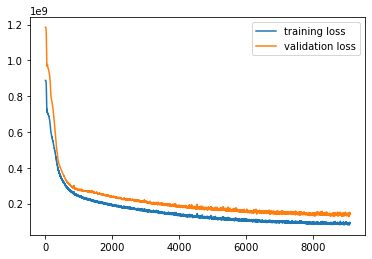

In [15]:
plt.plot(np.arange(epochs),train_loss_ep)
plt.plot(np.arange(epochs),val_loss_ep)
# plt.ylim((0,0.01))
# plt.xlim((0,150))
plt.legend(['training loss','validation loss','training kl loss','training discriminator ae','validation discriminator ae','training discriminator d','validation discriminator d'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3.jpg'))
plt.show()


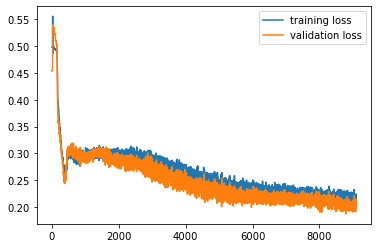

In [16]:
plt.plot(np.arange(epochs),train_lossclf_ep)
plt.plot(np.arange(epochs),val_lossclf_ep)
# plt.ylim((0,0.01))
# plt.xlim((0,150))
plt.legend(['training loss','validation loss','training kl loss','training discriminator ae','validation discriminator ae','training discriminator d','validation discriminator d'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3_clf.jpg'))
plt.show()


In [18]:
# name='c13k20XA_07_dca'
# logsavepath='/mnt/xinyi/pamrats/log/train_gae_starmap/'+name
# with open(os.path.join(logsavepath,'val_loss_a'), 'rb') as output:
#     val_loss_a_ep=pickle.load(output)
np.argmin(val_lossclf_ep[:9090])
# np.where(np.logical_not(np.isfinite(val_loss_ep[:])))
# val_loss_ep[920]

8785

In [19]:
def plotExprs(exprs,exprs2,savename,embedding,embedding2,savepath,savenameAdd='',norm=None):
#     fig, ax = plt.subplots(dpi=400)
    if not exprs is None:
        plt.scatter(embedding[:,0],embedding[:,1],s=5,c=exprs,cmap='Greys',edgecolors='blue',linewidth=0.2,alpha=1,marker='o',norm=norm)
    if not exprs2 is None:
        plt.scatter(embedding2[:,0],embedding2[:,1],s=5,c=exprs2,cmap='Greys',edgecolors='green',linewidth=0.2,alpha=1,marker='^',norm=norm)
    plt.colorbar(orientation='vertical', shrink = 0.5)
    plt.gca().set_aspect('equal', 'datalim')
#     fig.set_figheight(5)
#     fig.set_figwidth(5)
    plt.savefig(os.path.join(savepath,savename+savenameAdd+'.jpg'),dpi=400)
#     plt.show()
    
#     fig.clf()
    plt.close('all')

In [20]:
def plotExprsDiff(exprsPos,exprsNeg,exprs2,savename,embeddingPos,embeddingNeg,embedding2,savepath,savenameAdd='',norm=None):
#     fig, ax = plt.subplots(dpi=400)
    if not exprsPos is None:
        plt.scatter(embeddingPos[:,0],embeddingPos[:,1],s=5,c=exprsPos,cmap='Reds',edgecolors='blue',linewidth=0.2,alpha=1,marker='o',norm=norm)
        plt.colorbar(orientation='vertical', shrink = 0.5)
        plt.scatter(embeddingNeg[:,0],embeddingNeg[:,1],s=5,c=exprsNeg,cmap=plt.cm.get_cmap('Blues'),edgecolors='blue',linewidth=0.2,alpha=1,marker='o',norm=norm)
        plt.colorbar(orientation='vertical', shrink = 0.5)
    if not exprs2 is None:
        plt.scatter(embedding2[:,0],embedding2[:,1],s=5,c=exprs2,cmap='Greys',edgecolors='green',linewidth=0.2,alpha=1,marker='^',norm=norm)
        plt.colorbar(orientation='vertical', shrink = 0.5)
    plt.gca().set_aspect('equal', 'datalim')
#     fig.set_figheight(5)
#     fig.set_figwidth(5)
    plt.savefig(os.path.join(savepath,savename+savenameAdd+'.jpg'),dpi=1200)
#     plt.show()
    
#     fig.clf()
    plt.close('all')

In [21]:
# lossCE_binary=torch.nn.CrossEntropyLoss(reduction='none')
savenameAdd='_thresh1111'
# savenameAdd='_thresh4445'
lossThreshSize=1111
def plotLoss(inputNp,labelsNp,coordNp,name,savenameAdd=''):
    loss_test_all=np.zeros(inputNp.shape[0])
    loss_test_all_binary=np.zeros(inputNp.shape[0])
    loss_test_all_diff=np.zeros(inputNp.shape[0])
    pred_test_all=np.zeros(inputNp.shape[0])
    for i in range(inputNp.shape[0]):
        testInput=inputNp[[i]]
        labels=labelsNp[[i]]
        if use_cuda:
            testInput=torch.tensor(testInput).cuda().float()
            labels=torch.tensor(labels).cuda().float()
        pred = model(testInput)
        loss_test_all[i]=lossCE(pred.flatten(),labels).item()
        pred_test_all[i]=pred.flatten()[0]
#         if pred[0]*labels[0]>0: 
        if labels[0]>0 and pred[0]>lossThreshSize:
            loss_test_all_binary[i]=0
#         elif pred[0]+labels[0]>0.001: #original
        elif pred[0]>lossThreshSize or labels[0]>0:
            loss_test_all_binary[i]=1
        else:
            loss_test_all_binary[i]=0
        loss_test_all_diff[i]=pred.flatten()[0]-labels[0]
        
    posidx=(labelsNp>0)
    negidx=labelsNp==0
    loss_test_posLoss=np.sum(loss_test_all[posidx])/np.sum(posidx)
    loss_test_negLoss=np.sum(loss_test_all[negidx])/np.sum(negidx)
    print(name+' results',
          'loss positive: {:.4f}'.format(loss_test_posLoss),
         'loss negative: {:.4f}'.format(loss_test_negLoss))
    
    fig, ax = plt.subplots(dpi=400)
    fig.set_figheight(8)
    fig.set_figwidth(4)
    plt.xscale('log')
    plt.yscale('log')
#     print(labelsNp[posidx])
#     print(pred_test_all[posidx])
    plt.scatter(labelsNp[posidx],pred_test_all[posidx]+0.1)
    plt.savefig(os.path.join(plotsavepath,name+'loss'+s+'_diffscatter_positive'+'.jpg'))
    plt.close()
    
    largeridx=np.logical_and(posidx,loss_test_all_diff>=0)
    smalleridx=np.logical_and(posidx,loss_test_all_diff<0)
    if np.sum(largeridx)>0:
        fig, ax = plt.subplots(dpi=400)
        fig.set_figheight(2.5)
        fig.set_figwidth(10)
        plt.xscale('log')
        plt.hist(loss_test_all_diff[largeridx],bins=np.logspace(np.log10(np.min(loss_test_all_diff[largeridx])),np.log10(np.max(loss_test_all_diff[largeridx])),51))
#         plt.yscale('log')
        plt.savefig(os.path.join(plotsavepath,name+'loss'+s+'_diffHist_positiveLarger'+'.jpg'))
        plt.close()
    if np.sum(smalleridx)>0:
        fig, ax = plt.subplots(dpi=400)
        fig.set_figheight(2.5)
        fig.set_figwidth(10)
        plt.xscale('log')
        plt.hist(np.abs(loss_test_all_diff[smalleridx]),bins=np.logspace(np.log10(np.min(np.abs(loss_test_all_diff[smalleridx]))),np.log10(np.max(np.abs(loss_test_all_diff[smalleridx]))),51))
        plt.savefig(os.path.join(plotsavepath,name+'loss'+s+'_diffHist_positiveSmaller'+'.jpg'))
        plt.close()
    fig, ax = plt.subplots(dpi=400)
    fig.set_figheight(2.5)
    fig.set_figwidth(10)
    plt.xscale('log')
    plt.hist(loss_test_all_diff[negidx]+0.1,bins=np.logspace(np.log10(np.min(loss_test_all_diff[negidx]+0.1)),np.log10(np.max(loss_test_all_diff[negidx]+0.1)),51))
    plt.savefig(os.path.join(plotsavepath,name+'loss'+s+'_diffHist_negative'+'.jpg'))
    plt.close()
    
#     plotExprs(loss_test_all[posidx],loss_test_all[negidx]+0.1,name+'loss'+s,coordNp[posidx],coordNp[negidx],plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())
#     if np.sum(posidx)>0:
#         plotExprs(loss_test_all[posidx],None,name+'loss'+s+'_positive',coordNp[posidx],None,plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())
#     plotExprs(None,loss_test_all[negidx]+0.1,name+'loss'+s+'_negative',None,coordNp[negidx],plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())

#     if np.sum(posidx)>0:
#         plotExprsDiff(loss_test_all_diff[largeridx],np.abs(loss_test_all_diff[smalleridx]),loss_test_all_diff[negidx]+0.1,name+'loss'+s+'_diff',coordNp[largeridx],coordNp[smalleridx],coordNp[negidx],plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())
#         plotExprsDiff(loss_test_all_diff[largeridx],np.abs(loss_test_all_diff[smalleridx]),None,name+'loss'+s+'_diff_positive',coordNp[largeridx],coordNp[smalleridx],None,plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())
#         plotExprsDiff(np.abs(loss_test_all_diff[smalleridx]),loss_test_all_diff[largeridx],loss_test_all_diff[negidx]+0.1,name+'loss'+s+'_diff2',coordNp[smalleridx],coordNp[largeridx],coordNp[negidx],plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())
#         plotExprsDiff(np.abs(loss_test_all_diff[smalleridx]),loss_test_all_diff[largeridx],None,name+'loss'+s+'_diff2_positive',coordNp[smalleridx],coordNp[largeridx],None,plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())

#     plotExprsDiff(None,None,loss_test_all_diff[negidx]+0.1,name+'loss'+s+'_diff_negative',coordNp[largeridx],coordNp[smalleridx],coordNp[negidx],plotsavepath,savenameAdd=savenameAdd,norm=matplotlib.colors.LogNorm())

    loss_test_posLoss_binary=np.sum(loss_test_all_binary[posidx])/np.sum(posidx)
    loss_test_negLoss_binary=np.sum(loss_test_all_binary[negidx])/np.sum(negidx)
    print(name+' results',
          'loss positive binary: {:.4f}'.format(loss_test_posLoss_binary),
         'loss negative binary: {:.4f}'.format(loss_test_negLoss_binary))
    
#     plotExprs(loss_test_all_binary[posidx],loss_test_all_binary[negidx],name+'loss'+s+'_binary',coordNp[posidx],coordNp[negidx],plotsavepath,savenameAdd=savenameAdd)
#     if np.sum(posidx)>0:
#         plotExprs(loss_test_all_binary[posidx],None,name+'loss'+s+'_positive'+'_binary',coordNp[posidx],None,plotsavepath,savenameAdd=savenameAdd)
#     plotExprs(None,loss_test_all_binary[negidx],name+'loss'+s+'_negative'+'_binary',None,coordNp[negidx],plotsavepath,savenameAdd=savenameAdd)

    
testepoch=8790
model.load_state_dict(torch.load(os.path.join(modelsavepath,str(testepoch)+'.pt')))
model.eval()
plotepoch='epoch8790'
plotepoch+=savenameAdd
trainInput=allInputnp[alltrainIdx]
trainLabels=allLabelsnp[alltrainIdx]
testInput=allInputnp[alltestIdx]
testLabels=allLabelsnp[alltestIdx]
valInput=allInputnp[allvalIdx]
valLabels=allLabelsnp[allvalIdx]
plot_samples={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}

for s in plot_samples.keys():
#     if s in ['disease13']:
#         continue
    print(s)
#     if s in ['disease13','disease8']:
#         imageslist_s=loadImage.loadandsplitPlaque_overlap_regrs(plaqueMaskImg,plaqueSizeFactor,areaThresh,plaqueCentroids[s][['Y','X']].to_numpy().astype(int),plaqueCutoffRadius,sampleidx[s],datadir,diamThresh_mul,overlap,valNodes,testNodes,ifFlip=False,minCutoff=minThresh_mul,seed=seed,returnPos=True)
#     if s in ['control13','control8']:
#         imageslist_s=loadImage.loadandsplit(sampleidx[s],datadir,diamThresh_mul,overlap,valNodes,testNodes,ifFlip=False,minCutoff=minThresh_mul,seed=seed,clf=True,returnPos=True)
    
#     trainInputnp, valInputnp, testInputnp, trainLabelsnp,valLabelsnp,testLabelsnp,trainCoordnp,valCoordnp,testCoordnp=imageslist_s
    if s in training_samples:
        sidx=(allSampleNames==s)
        testInputnp=testInput[sidx[alltestIdx]]
        testLabelsnp=testLabels[sidx[alltestIdx]]
        testCoordnp=None
        trainInputnp=trainInput[sidx[alltrainIdx]]
        trainLabelsnp=trainLabels[sidx[alltrainIdx]]
        trainCoordnp=None
        valInputnp=valInput[sidx[allvalIdx]]
        valLabelsnp=valLabels[sidx[allvalIdx]]
        valCoordnp=None

        plotLoss(testInputnp,testLabelsnp,testCoordnp,'test',plotepoch)
        plotLoss(trainInputnp,trainLabelsnp,trainCoordnp,'train',plotepoch)
        plotLoss(valInputnp,valLabelsnp,valCoordnp,'val',plotepoch)
    
    plotLoss(mulist[s],labellist[s],None,'all',plotepoch)
    
#     trainInputnp, valInputnp, testInputnp, trainLabelsnp,valLabelsnp,testLabelsnp,trainCoordnp,valCoordnp,testCoordnp=None,None,None,None,None,None,None,None,None
#     imageslist_s=None

disease13


<ipython-input-21-7f604e185b68>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testInput=torch.tensor(testInput).cuda().float()


test results loss positive: 137012789.5503 loss negative: 8736315.9520
test results loss positive binary: 0.1130 loss negative binary: 0.2892
train results loss positive: 55461112.2223 loss negative: 5955604.0459
train results loss positive binary: 0.1009 loss negative binary: 0.2928
val results loss positive: 142062363.4437 loss negative: 9652266.3714
val results loss positive binary: 0.0822 loss negative binary: 0.3099
all results loss positive: 68137242.5787 loss negative: 6416986.0048
all results loss positive binary: 0.1013 loss negative binary: 0.2934
control13


<ipython-input-21-7f604e185b68>:31: RuntimeWarning: invalid value encountered in double_scalars
  loss_test_posLoss=np.sum(loss_test_all[posidx])/np.sum(posidx)


all results loss positive: nan loss negative: 74877478437.6801


<ipython-input-21-7f604e185b68>:88: RuntimeWarning: invalid value encountered in double_scalars
  loss_test_posLoss_binary=np.sum(loss_test_all_binary[posidx])/np.sum(posidx)


all results loss positive binary: nan loss negative binary: 0.1498
disease8
all results loss positive: 11496750255.0428 loss negative: 5887927940.0033
all results loss positive binary: 0.3571 loss negative binary: 0.2652
control8
all results loss positive: nan loss negative: 579911247.1861
all results loss positive binary: nan loss negative binary: 0.0773


disease13


<ipython-input-26-086bac75e06b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testInput=torch.tensor(testInput).cuda().float()


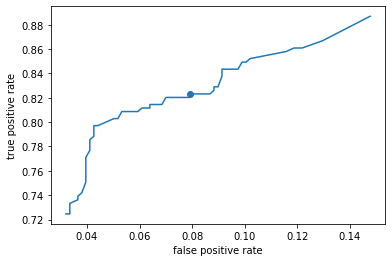

<ipython-input-26-086bac75e06b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testInput=torch.tensor(testInput).cuda().float()


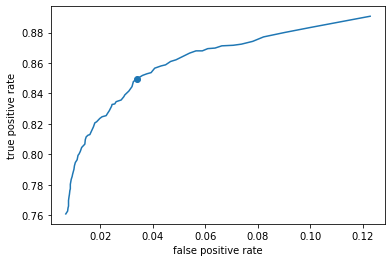

<ipython-input-26-086bac75e06b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testInput=torch.tensor(testInput).cuda().float()


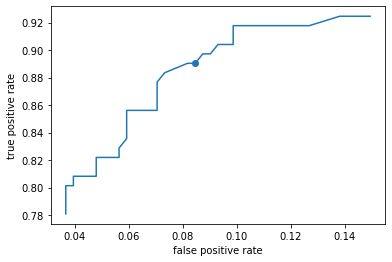

<ipython-input-26-086bac75e06b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testInput=torch.tensor(testInput).cuda().float()


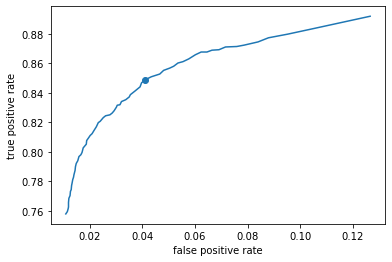

control13


<ipython-input-26-086bac75e06b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testInput=torch.tensor(testInput).cuda().float()


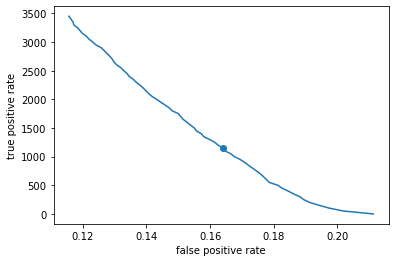

disease8


<ipython-input-26-086bac75e06b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testInput=torch.tensor(testInput).cuda().float()


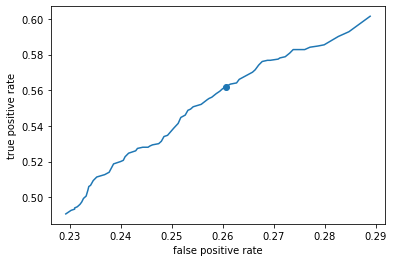

control8


<ipython-input-26-086bac75e06b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testInput=torch.tensor(testInput).cuda().float()


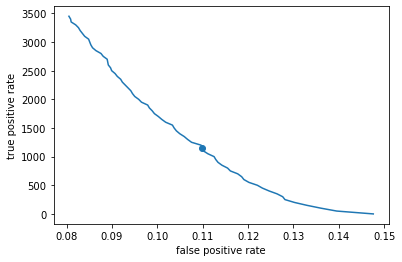

In [26]:
# lossCE_binary=torch.nn.CrossEntropyLoss(reduction='none')
lossThreshSize_list=np.arange(70)*50
def plotLoss_roc(inputNp,labelsNp,coordNp,name,savenameAdd=''):
    tpr_list=np.zeros(lossThreshSize_list.size)
    fpr_list=np.zeros(lossThreshSize_list.size)
    for l in range(lossThreshSize_list.size):
        lossThreshSize=lossThreshSize_list[l]
        loss_test_all_binary=np.zeros(inputNp.shape[0])
        for i in range(inputNp.shape[0]):
            testInput=inputNp[[i]]
            labels=labelsNp[[i]]
            if use_cuda:
                testInput=torch.tensor(testInput).cuda().float()
                labels=torch.tensor(labels).cuda().float()
            pred = model(testInput)
    #         if pred[0]*labels[0]>0: 
            if labels[0]>0 and pred[0]>lossThreshSize:
                loss_test_all_binary[i]=0
    #         elif pred[0]+labels[0]>0.001: #original
            elif pred[0]>lossThreshSize or labels[0]>0:
                loss_test_all_binary[i]=1
            else:
                loss_test_all_binary[i]=0

        posidx=(labelsNp>0)
        negidx=labelsNp==0
        
#         print(np.sum(loss_test_all_binary[posidx]==0)/np.sum(posidx))
        if 'disease' in s:
            tpr_list[l]=np.sum(loss_test_all_binary[posidx]==0)/np.sum(posidx)
#             print(tpr_list[l])
        fpr_list[l]=np.sum(loss_test_all_binary[negidx]==1)/np.sum(negidx)
    if 'control' in s:
        tpr_list=lossThreshSize_list.copy()
    plt.plot(fpr_list,tpr_list)
    plt.scatter(fpr_list[23],tpr_list[23])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.savefig(os.path.join(plotsavepath,'roc_size_'+s+name+plotepoch+'.jpg'))
    plt.show()


    
testepoch=9180
model.load_state_dict(torch.load(os.path.join(modelsavepath,str(testepoch)+'.pt')))
model.eval()
plotepoch='epoch9180'
# plotepoch+=savenameAdd
trainInput=allInputnp[alltrainIdx]
trainLabels=allLabelsnp[alltrainIdx]
testInput=allInputnp[alltestIdx]
testLabels=allLabelsnp[alltestIdx]
valInput=allInputnp[allvalIdx]
valLabels=allLabelsnp[allvalIdx]
plot_samples={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}

for s in plot_samples.keys():
#     if s in ['disease13']:
#         continue
    print(s)
#     if s in ['disease13','disease8']:
#         imageslist_s=loadImage.loadandsplitPlaque_overlap_regrs(plaqueMaskImg,plaqueSizeFactor,areaThresh,plaqueCentroids[s][['Y','X']].to_numpy().astype(int),plaqueCutoffRadius,sampleidx[s],datadir,diamThresh_mul,overlap,valNodes,testNodes,ifFlip=False,minCutoff=minThresh_mul,seed=seed,returnPos=True)
#     if s in ['control13','control8']:
#         imageslist_s=loadImage.loadandsplit(sampleidx[s],datadir,diamThresh_mul,overlap,valNodes,testNodes,ifFlip=False,minCutoff=minThresh_mul,seed=seed,clf=True,returnPos=True)
    
#     trainInputnp, valInputnp, testInputnp, trainLabelsnp,valLabelsnp,testLabelsnp,trainCoordnp,valCoordnp,testCoordnp=imageslist_s
    if s in training_samples:
        sidx=(allSampleNames==s)
        testInputnp=testInput[sidx[alltestIdx]]
        testLabelsnp=testLabels[sidx[alltestIdx]]
        testCoordnp=None
        trainInputnp=trainInput[sidx[alltrainIdx]]
        trainLabelsnp=trainLabels[sidx[alltrainIdx]]
        trainCoordnp=None
        valInputnp=valInput[sidx[allvalIdx]]
        valLabelsnp=valLabels[sidx[allvalIdx]]
        valCoordnp=None

        plotLoss_roc(testInputnp,testLabelsnp,testCoordnp,'test',plotepoch)
        plotLoss_roc(trainInputnp,trainLabelsnp,trainCoordnp,'train',plotepoch)
        plotLoss_roc(valInputnp,valLabelsnp,valCoordnp,'val',plotepoch)
    
    plotLoss_roc(mulist[s],labellist[s],None,'all',plotepoch)
    
#     trainInputnp, valInputnp, testInputnp, trainLabelsnp,valLabelsnp,testLabelsnp,trainCoordnp,valCoordnp,testCoordnp=None,None,None,None,None,None,None,None,None
#     imageslist_s=None

In [14]:
tpr

NameError: name 'tpr' is not defined

In [ ]:
labels

In [ ]:
torch.sum(result[zeroidx])

In [ ]:
# model.pi.weight[:8,:8]
model_str